<a href="https://colab.research.google.com/github/Mushfique12/IGTE/blob/ResNet/pinns_magnetostatic_poisson_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install -U "ray[tune]"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install git+https://github.com/optuna/optuna.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/optuna/optuna.git to /tmp/pip-req-build-85lx0ai5
  Running command git clone -q https://github.com/optuna/optuna.git /tmp/pip-req-build-85lx0ai5
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done


In [ ]:
from typing import Callable

import matplotlib.pyplot as plt
import torch
from scipy.integrate import solve_ivp
from torch import nn
import numpy as np
import scipy.io
import time
import urllib

from ray import tune
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [ ]:
# Checking for GPU
if torch.cuda.is_available():
  tensor = torch.rand(3, 4)
  tensor = tensor.to('cuda')
  print(f"Device tensor is stored on: {tensor.device}")

# Load data

In [ ]:
# NN architecture in each subdomain
layers1 = [2, 400, 400, 100, 1]
# layers2 = [2, 400, 200, 100, 100, 1]
layers2 = [2, 100, 100, 40, 1]

mu1 = 1
mu2 = 1

Max_iter = 5000

# Data Preprocessing

In [ ]:
def load_data():
  # Load training data (boundary points), residual and interface points from .mat file
  # All points are generated in Matlab
  # Download file from github
  !wget https://github.com/Mushfique12/IGTE/blob/82629c9165acb94b7c2ec77d054b9a3cbd314d06/PINN_Lin_mat.mat?raw=true
  # Rename the file
  !mv PINN_Lin_mat.mat\?raw\=true PINN_Lin_mat.mat
  # Load the file
  data = scipy.io.loadmat('/content/PINN_Lin_mat.mat')

  # Boundary points from subdomian 1
  N_ub   = 250

  # Residual points in three subdomains
  N_f1   = 500
  N_f2   = 200

  # Interface points along the two interfaces
  N_I1   = 150

  x_f1 = data['x_domain'].flatten()[:,None]
  y_f1 = data['y_domain'].flatten()[:,None]
  x_f2 = data['x_coil'].flatten()[:,None]
  y_f2 = data['y_coil'].flatten()[:,None]

  x_i  = data['x_i'].flatten()[:,None]
  y_i  = data['y_i'].flatten()[:,None]

  x_boundary   = data['x_boundary'].flatten()[:,None]
  y_boundary   = data['y_boundary'].flatten()[:,None]

  u_boundary  = data['u_boundary'].flatten()[:,None]
  u_exact1 = data['u_domain'].flatten()[:,None]
  u_exact2 = data['u_coil'].flatten()[:,None]
  u_exacti = data['u_i'].flatten()[:,None]

  u_exact = np.concatenate([u_exact1, u_exact2, u_exacti, u_boundary])

  u_exact1 = np.divide(u_exact1, u_exact.max())
  u_exact2 = np.divide(u_exact2, u_exact.max())
  u_exacti = np.divide(u_exacti, u_exact.max())
  u_boundary = np.divide(u_boundary, u_exact.max())

  X_f1 = np.hstack((x_f1.flatten()[:,None], y_f1.flatten()[:,None]))
  X_f2 = np.hstack((x_f2.flatten()[:,None], y_f2.flatten()[:,None]))
  X_fi = np.hstack((x_i.flatten()[:,None], y_i.flatten()[:,None]))
  X_ub = np.hstack((x_boundary.flatten()[:,None], y_boundary.flatten()[:,None]))

  # Points in the whole  domain
  # x_total =  data['x_total'].flatten()[:,None] 
  # y_total =  data['y_total'].flatten()[:,None]

  # X_star1 = np.hstack((x_f1.flatten()[:,None], y_f1.flatten()[:,None]))
  # X_star2 = np.hstack((x_f2.flatten()[:,None], y_f2.flatten()[:,None]))

  # Randomly select the residual points from sub-domains
  idx1 = np.random.choice(X_f1.shape[0], N_f1, replace=False)    
  X_f1_train = np.float32(X_f1[idx1,:])

  idx2 = np.random.choice(X_f2.shape[0], N_f2, replace=False)    
  X_f2_train = np.float32(X_f2[idx2,:])

  # Randomly select boundary points
  idx4 = np.random.choice(X_ub.shape[0], N_ub, replace=False)
  X_ub_train = np.float32(X_ub[idx4,:])
  ub_train   = np.float32(u_boundary[idx4,:])

  # Randomly select the interface points along two interfaces
  idxi1 = np.random.choice(X_fi.shape[0], N_I1, replace=False)    
  X_fi_train = np.float32(X_fi[idxi1,:])
  ub_fi1_train = np.float32(u_exacti[idxi1,:])

  # List of all data
  train_data = [X_f1_train, X_f2_train, X_ub_train, ub_train, X_fi_train, ub_fi1_train]
  input_data = [X_f1, X_f2, X_fi, X_ub]
  plotting_data = [x_f1, x_f2, x_i, x_boundary, y_f1, y_f2, y_i, y_boundary, u_exact]

  return train_data, input_data, plotting_data

# Defining ML Architecture

In [ ]:
class DenseResNet(nn.Module):
    """
    This is a ResNet Class.
    -> dim_in: network's input dimension
    -> dim_out: network's output dimension
    -> num_resnet_blocks: number of ResNet blocks
    -> num_layers_per_block: number of layers per ResNet block
    -> num_neurons: number of neurons in each layer
    -> activation: Non-linear activations function that you want to use. E.g. nn.Sigmoid(), nn.ReLU()
    -> fourier_features: whether to pass the inputs through Fourier mapping. E.g. True or False
    -> m_freq: how many frequencies do you want the inputs to be mapped to
    -> sigma: controls the spectrum of frequencies. 
              If sigma is greater more frequencies are consider. 
              You can also look at it as sampling from the standard normal, Z~N(0, 1), 
              and mapping to another normal, X~N(\mu, \sigma^2), using x = mu + sigma*z.
    -> tune_beta: do you want to consider the parameter beta in the activation functions in each layer? E.g., Tanh(beta*x).
                  In practice it is observed that training beta (i.e. tune_beta=True) could improve convergence. 
                  If tune_beta=False, you get the a fixed beta i.e. beta=1.
    -> The method model_capacity() returns the number of layers and parameters in the network.
    """
    def __init__(self, dim_in=2, dim_out=1, num_resnet_blocks=3, 
                 num_layers_per_block=2, num_neurons=50, activation=nn.Sigmoid(), 
                 fourier_features=False, m_freqs=100, sigma=10, tune_beta=False):
                 
        super(DenseResNet, self).__init__()

        self.num_resnet_blocks = num_resnet_blocks
        self.num_layers_per_block = num_layers_per_block
        self.fourier_features = fourier_features
        self.activation = activation
        self.activation_last = nn.Sigmoid()
        self.tune_beta = tune_beta

        if tune_beta:
            self.beta0 = nn.Parameter(torch.ones(1, 1)).to(device)
            self.beta = nn.Parameter(torch.ones(self.num_resnet_blocks, self.num_layers_per_block)).to(device)

        else: 
            self.beta0 = torch.ones(1, 1).to(device)
            self.beta = torch.ones(self.num_resnet_blocks, self.num_layers_per_block).to(device)

        self.first = nn.Linear(dim_in, num_neurons)

        self.resblocks = nn.ModuleList([
            nn.ModuleList([nn.Linear(num_neurons, num_neurons) 
                for _ in range(num_layers_per_block)]) 
            for _ in range(num_resnet_blocks)])

        self.last = nn.Linear(num_neurons, dim_out)

        if fourier_features:
            self.first = nn.Linear(2*m_freqs, num_neurons)
            self.B = nn.Parameter(sigma*torch.randn(dim_in, m_freqs)) # to converts inputs to m_freqs

    def forward(self, x):
        if self.fourier_features:
            cosx = torch.cos(torch.matmul(x, self.B))
            sinx = torch.sin(torch.matmul(x, self.B))
            x = torch.cat((cosx, sinx), dim=1)
            x = self.activation(self.beta0*self.first(x)) 

        else:
            x = self.activation(self.beta0*self.first(x))

        for i in range(self.num_resnet_blocks):
            z = self.activation(self.beta[i][0]*self.resblocks[i][0](x))

            for j in range(1, self.num_layers_per_block):
                z = self.activation(self.beta[i][j]*self.resblocks[i][j](z))

            x = z + x

        # out = self.activation_last(self.last(x))
        out = self.last(x)

        return out

    def model_capacity(self):
        """
        Prints the number of parameters and the number of layers in the network
        """
        number_of_learnable_params = sum(p.numel() for p in self.parameters() if p.requires_grad)
        num_layers = len(list(self.parameters()))
        print("\n\nThe number of layers in the model: %d" % num_layers)
        print("\nThe number of learnable parameters in the model: %d" % number_of_learnable_params)  

In [ ]:
class NNApproximator(nn.Module):
    def __init__(self, num_hidden: int, dim_hidden: int, act=nn.Sigmoid()):

        super().__init__()

        self.layer_in = nn.Linear(2, dim_hidden)
        self.layer_out = nn.Linear(dim_hidden, 1)

        num_middle = num_hidden - 1
        self.middle_layers = nn.ModuleList(
            [nn.Linear(dim_hidden, dim_hidden) for _ in range(num_middle)]
        )
        self.act = act
        self.activation_last = nn.Sigmoid()

    def forward(self, x):
        out = self.act(self.layer_in(x))
        for layer in self.middle_layers:
            out = self.act(layer(out))
        return self.activation_last(self.layer_out(out))


def f(nn: DenseResNet, x: torch.Tensor) -> torch.Tensor:
    """Compute the value of the approximate solution from the NN model"""
    return nn(x)


def df(nn: DenseResNet, x: torch.Tensor = None, order: int = 2) -> torch.Tensor:
    """Compute neural network derivative with respect to input features using PyTorch autograd engine"""
    df_value = f(nn, x)
    # print('x.shape', x.shape)
    # output_dim = [int(x.shape[0]), 1]
    # print('output_dim', output_dim)
    # output_ = torch.ones(output_dim)
    # print('output_shape', output_.shape)

    for _ in range(order):
        df_value = torch.autograd.grad(
            df_value,
            x,
            # grad_outputs=torch.ones(output_dim),
            torch.ones_like(df_value),
            # grad_outputs=torch.ones_like(x),
            create_graph=True,
            retain_graph=True,
        )[0]

    return df_value


def compute_loss(
    nn1: NNApproximator, 
    nn2: NNApproximator, 
    epoch : int = 0,
    x1: torch.Tensor = None, 
    x2: torch.Tensor = None, 
    xi: torch.Tensor = None, 
    xb: torch.Tensor = None, 
    ub: torch.Tensor = None,
    ufi: torch.Tensor = None,
    mult: int = 1,
    verbose: bool = False
) -> torch.float:

    """Compute the full loss function as interior loss + boundary loss
    This custom loss function is fully defined with differentiable tensors therefore
    the .backward() method can be applied to it
    """
    multiplier = mult
    interior_loss_1 = torch.sub(df(nn1, x1, order=2), torch.exp(x1))
    interior_loss_2 = torch.sub(df(nn2, x2, order=2), -50)

    u1_i = f(nn1, xi)
    u2_i = f(nn2, xi)
    uAvg_i = torch.mul(torch.add(u1_i, u2_i), 2)

    interface_loss_1 = torch.sub(uAvg_i, u1_i)
    interface_loss_2 = torch.sub(uAvg_i, u2_i)

    actual_interface_loss_1 = torch.sub(ufi, u1_i)
    actual_interface_loss_2 = torch.sub(ufi, u2_i)

    # Interface 1
    interface_1 = df(nn1, xi, order=2)
    interface_2 = df(nn2, xi, order=2)

    # Residual Continuity conditions on the interfaces
    res_loss = (interface_1 - torch.exp(xi)) - (interface_2 - (-50))
    
    # boundary = xb
    # boundary.requires_grad = True
    ub_pred = f(nn1, xb)
    boundary_loss = torch.sub(ub, ub_pred)

    if epoch % 2000 == 0:

      print(f"Loss at {epoch}: {interior_loss_1.pow(2).mean()}, {interface_loss_1.pow(2).mean()}, \
              domain: {interior_loss_2.pow(2).mean()}, {interface_loss_2.pow(2).mean()}, {boundary_loss.pow(2).mean()}")


    loss_1 = \
        interior_loss_1.pow(2).mean() + \
        multiplier * interface_loss_1.pow(2).mean() + \
        multiplier * boundary_loss.pow(2).mean() #+ \
        #multiplier * actual_interface_loss_1.pow(2).mean() #+ \
        #res_loss.pow(2).mean()

    loss_2 = \
        interior_loss_2.pow(2).mean() + \
        multiplier * interface_loss_2.pow(2).mean() #+ \
        #multiplier * actual_interface_loss_2.pow(2).mean() #+ \
        #res_loss.pow(2).mean()

    final_loss = loss_1 + loss_2

    loss_list = [interior_loss_1.pow(2).mean().detach().cpu().numpy(), 
              interface_loss_1.pow(2).mean().detach().cpu().numpy(), 
              interior_loss_2.pow(2).mean().detach().cpu().numpy(), 
              interface_loss_2.pow(2).mean().detach().cpu().numpy(), 
              boundary_loss.pow(2).mean().detach().cpu().numpy()]

    return final_loss, loss_list


def train_model(
    nn1: DenseResNet, 
    nn2: DenseResNet, 
    loss_fn: Callable,
    learning_rate: int = 0.01,
    max_epochs: int = 1000,
):

    loss_evolution_1, loss_evolution_2 = [], []
    interior_loss_1, interface_loss_1, interior_loss_2, interface_loss_2, boundary_loss= [], [], [], [], []

    optimizer = torch.optim.NAdam([
                {'params': nn1.parameters(), 'lr': learning_rate},
                {'params': nn2.parameters(), 'lr': learning_rate}
            ])
    
  
    for epoch in range(max_epochs):

        try:
            loss, loss_list = loss_fn(nn1, nn2, epoch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if epoch % 1000 == 0:
                print(f"Epoch: {epoch} - Loss # 1: {float(loss):>7f}")

            loss_evolution_1.append(loss.detach().cpu().numpy())

        except KeyboardInterrupt:
            break

        interior_loss_1.append(loss_list[0]) 
        interface_loss_1.append(loss_list[1]) 
        interior_loss_2.append(loss_list[2]) 
        interface_loss_2.append(loss_list[3]) 
        boundary_loss.append(loss_list[4])

        # print('===================================================================')
        # print('Here is the Loss Reported', float(loss.detach().cpu().numpy())) 
        # print('===================================================================')

        # Reporting to Ray Tune to stop bad performing trials early 
        tune.report(loss=float(loss.detach().cpu().numpy()))

    return [nn1, nn2], np.array(loss_evolution_1), np.array([interior_loss_1, interface_loss_1, interior_loss_2, interface_loss_2, boundary_loss])


def check_gradient(nn: DenseResNet, x: torch.Tensor = None) -> bool:

    eps = 1e-4
    dfdx_fd = (f(nn, x + eps) - f(nn, x - eps)) / (2 * eps)
    dfdx_sample = df(nn, x, order=1)

    return torch.allclose(dfdx_fd.T, dfdx_sample.T, atol=1e-2, rtol=1e-2)




In [ ]:
# nn_approximator_1 = NNApproximator(4, 10)
# nn_approximator_2 = NNApproximator(2, 10)

In [ ]:
# from torchsummary import summary
# print(nn_approximator_1)

In [ ]:
# print(nn_approximator_2)

In [ ]:
# type(X_f1_train[1, 0])

## Train Pinns

In [ ]:
from functools import partial
import os

# domain = [0.0, 1.0]
# x = torch.linspace(domain[0], domain[1], steps=10, requires_grad=True)
# x = x.reshape(x.shape[0], 1)

def train_PINN(config={}, data=[], checkpoint_dir=None):

  # Hyperparameter Tuning
  # nn_approximator_1 = NNApproximator(config["num_hidden"], config["dim_hidden"], config["activation"])
  # nn_approximator_2 = NNApproximator(config["num_hidden"], config["dim_hidden"], config["activation"])
  nn_approximator_1 = DenseResNet(dim_in=2, dim_out=1, num_resnet_blocks=config["num_resnet_blocks"], 
                          num_layers_per_block=config["num_hidden"], num_neurons=config["dim_hidden"], activation=config["activation"], 
                          fourier_features=False, m_freqs=100, sigma=10, tune_beta=False)
  nn_approximator_2 = DenseResNet(dim_in=2, dim_out=1, num_resnet_blocks=config["num_resnet_blocks"], 
                          num_layers_per_block=config["num_hidden"], num_neurons=config["dim_hidden"], activation=config["activation"], 
                          fourier_features=False, m_freqs=100, sigma=10, tune_beta=False)
  multiplier = config["multiplier"]
  lr = config["lr"]
  max_epochs = config["epochs"]

  # Hyperparameters
  # nn_approximator_1 = NNApproximator(2, 32, nn.Sigmoid())
  # nn_approximator_2 = NNApproximator(2, 32, nn.Sigmoid())
  # nn_approximator_1 = DenseResNet(dim_in=2, dim_out=1, num_resnet_blocks=3, 
  #                         num_layers_per_block=2, num_neurons=50, activation=nn.Tanh(), 
  #                         fourier_features=False, m_freqs=100, sigma=10, tune_beta=False)
  # nn_approximator_2 = DenseResNet(dim_in=2, dim_out=1, num_resnet_blocks=3, 
  #                         num_layers_per_block=2, num_neurons=50, activation=nn.Tanh(), 
  #                         fourier_features=False, m_freqs=100, sigma=10, tune_beta=False)
  # multiplier = 60
  # lr = 0.0621
  # max_epochs = 15000



  device = "cpu"
  if torch.cuda.is_available():
    device = "cuda:0"
    if torch.cuda.device_count() > 1:
      nn_approximator_1 = nn.DataParallel(nn_approximator_1)
      nn_approximator_2 = nn.DataParallel(nn_approximator_2)
  nn_approximator_1.to(device)
  nn_approximator_2.to(device)

  # Load the data
  X_f1_train, X_f2_train, X_ub_train, ub_train, X_fi_train, ub_fi1_train = [data[i] for i in (0, 1, 2, 3, 4, 5)]

  x1 = torch.tensor(X_f1_train, requires_grad=True)
  x2 = torch.tensor(X_f2_train, requires_grad=True) 
  xi = torch.tensor(X_fi_train, requires_grad=True) 
  xb = torch.tensor(X_ub_train, requires_grad=True)
  ub = torch.tensor(ub_train)
  ub = torch.zeros_like(ub)
  ufi = torch.tensor(ub_fi1_train)

  x1 = x1.to(device)
  x2 = x2.to(device)
  xi = xi.to(device)
  xb = xb.to(device)
  ub = ub.to(device)
  ufi = ufi.to(device)

  #rint(f"Device x1 is stored on: {x1.device}")
  #print(f"Device x2 is stored on: {x2.device}")


  # assert check_gradient(nn_approximator, x)

  # f_initial = f(nn_approximator, x)
  # ax.plot(x.detach().numpy(), f_initial.detach().numpy(), label="Initial NN solution")

  # if checkpoint_dir:
  #   model_state = torch.load(
  #       os.path.join(checkpoint_dir, "checkpoint"))
  #   net.load_state_dict(model_state)
    # optimizer.load_state_dict(optimizer_state)

  # train the PINN
  loss_fn = partial(compute_loss,     
                    x1 = x1, 
                    x2 = x2, 
                    xi = xi, 
                    xb = xb, 
                    ub = ub,
                    ufi = ufi,
                    mult = multiplier,
                    verbose=True)

  nn_approximator_trained, loss_evolutions, loss_array = train_model(
                                                                    nn_approximator_1,
                                                                    nn_approximator_2,
                                                                    loss_fn=loss_fn, 
                                                                    learning_rate=lr, 
                                                                    max_epochs=max_epochs
                                                                  )

  print("Finished Training")

  return nn_approximator_trained, loss_evolutions, loss_array

  # x_eval = torch.linspace(domain[0], domain[1], steps=100).reshape(-1, 1)

In [ ]:
# Load Data
train_data, input_data, plotting_data = load_data()

nn_approximator_trained, loss_evolutions, loss_array = train_PINN(data=train_data)

--2022-08-26 09:56:09--  https://github.com/Mushfique12/IGTE/blob/82629c9165acb94b7c2ec77d054b9a3cbd314d06/PINN_Lin_mat.mat?raw=true
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/Mushfique12/IGTE/raw/82629c9165acb94b7c2ec77d054b9a3cbd314d06/PINN_Lin_mat.mat [following]
--2022-08-26 09:56:09--  https://github.com/Mushfique12/IGTE/raw/82629c9165acb94b7c2ec77d054b9a3cbd314d06/PINN_Lin_mat.mat
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Mushfique12/IGTE/82629c9165acb94b7c2ec77d054b9a3cbd314d06/PINN_Lin_mat.mat [following]
--2022-08-26 09:56:10--  https://raw.githubusercontent.com/Mushfique12/IGTE/82629c9165acb94b7c2ec77d054b9a3cbd314d06/PINN_Lin_mat.mat
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.

    "__main__", mod_spec)
  File "/usr/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.7/dist-packages/traitlets/config/application.py", line 846, in launch_instance
    app.start()
  File "/usr/local/lib/python3.7/dist-packages/ipykernel/kernelapp.py", line 612, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.7/dist-packages/tornado/platform/asyncio.py", line 132, in start
    self.asyncio_loop.run_forever()
  File "/usr/lib/python3.7/asyncio/base_events.py", line 541, in run_forever
    self._run_once()
  File "/usr/lib/python3.7/asyncio/base_events.py", line 1786, in _run_once
    handle._run()
  File "/usr/lib/python3.7/asyncio/events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "/usr/local/lib/python3.7/dist-packages/tornado/ioloop.py", line 758, in _ru

Loss at 0: 1.6060397624969482, 0.030332602560520172,               domain: 2499.22900390625, 0.0015894795069471002, 0.04667232185602188
Epoch: 0 - Loss # 1: 2505.550781
Epoch: 1000 - Loss # 1: 10.992805
Loss at 2000: 0.773738443851471, 0.02366856299340725,               domain: 0.6982380151748657, 0.006829435005784035, 0.00887515489012003
Epoch: 2000 - Loss # 1: 3.834366
Epoch: 3000 - Loss # 1: 1.927942
Loss at 4000: 0.4325166642665863, 0.024013595655560493,               domain: 0.6347076892852783, 0.008586365729570389, 0.005345799028873444
Epoch: 4000 - Loss # 1: 3.343970
Epoch: 5000 - Loss # 1: 3.063531
Loss at 6000: 0.5442556142807007, 0.460364431142807,               domain: 0.5101224780082703, 0.26571959257125854, 0.027595562860369682
Epoch: 6000 - Loss # 1: 46.275154
Epoch: 7000 - Loss # 1: 1.439018
Loss at 8000: 0.5816351771354675, 0.011813749559223652,               domain: 0.38409939408302307, 0.003380405018106103, 0.0031167827546596527
Epoch: 8000 - Loss # 1: 2.064391
Epoch:

# Hyper-Parameter Tuning

In [ ]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 9795921163898266412
 xla_global_id: -1]

In [ ]:
max_num_epochs = 45000
num_samples = 15
gpus_per_trial = 0
cpus_per_trial = 1

config = {
        "num_resnet_blocks": tune.grid_search([2, 3, 4]),
        "num_hidden": tune.sample_from(lambda _: np.random.randint(2, 6)),
        "dim_hidden": tune.sample_from(lambda _: 2 ** np.random.randint(5, 10)),        
        "activation": tune.grid_search([nn.Sigmoid(), nn.Tanh()]),
        "lr": tune.loguniform(1e-4, 1e-1),
        "multiplier": tune.grid_search([30, 60, 90]),
        "epochs": tune.grid_search([30000, 45000])
    }

# Load Data
train_data, input_data, plotting_data = load_data()

scheduler = ASHAScheduler(
        metric="loss",
        mode="min",
        max_t=max_num_epochs,
        grace_period=1,
        reduction_factor=2)

reporter = CLIReporter(
    # parameter_columns=["l1", "l2", "lr", "batch_size"],
    metric_columns=["loss", "training_iteration"])

result = tune.run(
    partial(train_PINN, data=train_data),
    resources_per_trial={"cpu": cpus_per_trial, "gpu": gpus_per_trial},
    config=config,
    num_samples=num_samples,
    # search_alg = "optuna",
    scheduler=scheduler,
    progress_reporter=reporter)

best_trial = result.get_best_trial("loss", "min", "last")
print("Best trial config: {}".format(best_trial.config))
print("Best trial final loss: {}".format(best_trial.last_result["loss"]))

--2022-08-27 00:32:11--  https://github.com/Mushfique12/IGTE/blob/82629c9165acb94b7c2ec77d054b9a3cbd314d06/PINN_Lin_mat.mat?raw=true
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/Mushfique12/IGTE/raw/82629c9165acb94b7c2ec77d054b9a3cbd314d06/PINN_Lin_mat.mat [following]
--2022-08-27 00:32:12--  https://github.com/Mushfique12/IGTE/raw/82629c9165acb94b7c2ec77d054b9a3cbd314d06/PINN_Lin_mat.mat
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Mushfique12/IGTE/82629c9165acb94b7c2ec77d054b9a3cbd314d06/PINN_Lin_mat.mat [following]
--2022-08-27 00:32:12--  https://raw.githubusercontent.com/Mushfique12/IGTE/82629c9165acb94b7c2ec77d054b9a3cbd314d06/PINN_Lin_mat.mat
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.

2022-08-27 00:32:22,516	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}
2022-08-27 00:32:22,667	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


Result for train_PINN_b1612_00001:
  date: 2022-08-27_00-32-22
  done: true
  experiment_id: 42875d6b225647039e68018b81ab4cf8
  hostname: 614c353b54c2
  iterations_since_restore: 2
  loss: 13929.560546875
  node_ip: 172.28.0.2
  pid: 1201
  time_since_restore: 4.58622932434082
  time_this_iter_s: 2.263178586959839
  time_total_s: 4.58622932434082
  timestamp: 1661560342
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: b1612_00001
  warmup_time: 0.0037479400634765625
  
Result for train_PINN_b1612_00002:
  date: 2022-08-27_00-32-22
  done: true
  experiment_id: 42875d6b225647039e68018b81ab4cf8
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 2669.75390625
  node_ip: 172.28.0.2
  pid: 1201
  time_since_restore: 0.11538243293762207
  time_this_iter_s: 0.11538243293762207
  time_total_s: 0.11538243293762207
  timestamp: 1661560342
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_00002
  warmup_time: 0.0037479400634765625
  
(func pid=1201

2022-08-27 00:32:42,888	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


Result for train_PINN_b1612_00000:
  date: 2022-08-27_00-32-42
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 8
  loss: 2509.005859375
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 27.30666732788086
  time_this_iter_s: 3.3602523803710938
  time_total_s: 27.30666732788086
  timestamp: 1661560362
  timesteps_since_restore: 0
  training_iteration: 8
  trial_id: b1612_00000
  warmup_time: 0.004474163055419922
  
(func pid=1144) Loss at 0: 1.6885627508163452, 5.389854907989502,               domain: 2500.776611328125, 0.5780320763587952, 1.6144216060638428


2022-08-27 00:32:44,365	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


Result for train_PINN_b1612_00004:
  date: 2022-08-27_00-32-44
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 2957.403564453125
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 1.444654941558838
  time_this_iter_s: 1.444654941558838
  time_total_s: 1.444654941558838
  timestamp: 1661560364
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_00004
  warmup_time: 0.004474163055419922
  
(func pid=1144) Epoch: 0 - Loss # 1: 2957.403564
(func pid=1144) Loss at 0: 1.440582036972046, 0.9862339496612549,               domain: 2508.460693359375, 1.0962992906570435, 0.18441720306873322
Result for train_PINN_b1612_00005:
  date: 2022-08-27_00-32-44
  done: false
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 2645.91845703125
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.1525869369506836
  time_this_iter_s: 0.1525869

2022-08-27 00:32:44,698	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}


(func pid=1144) Epoch: 0 - Loss # 1: 2645.918457
Result for train_PINN_b1612_00005:
  date: 2022-08-27_00-32-44
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 2
  loss: 2818.30859375
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.3085057735443115
  time_this_iter_s: 0.15591883659362793
  time_total_s: 0.3085057735443115
  timestamp: 1661560364
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: b1612_00005
  warmup_time: 0.004474163055419922
  


2022-08-27 00:32:44,853	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


(func pid=1144) Loss at 0: 1.7046641111373901, 10.677316665649414,               domain: 2500.67138671875, 3.309603214263916, 0.032105132937431335
Result for train_PINN_b1612_00006:
  date: 2022-08-27_00-32-44
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 3343.517578125
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.12413358688354492
  time_this_iter_s: 0.12413358688354492
  time_total_s: 0.12413358688354492
  timestamp: 1661560364
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_00006
  warmup_time: 0.004474163055419922
  
(func pid=1144) Epoch: 0 - Loss # 1: 3343.517578
Result for train_PINN_b1612_00003:
  date: 2022-08-27_00-32-46
  done: false
  experiment_id: 42875d6b225647039e68018b81ab4cf8
  hostname: 614c353b54c2
  iterations_since_restore: 10
  loss: 2360.27587890625
  node_ip: 172.28.0.2
  pid: 1201
  time_since_restore: 23.332881927490234
  time_this_iter_s: 2.242

2022-08-27 00:32:49,369	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}


Result for train_PINN_b1612_00007:
  date: 2022-08-27_00-32-49
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 2
  loss: 236989.96875
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 4.490589618682861
  time_this_iter_s: 2.2175145149230957
  time_total_s: 4.490589618682861
  timestamp: 1661560369
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: b1612_00007
  warmup_time: 0.004474163055419922
  
== Status ==
Current time: 2022-08-27 00:32:50 (running for 00:00:38.04)
Memory usage on this node: 2.0/12.7 GiB
Using AsyncHyperBand: num_stopped=7
Bracket: Iter 32768.000: None | Iter 16384.000: None | Iter 8192.000: None | Iter 4096.000: None | Iter 2048.000: None | Iter 1024.000: None | Iter 512.000: None | Iter 256.000: None | Iter 128.000: None | Iter 64.000: None | Iter 32.000: None | Iter 16.000: None | Iter 8.000: -2455.7315673828125 | Iter 4.000: -2524.4815673828125 | Iter 2.000: -2818.30859375 |

2022-08-27 00:32:53,825	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


Result for train_PINN_b1612_00008:
  date: 2022-08-27_00-32-53
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 4393.57421875
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 4.425688982009888
  time_this_iter_s: 4.425688982009888
  time_total_s: 4.425688982009888
  timestamp: 1661560373
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_00008
  warmup_time: 0.004474163055419922
  
(func pid=1144) Epoch: 0 - Loss # 1: 4393.574219
Result for train_PINN_b1612_00009:
  date: 2022-08-27_00-32-53
  done: false
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 2532.48388671875
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.029345035552978516
  time_this_iter_s: 0.029345035552978516
  time_total_s: 0.029345035552978516
  timestamp: 1661560373
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_00009

2022-08-27 00:32:54,148	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}


Result for train_PINN_b1612_00009:
  date: 2022-08-27_00-32-54
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 8
  loss: 2503.3154296875
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.2795140743255615
  time_this_iter_s: 0.03768587112426758
  time_total_s: 0.2795140743255615
  timestamp: 1661560374
  timesteps_since_restore: 0
  training_iteration: 8
  trial_id: b1612_00009
  warmup_time: 0.004474163055419922
  
== Status ==
Current time: 2022-08-27 00:32:57 (running for 00:00:44.69)
Memory usage on this node: 2.0/12.7 GiB
Using AsyncHyperBand: num_stopped=9
Bracket: Iter 32768.000: None | Iter 16384.000: None | Iter 8192.000: None | Iter 4096.000: None | Iter 2048.000: None | Iter 1024.000: None | Iter 512.000: None | Iter 256.000: None | Iter 128.000: None | Iter 64.000: None | Iter 32.000: None | Iter 16.000: None | Iter 8.000: -2503.3154296875 | Iter 4.000: -2524.254150390625 | Iter 2.000: -2740.87365722

2022-08-27 00:32:59,680	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


Result for train_PINN_b1612_00010:
  date: 2022-08-27_00-32-59
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 2685.950439453125
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 5.503824234008789
  time_this_iter_s: 5.503824234008789
  time_total_s: 5.503824234008789
  timestamp: 1661560379
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_00010
  warmup_time: 0.004474163055419922
  
(func pid=1144) Epoch: 0 - Loss # 1: 2685.950439
(func pid=1144) Loss at 0: 1.6433658599853516, 0.11512017250061035,               domain: 2496.63818359375, 0.10207317769527435, 0.008559394627809525
== Status ==
Current time: 2022-08-27 00:33:03 (running for 00:00:51.37)
Memory usage on this node: 2.0/12.7 GiB
Using AsyncHyperBand: num_stopped=10
Bracket: Iter 32768.000: None | Iter 16384.000: None | Iter 8192.000: None | Iter 4096.000: None | Iter 2048.000: None | Iter 1024.000: None | Iter 512.000: N

2022-08-27 00:33:08,613	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}


Result for train_PINN_b1612_00011:
  date: 2022-08-27_00-33-08
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 2
  loss: 3697.214599609375
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 8.90867567062378
  time_this_iter_s: 4.421977519989014
  time_total_s: 8.90867567062378
  timestamp: 1661560388
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: b1612_00011
  warmup_time: 0.004474163055419922
  
(func pid=1144) Loss at 0: 1.6605224609375, 1.3462470769882202,               domain: 2500.575439453125, 3.276675224304199, 2.54648494720459


2022-08-27 00:33:09,539	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


Result for train_PINN_b1612_00012:
  date: 2022-08-27_00-33-09
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 2717.318115234375
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.8933172225952148
  time_this_iter_s: 0.8933172225952148
  time_total_s: 0.8933172225952148
  timestamp: 1661560389
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_00012
  warmup_time: 0.004474163055419922
  
(func pid=1144) Epoch: 0 - Loss # 1: 2717.318115
== Status ==
Current time: 2022-08-27 00:33:09 (running for 00:00:57.12)
Memory usage on this node: 2.0/12.7 GiB
Using AsyncHyperBand: num_stopped=12
Bracket: Iter 32768.000: None | Iter 16384.000: None | Iter 8192.000: None | Iter 4096.000: None | Iter 2048.000: None | Iter 1024.000: None | Iter 512.000: None | Iter 256.000: None | Iter 128.000: None | Iter 64.000: None | Iter 32.000: None | Iter 16.000: -2377.462890625 | Iter 8.000: -2503.3154296875

2022-08-27 00:33:16,298	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}


Result for train_PINN_b1612_00013:
  date: 2022-08-27_00-33-16
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 2
  loss: 55039.421875
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 6.719547510147095
  time_this_iter_s: 3.3239455223083496
  time_total_s: 6.719547510147095
  timestamp: 1661560396
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: b1612_00013
  warmup_time: 0.004474163055419922
  
(func pid=1144) Loss at 0: 1.63650643825531, 0.8219929933547974,               domain: 2499.956298828125, 2.2240359783172607, 0.4807315170764923
Result for train_PINN_b1612_00003:
  date: 2022-08-27_00-33-19
  done: false
  experiment_id: 42875d6b225647039e68018b81ab4cf8
  hostname: 614c353b54c2
  iterations_since_restore: 25
  loss: 137.45248413085938
  node_ip: 172.28.0.2
  pid: 1201
  time_since_restore: 56.727617025375366
  time_this_iter_s: 2.231703996658325
  time_total_s: 56.727617025375366
  timest

2022-08-27 00:33:26,264	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


Result for train_PINN_b1612_00003:
  date: 2022-08-27_00-33-26
  done: false
  experiment_id: 42875d6b225647039e68018b81ab4cf8
  hostname: 614c353b54c2
  iterations_since_restore: 28
  loss: 82.04032897949219
  node_ip: 172.28.0.2
  pid: 1201
  time_since_restore: 63.429232597351074
  time_this_iter_s: 2.214902400970459
  time_total_s: 63.429232597351074
  timestamp: 1661560406
  timesteps_since_restore: 0
  training_iteration: 28
  trial_id: b1612_00003
  warmup_time: 0.0037479400634765625
  
Result for train_PINN_b1612_00014:
  date: 2022-08-27_00-33-26
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 2
  loss: 111432.8125
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 9.93704605102539
  time_this_iter_s: 4.958859205245972
  time_total_s: 9.93704605102539
  timestamp: 1661560406
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: b1612_00014
  warmup_time: 0.004474163055419922
  
Result for train

2022-08-27 00:33:27,542	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}


Result for train_PINN_b1612_00015:
  date: 2022-08-27_00-33-27
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 16
  loss: 3201.4873046875
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 1.2536633014678955
  time_this_iter_s: 0.08280563354492188
  time_total_s: 1.2536633014678955
  timestamp: 1661560407
  timesteps_since_restore: 0
  training_iteration: 16
  trial_id: b1612_00015
  warmup_time: 0.004474163055419922
  
(func pid=1144) Loss at 0: 1.638213038444519, 3.9463253021240234,               domain: 2499.809326171875, 0.7483682632446289, 1.5433028936386108


2022-08-27 00:33:27,785	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


Result for train_PINN_b1612_00016:
  date: 2022-08-27_00-33-27
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 2875.727294921875
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.21271276473999023
  time_this_iter_s: 0.21271276473999023
  time_total_s: 0.21271276473999023
  timestamp: 1661560407
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_00016
  warmup_time: 0.004474163055419922
  
(func pid=1144) Epoch: 0 - Loss # 1: 2875.727295
(func pid=1144) Loss at 0: 1.6487454175949097, 0.970228374004364,               domain: 2511.62158203125, 0.6369783878326416, 0.0893489271402359
Result for train_PINN_b1612_00017:
  date: 2022-08-27_00-33-28
  done: false
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 2615.063720703125
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.39685845375061035
  time_this_iter_s: 0.3

2022-08-27 00:33:30,857	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}


Result for train_PINN_b1612_00017:
  date: 2022-08-27_00-33-30
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 8
  loss: 2485.356201171875
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 3.0438754558563232
  time_this_iter_s: 0.38419604301452637
  time_total_s: 3.0438754558563232
  timestamp: 1661560410
  timesteps_since_restore: 0
  training_iteration: 8
  trial_id: b1612_00017
  warmup_time: 0.004474163055419922
  
(func pid=1144) Loss at 0: 1.6803081035614014, 0.5780425071716309,               domain: 2500.012451171875, 1.7617607116699219, 0.39362648129463196


2022-08-27 00:33:32,196	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


Result for train_PINN_b1612_00018:
  date: 2022-08-27_00-33-32
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 2665.698486328125
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 1.3150300979614258
  time_this_iter_s: 1.3150300979614258
  time_total_s: 1.3150300979614258
  timestamp: 1661560412
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_00018
  warmup_time: 0.004474163055419922
  
== Status ==
Current time: 2022-08-27 00:33:32 (running for 00:01:19.77)
Memory usage on this node: 2.0/12.7 GiB
Using AsyncHyperBand: num_stopped=18
Bracket: Iter 32768.000: None | Iter 16384.000: None | Iter 8192.000: None | Iter 4096.000: None | Iter 2048.000: None | Iter 1024.000: None | Iter 512.000: None | Iter 256.000: None | Iter 128.000: None | Iter 64.000: None | Iter 32.000: None | Iter 16.000: -2789.47509765625 | Iter 8.000: -2485.356201171875 | Iter 4.000: -2506.931396484375 | Iter 2.00

2022-08-27 00:33:34,291	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}


Result for train_PINN_b1612_00019:
  date: 2022-08-27_00-33-34
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 16
  loss: 3618.333984375
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 2.062028169631958
  time_this_iter_s: 0.12453532218933105
  time_total_s: 2.062028169631958
  timestamp: 1661560414
  timesteps_since_restore: 0
  training_iteration: 16
  trial_id: b1612_00019
  warmup_time: 0.004474163055419922
  
(func pid=1144) Loss at 0: 1.641007661819458, 0.3545391857624054,               domain: 2500.18994140625, 2.760899305343628, 0.8379656076431274


2022-08-27 00:33:34,978	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


Result for train_PINN_b1612_00020:
  date: 2022-08-27_00-33-34
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 2857.637451171875
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.6360881328582764
  time_this_iter_s: 0.6360881328582764
  time_total_s: 0.6360881328582764
  timestamp: 1661560414
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_00020
  warmup_time: 0.004474163055419922
  
(func pid=1144) Epoch: 0 - Loss # 1: 2857.637451
Result for train_PINN_b1612_00021:
  date: 2022-08-27_00-33-35
  done: false
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 2573.0322265625
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.05175447463989258
  time_this_iter_s: 0.05175447463989258
  time_total_s: 0.05175447463989258
  timestamp: 1661560415
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_00

2022-08-27 00:33:35,378	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}
2022-08-27 00:33:35,470	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


Result for train_PINN_b1612_00021:
  date: 2022-08-27_00-33-35
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 8
  loss: 2483.0107421875
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.37476086616516113
  time_this_iter_s: 0.04650521278381348
  time_total_s: 0.37476086616516113
  timestamp: 1661560415
  timesteps_since_restore: 0
  training_iteration: 8
  trial_id: b1612_00021
  warmup_time: 0.004474163055419922
  
Result for train_PINN_b1612_00022:
  date: 2022-08-27_00-33-35
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 9829.11328125
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.059535980224609375
  time_this_iter_s: 0.059535980224609375
  time_total_s: 0.059535980224609375
  timestamp: 1661560415
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_00022
  warmup_time: 0.004474163055419922
  
(func

2022-08-27 00:33:37,285	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}


Result for train_PINN_b1612_00023:
  date: 2022-08-27_00-33-37
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 2
  loss: 14454.2421875
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 1.7884280681610107
  time_this_iter_s: 0.8889234066009521
  time_total_s: 1.7884280681610107
  timestamp: 1661560417
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: b1612_00023
  warmup_time: 0.004474163055419922
  
== Status ==
Current time: 2022-08-27 00:33:37 (running for 00:01:24.86)
Memory usage on this node: 2.0/12.7 GiB
Using AsyncHyperBand: num_stopped=23
Bracket: Iter 32768.000: None | Iter 16384.000: None | Iter 8192.000: None | Iter 4096.000: None | Iter 2048.000: None | Iter 1024.000: None | Iter 512.000: None | Iter 256.000: None | Iter 128.000: None | Iter 64.000: None | Iter 32.000: -45.90032958984375 | Iter 16.000: -3201.4873046875 | Iter 8.000: -2483.0107421875 | Iter 4.000: -2503.558349609375 | It

2022-08-27 00:33:41,750	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


Result for train_PINN_b1612_00024:
  date: 2022-08-27_00-33-41
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 2929.96044921875
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 4.4177656173706055
  time_this_iter_s: 4.4177656173706055
  time_total_s: 4.4177656173706055
  timestamp: 1661560421
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_00024
  warmup_time: 0.004474163055419922
  
(func pid=1144) Epoch: 0 - Loss # 1: 2929.960449
== Status ==
Current time: 2022-08-27 00:33:44 (running for 00:01:31.59)
Memory usage on this node: 2.0/12.7 GiB
Using AsyncHyperBand: num_stopped=24
Bracket: Iter 32768.000: None | Iter 16384.000: None | Iter 8192.000: None | Iter 4096.000: None | Iter 2048.000: None | Iter 1024.000: None | Iter 512.000: None | Iter 256.000: None | Iter 128.000: None | Iter 64.000: None | Iter 32.000: -45.90032958984375 | Iter 16.000: -3201.4873046875 | Iter 8.000: -2

2022-08-27 00:34:00,822	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}


Result for train_PINN_b1612_00025:
  date: 2022-08-27_00-34-00
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 2
  loss: 113881.5625
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 19.0454740524292
  time_this_iter_s: 8.827093362808228
  time_total_s: 19.0454740524292
  timestamp: 1661560440
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: b1612_00025
  warmup_time: 0.004474163055419922
  
== Status ==
Current time: 2022-08-27 00:34:00 (running for 00:01:48.40)
Memory usage on this node: 2.0/12.7 GiB
Using AsyncHyperBand: num_stopped=25
Bracket: Iter 32768.000: None | Iter 16384.000: None | Iter 8192.000: None | Iter 4096.000: None | Iter 2048.000: None | Iter 1024.000: None | Iter 512.000: None | Iter 256.000: None | Iter 128.000: None | Iter 64.000: None | Iter 32.000: -45.90032958984375 | Iter 16.000: -3201.4873046875 | Iter 8.000: -2483.0107421875 | Iter 4.000: -2503.558349609375 | Iter 2.00

2022-08-27 00:34:09,618	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


Result for train_PINN_b1612_00026:
  date: 2022-08-27_00-34-09
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 2
  loss: 6455.9462890625
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 8.75183367729187
  time_this_iter_s: 4.363657236099243
  time_total_s: 8.75183367729187
  timestamp: 1661560449
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: b1612_00026
  warmup_time: 0.004474163055419922
  
(func pid=1144) Loss at 0: 1.4332407712936401, 0.18490613996982574,               domain: 2497.912841796875, 0.0043974369764328, 0.03440927714109421
Result for train_PINN_b1612_00027:
  date: 2022-08-27_00-34-09
  done: false
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 2506.057373046875
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.12318992614746094
  time_this_iter_s: 0.12318992614746094
  time_total_s: 0.12318992614746094
  

2022-08-27 00:34:13,500	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}


Result for train_PINN_b1612_00027:
  date: 2022-08-27_00-34-13
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 32
  loss: 2362.322021484375
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 3.851062059402466
  time_this_iter_s: 0.1320633888244629
  time_total_s: 3.851062059402466
  timestamp: 1661560453
  timesteps_since_restore: 0
  training_iteration: 32
  trial_id: b1612_00027
  warmup_time: 0.004474163055419922
  
(func pid=1144) Loss at 0: 1.678984522819519, 25.832172393798828,               domain: 2500.578857421875, 16.579795837402344, 1.022559642791748


2022-08-27 00:34:14,688	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


Result for train_PINN_b1612_00028:
  date: 2022-08-27_00-34-14
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 5108.32958984375
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 1.1641278266906738
  time_this_iter_s: 1.1641278266906738
  time_total_s: 1.1641278266906738
  timestamp: 1661560454
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_00028
  warmup_time: 0.004474163055419922
  
(func pid=1144) Epoch: 0 - Loss # 1: 5108.329590
Result for train_PINN_b1612_00029:
  date: 2022-08-27_00-34-14
  done: false
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 2515.5205078125
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.17662525177001953
  time_this_iter_s: 0.17662525177001953
  time_total_s: 0.17662525177001953
  timestamp: 1661560454
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_000

2022-08-27 00:34:15,398	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}


Result for train_PINN_b1612_00029:
  date: 2022-08-27_00-34-15
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 4
  loss: 2502.898681640625
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.6782615184783936
  time_this_iter_s: 0.16422319412231445
  time_total_s: 0.6782615184783936
  timestamp: 1661560455
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: b1612_00029
  warmup_time: 0.004474163055419922
  
== Status ==
Current time: 2022-08-27 00:34:17 (running for 00:02:05.19)
Memory usage on this node: 2.0/12.7 GiB
Using AsyncHyperBand: num_stopped=29
Bracket: Iter 32768.000: None | Iter 16384.000: None | Iter 8192.000: None | Iter 4096.000: None | Iter 2048.000: None | Iter 1024.000: None | Iter 512.000: None | Iter 256.000: None | Iter 128.000: None | Iter 64.000: None | Iter 32.000: -1204.1111755371094 | Iter 16.000: -2789.47509765625 | Iter 8.000: -2471.404052734375 | Iter 4.000: -2502.89868164

2022-08-27 00:34:24,378	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


== Status ==
Current time: 2022-08-27 00:34:24 (running for 00:02:11.77)
Memory usage on this node: 2.0/12.7 GiB
Using AsyncHyperBand: num_stopped=29
Bracket: Iter 32768.000: None | Iter 16384.000: None | Iter 8192.000: None | Iter 4096.000: None | Iter 2048.000: None | Iter 1024.000: None | Iter 512.000: None | Iter 256.000: None | Iter 128.000: None | Iter 64.000: None | Iter 32.000: -1204.1111755371094 | Iter 16.000: -2789.47509765625 | Iter 8.000: -2471.404052734375 | Iter 4.000: -2502.898681640625 | Iter 2.000: -3109.570068359375 | Iter 1.000: -2611.229736328125
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/7.36 GiB heap, 0.0/3.68 GiB objects
Result logdir: /root/ray_results/train_PINN_2022-08-27_00-32-12
Number of trials: 47/540 (16 PENDING, 2 RUNNING, 29 TERMINATED)
+------------------------+------------+-----------------+--------------+--------------+----------+-------------+--------------+--------------+---------------------+------------+----------------------+
| Trial name  

2022-08-27 00:34:33,264	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}


Result for train_PINN_b1612_00003:
  date: 2022-08-27_00-34-33
  done: false
  experiment_id: 42875d6b225647039e68018b81ab4cf8
  hostname: 614c353b54c2
  iterations_since_restore: 58
  loss: 83.85009002685547
  node_ip: 172.28.0.2
  pid: 1201
  time_since_restore: 130.4081699848175
  time_this_iter_s: 2.2217369079589844
  time_total_s: 130.4081699848175
  timestamp: 1661560473
  timesteps_since_restore: 0
  training_iteration: 58
  trial_id: b1612_00003
  warmup_time: 0.0037479400634765625
  
Result for train_PINN_b1612_00031:
  date: 2022-08-27_00-34-33
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 2
  loss: 423838.625
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 8.85120439529419
  time_this_iter_s: 4.372335195541382
  time_total_s: 8.85120439529419
  timestamp: 1661560473
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: b1612_00031
  warmup_time: 0.004474163055419922
  
== Status ==
Curre

2022-08-27 00:34:44,344	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


== Status ==
Current time: 2022-08-27 00:34:44 (running for 00:02:31.76)
Memory usage on this node: 2.0/12.7 GiB
Using AsyncHyperBand: num_stopped=31
Bracket: Iter 32768.000: None | Iter 16384.000: None | Iter 8192.000: None | Iter 4096.000: None | Iter 2048.000: None | Iter 1024.000: None | Iter 512.000: None | Iter 256.000: None | Iter 128.000: None | Iter 64.000: None | Iter 32.000: -1204.1111755371094 | Iter 16.000: -2789.47509765625 | Iter 8.000: -2471.404052734375 | Iter 4.000: -2502.898681640625 | Iter 2.000: -3255.12451171875 | Iter 1.000: -2611.229736328125
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/7.36 GiB heap, 0.0/3.68 GiB objects
Result logdir: /root/ray_results/train_PINN_2022-08-27_00-32-12
Number of trials: 49/540 (16 PENDING, 2 RUNNING, 31 TERMINATED)
+------------------------+------------+-----------------+--------------+--------------+----------+-------------+--------------+--------------+---------------------+-------------+----------------------+
| Trial name  

2022-08-27 00:34:44,523	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}


(func pid=1144) Loss at 0: 1.6575255393981934, 1.0646934509277344,               domain: 2509.605224609375, 0.8341055512428284, 0.12738506495952606
Result for train_PINN_b1612_00033:
  date: 2022-08-27_00-34-44
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 2693.619384765625
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.1380600929260254
  time_this_iter_s: 0.1380600929260254
  time_total_s: 0.1380600929260254
  timestamp: 1661560484
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_00033
  warmup_time: 0.004474163055419922
  
(func pid=1144) Epoch: 0 - Loss # 1: 2693.619385
(func pid=1144) Loss at 0: 1.6668449640274048, 1.0357283353805542,               domain: 2498.349609375, 21.126272201538086, 7.492887020111084


2022-08-27 00:34:45,227	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


Result for train_PINN_b1612_00034:
  date: 2022-08-27_00-34-45
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 5168.9560546875
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.682227373123169
  time_this_iter_s: 0.682227373123169
  time_total_s: 0.682227373123169
  timestamp: 1661560485
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_00034
  warmup_time: 0.004474163055419922
  
(func pid=1144) Epoch: 0 - Loss # 1: 5168.956055
(func pid=1144) Loss at 0: 1.7981559038162231, 0.008717280812561512,               domain: 2498.238037109375, 0.24792926013469696, 0.11023565381765366
(func pid=1144) 
Result for train_PINN_b1612_00035:
  date: 2022-08-27_00-34-45
  done: false
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 2533.0556640625
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.11864328384399414
  time_thi

2022-08-27 00:34:45,514	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}


(func pid=1144) Epoch: 0 - Loss # 1: 2533.055664
Result for train_PINN_b1612_00035:
  date: 2022-08-27_00-34-45
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 2
  loss: 4184.1123046875
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.2548642158508301
  time_this_iter_s: 0.13622093200683594
  time_total_s: 0.2548642158508301
  timestamp: 1661560485
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: b1612_00035
  warmup_time: 0.004474163055419922
  
Result for train_PINN_b1612_00036:
  date: 2022-08-27_00-34-45
  done: false
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 2577.85107421875
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.02887582778930664
  time_this_iter_s: 0.02887582778930664
  time_total_s: 0.02887582778930664
  timestamp: 1661560485
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_00

2022-08-27 00:34:45,684	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


Result for train_PINN_b1612_00036:
  date: 2022-08-27_00-34-45
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 4
  loss: 2503.033935546875
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.14070630073547363
  time_this_iter_s: 0.030646085739135742
  time_total_s: 0.14070630073547363
  timestamp: 1661560485
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: b1612_00036
  warmup_time: 0.004474163055419922
  
(func pid=1144) Loss at 0: 1.550426959991455, 0.013858122751116753,               domain: 2498.419921875, 0.2333889752626419, 0.13380901515483856
Result for train_PINN_b1612_00037:
  date: 2022-08-27_00-34-46
  done: false
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 2511.402099609375
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.3587005138397217
  time_this_iter_s: 0.3587005138397217
  time_total_s: 0.35870051383972

2022-08-27 00:35:08,349	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}


Result for train_PINN_b1612_00037:
  date: 2022-08-27_00-35-08
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 64
  loss: 98.19937133789062
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 22.632089614868164
  time_this_iter_s: 0.3535306453704834
  time_total_s: 22.632089614868164
  timestamp: 1661560508
  timesteps_since_restore: 0
  training_iteration: 64
  trial_id: b1612_00037
  warmup_time: 0.004474163055419922
  
(func pid=1144) Loss at 0: 1.6701658964157104, 1.5524046421051025,               domain: 2500.61767578125, 11.938335418701172, 3.548593759536743
== Status ==
Current time: 2022-08-27 00:35:11 (running for 00:02:58.95)
Memory usage on this node: 2.0/12.7 GiB
Using AsyncHyperBand: num_stopped=37
Bracket: Iter 32768.000: None | Iter 16384.000: None | Iter 8192.000: None | Iter 4096.000: None | Iter 2048.000: None | Iter 1024.000: None | Iter 512.000: None | Iter 256.000: None | Iter 128.000: None | I

2022-08-27 00:35:12,788	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


Result for train_PINN_b1612_00038:
  date: 2022-08-27_00-35-12
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 3013.468017578125
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 4.404309034347534
  time_this_iter_s: 4.404309034347534
  time_total_s: 4.404309034347534
  timestamp: 1661560512
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_00038
  warmup_time: 0.004474163055419922
  
(func pid=1144) Epoch: 0 - Loss # 1: 3013.468018
Result for train_PINN_b1612_00003:
  date: 2022-08-27_00-35-13
  done: false
  experiment_id: 42875d6b225647039e68018b81ab4cf8
  hostname: 614c353b54c2
  iterations_since_restore: 76
  loss: 55.57888412475586
  node_ip: 172.28.0.2
  pid: 1201
  time_since_restore: 170.9149308204651
  time_this_iter_s: 2.2319788932800293
  time_total_s: 170.9149308204651
  timestamp: 1661560513
  timesteps_since_restore: 0
  training_iteration: 76
  trial_id: b1612_00003


2022-08-27 00:35:15,709	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}


Result for train_PINN_b1612_00039:
  date: 2022-08-27_00-35-15
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 2
  loss: 117757.453125
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 2.891507148742676
  time_this_iter_s: 1.430530071258545
  time_total_s: 2.891507148742676
  timestamp: 1661560515
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: b1612_00039
  warmup_time: 0.004474163055419922
  
== Status ==
Current time: 2022-08-27 00:35:18 (running for 00:03:05.63)
Memory usage on this node: 2.0/12.7 GiB
Using AsyncHyperBand: num_stopped=39
Bracket: Iter 32768.000: None | Iter 16384.000: None | Iter 8192.000: None | Iter 4096.000: None | Iter 2048.000: None | Iter 1024.000: None | Iter 512.000: None | Iter 256.000: None | Iter 128.000: None | Iter 64.000: -76.32723426818848 | Iter 32.000: -258.31732177734375 | Iter 16.000: -2377.462890625 | Iter 8.000: -2468.566650390625 | Iter 4.000: -2502.8986

2022-08-27 00:35:21,197	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


Result for train_PINN_b1612_00040:
  date: 2022-08-27_00-35-21
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 3413.538818359375
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 5.460917711257935
  time_this_iter_s: 5.460917711257935
  time_total_s: 5.460917711257935
  timestamp: 1661560521
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_00040
  warmup_time: 0.004474163055419922
  
(func pid=1144) Epoch: 0 - Loss # 1: 3413.538818
(func pid=1144) Loss at 0: 1.9898884296417236, 0.14229901134967804,               domain: 2494.3544921875, 0.2303665727376938, 0.04025658592581749
Result for train_PINN_b1612_00041:
  date: 2022-08-27_00-35-21
  done: false
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 2521.11962890625
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.25613951683044434
  time_this_iter_s: 0.256139

2022-08-27 00:35:21,746	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}


Result for train_PINN_b1612_00041:
  date: 2022-08-27_00-35-21
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 2
  loss: 3795.149658203125
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.5204193592071533
  time_this_iter_s: 0.264279842376709
  time_total_s: 0.5204193592071533
  timestamp: 1661560521
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: b1612_00041
  warmup_time: 0.004474163055419922
  


2022-08-27 00:35:22,117	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


(func pid=1144) Loss at 0: 1.6515713930130005, 1.778530478477478,               domain: 2498.443359375, 0.10071918368339539, 0.07347550988197327
Result for train_PINN_b1612_00042:
  date: 2022-08-27_00-35-22
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 2617.258544921875
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.3449056148529053
  time_this_iter_s: 0.3449056148529053
  time_total_s: 0.3449056148529053
  timestamp: 1661560522
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_00042
  warmup_time: 0.004474163055419922
  
(func pid=1144) Epoch: 0 - Loss # 1: 2617.258545
Result for train_PINN_b1612_00043:
  date: 2022-08-27_00-35-22
  done: false
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 2538.149658203125
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.06486010551452637
  time_this_iter_s: 0.0648

2022-08-27 00:35:22,294	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}
2022-08-27 00:35:22,352	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}
2022-08-27 00:35:22,451	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}


(func pid=1144) Loss at 0: 1.7137049436569214, 0.34190988540649414,               domain: 2496.773193359375, 0.26813313364982605, 0.051003407686948776
(func pid=1144) Epoch: 0 - Loss # 1: 2538.149658
Result for train_PINN_b1612_00043:
  date: 2022-08-27_00-35-22
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 2
  loss: 4152.0791015625
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.1486809253692627
  time_this_iter_s: 0.08382081985473633
  time_total_s: 0.1486809253692627
  timestamp: 1661560522
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: b1612_00043
  warmup_time: 0.004474163055419922
  
Result for train_PINN_b1612_00044:
  date: 2022-08-27_00-35-22
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 5293.06689453125
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.03164958953857422
  time_this_iter_s: 0.0

2022-08-27 00:35:23,923	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


Result for train_PINN_b1612_00046:
  date: 2022-08-27_00-35-23
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 2721.546630859375
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 1.4366583824157715
  time_this_iter_s: 1.4366583824157715
  time_total_s: 1.4366583824157715
  timestamp: 1661560523
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_00046
  warmup_time: 0.004474163055419922
  
== Status ==
Current time: 2022-08-27 00:35:23 (running for 00:03:11.50)
Memory usage on this node: 2.0/12.7 GiB
Using AsyncHyperBand: num_stopped=46
Bracket: Iter 32768.000: None | Iter 16384.000: None | Iter 8192.000: None | Iter 4096.000: None | Iter 2048.000: None | Iter 1024.000: None | Iter 512.000: None | Iter 256.000: None | Iter 128.000: None | Iter 64.000: -76.32723426818848 | Iter 32.000: -258.31732177734375 | Iter 16.000: -2377.462890625 | Iter 8.000: -2468.566650390625 | Iter 4.000: -25

2022-08-27 00:35:24,214	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}


Result for train_PINN_b1612_00047:
  date: 2022-08-27_00-35-24
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 2
  loss: 22444.16796875
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.2504892349243164
  time_this_iter_s: 0.13538599014282227
  time_total_s: 0.2504892349243164
  timestamp: 1661560524
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: b1612_00047
  warmup_time: 0.004474163055419922
  
(func pid=1144) Loss at 0: 1.6512861251831055, 23.986778259277344,               domain: 2499.840087890625, 29.5064754486084, 3.9518227577209473


2022-08-27 00:35:25,986	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


Result for train_PINN_b1612_00048:
  date: 2022-08-27_00-35-25
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 4224.84375
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 1.739100694656372
  time_this_iter_s: 1.739100694656372
  time_total_s: 1.739100694656372
  timestamp: 1661560525
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_00048
  warmup_time: 0.004474163055419922
  
(func pid=1144) Epoch: 0 - Loss # 1: 4224.843750
Result for train_PINN_b1612_00003:
  date: 2022-08-27_00-35-26
  done: false
  experiment_id: 42875d6b225647039e68018b81ab4cf8
  hostname: 614c353b54c2
  iterations_since_restore: 82
  loss: 61.57767868041992
  node_ip: 172.28.0.2
  pid: 1201
  time_since_restore: 184.2968978881836
  time_this_iter_s: 2.202044725418091
  time_total_s: 184.2968978881836
  timestamp: 1661560526
  timesteps_since_restore: 0
  training_iteration: 82
  trial_id: b1612_00003
  warmup

2022-08-27 00:39:01,258	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}
2022-08-27 00:39:01,400	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


Result for train_PINN_b1612_00049:
  date: 2022-08-27_00-39-01
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 32
  loss: 365.3225402832031
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 215.2419948577881
  time_this_iter_s: 6.663045406341553
  time_total_s: 215.2419948577881
  timestamp: 1661560741
  timesteps_since_restore: 0
  training_iteration: 32
  trial_id: b1612_00049
  warmup_time: 0.004474163055419922
  
Result for train_PINN_b1612_00050:
  date: 2022-08-27_00-39-01
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 2828.556640625
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.09130477905273438
  time_this_iter_s: 0.09130477905273438
  time_total_s: 0.09130477905273438
  timestamp: 1661560741
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_00050
  warmup_time: 0.004474163055419922
  
(func pid

2022-08-27 00:39:02,829	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}


== Status ==
Current time: 2022-08-27 00:39:02 (running for 00:06:50.25)
Memory usage on this node: 2.0/12.7 GiB
Using AsyncHyperBand: num_stopped=50
Bracket: Iter 32768.000: None | Iter 16384.000: None | Iter 8192.000: None | Iter 4096.000: None | Iter 2048.000: None | Iter 1024.000: None | Iter 512.000: None | Iter 256.000: None | Iter 128.000: -27.956607818603516 | Iter 64.000: -76.32723426818848 | Iter 32.000: -311.81993103027344 | Iter 16.000: -2248.580322265625 | Iter 8.000: -2460.2265625 | Iter 4.000: -2501.753662109375 | Iter 2.000: -3476.1695556640625 | Iter 1.000: -2616.1611328125
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/7.36 GiB heap, 0.0/3.68 GiB objects
Result logdir: /root/ray_results/train_PINN_2022-08-27_00-32-12
Number of trials: 68/540 (16 PENDING, 2 RUNNING, 50 TERMINATED)
+------------------------+------------+-----------------+--------------+--------------+----------+-------------+--------------+--------------+---------------------+------------+--------------

2022-08-27 00:39:03,115	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


(func pid=1144) Loss at 0: 1.6612955331802368, 5.2854790687561035,               domain: 2500.519775390625, 18.650510787963867, 4.437209129333496
Result for train_PINN_b1612_00052:
  date: 2022-08-27_00-39-03
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 4204.57275390625
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.2516615390777588
  time_this_iter_s: 0.2516615390777588
  time_total_s: 0.2516615390777588
  timestamp: 1661560743
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_00052
  warmup_time: 0.004474163055419922
  
(func pid=1144) Epoch: 0 - Loss # 1: 4204.572754
(func pid=1144) Loss at 0: 1.7255524396896362, 0.050824929028749466,               domain: 2513.143798828125, 0.021069802343845367, 0.0823855996131897
Result for train_PINN_b1612_00053:
  date: 2022-08-27_00-39-04
  done: false
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  itera

2022-08-27 00:39:10,102	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}
2022-08-27 00:39:10,213	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


Result for train_PINN_b1612_00053:
  date: 2022-08-27_00-39-10
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 4
  loss: 2508.830322265625
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 6.963361740112305
  time_this_iter_s: 1.7816174030303955
  time_total_s: 6.963361740112305
  timestamp: 1661560750
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: b1612_00053
  warmup_time: 0.004474163055419922
  
Result for train_PINN_b1612_00054:
  date: 2022-08-27_00-39-10
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 5370.67626953125
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.0766286849975586
  time_this_iter_s: 0.0766286849975586
  time_total_s: 0.0766286849975586
  timestamp: 1661560750
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_00054
  warmup_time: 0.004474163055419922
  
(func pid=1

2022-08-27 00:39:10,611	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}


Result for train_PINN_b1612_00055:
  date: 2022-08-27_00-39-10
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 8
  loss: 2477.6015625
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.3702232837677002
  time_this_iter_s: 0.05145621299743652
  time_total_s: 0.3702232837677002
  timestamp: 1661560750
  timesteps_since_restore: 0
  training_iteration: 8
  trial_id: b1612_00055
  warmup_time: 0.004474163055419922
  
(func pid=1144) Loss at 0: 1.6751124858856201, 7.529115200042725,               domain: 2499.63916015625, 7.566310405731201, 0.8633832931518555
Result for train_PINN_b1612_00003:
  date: 2022-08-27_00-39-15
  done: false
  experiment_id: 42875d6b225647039e68018b81ab4cf8
  hostname: 614c353b54c2
  iterations_since_restore: 183
  loss: 40.44729232788086
  node_ip: 172.28.0.2
  pid: 1201
  time_since_restore: 412.59029817581177
  time_this_iter_s: 2.233739137649536
  time_total_s: 412.59029817581177
  time

2022-08-27 00:39:18,900	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


Result for train_PINN_b1612_00056:
  date: 2022-08-27_00-39-18
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 3937.607177734375
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 8.252268552780151
  time_this_iter_s: 8.252268552780151
  time_total_s: 8.252268552780151
  timestamp: 1661560758
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_00056
  warmup_time: 0.004474163055419922
  
(func pid=1144) Epoch: 0 - Loss # 1: 3937.607178
Result for train_PINN_b1612_00057:
  date: 2022-08-27_00-39-19
  done: false
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 2534.1953125
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.09581351280212402
  time_this_iter_s: 0.09581351280212402
  time_total_s: 0.09581351280212402
  timestamp: 1661560759
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_00057
  

2022-08-27 00:39:19,172	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}


Result for train_PINN_b1612_00057:
  date: 2022-08-27_00-39-19
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 2
  loss: 24996.447265625
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.2082996368408203
  time_this_iter_s: 0.11248612403869629
  time_total_s: 0.2082996368408203
  timestamp: 1661560759
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: b1612_00057
  warmup_time: 0.004474163055419922
  
Result for train_PINN_b1612_00003:
  date: 2022-08-27_00-39-22
  done: false
  experiment_id: 42875d6b225647039e68018b81ab4cf8
  hostname: 614c353b54c2
  iterations_since_restore: 186
  loss: 48.7839241027832
  node_ip: 172.28.0.2
  pid: 1201
  time_since_restore: 419.62148928642273
  time_this_iter_s: 2.5584943294525146
  time_total_s: 419.62148928642273
  timestamp: 1661560762
  timesteps_since_restore: 0
  training_iteration: 186
  trial_id: b1612_00003
  warmup_time: 0.0037479400634765625
  
== S

2022-08-27 00:39:28,662	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


Result for train_PINN_b1612_00058:
  date: 2022-08-27_00-39-28
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 3046.4228515625
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 9.461641311645508
  time_this_iter_s: 9.461641311645508
  time_total_s: 9.461641311645508
  timestamp: 1661560768
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_00058
  warmup_time: 0.004474163055419922
  
(func pid=1144) Epoch: 0 - Loss # 1: 3046.422852
(func pid=1144) Loss at 0: 1.4935964345932007, 0.18310576677322388,               domain: 2489.736328125, 0.4115684926509857, 0.0646478533744812
Result for train_PINN_b1612_00059:
  date: 2022-08-27_00-39-29
  done: false
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 2550.569091796875
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 1.2965524196624756
  time_this_iter_s: 1.2965524196

2022-08-27 00:39:31,274	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}


Result for train_PINN_b1612_00059:
  date: 2022-08-27_00-39-31
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 2
  loss: 5007.36767578125
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 2.5769309997558594
  time_this_iter_s: 1.2803785800933838
  time_total_s: 2.5769309997558594
  timestamp: 1661560771
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: b1612_00059
  warmup_time: 0.004474163055419922
  
(func pid=1144) Loss at 0: 1.653818964958191, 0.03796984255313873,               domain: 2499.0634765625, 0.7988694906234741, 0.29182836413383484
(func pid=1144) Epoch: 0 - Loss # 1: 2534.577393
Result for train_PINN_b1612_00060:
  date: 2022-08-27_00-39-33
  done: false
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 2534.577392578125
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 2.3039121627807617
  time_this_iter_s: 2.30391

2022-08-27 00:39:35,905	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


Result for train_PINN_b1612_00060:
  date: 2022-08-27_00-39-35
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 2
  loss: 401980.25
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 4.599718332290649
  time_this_iter_s: 2.2958061695098877
  time_total_s: 4.599718332290649
  timestamp: 1661560775
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: b1612_00060
  warmup_time: 0.004474163055419922
  
(func pid=1144) Loss at 0: 1.5493427515029907, 0.06073305010795593,               domain: 2491.954345703125, 0.12431902438402176, 0.12239307165145874
== Status ==
Current time: 2022-08-27 00:39:38 (running for 00:07:26.29)
Memory usage on this node: 2.0/12.7 GiB
Using AsyncHyperBand: num_stopped=60
Bracket: Iter 32768.000: None | Iter 16384.000: None | Iter 8192.000: None | Iter 4096.000: None | Iter 2048.000: None | Iter 1024.000: None | Iter 512.000: None | Iter 256.000: None | Iter 128.000: -27.95660781860

2022-08-27 00:39:44,743	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}
2022-08-27 00:39:44,889	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


Result for train_PINN_b1612_00061:
  date: 2022-08-27_00-39-44
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 2
  loss: 155496.875
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 8.80284309387207
  time_this_iter_s: 4.40228796005249
  time_total_s: 8.80284309387207
  timestamp: 1661560784
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: b1612_00061
  warmup_time: 0.004474163055419922
  
== Status ==
Current time: 2022-08-27 00:39:44 (running for 00:07:32.32)
Memory usage on this node: 2.0/12.7 GiB
Using AsyncHyperBand: num_stopped=61
Bracket: Iter 32768.000: None | Iter 16384.000: None | Iter 8192.000: None | Iter 4096.000: None | Iter 2048.000: None | Iter 1024.000: None | Iter 512.000: None | Iter 256.000: None | Iter 128.000: -27.956607818603516 | Iter 64.000: -76.32723426818848 | Iter 32.000: -321.10284423828125 | Iter 16.000: -2248.580322265625 | Iter 8.000: -2464.3966064453125 | Iter 4.00

2022-08-27 00:39:45,178	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}
2022-08-27 00:39:45,333	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


Result for train_PINN_b1612_00063:
  date: 2022-08-27_00-39-45
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 2
  loss: 17320.08203125
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.25379109382629395
  time_this_iter_s: 0.1313619613647461
  time_total_s: 0.25379109382629395
  timestamp: 1661560785
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: b1612_00063
  warmup_time: 0.004474163055419922
  
Result for train_PINN_b1612_00064:
  date: 2022-08-27_00-39-45
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 5524.6513671875
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.11698412895202637
  time_this_iter_s: 0.11698412895202637
  time_total_s: 0.11698412895202637
  timestamp: 1661560785
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_00064
  warmup_time: 0.004474163055419922
  
(func pi

2022-08-27 00:39:54,181	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}


Result for train_PINN_b1612_00065:
  date: 2022-08-27_00-39-54
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 2
  loss: 535228.5
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 8.822298288345337
  time_this_iter_s: 4.371281862258911
  time_total_s: 8.822298288345337
  timestamp: 1661560794
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: b1612_00065
  warmup_time: 0.004474163055419922
  
Result for train_PINN_b1612_00003:
  date: 2022-08-27_00-39-54
  done: false
  experiment_id: 42875d6b225647039e68018b81ab4cf8
  hostname: 614c353b54c2
  iterations_since_restore: 200
  loss: 66.24681854248047
  node_ip: 172.28.0.2
  pid: 1201
  time_since_restore: 451.5735607147217
  time_this_iter_s: 2.2438926696777344
  time_total_s: 451.5735607147217
  timestamp: 1661560794
  timesteps_since_restore: 0
  training_iteration: 200
  trial_id: b1612_00003
  warmup_time: 0.0037479400634765625
  
(func pid=1144) 

2022-08-27 00:39:54,716	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


Result for train_PINN_b1612_00066:
  date: 2022-08-27_00-39-54
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 6021.87255859375
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.49727845191955566
  time_this_iter_s: 0.49727845191955566
  time_total_s: 0.49727845191955566
  timestamp: 1661560794
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_00066
  warmup_time: 0.004474163055419922
  
(func pid=1144) Epoch: 0 - Loss # 1: 6021.872559
(func pid=1144) Loss at 0: 1.5697236061096191, 0.06848359853029251,               domain: 2498.669921875, 0.06368289142847061, 0.040693704038858414
Result for train_PINN_b1612_00067:
  date: 2022-08-27_00-39-55
  done: false
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 2510.611328125
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.2962377071380615
  time_this_iter_s: 0.296

2022-08-27 00:39:55,319	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}


Result for train_PINN_b1612_00067:
  date: 2022-08-27_00-39-55
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 2
  loss: 5331.90478515625
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.5776667594909668
  time_this_iter_s: 0.2814290523529053
  time_total_s: 0.5776667594909668
  timestamp: 1661560795
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: b1612_00067
  warmup_time: 0.004474163055419922
  
(func pid=1144) Loss at 0: 1.6309118270874023, 0.0012993494747206569,               domain: 2499.569580078125, 11.310860633850098, 5.050704002380371
Result for train_PINN_b1612_00003:
  date: 2022-08-27_00-40-01
  done: false
  experiment_id: 42875d6b225647039e68018b81ab4cf8
  hostname: 614c353b54c2
  iterations_since_restore: 203
  loss: 60.85362243652344
  node_ip: 172.28.0.2
  pid: 1201
  time_since_restore: 458.3287408351898
  time_this_iter_s: 2.226423501968384
  time_total_s: 458.3287408351898


2022-08-27 00:40:04,123	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


Result for train_PINN_b1612_00068:
  date: 2022-08-27_00-40-04
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 3973.8583984375
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 8.767776250839233
  time_this_iter_s: 8.767776250839233
  time_total_s: 8.767776250839233
  timestamp: 1661560804
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_00068
  warmup_time: 0.004474163055419922
  
(func pid=1144) Epoch: 0 - Loss # 1: 3973.858398
(func pid=1144) Loss at 0: 1.5915168523788452, 0.020521992817521095,               domain: 2494.85302734375, 0.07467314600944519, 0.058662913739681244
Result for train_PINN_b1612_00069:
  date: 2022-08-27_00-40-04
  done: false
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 2510.2919921875
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.10060477256774902
  time_this_iter_s: 0.10060

2022-08-27 00:40:04,953	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}


Result for train_PINN_b1612_00069:
  date: 2022-08-27_00-40-04
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 8
  loss: 2485.14111328125
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.7916152477264404
  time_this_iter_s: 0.09092402458190918
  time_total_s: 0.7916152477264404
  timestamp: 1661560804
  timesteps_since_restore: 0
  training_iteration: 8
  trial_id: b1612_00069
  warmup_time: 0.004474163055419922
  
(func pid=1144) Loss at 0: 1.6590979099273682, 2.0201327800750732,               domain: 2499.516357421875, 6.56812858581543, 4.762484550476074


2022-08-27 00:40:06,721	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


Result for train_PINN_b1612_00070:
  date: 2022-08-27_00-40-06
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 3702.74267578125
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 1.7393383979797363
  time_this_iter_s: 1.7393383979797363
  time_total_s: 1.7393383979797363
  timestamp: 1661560806
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_00070
  warmup_time: 0.004474163055419922
  
== Status ==
Current time: 2022-08-27 00:40:06 (running for 00:07:54.30)
Memory usage on this node: 2.0/12.7 GiB
Using AsyncHyperBand: num_stopped=70
Bracket: Iter 32768.000: None | Iter 16384.000: None | Iter 8192.000: None | Iter 4096.000: None | Iter 2048.000: None | Iter 1024.000: None | Iter 512.000: None | Iter 256.000: None | Iter 128.000: -27.956607818603516 | Iter 64.000: -76.32723426818848 | Iter 32.000: -321.10284423828125 | Iter 16.000: -2248.580322265625 | Iter 8.000: -2468.566650390625 

2022-08-27 00:40:18,196	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}
2022-08-27 00:40:18,388	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


Result for train_PINN_b1612_00071:
  date: 2022-08-27_00-40-18
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 4
  loss: 2511.015869140625
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 11.438546180725098
  time_this_iter_s: 2.825333833694458
  time_total_s: 11.438546180725098
  timestamp: 1661560818
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: b1612_00071
  warmup_time: 0.004474163055419922
  
== Status ==
Current time: 2022-08-27 00:40:18 (running for 00:08:05.77)
Memory usage on this node: 2.0/12.7 GiB
Using AsyncHyperBand: num_stopped=71
Bracket: Iter 32768.000: None | Iter 16384.000: None | Iter 8192.000: None | Iter 4096.000: None | Iter 2048.000: None | Iter 1024.000: None | Iter 512.000: None | Iter 256.000: None | Iter 128.000: -27.956607818603516 | Iter 64.000: -76.32723426818848 | Iter 32.000: -321.10284423828125 | Iter 16.000: -2248.580322265625 | Iter 8.000: -2468.566650390625 

2022-08-27 00:40:22,463	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}
2022-08-27 00:40:22,542	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


Result for train_PINN_b1612_00073:
  date: 2022-08-27_00-40-22
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 64
  loss: 208.61422729492188
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 4.035860061645508
  time_this_iter_s: 0.06400847434997559
  time_total_s: 4.035860061645508
  timestamp: 1661560822
  timesteps_since_restore: 0
  training_iteration: 64
  trial_id: b1612_00073
  warmup_time: 0.004474163055419922
  
Result for train_PINN_b1612_00074:
  date: 2022-08-27_00-40-22
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 2811.71923828125
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.040548086166381836
  time_this_iter_s: 0.040548086166381836
  time_total_s: 0.040548086166381836
  timestamp: 1661560822
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_00074
  warmup_time: 0.004474163055419922
  
(

2022-08-27 00:40:23,532	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}
2022-08-27 00:40:23,638	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


Result for train_PINN_b1612_00075:
  date: 2022-08-27_00-40-23
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 8
  loss: 9506.8916015625
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.9633209705352783
  time_this_iter_s: 0.11605405807495117
  time_total_s: 0.9633209705352783
  timestamp: 1661560823
  timesteps_since_restore: 0
  training_iteration: 8
  trial_id: b1612_00075
  warmup_time: 0.004474163055419922
  
(func pid=1144) Loss at 0: 1.6532394886016846, 0.4697413742542267,               domain: 2500.130126953125, 1.5251147747039795, 1.1132694482803345
Result for train_PINN_b1612_00076:
  date: 2022-08-27_00-40-23
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 2688.270751953125
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.06453275680541992
  time_this_iter_s: 0.06453275680541992
  time_total_s: 0.06453275680541992

2022-08-27 00:40:24,203	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}


Result for train_PINN_b1612_00077:
  date: 2022-08-27_00-40-24
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 2
  loss: 19083.72265625
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.5298302173614502
  time_this_iter_s: 0.2656595706939697
  time_total_s: 0.5298302173614502
  timestamp: 1661560824
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: b1612_00077
  warmup_time: 0.004474163055419922
  
(func pid=1144) Loss at 0: 1.6277567148208618, 0.46274861693382263,               domain: 2499.982666015625, 4.118594169616699, 1.2747770547866821


2022-08-27 00:40:27,570	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


Result for train_PINN_b1612_00003:
  date: 2022-08-27_00-40-27
  done: false
  experiment_id: 42875d6b225647039e68018b81ab4cf8
  hostname: 614c353b54c2
  iterations_since_restore: 215
  loss: 37.37702178955078
  node_ip: 172.28.0.2
  pid: 1201
  time_since_restore: 484.770715713501
  time_this_iter_s: 2.2615270614624023
  time_total_s: 484.770715713501
  timestamp: 1661560827
  timesteps_since_restore: 0
  training_iteration: 215
  trial_id: b1612_00003
  warmup_time: 0.0037479400634765625
  
Result for train_PINN_b1612_00078:
  date: 2022-08-27_00-40-27
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 2852.977783203125
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 3.332533836364746
  time_this_iter_s: 3.332533836364746
  time_total_s: 3.332533836364746
  timestamp: 1661560827
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_00078
  warmup_time: 0.004474163055419922
  


2022-08-27 00:40:27,870	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}


(func pid=1144) Epoch: 0 - Loss # 1: 2852.977783
(func pid=1144) Loss at 0: 1.644444227218628, 0.12270063906908035,               domain: 2502.916015625, 0.03819892182946205, 0.053558751940727234
Result for train_PINN_b1612_00079:
  date: 2022-08-27_00-40-27
  done: false
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 2517.427978515625
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.1336352825164795
  time_this_iter_s: 0.1336352825164795
  time_total_s: 0.1336352825164795
  timestamp: 1661560827
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_00079
  warmup_time: 0.004474163055419922
  
(func pid=1144) Epoch: 0 - Loss # 1: 2517.427979
Result for train_PINN_b1612_00079:
  date: 2022-08-27_00-40-27
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 2
  loss: 29111.390625
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 

2022-08-27 00:40:33,799	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


Result for train_PINN_b1612_00080:
  date: 2022-08-27_00-40-33
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 2893.147705078125
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 5.89113974571228
  time_this_iter_s: 5.89113974571228
  time_total_s: 5.89113974571228
  timestamp: 1661560833
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_00080
  warmup_time: 0.004474163055419922
  
(func pid=1144) Epoch: 0 - Loss # 1: 2893.147705
== Status ==
Current time: 2022-08-27 00:40:35 (running for 00:08:22.60)
Memory usage on this node: 2.0/12.7 GiB
Using AsyncHyperBand: num_stopped=80
Bracket: Iter 32768.000: None | Iter 16384.000: None | Iter 8192.000: None | Iter 4096.000: None | Iter 2048.000: None | Iter 1024.000: None | Iter 512.000: None | Iter 256.000: None | Iter 128.000: -27.956607818603516 | Iter 64.000: -98.19937133789062 | Iter 32.000: -292.4394989013672 | Iter 16.000: -2209.480

2022-08-27 00:40:44,842	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}
2022-08-27 00:40:45,016	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


Result for train_PINN_b1612_00081:
  date: 2022-08-27_00-40-44
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 2
  loss: 89619.9140625
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 11.011356353759766
  time_this_iter_s: 5.462424993515015
  time_total_s: 11.011356353759766
  timestamp: 1661560844
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: b1612_00081
  warmup_time: 0.004474163055419922
  
(func pid=1144) Loss at 0: 1.6398226022720337, 0.25558409094810486,               domain: 2500.6240234375, 1.0000475645065308, 0.6837629079818726
Result for train_PINN_b1612_00082:
  date: 2022-08-27_00-40-45
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 2676.8095703125
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.14008355140686035
  time_this_iter_s: 0.14008355140686035
  time_total_s: 0.14008355140686035
  time

2022-08-27 00:40:49,503	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}


Result for train_PINN_b1612_00083:
  date: 2022-08-27_00-40-49
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 2
  loss: 55092.09375
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 4.455385446548462
  time_this_iter_s: 2.2079315185546875
  time_total_s: 4.455385446548462
  timestamp: 1661560849
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: b1612_00083
  warmup_time: 0.004474163055419922
  
Result for train_PINN_b1612_00003:
  date: 2022-08-27_00-40-52
  done: false
  experiment_id: 42875d6b225647039e68018b81ab4cf8
  hostname: 614c353b54c2
  iterations_since_restore: 226
  loss: 51.46449279785156
  node_ip: 172.28.0.2
  pid: 1201
  time_since_restore: 510.21416544914246
  time_this_iter_s: 2.2160723209381104
  time_total_s: 510.21416544914246
  timestamp: 1661560852
  timesteps_since_restore: 0
  training_iteration: 226
  trial_id: b1612_00003
  warmup_time: 0.0037479400634765625
  
== Status 

2022-08-27 00:41:02,818	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


Result for train_PINN_b1612_00084:
  date: 2022-08-27_00-41-02
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 2
  loss: 87736.984375
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 13.289681196212769
  time_this_iter_s: 6.640272617340088
  time_total_s: 13.289681196212769
  timestamp: 1661560862
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: b1612_00084
  warmup_time: 0.004474163055419922
  
(func pid=1144) Loss at 0: 1.6741451025009155, 0.34657803177833557,               domain: 2482.022705078125, 0.015471130609512329, 0.011128182522952557
Result for train_PINN_b1612_00085:
  date: 2022-08-27_00-41-03
  done: false
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 2494.89208984375
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.5331470966339111
  time_this_iter_s: 0.5331470966339111
  time_total_s: 0.5331470966339111
  

2022-08-27 00:41:18,681	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}


Result for train_PINN_b1612_00085:
  date: 2022-08-27_00-41-18
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 32
  loss: 338.18963623046875
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 15.82206392288208
  time_this_iter_s: 0.49263691902160645
  time_total_s: 15.82206392288208
  timestamp: 1661560878
  timesteps_since_restore: 0
  training_iteration: 32
  trial_id: b1612_00085
  warmup_time: 0.004474163055419922
  


2022-08-27 00:41:19,226	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


(func pid=1144) Loss at 0: 1.6662846803665161, 2.265146255493164,               domain: 2501.4921875, 3.784304618835449, 0.6293089985847473
Result for train_PINN_b1612_00003:
  date: 2022-08-27_00-41-19
  done: false
  experiment_id: 42875d6b225647039e68018b81ab4cf8
  hostname: 614c353b54c2
  iterations_since_restore: 238
  loss: 88.59302520751953
  node_ip: 172.28.0.2
  pid: 1201
  time_since_restore: 536.4864211082458
  time_this_iter_s: 2.1719908714294434
  time_total_s: 536.4864211082458
  timestamp: 1661560879
  timesteps_since_restore: 0
  training_iteration: 238
  trial_id: b1612_00003
  warmup_time: 0.0037479400634765625
  
Result for train_PINN_b1612_00086:
  date: 2022-08-27_00-41-19
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 2703.521240234375
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.5146973133087158
  time_this_iter_s: 0.5146973133087158
  time_total_s: 0.5146973133087158
  ti

2022-08-27 00:41:29,214	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}


Result for train_PINN_b1612_00087:
  date: 2022-08-27_00-41-29
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 2
  loss: 423275.78125
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 9.958064317703247
  time_this_iter_s: 4.99506950378418
  time_total_s: 9.958064317703247
  timestamp: 1661560889
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: b1612_00087
  warmup_time: 0.004474163055419922
  
(func pid=1144) Loss at 0: 1.6552348136901855, 0.08230763673782349,               domain: 2499.3603515625, 1.0214523077011108, 0.34644240140914917
Result for train_PINN_b1612_00088:
  date: 2022-08-27_00-41-31
  done: false
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 2588.027587890625
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 2.1685738563537598
  time_this_iter_s: 2.1685738563537598
  time_total_s: 2.1685738563537598
  timesta

2022-08-27 00:41:38,158	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


Result for train_PINN_b1612_00088:
  date: 2022-08-27_00-41-38
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 4
  loss: 2508.955322265625
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 8.912626266479492
  time_this_iter_s: 2.4671194553375244
  time_total_s: 8.912626266479492
  timestamp: 1661560898
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: b1612_00088
  warmup_time: 0.004474163055419922
  
Result for train_PINN_b1612_00003:
  date: 2022-08-27_00-41-40
  done: false
  experiment_id: 42875d6b225647039e68018b81ab4cf8
  hostname: 614c353b54c2
  iterations_since_restore: 247
  loss: 37.66070556640625
  node_ip: 172.28.0.2
  pid: 1201
  time_since_restore: 557.6063995361328
  time_this_iter_s: 3.259296178817749
  time_total_s: 557.6063995361328
  timestamp: 1661560900
  timesteps_since_restore: 0
  training_iteration: 247
  trial_id: b1612_00003
  warmup_time: 0.0037479400634765625
  
== Stat

2022-08-27 00:41:45,838	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}
2022-08-27 00:41:45,960	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


Result for train_PINN_b1612_00089:
  date: 2022-08-27_00-41-45
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 2
  loss: 17509.94921875
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 7.643829822540283
  time_this_iter_s: 3.3090617656707764
  time_total_s: 7.643829822540283
  timestamp: 1661560905
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: b1612_00089
  warmup_time: 0.004474163055419922
  
== Status ==
Current time: 2022-08-27 00:41:45 (running for 00:09:33.43)
Memory usage on this node: 2.0/12.7 GiB
Using AsyncHyperBand: num_stopped=89
Bracket: Iter 32768.000: None | Iter 16384.000: None | Iter 8192.000: None | Iter 4096.000: None | Iter 2048.000: None | Iter 1024.000: None | Iter 512.000: None | Iter 256.000: None | Iter 128.000: -27.956607818603516 | Iter 64.000: -98.19937133789062 | Iter 32.000: -321.10284423828125 | Iter 16.000: -2170.38134765625 | Iter 8.000: -2464.3966064453125 | It

2022-08-27 00:41:54,263	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}
2022-08-27 00:41:54,419	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


Result for train_PINN_b1612_00091:
  date: 2022-08-27_00-41-54
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 2624.99755859375
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 8.265546798706055
  time_this_iter_s: 8.265546798706055
  time_total_s: 8.265546798706055
  timestamp: 1661560914
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_00091
  warmup_time: 0.004474163055419922
  
(func pid=1144) Epoch: 0 - Loss # 1: 2624.997559
(func pid=1144) Loss at 0: 1.638195514678955, 8.890982627868652,               domain: 2499.5634765625, 14.33792781829834, 2.3275458812713623
Result for train_PINN_b1612_00092:
  date: 2022-08-27_00-41-54
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 4801.28271484375
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.12322163581848145
  time_this_iter_s: 0.1232216358184

2022-08-27 00:42:04,496	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}
2022-08-27 00:42:04,605	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


Result for train_PINN_b1612_00093:
  date: 2022-08-27_00-42-04
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 2
  loss: 130225.3125
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 10.033848762512207
  time_this_iter_s: 4.953367233276367
  time_total_s: 10.033848762512207
  timestamp: 1661560924
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: b1612_00093
  warmup_time: 0.004474163055419922
  
== Status ==
Current time: 2022-08-27 00:42:04 (running for 00:09:52.08)
Memory usage on this node: 2.0/12.7 GiB
Using AsyncHyperBand: num_stopped=93
Bracket: Iter 32768.000: None | Iter 16384.000: None | Iter 8192.000: None | Iter 4096.000: None | Iter 2048.000: None | Iter 1024.000: None | Iter 512.000: None | Iter 256.000: -47.208274841308594 | Iter 128.000: -27.956607818603516 | Iter 64.000: -98.19937133789062 | Iter 32.000: -321.10284423828125 | Iter 16.000: -2170.38134765625 | Iter 8.000: -2464.39660

2022-08-27 00:42:07,295	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}
2022-08-27 00:42:07,457	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


Result for train_PINN_b1612_00096:
  date: 2022-08-27_00-42-07
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 3305.08544921875
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.12228560447692871
  time_this_iter_s: 0.12228560447692871
  time_total_s: 0.12228560447692871
  timestamp: 1661560927
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_00096
  warmup_time: 0.004474163055419922
  
(func pid=1144) Loss at 0: 1.6201674938201904, 0.1189536526799202,               domain: 2499.66259765625, 18.063892364501953, 8.610572814941406
(func pid=1144) Epoch: 0 - Loss # 1: 3305.085449
(func pid=1144) Loss at 0: 1.5707716941833496, 0.025674285367131233,               domain: 2505.9189453125, 0.010518624447286129, 0.05923968553543091
Result for train_PINN_b1612_00097:
  date: 2022-08-27_00-42-09
  done: false
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iter

2022-08-27 00:42:44,084	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}


Result for train_PINN_b1612_00097:
  date: 2022-08-27_00-42-44
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 16
  loss: 3461.125244140625
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 36.593034505844116
  time_this_iter_s: 2.2739291191101074
  time_total_s: 36.593034505844116
  timestamp: 1661560964
  timesteps_since_restore: 0
  training_iteration: 16
  trial_id: b1612_00097
  warmup_time: 0.004474163055419922
  
== Status ==
Current time: 2022-08-27 00:42:44 (running for 00:10:31.67)
Memory usage on this node: 2.1/12.7 GiB
Using AsyncHyperBand: num_stopped=97
Bracket: Iter 32768.000: None | Iter 16384.000: None | Iter 8192.000: None | Iter 4096.000: None | Iter 2048.000: None | Iter 1024.000: None | Iter 512.000: None | Iter 256.000: -47.208274841308594 | Iter 128.000: -27.956607818603516 | Iter 64.000: -98.19937133789062 | Iter 32.000: -321.10284423828125 | Iter 16.000: -2209.4808349609375 | Iter 8.000: 

2022-08-27 00:42:44,423	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


(func pid=1144) Loss at 0: 1.6513441801071167, 0.0005257175653241575,               domain: 2499.608642578125, 4.767941474914551, 2.15630841255188
Result for train_PINN_b1612_00098:
  date: 2022-08-27_00-42-44
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 2709.00341796875
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.29157376289367676
  time_this_iter_s: 0.29157376289367676
  time_total_s: 0.29157376289367676
  timestamp: 1661560964
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_00098
  warmup_time: 0.004474163055419922
  
(func pid=1144) Epoch: 0 - Loss # 1: 2709.003418
Result for train_PINN_b1612_00099:
  date: 2022-08-27_00-42-44
  done: false
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 2521.080810546875
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.05565309524536133
  time_this_iter_s: 0.

2022-08-27 00:42:47,188	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}
2022-08-27 00:42:47,313	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


Result for train_PINN_b1612_00099:
  date: 2022-08-27_00-42-47
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 32
  loss: 2645.45751953125
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 2.7295188903808594
  time_this_iter_s: 0.11264443397521973
  time_total_s: 2.7295188903808594
  timestamp: 1661560967
  timesteps_since_restore: 0
  training_iteration: 32
  trial_id: b1612_00099
  warmup_time: 0.004474163055419922
  
Result for train_PINN_b1612_00100:
  date: 2022-08-27_00-42-47
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 3583.044921875
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.08549356460571289
  time_this_iter_s: 0.08549356460571289
  time_total_s: 0.08549356460571289
  timestamp: 1661560967
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_00100
  warmup_time: 0.004474163055419922
  
(func 

2022-08-27 00:42:48,747	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}


Result for train_PINN_b1612_00101:
  date: 2022-08-27_00-42-48
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 2
  loss: 85066.90625
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 1.3849241733551025
  time_this_iter_s: 0.5110032558441162
  time_total_s: 1.3849241733551025
  timestamp: 1661560968
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: b1612_00101
  warmup_time: 0.004474163055419922
  
(func pid=1144) Loss at 0: 1.647688388824463, 0.00662277452647686,               domain: 2500.951904296875, 0.2341262251138687, 0.08832455426454544
Result for train_PINN_b1612_00102:
  date: 2022-08-27_00-42-48
  done: false
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 2522.343994140625
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.10494446754455566
  time_this_iter_s: 0.10494446754455566
  time_total_s: 0.10494446754455566
  

2022-08-27 00:42:49,002	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


(func pid=1144) Epoch: 0 - Loss # 1: 2522.343994
Result for train_PINN_b1612_00102:
  date: 2022-08-27_00-42-48
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 2
  loss: 6504.142578125
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.22441577911376953
  time_this_iter_s: 0.11947131156921387
  time_total_s: 0.22441577911376953
  timestamp: 1661560968
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: b1612_00102
  warmup_time: 0.004474163055419922
  
(func pid=1144) Loss at 0: 1.7519463300704956, 0.04191543161869049,               domain: 2497.77099609375, 0.03802637755870819, 0.09653960913419724
Result for train_PINN_b1612_00103:
  date: 2022-08-27_00-42-49
  done: false
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 2510.11181640625
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.3134617805480957
  time_this_iter_s: 0.31

2022-08-27 00:42:50,238	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}


Result for train_PINN_b1612_00103:
  date: 2022-08-27_00-42-50
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 4
  loss: 2502.188232421875
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 1.206573247909546
  time_this_iter_s: 0.2759740352630615
  time_total_s: 1.206573247909546
  timestamp: 1661560970
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: b1612_00103
  warmup_time: 0.004474163055419922
  
Result for train_PINN_b1612_00003:
  date: 2022-08-27_00-42-54
  done: false
  experiment_id: 42875d6b225647039e68018b81ab4cf8
  hostname: 614c353b54c2
  iterations_since_restore: 280
  loss: 45.5906982421875
  node_ip: 172.28.0.2
  pid: 1201
  time_since_restore: 631.4748256206512
  time_this_iter_s: 2.184495210647583
  time_total_s: 631.4748256206512
  timestamp: 1661560974
  timesteps_since_restore: 0
  training_iteration: 280
  trial_id: b1612_00003
  warmup_time: 0.0037479400634765625
  
(func pi

2022-08-27 00:42:59,078	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


Result for train_PINN_b1612_00104:
  date: 2022-08-27_00-42-59
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 4677.47216796875
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 8.80573558807373
  time_this_iter_s: 8.80573558807373
  time_total_s: 8.80573558807373
  timestamp: 1661560979
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_00104
  warmup_time: 0.004474163055419922
  
(func pid=1144) Epoch: 0 - Loss # 1: 4677.472168
(func pid=1144) Loss at 0: 1.4370726346969604, 0.057813610881567,               domain: 2498.676513671875, 0.2533486485481262, 0.06464453041553497
Result for train_PINN_b1612_00105:
  date: 2022-08-27_00-42-59
  done: false
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 2533.93603515625
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.8624148368835449
  time_this_iter_s: 0.86241483688

2022-08-27 00:43:02,474	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}


Result for train_PINN_b1612_00105:
  date: 2022-08-27_00-43-02
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 4
  loss: 2499.16748046875
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 3.368931293487549
  time_this_iter_s: 0.8334436416625977
  time_total_s: 3.368931293487549
  timestamp: 1661560982
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: b1612_00105
  warmup_time: 0.004474163055419922
  
(func pid=1144) Loss at 0: 1.6549084186553955, 4.584599494934082,               domain: 2499.696044921875, 21.91761589050293, 5.785778999328613


2022-08-27 00:43:02,745	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


Result for train_PINN_b1612_00106:
  date: 2022-08-27_00-43-02
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 5407.27001953125
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.234480619430542
  time_this_iter_s: 0.234480619430542
  time_total_s: 0.234480619430542
  timestamp: 1661560982
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_00106
  warmup_time: 0.004474163055419922
  
(func pid=1144) Epoch: 0 - Loss # 1: 5407.270020
(func pid=1144) Loss at 0: 1.7215135097503662, 0.3212553858757019,               domain: 2502.90380859375, 0.3080323338508606, 0.044333841651678085
Result for train_PINN_b1612_00107:
  date: 2022-08-27_00-43-05
  done: false
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 2565.251220703125
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 2.8360517024993896
  time_this_iter_s: 2.836051

2022-08-27 00:43:25,603	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}


Result for train_PINN_b1612_00107:
  date: 2022-08-27_00-43-25
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 8
  loss: 2486.88134765625
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 22.820122241973877
  time_this_iter_s: 2.819179058074951
  time_total_s: 22.820122241973877
  timestamp: 1661561005
  timesteps_since_restore: 0
  training_iteration: 8
  trial_id: b1612_00107
  warmup_time: 0.004474163055419922
  
Result for train_PINN_b1612_00003:
  date: 2022-08-27_00-43-27
  done: false
  experiment_id: 42875d6b225647039e68018b81ab4cf8
  hostname: 614c353b54c2
  iterations_since_restore: 295
  loss: 34.91799545288086
  node_ip: 172.28.0.2
  pid: 1201
  time_since_restore: 664.5429096221924
  time_this_iter_s: 2.24396014213562
  time_total_s: 664.5429096221924
  timestamp: 1661561007
  timesteps_since_restore: 0
  training_iteration: 295
  trial_id: b1612_00003
  warmup_time: 0.0037479400634765625
  
(func pi

2022-08-27 00:43:28,972	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


Result for train_PINN_b1612_00108:
  date: 2022-08-27_00-43-28
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 3038.509765625
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 3.3318912982940674
  time_this_iter_s: 3.3318912982940674
  time_total_s: 3.3318912982940674
  timestamp: 1661561008
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_00108
  warmup_time: 0.004474163055419922
  
(func pid=1144) Epoch: 0 - Loss # 1: 3038.509766
(func pid=1144) Loss at 0: 1.5348377227783203, 0.33299821615219116,               domain: 2475.332275390625, 0.007363580632954836, 0.04704637452960014
Result for train_PINN_b1612_00109:
  date: 2022-08-27_00-43-29
  done: false
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 2488.489501953125
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.6128497123718262
  time_this_iter_s: 0.61

2022-08-27 00:43:38,542	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}
2022-08-27 00:43:38,617	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


Result for train_PINN_b1612_00109:
  date: 2022-08-27_00-43-38
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 16
  loss: 2413.034423828125
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 9.542056322097778
  time_this_iter_s: 0.5829095840454102
  time_total_s: 9.542056322097778
  timestamp: 1661561018
  timesteps_since_restore: 0
  training_iteration: 16
  trial_id: b1612_00109
  warmup_time: 0.004474163055419922
  
Result for train_PINN_b1612_00110:
  date: 2022-08-27_00-43-38
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 4065.39453125
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.04028153419494629
  time_this_iter_s: 0.04028153419494629
  time_total_s: 0.04028153419494629
  timestamp: 1661561018
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_00110
  warmup_time: 0.004474163055419922
  
(func pid

2022-08-27 00:43:39,208	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}
2022-08-27 00:43:39,397	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


Result for train_PINN_b1612_00111:
  date: 2022-08-27_00-43-39
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 8
  loss: 2480.94140625
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.5526371002197266
  time_this_iter_s: 0.06995964050292969
  time_total_s: 0.5526371002197266
  timestamp: 1661561019
  timesteps_since_restore: 0
  training_iteration: 8
  trial_id: b1612_00111
  warmup_time: 0.004474163055419922
  
(func pid=1144) Loss at 0: 1.656467318534851, 8.009615898132324,               domain: 2499.63232421875, 9.576653480529785, 1.258856177330017
Result for train_PINN_b1612_00112:
  date: 2022-08-27_00-43-39
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 3631.99609375
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.14750957489013672
  time_this_iter_s: 0.14750957489013672
  time_total_s: 0.14750957489013672
  timestam

2022-08-27 00:43:50,529	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}


Result for train_PINN_b1612_00113:
  date: 2022-08-27_00-43-50
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 2
  loss: 7744.69873046875
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 11.08919882774353
  time_this_iter_s: 5.503709554672241
  time_total_s: 11.08919882774353
  timestamp: 1661561030
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: b1612_00113
  warmup_time: 0.004474163055419922
  
(func pid=1144) Loss at 0: 1.6373645067214966, 0.4210759997367859,               domain: 2499.921875, 0.09971253573894501, 0.008468017913401127
Result for train_PINN_b1612_00114:
  date: 2022-08-27_00-43-51
  done: false
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 2533.314453125
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 1.1739859580993652
  time_this_iter_s: 1.1739859580993652
  time_total_s: 1.1739859580993652
  timestam

2022-08-27 00:43:56,621	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


Result for train_PINN_b1612_00114:
  date: 2022-08-27_00-43-56
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 4
  loss: 2506.035888671875
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 6.052272081375122
  time_this_iter_s: 2.0332276821136475
  time_total_s: 6.052272081375122
  timestamp: 1661561036
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: b1612_00114
  warmup_time: 0.004474163055419922
  
(func pid=1144) Loss at 0: 1.7137516736984253, 0.6960528492927551,               domain: 2486.16943359375, 0.6140449047088623, 0.09743263572454453
Result for train_PINN_b1612_00115:
  date: 2022-08-27_00-43-57
  done: false
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 2572.335205078125
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.4407532215118408
  time_this_iter_s: 0.4407532215118408
  time_total_s: 0.4407532215118408
  

2022-08-27 00:44:00,096	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}
2022-08-27 00:44:00,176	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


Result for train_PINN_b1612_00115:
  date: 2022-08-27_00-44-00
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 8
  loss: 2486.064697265625
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 3.4114177227020264
  time_this_iter_s: 0.4275805950164795
  time_total_s: 3.4114177227020264
  timestamp: 1661561040
  timesteps_since_restore: 0
  training_iteration: 8
  trial_id: b1612_00115
  warmup_time: 0.004474163055419922
  
Result for train_PINN_b1612_00116:
  date: 2022-08-27_00-44-00
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 3648.697021484375
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.04514932632446289
  time_this_iter_s: 0.04514932632446289
  time_total_s: 0.04514932632446289
  timestamp: 1661561040
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_00116
  warmup_time: 0.004474163055419922
  
(func

2022-08-27 00:44:06,793	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}
2022-08-27 00:44:06,903	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


Result for train_PINN_b1612_00117:
  date: 2022-08-27_00-44-06
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 2
  loss: 12432.251953125
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 6.579988241195679
  time_this_iter_s: 3.3029003143310547
  time_total_s: 6.579988241195679
  timestamp: 1661561046
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: b1612_00117
  warmup_time: 0.004474163055419922
  
Result for train_PINN_b1612_00118:
  date: 2022-08-27_00-44-06
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 3451.81640625
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.040195465087890625
  time_this_iter_s: 0.040195465087890625
  time_total_s: 0.040195465087890625
  timestamp: 1661561046
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_00118
  warmup_time: 0.004474163055419922
  
(func pid=

2022-08-27 00:44:13,511	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}


Result for train_PINN_b1612_00119:
  date: 2022-08-27_00-44-13
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 2
  loss: 3841.02294921875
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 6.579957485198975
  time_this_iter_s: 3.2898685932159424
  time_total_s: 6.579957485198975
  timestamp: 1661561053
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: b1612_00119
  warmup_time: 0.004474163055419922
  
(func pid=1144) Loss at 0: 1.6327259540557861, 0.03044998086988926,               domain: 2500.443359375, 0.04035607725381851, 0.03896920755505562
(func pid=1144) Epoch: 0 - Loss # 1: 2505.369385
Result for train_PINN_b1612_00120:
  date: 2022-08-27_00-44-14
  done: false
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 2505.369384765625
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.505821943283081
  time_this_iter_s: 0.5058219

2022-08-27 00:44:14,567	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


Result for train_PINN_b1612_00120:
  date: 2022-08-27_00-44-14
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 2
  loss: 3822.15625
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 1.0185818672180176
  time_this_iter_s: 0.5127599239349365
  time_total_s: 1.0185818672180176
  timestamp: 1661561054
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: b1612_00120
  warmup_time: 0.004474163055419922
  
Result for train_PINN_b1612_00121:
  date: 2022-08-27_00-44-14
  done: false
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 2504.79248046875
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.044222354888916016
  time_this_iter_s: 0.044222354888916016
  time_total_s: 0.044222354888916016
  timestamp: 1661561054
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_00121
  warmup_time: 0.004474163055419922
  
(func pid

2022-08-27 00:44:14,811	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}


Result for train_PINN_b1612_00121:
  date: 2022-08-27_00-44-14
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 4
  loss: 4144.2421875
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.20316553115844727
  time_this_iter_s: 0.06065034866333008
  time_total_s: 0.20316553115844727
  timestamp: 1661561054
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: b1612_00121
  warmup_time: 0.004474163055419922
  


2022-08-27 00:44:15,469	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


(func pid=1144) Loss at 0: 1.6379400491714478, 0.3989569842815399,               domain: 2498.8369140625, 3.6174511909484863, 1.126321792602539
Result for train_PINN_b1612_00122:
  date: 2022-08-27_00-44-15
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 2654.756591796875
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.6168515682220459
  time_this_iter_s: 0.6168515682220459
  time_total_s: 0.6168515682220459
  timestamp: 1661561055
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_00122
  warmup_time: 0.004474163055419922
  
(func pid=1144) Epoch: 0 - Loss # 1: 2654.756592
(func pid=1144) Loss at 0: 1.705776572227478, 0.04595104604959488,               domain: 2501.270263671875, 0.014842170290648937, 0.08514387160539627
Result for train_PINN_b1612_00123:
  date: 2022-08-27_00-44-15
  done: false
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterati

2022-08-27 00:44:19,701	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}
2022-08-27 00:44:19,825	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


Result for train_PINN_b1612_00123:
  date: 2022-08-27_00-44-19
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 16
  loss: 2222.51611328125
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 4.191040277481079
  time_this_iter_s: 0.26782751083374023
  time_total_s: 4.191040277481079
  timestamp: 1661561059
  timesteps_since_restore: 0
  training_iteration: 16
  trial_id: b1612_00123
  warmup_time: 0.004474163055419922
  
Result for train_PINN_b1612_00124:
  date: 2022-08-27_00-44-19
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 4742.7587890625
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.08688926696777344
  time_this_iter_s: 0.08688926696777344
  time_total_s: 0.08688926696777344
  timestamp: 1661561059
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_00124
  warmup_time: 0.004474163055419922
  
(func p

2022-08-27 00:44:20,140	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}


(func pid=1144) Loss at 0: 1.4149460792541504, 0.05787103623151779,               domain: 2502.12109375, 0.11270418763160706, 0.051640089601278305
Result for train_PINN_b1612_00125:
  date: 2022-08-27_00-44-19
  done: false
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 2516.868896484375
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.14108777046203613
  time_this_iter_s: 0.14108777046203613
  time_total_s: 0.14108777046203613
  timestamp: 1661561059
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_00125
  warmup_time: 0.004474163055419922
  
(func pid=1144) Epoch: 0 - Loss # 1: 2516.868896
Result for train_PINN_b1612_00125:
  date: 2022-08-27_00-44-20
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 2
  loss: 6747.162109375
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.28202271461486816
  time_this_iter_s: 0.14

2022-08-27 00:44:21,937	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


Result for train_PINN_b1612_00126:
  date: 2022-08-27_00-44-21
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 2678.2041015625
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 1.7633378505706787
  time_this_iter_s: 1.7633378505706787
  time_total_s: 1.7633378505706787
  timestamp: 1661561061
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_00126
  warmup_time: 0.004474163055419922
  
(func pid=1144) Epoch: 0 - Loss # 1: 2678.204102
Result for train_PINN_b1612_00127:
  date: 2022-08-27_00-44-22
  done: false
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 2523.814697265625
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.06080985069274902
  time_this_iter_s: 0.06080985069274902
  time_total_s: 0.06080985069274902
  timestamp: 1661561062
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_00

2022-08-27 00:44:22,215	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}


Result for train_PINN_b1612_00127:
  date: 2022-08-27_00-44-22
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 4
  loss: 2499.26806640625
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.24587273597717285
  time_this_iter_s: 0.058489322662353516
  time_total_s: 0.24587273597717285
  timestamp: 1661561062
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: b1612_00127
  warmup_time: 0.004474163055419922
  
== Status ==
Current time: 2022-08-27 00:44:23 (running for 00:12:11.45)
Memory usage on this node: 2.1/12.7 GiB
Using AsyncHyperBand: num_stopped=127
Bracket: Iter 32768.000: None | Iter 16384.000: None | Iter 8192.000: None | Iter 4096.000: None | Iter 2048.000: None | Iter 1024.000: None | Iter 512.000: None | Iter 256.000: -47.208274841308594 | Iter 128.000: -27.956607818603516 | Iter 64.000: -98.19937133789062 | Iter 32.000: -329.646240234375 | Iter 16.000: -2222.51611328125 | Iter 8.000: -2

2022-08-27 00:44:25,670	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}
2022-08-27 00:44:25,832	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}


Result for train_PINN_b1612_00128:
  date: 2022-08-27_00-44-25
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 2596.840087890625
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 3.3918275833129883
  time_this_iter_s: 3.3918275833129883
  time_total_s: 3.3918275833129883
  timestamp: 1661561065
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_00128
  warmup_time: 0.004474163055419922
  
(func pid=1144) Epoch: 0 - Loss # 1: 2596.840088
(func pid=1144) Loss at 0: 1.6051748991012573, 0.10031881928443909,               domain: 2503.1083984375, 0.0069867889396846294, 0.03368743509054184
Result for train_PINN_b1612_00129:
  date: 2022-08-27_00-44-25
  done: false
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 2517.403076171875
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.06564760208129883
  time_this_iter_s: 0

2022-08-27 00:44:25,959	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


Result for train_PINN_b1612_00130:
  date: 2022-08-27_00-44-25
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 2607.028076171875
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.08856654167175293
  time_this_iter_s: 0.08856654167175293
  time_total_s: 0.08856654167175293
  timestamp: 1661561065
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_00130
  warmup_time: 0.004474163055419922
  
(func pid=1144) Loss at 0: 1.630497932434082, 0.1757769137620926,               domain: 2500.05712890625, 0.788209080696106, 0.2064635008573532
(func pid=1144) Epoch: 0 - Loss # 1: 2607.028076
(func pid=1144) Loss at 0: 1.7757127285003662, 0.04498147964477539,               domain: 2488.005615234375, 0.10690218955278397, 0.11334913223981857
Result for train_PINN_b1612_00131:
  date: 2022-08-27_00-44-26
  done: false
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iter

2022-08-27 00:44:26,399	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}


Result for train_PINN_b1612_00131:
  date: 2022-08-27_00-44-26
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 4
  loss: 2522.87060546875
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.40680766105651855
  time_this_iter_s: 0.10663104057312012
  time_total_s: 0.40680766105651855
  timestamp: 1661561066
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: b1612_00131
  warmup_time: 0.004474163055419922
  
(func pid=1144) Loss at 0: 1.6496031284332275, 2.9030063152313232,               domain: 2500.491943359375, 8.294438362121582, 1.8322635889053345


2022-08-27 00:44:27,611	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


Result for train_PINN_b1612_00132:
  date: 2022-08-27_00-44-27
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 2893.032958984375
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 1.182318925857544
  time_this_iter_s: 1.182318925857544
  time_total_s: 1.182318925857544
  timestamp: 1661561067
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_00132
  warmup_time: 0.004474163055419922
  
(func pid=1144) Epoch: 0 - Loss # 1: 2893.032959
== Status ==
Current time: 2022-08-27 00:44:30 (running for 00:12:18.13)
Memory usage on this node: 2.1/12.7 GiB
Using AsyncHyperBand: num_stopped=132
Bracket: Iter 32768.000: None | Iter 16384.000: None | Iter 8192.000: None | Iter 4096.000: None | Iter 2048.000: None | Iter 1024.000: None | Iter 512.000: None | Iter 256.000: -47.208274841308594 | Iter 128.000: -27.956607818603516 | Iter 64.000: -98.19937133789062 | Iter 32.000: -329.646240234375 | Iter

2022-08-27 00:44:49,688	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}


Result for train_PINN_b1612_00133:
  date: 2022-08-27_00-44-49
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 2
  loss: 10766.640625
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 21.994791984558105
  time_this_iter_s: 10.959810495376587
  time_total_s: 21.994791984558105
  timestamp: 1661561089
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: b1612_00133
  warmup_time: 0.004474163055419922
  
== Status ==
Current time: 2022-08-27 00:44:49 (running for 00:12:37.30)
Memory usage on this node: 2.1/12.7 GiB
Using AsyncHyperBand: num_stopped=133
Bracket: Iter 32768.000: None | Iter 16384.000: None | Iter 8192.000: None | Iter 4096.000: None | Iter 2048.000: None | Iter 1024.000: None | Iter 512.000: None | Iter 256.000: -47.208274841308594 | Iter 128.000: -27.956607818603516 | Iter 64.000: -98.19937133789062 | Iter 32.000: -329.646240234375 | Iter 16.000: -2222.51611328125 | Iter 8.000: -2460.2265

2022-08-27 00:44:52,107	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


Result for train_PINN_b1612_00134:
  date: 2022-08-27_00-44-52
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 2
  loss: 17164.515625
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 2.342249870300293
  time_this_iter_s: 1.1791040897369385
  time_total_s: 2.342249870300293
  timestamp: 1661561092
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: b1612_00134
  warmup_time: 0.004474163055419922
  
(func pid=1144) Loss at 0: 1.6894502639770508, 0.7652145624160767,               domain: 2489.988525390625, 0.17364652454853058, 0.001889846520498395
Result for train_PINN_b1612_00135:
  date: 2022-08-27_00-44-52
  done: false
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 2519.900634765625
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.10381627082824707
  time_this_iter_s: 0.10381627082824707
  time_total_s: 0.10381627082824707
 

2022-08-27 00:44:52,367	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}


(func pid=1144) Epoch: 0 - Loss # 1: 2519.900635
Result for train_PINN_b1612_00135:
  date: 2022-08-27_00-44-52
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 2
  loss: 19497.365234375
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.22818684577941895
  time_this_iter_s: 0.12437057495117188
  time_total_s: 0.22818684577941895
  timestamp: 1661561092
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: b1612_00135
  warmup_time: 0.004474163055419922
  


2022-08-27 00:44:52,776	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


Result for train_PINN_b1612_00003:
  date: 2022-08-27_00-44-52
  done: false
  experiment_id: 42875d6b225647039e68018b81ab4cf8
  hostname: 614c353b54c2
  iterations_since_restore: 333
  loss: 46.04140090942383
  node_ip: 172.28.0.2
  pid: 1201
  time_since_restore: 749.9072625637054
  time_this_iter_s: 2.187325954437256
  time_total_s: 749.9072625637054
  timestamp: 1661561092
  timesteps_since_restore: 0
  training_iteration: 333
  trial_id: b1612_00003
  warmup_time: 0.0037479400634765625
  
(func pid=1144) Loss at 0: 1.6513625383377075, 2.54801082611084,               domain: 2500.830810546875, 7.899254322052002, 1.788461446762085
Result for train_PINN_b1612_00136:
  date: 2022-08-27_00-44-52
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 3236.625732421875
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.3745231628417969
  time_this_iter_s: 0.3745231628417969
  time_total_s: 0.3745231628417969
  

2022-08-27 00:44:55,217	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}


Result for train_PINN_b1612_00137:
  date: 2022-08-27_00-44-55
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 2688.809326171875
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 2.409060001373291
  time_this_iter_s: 2.409060001373291
  time_total_s: 2.409060001373291
  timestamp: 1661561095
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_00137
  warmup_time: 0.004474163055419922
  
(func pid=1144) Epoch: 0 - Loss # 1: 2688.809326
(func pid=1144) Loss at 0: 1.6548296213150024, 3.6588780879974365,               domain: 2499.972412109375, 0.2424176037311554, 0.09439638257026672


2022-08-27 00:44:57,042	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


Result for train_PINN_b1612_00138:
  date: 2022-08-27_00-44-57
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 2741.368896484375
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 1.7925641536712646
  time_this_iter_s: 1.7925641536712646
  time_total_s: 1.7925641536712646
  timestamp: 1661561097
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_00138
  warmup_time: 0.004474163055419922
  
(func pid=1144) Epoch: 0 - Loss # 1: 2741.368896
(func pid=1144) Loss at 0: 1.4934039115905762, 0.056689757853746414,               domain: 2506.455810546875, 0.004569491371512413, 0.006490337196737528
Result for train_PINN_b1612_00139:
  date: 2022-08-27_00-44-57
  done: false
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 2512.01416015625
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.837730884552002
  time_this_iter_s: 0

2022-08-27 00:44:58,718	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}


Result for train_PINN_b1612_00139:
  date: 2022-08-27_00-44-58
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 2
  loss: 66350.9765625
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 1.6434550285339355
  time_this_iter_s: 0.8057241439819336
  time_total_s: 1.6434550285339355
  timestamp: 1661561098
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: b1612_00139
  warmup_time: 0.004474163055419922
  
Result for train_PINN_b1612_00003:
  date: 2022-08-27_00-44-59
  done: false
  experiment_id: 42875d6b225647039e68018b81ab4cf8
  hostname: 614c353b54c2
  iterations_since_restore: 336
  loss: 57.283756256103516
  node_ip: 172.28.0.2
  pid: 1201
  time_since_restore: 756.5287737846375
  time_this_iter_s: 2.2661869525909424
  time_total_s: 756.5287737846375
  timestamp: 1661561099
  timesteps_since_restore: 0
  training_iteration: 336
  trial_id: b1612_00003
  warmup_time: 0.0037479400634765625
  
(func p

2022-08-27 00:45:04,557	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


Result for train_PINN_b1612_00140:
  date: 2022-08-27_00-45-04
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 3872.40673828125
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 5.798872470855713
  time_this_iter_s: 5.798872470855713
  time_total_s: 5.798872470855713
  timestamp: 1661561104
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_00140
  warmup_time: 0.004474163055419922
  
(func pid=1144) Epoch: 0 - Loss # 1: 3872.406738
Result for train_PINN_b1612_00003:
  date: 2022-08-27_00-45-04
  done: false
  experiment_id: 42875d6b225647039e68018b81ab4cf8
  hostname: 614c353b54c2
  iterations_since_restore: 338
  loss: 56.770843505859375
  node_ip: 172.28.0.2
  pid: 1201
  time_since_restore: 761.9906430244446
  time_this_iter_s: 3.2623257637023926
  time_total_s: 761.9906430244446
  timestamp: 1661561104
  timesteps_since_restore: 0
  training_iteration: 338
  trial_id: b1612_0000

2022-08-27 00:45:11,185	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}


Result for train_PINN_b1612_00141:
  date: 2022-08-27_00-45-11
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 2681.466552734375
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 6.584588527679443
  time_this_iter_s: 6.584588527679443
  time_total_s: 6.584588527679443
  timestamp: 1661561111
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_00141
  warmup_time: 0.004474163055419922
  
(func pid=1144) Epoch: 0 - Loss # 1: 2681.466553
Result for train_PINN_b1612_00003:
  date: 2022-08-27_00-45-11
  done: false
  experiment_id: 42875d6b225647039e68018b81ab4cf8
  hostname: 614c353b54c2
  iterations_since_restore: 341
  loss: 45.206844329833984
  node_ip: 172.28.0.2
  pid: 1201
  time_since_restore: 768.6699886322021
  time_this_iter_s: 2.1648592948913574
  time_total_s: 768.6699886322021
  timestamp: 1661561111
  timesteps_since_restore: 0
  training_iteration: 341
  trial_id: b1612_000

2022-08-27 00:45:22,233	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


Result for train_PINN_b1612_00142:
  date: 2022-08-27_00-45-22
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 2896.532958984375
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 11.008442640304565
  time_this_iter_s: 11.008442640304565
  time_total_s: 11.008442640304565
  timestamp: 1661561122
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_00142
  warmup_time: 0.004474163055419922
  
(func pid=1144) Epoch: 0 - Loss # 1: 2896.532959
(func pid=1144) Loss at 0: 1.8278871774673462, 0.10776921361684799,               domain: 2496.769287109375, 0.0349491611123085, 0.019375503063201904
Result for train_PINN_b1612_00143:
  date: 2022-08-27_00-45-22
  done: false
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 2513.185791015625
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.3692910671234131
  time_this_iter_s: 0.

2022-08-27 00:45:23,003	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}
2022-08-27 00:45:23,139	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


Result for train_PINN_b1612_00143:
  date: 2022-08-27_00-45-22
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 2
  loss: 48381.4453125
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.7344214916229248
  time_this_iter_s: 0.3651304244995117
  time_total_s: 0.7344214916229248
  timestamp: 1661561122
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: b1612_00143
  warmup_time: 0.004474163055419922
  
Result for train_PINN_b1612_00144:
(func pid=1144) Loss at 0: 1.64397132396698, 0.15341664850711823,               domain: 2500.264404296875, 0.7809404134750366, 0.22140832245349884
(func pid=1144) Epoch: 0 - Loss # 1: 2536.581299
  date: 2022-08-27_00-45-23
  done: false
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 2536.581298828125
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.04680204391479492
  time_this_iter_s: 0.046802

2022-08-27 00:45:23,370	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}


Result for train_PINN_b1612_00145:
  date: 2022-08-27_00-45-23
  done: false
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 2538.218994140625
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.0576021671295166
  time_this_iter_s: 0.0576021671295166
  time_total_s: 0.0576021671295166
  timestamp: 1661561123
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_00145
  warmup_time: 0.004474163055419922
  
(func pid=1144) Loss at 0: 1.962266206741333, 0.5914856195449829,               domain: 2514.23486328125, 0.1262902468442917, 0.016284314915537834
(func pid=1144) Epoch: 0 - Loss # 1: 2538.218994
Result for train_PINN_b1612_00145:
  date: 2022-08-27_00-45-23
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 4
  loss: 2534.588623046875
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.19681262969970703
  time_this_iter_s: 0.04

2022-08-27 00:45:24,318	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


Result for train_PINN_b1612_00146:
  date: 2022-08-27_00-45-24
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 2737.99365234375
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.9077389240264893
  time_this_iter_s: 0.9077389240264893
  time_total_s: 0.9077389240264893
  timestamp: 1661561124
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_00146
  warmup_time: 0.004474163055419922
  
(func pid=1144) Epoch: 0 - Loss # 1: 2737.993652
Result for train_PINN_b1612_00147:
  date: 2022-08-27_00-45-24
  done: false
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 2508.72119140625
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.11896133422851562
  time_this_iter_s: 0.11896133422851562
  time_total_s: 0.11896133422851562
  timestamp: 1661561124
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_00

2022-08-27 00:45:24,892	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}


Result for train_PINN_b1612_00003:
  date: 2022-08-27_00-45-24
  done: false
  experiment_id: 42875d6b225647039e68018b81ab4cf8
  hostname: 614c353b54c2
  iterations_since_restore: 347
  loss: 41.02226257324219
  node_ip: 172.28.0.2
  pid: 1201
  time_since_restore: 782.1883683204651
  time_this_iter_s: 2.2781119346618652
  time_total_s: 782.1883683204651
  timestamp: 1661561124
  timesteps_since_restore: 0
  training_iteration: 347
  trial_id: b1612_00003
  warmup_time: 0.0037479400634765625
  
Result for train_PINN_b1612_00147:
  date: 2022-08-27_00-45-24
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 4
  loss: 2546.134765625
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.5018737316131592
  time_this_iter_s: 0.12072467803955078
  time_total_s: 0.5018737316131592
  timestamp: 1661561124
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: b1612_00147
  warmup_time: 0.004474163055419922
  
(func 

2022-08-27 00:45:25,541	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


Result for train_PINN_b1612_00148:
  date: 2022-08-27_00-45-25
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 5015.23974609375
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.6060655117034912
  time_this_iter_s: 0.6060655117034912
  time_total_s: 0.6060655117034912
  timestamp: 1661561125
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_00148
  warmup_time: 0.004474163055419922
  
(func pid=1144) Epoch: 0 - Loss # 1: 5015.239746
== Status ==
Current time: 2022-08-27 00:45:25 (running for 00:13:13.13)
Memory usage on this node: 2.1/12.7 GiB
Using AsyncHyperBand: num_stopped=148
Bracket: Iter 32768.000: None | Iter 16384.000: None | Iter 8192.000: None | Iter 4096.000: None | Iter 2048.000: None | Iter 1024.000: None | Iter 512.000: None | Iter 256.000: -47.208274841308594 | Iter 128.000: -27.956607818603516 | Iter 64.000: -98.19937133789062 | Iter 32.000: -329.646240234375 | It

2022-08-27 00:45:34,562	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}


Result for train_PINN_b1612_00149:
  date: 2022-08-27_00-45-34
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 2
  loss: 132677.75
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 8.976498365402222
  time_this_iter_s: 4.415029764175415
  time_total_s: 8.976498365402222
  timestamp: 1661561134
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: b1612_00149
  warmup_time: 0.004474163055419922
  
(func pid=1144) Loss at 0: 1.6375617980957031, 0.429336816072464,               domain: 2500.163818359375, 1.647672176361084, 0.3995031714439392
Result for train_PINN_b1612_00003:
  date: 2022-08-27_00-45-38
  done: false
  experiment_id: 42875d6b225647039e68018b81ab4cf8
  hostname: 614c353b54c2
  iterations_since_restore: 353
  loss: 37.585182189941406
  node_ip: 172.28.0.2
  pid: 1201
  time_since_restore: 795.5874519348145
  time_this_iter_s: 2.223818778991699
  time_total_s: 795.5874519348145
  timestamp: 

2022-08-27 00:45:40,231	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


Result for train_PINN_b1612_00150:
  date: 2022-08-27_00-45-40
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 2650.39208984375
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 5.5985541343688965
  time_this_iter_s: 5.5985541343688965
  time_total_s: 5.5985541343688965
  timestamp: 1661561140
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_00150
  warmup_time: 0.004474163055419922
  
(func pid=1144) Epoch: 0 - Loss # 1: 2650.392090
(func pid=1144) Loss at 0: 1.4700050354003906, 0.010379156097769737,               domain: 2495.125732421875, 0.10500345379114151, 0.03782084584236145
Result for train_PINN_b1612_00151:
  date: 2022-08-27_00-45-40
  done: false
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 2505.7880859375
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.34630274772644043
  time_this_iter_s: 0.3

2022-08-27 00:45:42,993	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}


Result for train_PINN_b1612_00151:
  date: 2022-08-27_00-45-42
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 8
  loss: 2473.576416015625
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 2.7291765213012695
  time_this_iter_s: 0.33165550231933594
  time_total_s: 2.7291765213012695
  timestamp: 1661561142
  timesteps_since_restore: 0
  training_iteration: 8
  trial_id: b1612_00151
  warmup_time: 0.004474163055419922
  
(func pid=1144) Loss at 0: 1.650468349456787, 0.5197573900222778,               domain: 2501.125244140625, 6.889444828033447, 2.2763006687164307


2022-08-27 00:45:43,931	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


Result for train_PINN_b1612_00152:
  date: 2022-08-27_00-45-43
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 3374.470947265625
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.8958072662353516
  time_this_iter_s: 0.8958072662353516
  time_total_s: 0.8958072662353516
  timestamp: 1661561143
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_00152
  warmup_time: 0.004474163055419922
  
== Status ==
Current time: 2022-08-27 00:45:43 (running for 00:13:31.51)
Memory usage on this node: 2.1/12.7 GiB
Using AsyncHyperBand: num_stopped=152
Bracket: Iter 32768.000: None | Iter 16384.000: None | Iter 8192.000: None | Iter 4096.000: None | Iter 2048.000: None | Iter 1024.000: None | Iter 512.000: None | Iter 256.000: -47.208274841308594 | Iter 128.000: -27.956607818603516 | Iter 64.000: -98.19937133789062 | Iter 32.000: -329.646240234375 | Iter 16.000: -2222.51611328125 | Iter 8.000: -2464

2022-08-27 00:45:45,073	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}


Result for train_PINN_b1612_00003:
  date: 2022-08-27_00-45-44
  done: false
  experiment_id: 42875d6b225647039e68018b81ab4cf8
  hostname: 614c353b54c2
  iterations_since_restore: 356
  loss: 40.79158401489258
  node_ip: 172.28.0.2
  pid: 1201
  time_since_restore: 802.2713227272034
  time_this_iter_s: 2.2371082305908203
  time_total_s: 802.2713227272034
  timestamp: 1661561144
  timesteps_since_restore: 0
  training_iteration: 356
  trial_id: b1612_00003
  warmup_time: 0.0037479400634765625
  
Result for train_PINN_b1612_00153:
  date: 2022-08-27_00-45-45
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 4
  loss: 2504.223876953125
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 1.099013090133667
  time_this_iter_s: 0.2937052249908447
  time_total_s: 1.099013090133667
  timestamp: 1661561145
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: b1612_00153
  warmup_time: 0.004474163055419922
  
(func 

2022-08-27 00:45:46,581	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


Result for train_PINN_b1612_00154:
  date: 2022-08-27_00-45-46
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 4827.19873046875
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 1.4784481525421143
  time_this_iter_s: 1.4784481525421143
  time_total_s: 1.4784481525421143
  timestamp: 1661561146
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_00154
  warmup_time: 0.004474163055419922
  
(func pid=1144) Epoch: 0 - Loss # 1: 4827.198730
(func pid=1144) Loss at 0: 1.565178632736206, 0.04637845978140831,               domain: 2508.23681640625, 0.11591976135969162, 0.0489262230694294
Result for train_PINN_b1612_00155:
  date: 2022-08-27_00-45-47
  done: false
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 2528.812255859375
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.9091606140136719
  time_this_iter_s: 0.9091

2022-08-27 00:45:48,399	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}


Result for train_PINN_b1612_00155:
  date: 2022-08-27_00-45-48
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 2
  loss: 7830.2333984375
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 1.7920830249786377
  time_this_iter_s: 0.8829224109649658
  time_total_s: 1.7920830249786377
  timestamp: 1661561148
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: b1612_00155
  warmup_time: 0.004474163055419922
  


2022-08-27 00:45:48,697	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


(func pid=1144) Loss at 0: 1.6537058353424072, 1.0620834827423096,               domain: 2500.951416015625, 11.911149978637695, 3.8239481449127197
Result for train_PINN_b1612_00156:
  date: 2022-08-27_00-45-48
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 3006.5205078125
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.2667243480682373
  time_this_iter_s: 0.2667243480682373
  time_total_s: 0.2667243480682373
  timestamp: 1661561148
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_00156
  warmup_time: 0.004474163055419922
  
(func pid=1144) Epoch: 0 - Loss # 1: 3006.520508
Result for train_PINN_b1612_00157:
  date: 2022-08-27_00-45-48
  done: false
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 2514.197265625
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.08060979843139648
  time_this_iter_s: 0.0806097

2022-08-27 00:45:49,386	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}


Result for train_PINN_b1612_00157:
  date: 2022-08-27_00-45-49
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 8
  loss: 2619.2919921875
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.6557714939117432
  time_this_iter_s: 0.07325053215026855
  time_total_s: 0.6557714939117432
  timestamp: 1661561149
  timesteps_since_restore: 0
  training_iteration: 8
  trial_id: b1612_00157
  warmup_time: 0.004474163055419922
  
(func pid=1144) Loss at 0: 1.6420899629592896, 0.9900400638580322,               domain: 2499.066650390625, 3.001767873764038, 0.6972295641899109


2022-08-27 00:45:51,193	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


Result for train_PINN_b1612_00158:
  date: 2022-08-27_00-45-51
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 2641.3798828125
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 1.7647299766540527
  time_this_iter_s: 1.7647299766540527
  time_total_s: 1.7647299766540527
  timestamp: 1661561151
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_00158
  warmup_time: 0.004474163055419922
  
(func pid=1144) Epoch: 0 - Loss # 1: 2641.379883
(func pid=1144) Loss at 0: 1.6616665124893188, 0.01135086640715599,               domain: 2506.35986328125, 0.0036482748109847307, 0.001138199120759964
Result for train_PINN_b1612_00159:
  date: 2022-08-27_00-45-51
  done: false
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 2508.505615234375
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.09844732284545898
  time_this_iter_s: 0

2022-08-27 00:45:51,656	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}


Result for train_PINN_b1612_00159:
  date: 2022-08-27_00-45-51
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 4
  loss: 2504.48193359375
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.42258787155151367
  time_this_iter_s: 0.11313772201538086
  time_total_s: 0.42258787155151367
  timestamp: 1661561151
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: b1612_00159
  warmup_time: 0.004474163055419922
  
Result for train_PINN_b1612_00003:
  date: 2022-08-27_00-45-51
  done: false
  experiment_id: 42875d6b225647039e68018b81ab4cf8
  hostname: 614c353b54c2
  iterations_since_restore: 359
  loss: 35.483516693115234
  node_ip: 172.28.0.2
  pid: 1201
  time_since_restore: 809.0247008800507
  time_this_iter_s: 2.2386088371276855
  time_total_s: 809.0247008800507
  timestamp: 1661561151
  timesteps_since_restore: 0
  training_iteration: 359
  trial_id: b1612_00003
  warmup_time: 0.0037479400634765625
  


2022-08-27 00:45:52,326	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


(func pid=1144) Loss at 0: 1.6202566623687744, 8.222745895385742,               domain: 2499.791015625, 2.9772188663482666, 0.04196910187602043
Result for train_PINN_b1612_00160:
  date: 2022-08-27_00-45-52
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 3175.92724609375
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.6369192600250244
  time_this_iter_s: 0.6369192600250244
  time_total_s: 0.6369192600250244
  timestamp: 1661561152
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_00160
  warmup_time: 0.004474163055419922
  
(func pid=1144) Epoch: 0 - Loss # 1: 3175.927246
(func pid=1144) Loss at 0: 1.3375425338745117, 0.058698538690805435,               domain: 2504.922119140625, 0.6828869581222534, 0.2501450777053833
Result for train_PINN_b1612_00161:
  date: 2022-08-27_00-45-52
  done: false
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iteration

2022-08-27 00:45:53,276	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}


Result for train_PINN_b1612_00161:
  date: 2022-08-27_00-45-53
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 4
  loss: 2518.435546875
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.9060089588165283
  time_this_iter_s: 0.2050938606262207
  time_total_s: 0.9060089588165283
  timestamp: 1661561153
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: b1612_00161
  warmup_time: 0.004474163055419922
  
(func pid=1144) Loss at 0: 1.6330517530441284, 0.6241203546524048,               domain: 2499.5927734375, 3.265782594680786, 0.8722152709960938


2022-08-27 00:45:53,482	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


Result for train_PINN_b1612_00162:
  date: 2022-08-27_00-45-53
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 2786.952880859375
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.1694493293762207
  time_this_iter_s: 0.1694493293762207
  time_total_s: 0.1694493293762207
  timestamp: 1661561153
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_00162
  warmup_time: 0.004474163055419922
  
(func pid=1144) Epoch: 0 - Loss # 1: 2786.952881
(func pid=1144) Loss at 0: 1.8551992177963257, 0.1687370091676712,               domain: 2507.890380859375, 0.15891723334789276, 0.042913150042295456
Result for train_PINN_b1612_00163:
  date: 2022-08-27_00-45-53
  done: false
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 2531.9794921875
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.2085421085357666
  time_this_iter_s: 0.20

2022-08-27 00:45:54,257	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}


Result for train_PINN_b1612_00163:
  date: 2022-08-27_00-45-54
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 4
  loss: 2499.298095703125
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.7493464946746826
  time_this_iter_s: 0.16992855072021484
  time_total_s: 0.7493464946746826
  timestamp: 1661561154
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: b1612_00163
  warmup_time: 0.004474163055419922
  
(func pid=1144) Loss at 0: 1.6406209468841553, 2.694931983947754,               domain: 2499.5849609375, 6.316809177398682, 1.2873446941375732


2022-08-27 00:45:54,463	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}
2022-08-27 00:45:54,547	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}


Result for train_PINN_b1612_00164:
  date: 2022-08-27_00-45-54
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 3428.14306640625
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.17149615287780762
  time_this_iter_s: 0.17149615287780762
  time_total_s: 0.17149615287780762
  timestamp: 1661561154
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_00164
  warmup_time: 0.004474163055419922
  
(func pid=1144) Epoch: 0 - Loss # 1: 3428.143066
Result for train_PINN_b1612_00165:
  date: 2022-08-27_00-45-54
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 2657.47705078125
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.05032658576965332
  time_this_iter_s: 0.05032658576965332
  time_total_s: 0.05032658576965332
  timestamp: 1661561154
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_

2022-08-27 00:45:54,723	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


(func pid=1144) Loss at 0: 1.6477161645889282, 2.6650967597961426,               domain: 2500.3876953125, 8.55007266998291, 1.9961947202682495
Result for train_PINN_b1612_00166:
  date: 2022-08-27_00-45-54
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 3691.05810546875
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.14968609809875488
  time_this_iter_s: 0.14968609809875488
  time_total_s: 0.14968609809875488
  timestamp: 1661561154
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_00166
  warmup_time: 0.004474163055419922
  
(func pid=1144) Epoch: 0 - Loss # 1: 3691.058105
(func pid=1144) Loss at 0: 1.468747615814209, 0.400828093290329,               domain: 2514.694580078125, 0.03709284961223602, 0.08101785182952881
Result for train_PINN_b1612_00167:
  date: 2022-08-27_00-45-54
  done: false
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iteration

2022-08-27 00:45:55,018	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}


(func pid=1144) Epoch: 0 - Loss # 1: 2562.867920
Result for train_PINN_b1612_00167:
  date: 2022-08-27_00-45-55
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 4
  loss: 2512.68603515625
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.2559194564819336
  time_this_iter_s: 0.10163354873657227
  time_total_s: 0.2559194564819336
  timestamp: 1661561155
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: b1612_00167
  warmup_time: 0.004474163055419922
  


2022-08-27 00:45:55,541	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


(func pid=1144) Loss at 0: 1.6710158586502075, 9.229970932006836,               domain: 2499.820068359375, 25.27213478088379, 5.4210076332092285
Result for train_PINN_b1612_00168:
  date: 2022-08-27_00-45-55
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 3699.1845703125
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.4860837459564209
  time_this_iter_s: 0.4860837459564209
  time_total_s: 0.4860837459564209
  timestamp: 1661561155
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_00168
  warmup_time: 0.004474163055419922
  
(func pid=1144) Epoch: 0 - Loss # 1: 3699.184570
(func pid=1144) Loss at 0: 1.7750136852264404, 0.07649960368871689,               domain: 2508.46826171875, 0.02312511019408703, 0.03799930959939957
Result for train_PINN_b1612_00169:
  date: 2022-08-27_00-45-56
  done: false
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iteration

2022-08-27 00:45:57,951	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}


Result for train_PINN_b1612_00169:
  date: 2022-08-27_00-45-57
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 2
  loss: 250081.109375
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 2.3721349239349365
  time_this_iter_s: 1.1558396816253662
  time_total_s: 2.3721349239349365
  timestamp: 1661561157
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: b1612_00169
  warmup_time: 0.004474163055419922
  
(func pid=1144) Loss at 0: 1.6432663202285767, 22.979013442993164,               domain: 2499.868408203125, 35.7865104675293, 5.725502967834473
Result for train_PINN_b1612_00003:
  date: 2022-08-27_00-45-58
  done: false
  experiment_id: 42875d6b225647039e68018b81ab4cf8
  hostname: 614c353b54c2
  iterations_since_restore: 362
  loss: 38.68264389038086
  node_ip: 172.28.0.2
  pid: 1201
  time_since_restore: 816.0613939762115
  time_this_iter_s: 2.271148920059204
  time_total_s: 816.0613939762115
  timest

2022-08-27 00:45:59,156	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


Result for train_PINN_b1612_00170:
  date: 2022-08-27_00-45-59
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 4436.24267578125
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 1.169783115386963
  time_this_iter_s: 1.169783115386963
  time_total_s: 1.169783115386963
  timestamp: 1661561159
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_00170
  warmup_time: 0.004474163055419922
  
(func pid=1144) Epoch: 0 - Loss # 1: 4436.242676
== Status ==
Current time: 2022-08-27 00:45:59 (running for 00:13:46.75)
Memory usage on this node: 2.1/12.7 GiB
Using AsyncHyperBand: num_stopped=170
Bracket: Iter 32768.000: None | Iter 16384.000: None | Iter 8192.000: None | Iter 4096.000: None | Iter 2048.000: None | Iter 1024.000: None | Iter 512.000: None | Iter 256.000: -47.208274841308594 | Iter 128.000: -27.956607818603516 | Iter 64.000: -98.19937133789062 | Iter 32.000: -329.646240234375 | Iter 

2022-08-27 00:45:59,448	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}


Result for train_PINN_b1612_00171:
  date: 2022-08-27_00-45-59
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 4
  loss: 2512.455322265625
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.23783540725708008
  time_this_iter_s: 0.05263018608093262
  time_total_s: 0.23783540725708008
  timestamp: 1661561159
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: b1612_00171
  warmup_time: 0.004474163055419922
  
(func pid=1144) Loss at 0: 1.6409560441970825, 7.477563381195068,               domain: 2500.169921875, 7.457242965698242, 0.8237224221229553


2022-08-27 00:46:00,330	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


Result for train_PINN_b1612_00172:
  date: 2022-08-27_00-46-00
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 3447.322509765625
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.8490867614746094
  time_this_iter_s: 0.8490867614746094
  time_total_s: 0.8490867614746094
  timestamp: 1661561160
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_00172
  warmup_time: 0.004474163055419922
  
(func pid=1144) Epoch: 0 - Loss # 1: 3447.322510
Result for train_PINN_b1612_00173:
  date: 2022-08-27_00-46-00
  done: false
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 2514.284423828125
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.13679718971252441
  time_this_iter_s: 0.13679718971252441
  time_total_s: 0.13679718971252441
  timestamp: 1661561160
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_

2022-08-27 00:46:04,220	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}
2022-08-27 00:46:04,365	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


Result for train_PINN_b1612_00173:
  date: 2022-08-27_00-46-04
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 32
  loss: 538.1251220703125
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 3.8537843227386475
  time_this_iter_s: 0.11861157417297363
  time_total_s: 3.8537843227386475
  timestamp: 1661561164
  timesteps_since_restore: 0
  training_iteration: 32
  trial_id: b1612_00173
  warmup_time: 0.004474163055419922
  
== Status ==
Current time: 2022-08-27 00:46:04 (running for 00:13:51.82)
Memory usage on this node: 2.1/12.7 GiB
Using AsyncHyperBand: num_stopped=173
Bracket: Iter 32768.000: None | Iter 16384.000: None | Iter 8192.000: None | Iter 4096.000: None | Iter 2048.000: None | Iter 1024.000: None | Iter 512.000: None | Iter 256.000: -47.208274841308594 | Iter 128.000: -27.956607818603516 | Iter 64.000: -98.19937133789062 | Iter 32.000: -338.18963623046875 | Iter 16.000: -2196.44873046875 | Iter 8.000: 

2022-08-27 00:46:27,724	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}
2022-08-27 00:46:27,907	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


Result for train_PINN_b1612_00175:
  date: 2022-08-27_00-46-27
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 2
  loss: 66541.03125
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 23.32634711265564
  time_this_iter_s: 10.979798555374146
  time_total_s: 23.32634711265564
  timestamp: 1661561187
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: b1612_00175
  warmup_time: 0.004474163055419922
  
== Status ==
Current time: 2022-08-27 00:46:27 (running for 00:14:15.30)
Memory usage on this node: 2.1/12.7 GiB
Using AsyncHyperBand: num_stopped=175
Bracket: Iter 32768.000: None | Iter 16384.000: None | Iter 8192.000: None | Iter 4096.000: None | Iter 2048.000: None | Iter 1024.000: None | Iter 512.000: None | Iter 256.000: -47.208274841308594 | Iter 128.000: -27.956607818603516 | Iter 64.000: -98.19937133789062 | Iter 32.000: -338.18963623046875 | Iter 16.000: -2196.44873046875 | Iter 8.000: -2467.19396

2022-08-27 00:46:33,728	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}


Result for train_PINN_b1612_00177:
  date: 2022-08-27_00-46-33
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 2
  loss: 11057.345703125
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 5.7874367237091064
  time_this_iter_s: 2.862508535385132
  time_total_s: 5.7874367237091064
  timestamp: 1661561193
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: b1612_00177
  warmup_time: 0.004474163055419922
  


2022-08-27 00:46:34,118	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


(func pid=1144) Loss at 0: 1.6433079242706299, 22.412275314331055,               domain: 2500.789306640625, 29.926862716674805, 4.27838134765625
Result for train_PINN_b1612_00178:
  date: 2022-08-27_00-46-34
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 7598.00927734375
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.34668755531311035
  time_this_iter_s: 0.34668755531311035
  time_total_s: 0.34668755531311035
  timestamp: 1661561194
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_00178
  warmup_time: 0.004474163055419922
  
(func pid=1144) Epoch: 0 - Loss # 1: 7598.009277
(func pid=1144) Loss at 0: 1.6887112855911255, 0.06662919372320175,               domain: 2506.238525390625, 0.006483301520347595, 0.011880189180374146
Result for train_PINN_b1612_00179:
  date: 2022-08-27_00-46-34
  done: false
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  it

2022-08-27 00:46:34,432	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}


(func pid=1144) Epoch: 0 - Loss # 1: 2515.576660
Result for train_PINN_b1612_00179:
  date: 2022-08-27_00-46-34
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 2
  loss: 19535.640625
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.2833719253540039
  time_this_iter_s: 0.14275455474853516
  time_total_s: 0.2833719253540039
  timestamp: 1661561194
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: b1612_00179
  warmup_time: 0.004474163055419922
  


2022-08-27 00:46:34,897	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


(func pid=1144) Loss at 0: 1.6418170928955078, 11.731215476989746,               domain: 2500.18115234375, 5.656686305999756, 0.22449463605880737
Result for train_PINN_b1612_00180:
  date: 2022-08-27_00-46-34
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 3030.19482421875
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.4386942386627197
  time_this_iter_s: 0.4386942386627197
  time_total_s: 0.4386942386627197
  timestamp: 1661561194
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_00180
  warmup_time: 0.004474163055419922
  
(func pid=1144) Epoch: 0 - Loss # 1: 3030.194824
Result for train_PINN_b1612_00003:
  date: 2022-08-27_00-46-35
  done: false
  experiment_id: 42875d6b225647039e68018b81ab4cf8
  hostname: 614c353b54c2
  iterations_since_restore: 378
  loss: 38.686763763427734
  node_ip: 172.28.0.2
  pid: 1201
  time_since_restore: 852.7497594356537
  time_this_iter_s: 2.350

2022-08-27 00:46:36,758	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}


Result for train_PINN_b1612_00181:
  date: 2022-08-27_00-46-36
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 2
  loss: 5194.8759765625
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 1.8246910572052002
  time_this_iter_s: 0.8866438865661621
  time_total_s: 1.8246910572052002
  timestamp: 1661561196
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: b1612_00181
  warmup_time: 0.004474163055419922
  
(func pid=1144) Loss at 0: 1.6272716522216797, 7.119643688201904,               domain: 2499.960693359375, 6.40872859954834, 0.6706752181053162


2022-08-27 00:46:37,470	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}
2022-08-27 00:46:37,623	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}


Result for train_PINN_b1612_00182:
  date: 2022-08-27_00-46-37
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 2927.5595703125
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.6309206485748291
  time_this_iter_s: 0.6309206485748291
  time_total_s: 0.6309206485748291
  timestamp: 1661561197
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_00182
  warmup_time: 0.004474163055419922
  
(func pid=1144) Epoch: 0 - Loss # 1: 2927.559570
Result for train_PINN_b1612_00183:
  date: 2022-08-27_00-46-37
  done: false
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 2549.5859375
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.06206464767456055
  time_this_iter_s: 0.06206464767456055
  time_total_s: 0.06206464767456055
  timestamp: 1661561197
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_00183
 

2022-08-27 00:46:39,151	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


Result for train_PINN_b1612_00184:
  date: 2022-08-27_00-46-39
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 2596.119384765625
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 1.4907143115997314
  time_this_iter_s: 1.4907143115997314
  time_total_s: 1.4907143115997314
  timestamp: 1661561199
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_00184
  warmup_time: 0.004474163055419922
  
(func pid=1144) Epoch: 0 - Loss # 1: 2596.119385
== Status ==
Current time: 2022-08-27 00:46:39 (running for 00:14:26.74)
Memory usage on this node: 2.1/12.7 GiB
Using AsyncHyperBand: num_stopped=184
Bracket: Iter 32768.000: None | Iter 16384.000: None | Iter 8192.000: None | Iter 4096.000: None | Iter 2048.000: None | Iter 1024.000: None | Iter 512.000: None | Iter 256.000: -47.208274841308594 | Iter 128.000: -27.956607818603516 | Iter 64.000: -98.19937133789062 | Iter 32.000: -338.18963623046875 |

2022-08-27 00:46:40,107	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}
2022-08-27 00:46:40,278	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


Result for train_PINN_b1612_00185:
  date: 2022-08-27_00-46-40
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 16
  loss: 2283.7841796875
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.9142258167266846
  time_this_iter_s: 0.056059837341308594
  time_total_s: 0.9142258167266846
  timestamp: 1661561200
  timesteps_since_restore: 0
  training_iteration: 16
  trial_id: b1612_00185
  warmup_time: 0.004474163055419922
  
Result for train_PINN_b1612_00186:
  date: 2022-08-27_00-46-40
  done: false
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 2514.802734375
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.033373355865478516
  time_this_iter_s: 0.033373355865478516
  time_total_s: 0.033373355865478516
  timestamp: 1661561200
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_00186
  warmup_time: 0.004474163055419922
  
(f

2022-08-27 00:46:42,093	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}
2022-08-27 00:46:42,253	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


Result for train_PINN_b1612_00187:
  date: 2022-08-27_00-46-42
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 2
  loss: 23912.7421875
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 1.7779626846313477
  time_this_iter_s: 0.8846104145050049
  time_total_s: 1.7779626846313477
  timestamp: 1661561202
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: b1612_00187
  warmup_time: 0.004474163055419922
  
Result for train_PINN_b1612_00003:
  date: 2022-08-27_00-46-42
  done: false
  experiment_id: 42875d6b225647039e68018b81ab4cf8
  hostname: 614c353b54c2
  iterations_since_restore: 381
  loss: 37.27656555175781
  node_ip: 172.28.0.2
  pid: 1201
  time_since_restore: 859.4723582267761
  time_this_iter_s: 2.258669853210449
  time_total_s: 859.4723582267761
  timestamp: 1661561202
  timesteps_since_restore: 0
  training_iteration: 381
  trial_id: b1612_00003
  warmup_time: 0.0037479400634765625
  
(func pid

2022-08-27 00:46:51,267	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}


== Status ==
Current time: 2022-08-27 00:46:51 (running for 00:14:38.73)
Memory usage on this node: 2.1/12.7 GiB
Using AsyncHyperBand: num_stopped=188
Bracket: Iter 32768.000: None | Iter 16384.000: None | Iter 8192.000: None | Iter 4096.000: None | Iter 2048.000: None | Iter 1024.000: None | Iter 512.000: None | Iter 256.000: -47.208274841308594 | Iter 128.000: -27.956607818603516 | Iter 64.000: -98.19937133789062 | Iter 32.000: -338.18963623046875 | Iter 16.000: -2222.51611328125 | Iter 8.000: -2465.8212890625 | Iter 4.000: -2499.2830810546875 | Iter 2.000: -3795.149658203125 | Iter 1.000: -2582.9393310546875
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/7.36 GiB heap, 0.0/3.68 GiB objects
Result logdir: /root/ray_results/train_PINN_2022-08-27_00-32-12
Number of trials: 206/540 (16 PENDING, 2 RUNNING, 188 TERMINATED)
+------------------------+------------+-----------------+--------------+--------------+----------+-------------+--------------+--------------+---------------------+----

2022-08-27 00:46:51,735	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


(func pid=1144) Loss at 0: 1.6764581203460693, 12.311359405517578,               domain: 2500.0546875, 27.132171630859375, 5.29962682723999
Result for train_PINN_b1612_00190:
  date: 2022-08-27_00-46-51
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 6528.615234375
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.43930602073669434
  time_this_iter_s: 0.43930602073669434
  time_total_s: 0.43930602073669434
  timestamp: 1661561211
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_00190
  warmup_time: 0.004474163055419922
  
(func pid=1144) Epoch: 0 - Loss # 1: 6528.615234
(func pid=1144) Loss at 0: 1.4983906745910645, 0.11778806149959564,               domain: 2503.56640625, 0.2573580741882324, 0.06193505972623825
Result for train_PINN_b1612_00191:
  date: 2022-08-27_00-46-54
  done: false
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since

2022-08-27 00:46:56,291	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}


Result for train_PINN_b1612_00191:
  date: 2022-08-27_00-46-56
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 2
  loss: 3924.7890625
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 4.522595643997192
  time_this_iter_s: 2.2566208839416504
  time_total_s: 4.522595643997192
  timestamp: 1661561216
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: b1612_00191
  warmup_time: 0.004474163055419922
  
== Status ==
Current time: 2022-08-27 00:46:56 (running for 00:14:43.89)
Memory usage on this node: 2.1/12.7 GiB
Using AsyncHyperBand: num_stopped=191
Bracket: Iter 32768.000: None | Iter 16384.000: None | Iter 8192.000: None | Iter 4096.000: None | Iter 2048.000: None | Iter 1024.000: None | Iter 512.000: None | Iter 256.000: -47.208274841308594 | Iter 128.000: -27.956607818603516 | Iter 64.000: -98.19937133789062 | Iter 32.000: -338.18963623046875 | Iter 16.000: -2222.51611328125 | Iter 8.000: -2465.8212

2022-08-27 00:47:04,955	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


Result for train_PINN_b1612_00192:
  date: 2022-08-27_00-47-04
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 4
  loss: 2503.477783203125
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 8.603119850158691
  time_this_iter_s: 2.147930860519409
  time_total_s: 8.603119850158691
  timestamp: 1661561224
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: b1612_00192
  warmup_time: 0.004474163055419922
  
Result for train_PINN_b1612_00193:
  date: 2022-08-27_00-47-05
  done: false
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 2520.614013671875
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.08382296562194824
  time_this_iter_s: 0.08382296562194824
  time_total_s: 0.08382296562194824
  timestamp: 1661561225
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_00193
  warmup_time: 0.004474163055419922
  
(func p

2022-08-27 00:47:05,329	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}


Result for train_PINN_b1612_00193:
  date: 2022-08-27_00-47-05
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 4
  loss: 2506.4111328125
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.33310389518737793
  time_this_iter_s: 0.07435035705566406
  time_total_s: 0.33310389518737793
  timestamp: 1661561225
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: b1612_00193
  warmup_time: 0.004474163055419922
  


2022-08-27 00:47:05,743	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


(func pid=1144) Loss at 0: 1.670186996459961, 7.390102386474609,               domain: 2500.90478515625, 4.328014850616455, 0.22445064783096313
Result for train_PINN_b1612_00194:
  date: 2022-08-27_00-47-05
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 2860.851806640625
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.3775827884674072
  time_this_iter_s: 0.3775827884674072
  time_total_s: 0.3775827884674072
  timestamp: 1661561225
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_00194
  warmup_time: 0.004474163055419922
  
(func pid=1144) Epoch: 0 - Loss # 1: 2860.851807


2022-08-27 00:47:06,054	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}


(func pid=1144) Loss at 0: 1.6999835968017578, 0.05977292358875275,               domain: 2505.660888671875, 0.17836415767669678, 0.04163890704512596
Result for train_PINN_b1612_00195:
  date: 2022-08-27_00-47-05
  done: false
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 2515.754150390625
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.13731813430786133
  time_this_iter_s: 0.13731813430786133
  time_total_s: 0.13731813430786133
  timestamp: 1661561225
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_00195
  warmup_time: 0.004474163055419922
  
(func pid=1144) Epoch: 0 - Loss # 1: 2515.754150
Result for train_PINN_b1612_00195:
  date: 2022-08-27_00-47-06
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 2
  loss: 14308.7705078125
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.2793302536010742
  time_this_iter_s: 

2022-08-27 00:47:14,365	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}
2022-08-27 00:47:14,514	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}


Result for train_PINN_b1612_00196:
  date: 2022-08-27_00-47-14
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 4578.125
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 8.27680253982544
  time_this_iter_s: 8.27680253982544
  time_total_s: 8.27680253982544
  timestamp: 1661561234
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_00196
  warmup_time: 0.004474163055419922
  
(func pid=1144) Epoch: 0 - Loss # 1: 4578.125000
== Status ==
Current time: 2022-08-27 00:47:14 (running for 00:15:01.97)
Memory usage on this node: 2.1/12.7 GiB
Using AsyncHyperBand: num_stopped=196
Bracket: Iter 32768.000: None | Iter 16384.000: None | Iter 8192.000: None | Iter 4096.000: None | Iter 2048.000: None | Iter 1024.000: None | Iter 512.000: None | Iter 256.000: -47.208274841308594 | Iter 128.000: -27.956607818603516 | Iter 64.000: -98.19937133789062 | Iter 32.000: -338.18963623046875 | Iter 16.000: -

2022-08-27 00:47:14,970	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


(func pid=1144) Loss at 0: 1.6368414163589478, 2.0183451175689697,               domain: 2499.288330078125, 1.025320291519165, 0.04183986037969589
Result for train_PINN_b1612_00198:
  date: 2022-08-27_00-47-14
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 2686.0556640625
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.4204277992248535
  time_this_iter_s: 0.4204277992248535
  time_total_s: 0.4204277992248535
  timestamp: 1661561234
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_00198
  warmup_time: 0.004474163055419922
  
(func pid=1144) Epoch: 0 - Loss # 1: 2686.055664


2022-08-27 00:47:15,445	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}


(func pid=1144) Loss at 0: 1.3225950002670288, 0.7568379640579224,               domain: 2498.076171875, 2.130347967147827, 0.36912989616394043
Result for train_PINN_b1612_00199:
  date: 2022-08-27_00-47-15
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 2694.777587890625
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.44106602668762207
  time_this_iter_s: 0.44106602668762207
  time_total_s: 0.44106602668762207
  timestamp: 1661561235
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_00199
  warmup_time: 0.004474163055419922
  
(func pid=1144) Epoch: 0 - Loss # 1: 2694.777588


2022-08-27 00:47:15,892	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


(func pid=1144) Loss at 0: 1.6156620979309082, 2.3252339363098145,               domain: 2500.04150390625, 0.2101251184940338, 0.6642813086509705
Result for train_PINN_b1612_00200:
  date: 2022-08-27_00-47-15
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 2789.625
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.40987324714660645
  time_this_iter_s: 0.40987324714660645
  time_total_s: 0.40987324714660645
  timestamp: 1661561235
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_00200
  warmup_time: 0.004474163055419922
  
(func pid=1144) Epoch: 0 - Loss # 1: 2789.625000
Result for train_PINN_b1612_00003:
  date: 2022-08-27_00-47-16
  done: false
  experiment_id: 42875d6b225647039e68018b81ab4cf8
  hostname: 614c353b54c2
  iterations_since_restore: 396
  loss: 42.726348876953125
  node_ip: 172.28.0.2
  pid: 1201
  time_since_restore: 893.3152775764465
  time_this_iter_s: 2.53394436

2022-08-27 00:47:43,583	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}
2022-08-27 00:47:43,690	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


Result for train_PINN_b1612_00201:
  date: 2022-08-27_00-47-43
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 4
  loss: 2511.204345703125
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 27.639081239700317
  time_this_iter_s: 6.550922870635986
  time_total_s: 27.639081239700317
  timestamp: 1661561263
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: b1612_00201
  warmup_time: 0.004474163055419922
  
Result for train_PINN_b1612_00202:
  date: 2022-08-27_00-47-43
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 3090.7109375
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.05026412010192871
  time_this_iter_s: 0.05026412010192871
  time_total_s: 0.05026412010192871
  timestamp: 1661561263
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_00202
  warmup_time: 0.004474163055419922
  
(func pid=1

2022-08-27 00:47:43,921	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}


Result for train_PINN_b1612_00203:
  date: 2022-08-27_00-47-43
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 2688.44482421875
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.19943928718566895
  time_this_iter_s: 0.19943928718566895
  time_total_s: 0.19943928718566895
  timestamp: 1661561263
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_00203
  warmup_time: 0.004474163055419922
  
(func pid=1144) Loss at 0: 1.7905429601669312, 1.0100334882736206,               domain: 2478.929443359375, 1.1713883876800537, 0.12663085758686066
(func pid=1144) Epoch: 0 - Loss # 1: 2688.444824
Result for train_PINN_b1612_00003:
  date: 2022-08-27_00-47-48
  done: false
  experiment_id: 42875d6b225647039e68018b81ab4cf8
  hostname: 614c353b54c2
  iterations_since_restore: 410
  loss: 44.94498825073242
  node_ip: 172.28.0.2
  pid: 1201
  time_since_restore: 925.396889925003
  time_this_iter_s: 2.

2022-08-27 00:47:52,801	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


Result for train_PINN_b1612_00204:
  date: 2022-08-27_00-47-52
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 3244.72216796875
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 8.840507984161377
  time_this_iter_s: 8.840507984161377
  time_total_s: 8.840507984161377
  timestamp: 1661561272
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_00204
  warmup_time: 0.004474163055419922
  
(func pid=1144) Epoch: 0 - Loss # 1: 3244.722168
(func pid=1144) Loss at 0: 1.7206720113754272, 0.06452952325344086,               domain: 2495.28662109375, 0.7217227220535278, 0.24177035689353943
Result for train_PINN_b1612_00205:
  date: 2022-08-27_00-47-53
  done: false
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 2527.847900390625
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.5342323780059814
  time_this_iter_s: 0.534232

2022-08-27 00:47:53,950	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}


Result for train_PINN_b1612_00205:
  date: 2022-08-27_00-47-53
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 2
  loss: 53487.08984375
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 1.107811689376831
  time_this_iter_s: 0.5735793113708496
  time_total_s: 1.107811689376831
  timestamp: 1661561273
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: b1612_00205
  warmup_time: 0.004474163055419922
  
Result for train_PINN_b1612_00003:
  date: 2022-08-27_00-47-54
  done: false
  experiment_id: 42875d6b225647039e68018b81ab4cf8
  hostname: 614c353b54c2
  iterations_since_restore: 413
  loss: 43.785133361816406
  node_ip: 172.28.0.2
  pid: 1201
  time_since_restore: 932.0704901218414
  time_this_iter_s: 2.2645511627197266
  time_total_s: 932.0704901218414
  timestamp: 1661561274
  timesteps_since_restore: 0
  training_iteration: 413
  trial_id: b1612_00003
  warmup_time: 0.0037479400634765625
  
(func pi

2022-08-27 00:48:00,682	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


Result for train_PINN_b1612_00206:
  date: 2022-08-27_00-48-00
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 2845.666259765625
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 6.64594841003418
  time_this_iter_s: 6.64594841003418
  time_total_s: 6.64594841003418
  timestamp: 1661561280
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_00206
  warmup_time: 0.004474163055419922
  
(func pid=1144) Epoch: 0 - Loss # 1: 2845.666260
Result for train_PINN_b1612_00003:
  date: 2022-08-27_00-48-01
  done: false
  experiment_id: 42875d6b225647039e68018b81ab4cf8
  hostname: 614c353b54c2
  iterations_since_restore: 416
  loss: 56.497467041015625
  node_ip: 172.28.0.2
  pid: 1201
  time_since_restore: 938.7314460277557
  time_this_iter_s: 2.2293171882629395
  time_total_s: 938.7314460277557
  timestamp: 1661561281
  timesteps_since_restore: 0
  training_iteration: 416
  trial_id: b1612_00003


2022-08-27 00:48:14,090	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}


Result for train_PINN_b1612_00207:
  date: 2022-08-27_00-48-14
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 2
  loss: 130993.46875
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 13.374718189239502
  time_this_iter_s: 6.673287391662598
  time_total_s: 13.374718189239502
  timestamp: 1661561294
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: b1612_00207
  warmup_time: 0.004474163055419922
  


2022-08-27 00:48:14,489	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


(func pid=1144) Loss at 0: 1.6557878255844116, 1.4247031211853027,               domain: 2500.66162109375, 1.44206964969635, 0.1617148369550705
Result for train_PINN_b1612_00208:
  date: 2022-08-27_00-48-14
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 2684.026611328125
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.35267114639282227
  time_this_iter_s: 0.35267114639282227
  time_total_s: 0.35267114639282227
  timestamp: 1661561294
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_00208
  warmup_time: 0.004474163055419922
  
(func pid=1144) Epoch: 0 - Loss # 1: 2684.026611
(func pid=1144) Loss at 0: 1.892690896987915, 0.00602031871676445,               domain: 2513.052490234375, 0.00681809289380908, 0.045486874878406525
Result for train_PINN_b1612_00209:
  date: 2022-08-27_00-48-14
  done: false
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iter

2022-08-27 00:48:14,899	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}


Result for train_PINN_b1612_00003:
  date: 2022-08-27_00-48-14
  done: false
  experiment_id: 42875d6b225647039e68018b81ab4cf8
  hostname: 614c353b54c2
  iterations_since_restore: 422
  loss: 57.07573699951172
  node_ip: 172.28.0.2
  pid: 1201
  time_since_restore: 952.1484274864197
  time_this_iter_s: 2.2130417823791504
  time_total_s: 952.1484274864197
  timestamp: 1661561294
  timesteps_since_restore: 0
  training_iteration: 422
  trial_id: b1612_00003
  warmup_time: 0.0037479400634765625
  
Result for train_PINN_b1612_00209:
  date: 2022-08-27_00-48-14
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 4
  loss: 2515.18115234375
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.37632060050964355
  time_this_iter_s: 0.0838167667388916
  time_total_s: 0.37632060050964355
  timestamp: 1661561294
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: b1612_00209
  warmup_time: 0.004474163055419922
  
(fu

2022-08-27 00:48:15,778	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


Result for train_PINN_b1612_00210:
  date: 2022-08-27_00-48-15
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 4507.146484375
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.8416595458984375
  time_this_iter_s: 0.8416595458984375
  time_total_s: 0.8416595458984375
  timestamp: 1661561295
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_00210
  warmup_time: 0.004474163055419922
  
(func pid=1144) Epoch: 0 - Loss # 1: 4507.146484
== Status ==
Current time: 2022-08-27 00:48:19 (running for 00:16:06.98)
Memory usage on this node: 2.1/12.7 GiB
Using AsyncHyperBand: num_stopped=210
Bracket: Iter 32768.000: None | Iter 16384.000: None | Iter 8192.000: None | Iter 4096.000: None | Iter 2048.000: None | Iter 1024.000: None | Iter 512.000: None | Iter 256.000: -47.208274841308594 | Iter 128.000: -27.956607818603516 | Iter 64.000: -98.19937133789062 | Iter 32.000: -338.18963623046875 | It

2022-08-27 00:48:25,642	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}
2022-08-27 00:48:25,833	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


Result for train_PINN_b1612_00211:
  date: 2022-08-27_00-48-25
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 2637.97216796875
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 9.823770761489868
  time_this_iter_s: 9.823770761489868
  time_total_s: 9.823770761489868
  timestamp: 1661561305
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_00211
  warmup_time: 0.004474163055419922
  
(func pid=1144) Epoch: 0 - Loss # 1: 2637.972168
Result for train_PINN_b1612_00212:
  date: 2022-08-27_00-48-25
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 3062.302001953125
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.13633131980895996
  time_this_iter_s: 0.13633131980895996
  time_total_s: 0.13633131980895996
  timestamp: 1661561305
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_00212

2022-08-27 00:48:25,955	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}


(func pid=1144) Loss at 0: 1.666663408279419, 0.43159255385398865,               domain: 2499.7412109375, 4.405168533325195, 1.3953969478607178
(func pid=1144) Epoch: 0 - Loss # 1: 3062.302002
Result for train_PINN_b1612_00213:
  date: 2022-08-27_00-48-25
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 2657.95947265625
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.057280778884887695
  time_this_iter_s: 0.057280778884887695
  time_total_s: 0.057280778884887695
  timestamp: 1661561305
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_00213
  warmup_time: 0.004474163055419922
  
(func pid=1144) Loss at 0: 1.662439227104187, 1.0049009323120117,               domain: 2537.9755859375, 0.29423150420188904, 0.015548673458397388
(func pid=1144) Epoch: 0 - Loss # 1: 2657.959473
(func pid=1144) Loss at 0: 1.65439772605896, 5.96755313873291,               domain: 2500.28515625, 0.56180381

2022-08-27 00:48:26,822	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


Result for train_PINN_b1612_00214:
  date: 2022-08-27_00-48-26
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 3245.5712890625
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.8296620845794678
  time_this_iter_s: 0.8296620845794678
  time_total_s: 0.8296620845794678
  timestamp: 1661561306
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_00214
  warmup_time: 0.004474163055419922
  
(func pid=1144) Epoch: 0 - Loss # 1: 3245.571289
Result for train_PINN_b1612_00003:
  date: 2022-08-27_00-48-27
  done: false
  experiment_id: 42875d6b225647039e68018b81ab4cf8
  hostname: 614c353b54c2
  iterations_since_restore: 427
  loss: 43.43250274658203
  node_ip: 172.28.0.2
  pid: 1201
  time_since_restore: 964.7439420223236
  time_this_iter_s: 2.664156198501587
  time_total_s: 964.7439420223236
  timestamp: 1661561307
  timesteps_since_restore: 0
  training_iteration: 427
  trial_id: b1612_0000

2022-08-27 00:48:28,635	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}
2022-08-27 00:48:28,727	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


Result for train_PINN_b1612_00215:
  date: 2022-08-27_00-48-28
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 2686.193115234375
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 1.7824506759643555
  time_this_iter_s: 1.7824506759643555
  time_total_s: 1.7824506759643555
  timestamp: 1661561308
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_00215
  warmup_time: 0.004474163055419922
  
(func pid=1144) Epoch: 0 - Loss # 1: 2686.193115
(func pid=1144) Loss at 0: 1.6422468423843384, 7.469441890716553,               domain: 2500.428955078125, 2.822418689727783, 0.045248955488204956
Result for train_PINN_b1612_00216:
  date: 2022-08-27_00-48-28
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 2812.1845703125
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.05733847618103027
  time_this_iter_s: 0.05733

2022-08-27 00:48:35,417	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}


Result for train_PINN_b1612_00217:
  date: 2022-08-27_00-48-35
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 2
  loss: 45225.5859375
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 6.663202285766602
  time_this_iter_s: 3.3065884113311768
  time_total_s: 6.663202285766602
  timestamp: 1661561315
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: b1612_00217
  warmup_time: 0.004474163055419922
  
(func pid=1144) Loss at 0: 1.666784405708313, 2.976720094680786,               domain: 2500.120361328125, 0.035488519817590714, 0.21239739656448364
Result for train_PINN_b1612_00218:
  date: 2022-08-27_00-48-35
  done: false
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 2598.525390625
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.07106709480285645
  time_this_iter_s: 0.07106709480285645
  time_total_s: 0.07106709480285645
  tim

2022-08-27 00:48:35,747	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


Result for train_PINN_b1612_00218:
  date: 2022-08-27_00-48-35
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 4
  loss: 2564.358154296875
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.2970468997955322
  time_this_iter_s: 0.06756114959716797
  time_total_s: 0.2970468997955322
  timestamp: 1661561315
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: b1612_00218
  warmup_time: 0.004474163055419922
  
(func pid=1144) Loss at 0: 1.431673288345337, 0.2789934277534485,               domain: 2494.20361328125, 0.08224238455295563, 0.08665607124567032
Result for train_PINN_b1612_00219:
  date: 2022-08-27_00-48-37
  done: false
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 2509.072021484375
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 1.449707269668579
  time_this_iter_s: 1.449707269668579
  time_total_s: 1.449707269668579
  

2022-08-27 00:48:47,308	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}
2022-08-27 00:48:47,390	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


Result for train_PINN_b1612_00219:
  date: 2022-08-27_00-48-47
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 8
  loss: 2474.464111328125
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 11.533289670944214
  time_this_iter_s: 1.4314370155334473
  time_total_s: 11.533289670944214
  timestamp: 1661561327
  timesteps_since_restore: 0
  training_iteration: 8
  trial_id: b1612_00219
  warmup_time: 0.004474163055419922
  
Result for train_PINN_b1612_00220:
  date: 2022-08-27_00-48-47
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 2710.395263671875
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.045096635818481445
  time_this_iter_s: 0.045096635818481445
  time_total_s: 0.045096635818481445
  timestamp: 1661561327
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_00220
  warmup_time: 0.004474163055419922
  
Re

2022-08-27 00:48:47,669	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}


Result for train_PINN_b1612_00221:
  date: 2022-08-27_00-48-47
  done: false
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 2511.56298828125
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.13070940971374512
  time_this_iter_s: 0.13070940971374512
  time_total_s: 0.13070940971374512
  timestamp: 1661561327
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_00221
  warmup_time: 0.004474163055419922
  
(func pid=1144) Loss at 0: 1.6052190065383911, 0.17376601696014404,               domain: 2488.642333984375, 0.02803642302751541, 0.15345631539821625
(func pid=1144) Epoch: 0 - Loss # 1: 2511.562988
Result for train_PINN_b1612_00221:
  date: 2022-08-27_00-48-47
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 2
  loss: 6587.5732421875
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.25011634826660156
  time_this_iter_s: 0

2022-08-27 00:48:47,902	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


(func pid=1144) Loss at 0: 1.6217776536941528, 2.4342122077941895,               domain: 2500.68603515625, 0.07006246596574783, 0.11716917157173157
Result for train_PINN_b1612_00222:
  date: 2022-08-27_00-48-47
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 2659.594482421875
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.19371891021728516
  time_this_iter_s: 0.19371891021728516
  time_total_s: 0.19371891021728516
  timestamp: 1661561327
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_00222
  warmup_time: 0.004474163055419922
  
(func pid=1144) Epoch: 0 - Loss # 1: 2659.594482
(func pid=1144) Loss at 0: 1.7470017671585083, 0.18601195514202118,               domain: 2496.7265625, 0.3736250698566437, 0.10098380595445633
Result for train_PINN_b1612_00223:
  date: 2022-08-27_00-48-49
  done: false
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterat

2022-08-27 00:48:50,378	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}
2022-08-27 00:48:50,533	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


Result for train_PINN_b1612_00223:
  date: 2022-08-27_00-48-50
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 2
  loss: 67760.015625
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 2.452460289001465
  time_this_iter_s: 1.2145214080810547
  time_total_s: 2.452460289001465
  timestamp: 1661561330
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: b1612_00223
  warmup_time: 0.004474163055419922
  
Result for train_PINN_b1612_00224:
  date: 2022-08-27_00-48-50
  done: false
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 2545.55908203125
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.06817221641540527
  time_this_iter_s: 0.06817221641540527
  time_total_s: 0.06817221641540527
  timestamp: 1661561330
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_00224
  warmup_time: 0.004474163055419922
  
(func pid=11

2022-08-27 00:48:55,031	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}


Result for train_PINN_b1612_00225:
  date: 2022-08-27_00-48-55
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 2623.112548828125
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 4.45156192779541
  time_this_iter_s: 4.45156192779541
  time_total_s: 4.45156192779541
  timestamp: 1661561335
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_00225
  warmup_time: 0.004474163055419922
  
== Status ==
Current time: 2022-08-27 00:48:55 (running for 00:16:42.63)
Memory usage on this node: 2.1/12.7 GiB
Using AsyncHyperBand: num_stopped=225
Bracket: Iter 32768.000: None | Iter 16384.000: None | Iter 8192.000: None | Iter 4096.000: None | Iter 2048.000: None | Iter 1024.000: None | Iter 512.000: None | Iter 256.000: -47.208274841308594 | Iter 128.000: -27.956607818603516 | Iter 64.000: -98.19937133789062 | Iter 32.000: -338.18963623046875 | Iter 16.000: -2222.51611328125 | Iter 8.000: -2467.193

2022-08-27 00:48:55,506	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


(func pid=1144) Loss at 0: 1.682969570159912, 5.652012825012207,               domain: 2498.982421875, 6.468932628631592, 0.8377271294593811
Result for train_PINN_b1612_00226:
  date: 2022-08-27_00-48-55
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 3666.94580078125
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.4167301654815674
  time_this_iter_s: 0.4167301654815674
  time_total_s: 0.4167301654815674
  timestamp: 1661561335
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_00226
  warmup_time: 0.004474163055419922
  
(func pid=1144) Epoch: 0 - Loss # 1: 3666.945801
(func pid=1144) Loss at 0: 1.7818056344985962, 0.08301635831594467,               domain: 2495.9072265625, 0.10950327664613724, 0.07615160197019577
Result for train_PINN_b1612_00227:
  date: 2022-08-27_00-48-55
  done: false
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_si

2022-08-27 00:48:56,321	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}


Result for train_PINN_b1612_00227:
  date: 2022-08-27_00-48-56
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 4
  loss: 3815.9541015625
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.7759389877319336
  time_this_iter_s: 0.1845839023590088
  time_total_s: 0.7759389877319336
  timestamp: 1661561336
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: b1612_00227
  warmup_time: 0.004474163055419922
  
(func pid=1144) Loss at 0: 1.6713380813598633, 2.602196216583252,               domain: 2498.936767578125, 8.860182762145996, 2.0795693397521973
Result for train_PINN_b1612_00003:
  date: 2022-08-27_00-49-00
  done: false
  experiment_id: 42875d6b225647039e68018b81ab4cf8
  hostname: 614c353b54c2
  iterations_since_restore: 442
  loss: 35.320159912109375
  node_ip: 172.28.0.2
  pid: 1201
  time_since_restore: 998.256457567215
  time_this_iter_s: 2.228294849395752
  time_total_s: 998.256457567215
  time

2022-08-27 00:49:04,657	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


Result for train_PINN_b1612_00228:
  date: 2022-08-27_00-49-04
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 2906.866455078125
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 8.298616170883179
  time_this_iter_s: 8.298616170883179
  time_total_s: 8.298616170883179
  timestamp: 1661561344
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_00228
  warmup_time: 0.004474163055419922
  
(func pid=1144) Epoch: 0 - Loss # 1: 2906.866455
Result for train_PINN_b1612_00229:
  date: 2022-08-27_00-49-04
  done: false
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 2589.183349609375
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.08327674865722656
  time_this_iter_s: 0.08327674865722656
  time_total_s: 0.08327674865722656
  timestamp: 1661561344
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_002

2022-08-27 00:49:05,042	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}


Result for train_PINN_b1612_00229:
  date: 2022-08-27_00-49-05
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 4
  loss: 2509.747314453125
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.3466038703918457
  time_this_iter_s: 0.07494783401489258
  time_total_s: 0.3466038703918457
  timestamp: 1661561345
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: b1612_00229
  warmup_time: 0.004474163055419922
  
(func pid=1144) Loss at 0: 1.667505145072937, 10.367179870605469,               domain: 2499.241455078125, 9.2952880859375, 0.9147305488586426


2022-08-27 00:49:06,385	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


Result for train_PINN_b1612_00230:
  date: 2022-08-27_00-49-06
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 3118.224853515625
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 1.3080251216888428
  time_this_iter_s: 1.3080251216888428
  time_total_s: 1.3080251216888428
  timestamp: 1661561346
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_00230
  warmup_time: 0.004474163055419922
  
== Status ==
Current time: 2022-08-27 00:49:06 (running for 00:16:53.99)
Memory usage on this node: 2.1/12.7 GiB
Using AsyncHyperBand: num_stopped=230
Bracket: Iter 32768.000: None | Iter 16384.000: None | Iter 8192.000: None | Iter 4096.000: None | Iter 2048.000: None | Iter 1024.000: None | Iter 512.000: None | Iter 256.000: -47.208274841308594 | Iter 128.000: -27.956607818603516 | Iter 64.000: -98.19937133789062 | Iter 32.000: -338.18963623046875 | Iter 16.000: -2222.51611328125 | Iter 8.000: -24

2022-08-27 00:49:13,170	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}
2022-08-27 00:49:13,304	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


Result for train_PINN_b1612_00231:
  date: 2022-08-27_00-49-13
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 2
  loss: 99199.65625
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 6.722594261169434
  time_this_iter_s: 3.344965696334839
  time_total_s: 6.722594261169434
  timestamp: 1661561353
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: b1612_00231
  warmup_time: 0.004474163055419922
  
Result for train_PINN_b1612_00232:
  date: 2022-08-27_00-49-13
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 5165.712890625
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.09850931167602539
  time_this_iter_s: 0.09850931167602539
  time_total_s: 0.09850931167602539
  timestamp: 1661561353
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_00232
  warmup_time: 0.004474163055419922
  
(func pid=1144) L

2022-08-27 00:49:14,303	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}


Result for train_PINN_b1612_00233:
  date: 2022-08-27_00-49-14
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 2632.031005859375
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.9492106437683105
  time_this_iter_s: 0.9492106437683105
  time_total_s: 0.9492106437683105
  timestamp: 1661561354
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_00233
  warmup_time: 0.004474163055419922
  
Result for train_PINN_b1612_00003:
  date: 2022-08-27_00-49-14
  done: false
  experiment_id: 42875d6b225647039e68018b81ab4cf8
  hostname: 614c353b54c2
  iterations_since_restore: 448
  loss: 38.60112762451172
  node_ip: 172.28.0.2
  pid: 1201
  time_since_restore: 1011.6636548042297
  time_this_iter_s: 2.2929675579071045
  time_total_s: 1011.6636548042297
  timestamp: 1661561354
  timesteps_since_restore: 0
  training_iteration: 448
  trial_id: b1612_00003
  warmup_time: 0.0037479400634765625
  
(f

2022-08-27 00:49:15,718	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


Result for train_PINN_b1612_00234:
  date: 2022-08-27_00-49-15
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 2665.427978515625
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 1.37711763381958
  time_this_iter_s: 1.37711763381958
  time_total_s: 1.37711763381958
  timestamp: 1661561355
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_00234
  warmup_time: 0.004474163055419922
  
(func pid=1144) Epoch: 0 - Loss # 1: 2665.427979
(func pid=1144) Loss at 0: 1.5445261001586914, 0.024765852838754654,               domain: 2492.1748046875, 0.0373159795999527, 0.012750756926834583
Result for train_PINN_b1612_00235:
  date: 2022-08-27_00-49-15
  done: false
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 2498.209228515625
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.17799830436706543
  time_this_iter_s: 0.177998

2022-08-27 00:49:17,122	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}


Result for train_PINN_b1612_00235:
  date: 2022-08-27_00-49-17
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 8
  loss: 2467.796875
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 1.3681068420410156
  time_this_iter_s: 0.16147255897521973
  time_total_s: 1.3681068420410156
  timestamp: 1661561357
  timesteps_since_restore: 0
  training_iteration: 8
  trial_id: b1612_00235
  warmup_time: 0.004474163055419922
  
== Status ==
Current time: 2022-08-27 00:49:17 (running for 00:17:04.70)
Memory usage on this node: 2.1/12.7 GiB
Using AsyncHyperBand: num_stopped=235
Bracket: Iter 32768.000: None | Iter 16384.000: None | Iter 8192.000: None | Iter 4096.000: None | Iter 2048.000: None | Iter 1024.000: None | Iter 512.000: None | Iter 256.000: -47.208274841308594 | Iter 128.000: -27.956607818603516 | Iter 64.000: -98.19937133789062 | Iter 32.000: -338.18963623046875 | Iter 16.000: -2222.51611328125 | Iter 8.000: -2467.79

2022-08-27 00:49:17,425	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


Result for train_PINN_b1612_00236:
  date: 2022-08-27_00-49-17
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 2768.93896484375
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.22652411460876465
  time_this_iter_s: 0.22652411460876465
  time_total_s: 0.22652411460876465
  timestamp: 1661561357
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_00236
  warmup_time: 0.004474163055419922
  
(func pid=1144) Epoch: 0 - Loss # 1: 2768.938965
(func pid=1144) Loss at 0: 1.3646100759506226, 0.025204535573720932,               domain: 2503.158935546875, 0.10557219386100769, 0.03507644310593605
Result for train_PINN_b1612_00237:
  date: 2022-08-27_00-49-18
  done: false
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 2519.4501953125
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.9607870578765869
  time_this_iter_s: 0

2022-08-27 00:49:19,297	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}


Result for train_PINN_b1612_00237:
  date: 2022-08-27_00-49-19
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 2
  loss: 297841.8125
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 1.8390929698944092
  time_this_iter_s: 0.8783059120178223
  time_total_s: 1.8390929698944092
  timestamp: 1661561359
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: b1612_00237
  warmup_time: 0.004474163055419922
  
(func pid=1144) Loss at 0: 1.6565521955490112, 0.6096027493476868,               domain: 2499.225830078125, 21.284208297729492, 7.923948287963867


2022-08-27 00:49:19,567	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


Result for train_PINN_b1612_00238:
  date: 2022-08-27_00-49-19
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 5184.48095703125
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.24060821533203125
  time_this_iter_s: 0.24060821533203125
  time_total_s: 0.24060821533203125
  timestamp: 1661561359
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_00238
  warmup_time: 0.004474163055419922
  
(func pid=1144) Epoch: 0 - Loss # 1: 5184.480957
(func pid=1144) Loss at 0: 1.7103992700576782, 0.7622759342193604,               domain: 2514.93994140625, 0.047252070158720016, 0.09412342309951782
Result for train_PINN_b1612_00239:
  date: 2022-08-27_00-49-20
  done: false
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 2597.97900390625
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.524519681930542
  time_this_iter_s: 0.5

2022-08-27 00:49:21,651	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}
2022-08-27 00:49:21,815	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


Result for train_PINN_b1612_00239:
  date: 2022-08-27_00-49-21
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 4
  loss: 2542.031494140625
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 2.0370967388153076
  time_this_iter_s: 0.4965190887451172
  time_total_s: 2.0370967388153076
  timestamp: 1661561361
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: b1612_00239
  warmup_time: 0.004474163055419922
  
(func pid=1144) Loss at 0: 1.6651991605758667, 21.298141479492188,               domain: 2499.3076171875, 8.354742050170898, 0.15290088951587677
Result for train_PINN_b1612_00240:
  date: 2022-08-27_00-49-21
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 3395.146484375
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.1254589557647705
  time_this_iter_s: 0.1254589557647705
  time_total_s: 0.1254589557647705
  time

2022-08-27 00:49:32,184	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}


Result for train_PINN_b1612_00241:
  date: 2022-08-27_00-49-32
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 4
  loss: 2531.181396484375
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 10.329052209854126
  time_this_iter_s: 3.2677619457244873
  time_total_s: 10.329052209854126
  timestamp: 1661561372
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: b1612_00241
  warmup_time: 0.004474163055419922
  
(func pid=1144) Loss at 0: 1.6397546529769897, 0.6956105828285217,               domain: 2499.167724609375, 1.7098621129989624, 0.3570147454738617
Result for train_PINN_b1612_00242:
  date: 2022-08-27_00-49-32
  done: false
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 2583.68212890625
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.2548365592956543
  time_this_iter_s: 0.2548365592956543
  time_total_s: 0.2548365592956543
 

2022-08-27 00:49:33,462	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


Result for train_PINN_b1612_00003:
  date: 2022-08-27_00-49-33
  done: false
  experiment_id: 42875d6b225647039e68018b81ab4cf8
  hostname: 614c353b54c2
  iterations_since_restore: 456
  loss: 52.30733871459961
  node_ip: 172.28.0.2
  pid: 1201
  time_since_restore: 1030.6270852088928
  time_this_iter_s: 3.223116874694824
  time_total_s: 1030.6270852088928
  timestamp: 1661561373
  timesteps_since_restore: 0
  training_iteration: 456
  trial_id: b1612_00003
  warmup_time: 0.0037479400634765625
  
Result for train_PINN_b1612_00242:
  date: 2022-08-27_00-49-33
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 8
  loss: 2500.6533203125
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 1.2296137809753418
  time_this_iter_s: 0.11459994316101074
  time_total_s: 1.2296137809753418
  timestamp: 1661561373
  timesteps_since_restore: 0
  training_iteration: 8
  trial_id: b1612_00242
  warmup_time: 0.004474163055419922
  
(fun

2022-08-27 00:49:37,955	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}


Result for train_PINN_b1612_00243:
  date: 2022-08-27_00-49-37
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 16
  loss: 2455.895263671875
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 4.400602340698242
  time_this_iter_s: 0.2722897529602051
  time_total_s: 4.400602340698242
  timestamp: 1661561377
  timesteps_since_restore: 0
  training_iteration: 16
  trial_id: b1612_00243
  warmup_time: 0.004474163055419922
  
(func pid=1144) Loss at 0: 1.6467714309692383, 16.348600387573242,               domain: 2499.607421875, 51.77983474731445, 11.956732749938965


2022-08-27 00:49:38,291	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


Result for train_PINN_b1612_00244:
  date: 2022-08-27_00-49-38
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 7306.3642578125
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.2984161376953125
  time_this_iter_s: 0.2984161376953125
  time_total_s: 0.2984161376953125
  timestamp: 1661561378
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_00244
  warmup_time: 0.004474163055419922
  
(func pid=1144) Epoch: 0 - Loss # 1: 7306.364258
Result for train_PINN_b1612_00003:
  date: 2022-08-27_00-49-39
  done: false
  experiment_id: 42875d6b225647039e68018b81ab4cf8
  hostname: 614c353b54c2
  iterations_since_restore: 459
  loss: 50.15895080566406
  node_ip: 172.28.0.2
  pid: 1201
  time_since_restore: 1037.087759256363
  time_this_iter_s: 2.2141470909118652
  time_total_s: 1037.087759256363
  timestamp: 1661561379
  timesteps_since_restore: 0
  training_iteration: 459
  trial_id: b1612_000

2022-08-27 00:49:56,429	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}
2022-08-27 00:49:56,530	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


Result for train_PINN_b1612_00245:
  date: 2022-08-27_00-49-56
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 2
  loss: 51424.6796875
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 18.105538606643677
  time_this_iter_s: 9.058769226074219
  time_total_s: 18.105538606643677
  timestamp: 1661561396
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: b1612_00245
  warmup_time: 0.004474163055419922
  
Result for train_PINN_b1612_00246:
  date: 2022-08-27_00-49-56
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 3248.8017578125
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.052899837493896484
  time_this_iter_s: 0.052899837493896484
  time_total_s: 0.052899837493896484
  timestamp: 1661561396
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_00246
  warmup_time: 0.004474163055419922
  
(func pid

2022-08-27 00:49:56,897	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}
2022-08-27 00:49:56,995	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


Result for train_PINN_b1612_00247:
  date: 2022-08-27_00-49-56
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 4
  loss: 2619.23583984375
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.3359067440032959
  time_this_iter_s: 0.08443069458007812
  time_total_s: 0.3359067440032959
  timestamp: 1661561396
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: b1612_00247
  warmup_time: 0.004474163055419922
  
Result for train_PINN_b1612_00248:
  date: 2022-08-27_00-49-56
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 3891.64794921875
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.06446337699890137
  time_this_iter_s: 0.06446337699890137
  time_total_s: 0.06446337699890137
  timestamp: 1661561396
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_00248
  warmup_time: 0.004474163055419922
  
(func 

2022-08-27 00:49:57,653	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}


Result for train_PINN_b1612_00249:
  date: 2022-08-27_00-49-57
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 2
  loss: 63480.06640625
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.6159727573394775
  time_this_iter_s: 0.29822230339050293
  time_total_s: 0.6159727573394775
  timestamp: 1661561397
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: b1612_00249
  warmup_time: 0.004474163055419922
  
Result for train_PINN_b1612_00003:
  date: 2022-08-27_00-49-59
  done: false
  experiment_id: 42875d6b225647039e68018b81ab4cf8
  hostname: 614c353b54c2
  iterations_since_restore: 468
  loss: 39.945526123046875
  node_ip: 172.28.0.2
  pid: 1201
  time_since_restore: 1057.139770269394
  time_this_iter_s: 2.252465009689331
  time_total_s: 1057.139770269394
  timestamp: 1661561399
  timesteps_since_restore: 0
  training_iteration: 468
  trial_id: b1612_00003
  warmup_time: 0.0037479400634765625
  
== Sta

2022-08-27 00:50:10,864	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


Result for train_PINN_b1612_00250:
  date: 2022-08-27_00-50-10
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 2
  loss: 4754076.0
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 13.178602933883667
  time_this_iter_s: 6.537275314331055
  time_total_s: 13.178602933883667
  timestamp: 1661561410
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: b1612_00250
  warmup_time: 0.004474163055419922
  
(func pid=1144) Loss at 0: 1.9646409749984741, 0.47266432642936707,               domain: 2502.83447265625, 0.12347414344549179, 0.050463978201150894
Result for train_PINN_b1612_00251:
  date: 2022-08-27_00-50-12
  done: false
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 2562.993408203125
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 1.775127649307251
  time_this_iter_s: 1.775127649307251
  time_total_s: 1.775127649307251
  timesta

2022-08-27 00:50:14,487	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}


Result for train_PINN_b1612_00251:
  date: 2022-08-27_00-50-14
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 2
  loss: 138377.125
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 3.591503858566284
  time_this_iter_s: 1.8163762092590332
  time_total_s: 3.591503858566284
  timestamp: 1661561414
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: b1612_00251
  warmup_time: 0.004474163055419922
  
(func pid=1144) Loss at 0: 1.6541460752487183, 0.9028865694999695,               domain: 2500.183837890625, 0.6269303560256958, 0.04864751547574997
Result for train_PINN_b1612_00252:
  date: 2022-08-27_00-50-15
  done: false
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 2549.19189453125
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.9055233001708984
  time_this_iter_s: 0.9055233001708984
  time_total_s: 0.9055233001708984
  timesta

2022-08-27 00:50:16,314	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


Result for train_PINN_b1612_00252:
  date: 2022-08-27_00-50-16
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 2
  loss: 8217.1494140625
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 1.7837660312652588
  time_this_iter_s: 0.8782427310943604
  time_total_s: 1.7837660312652588
  timestamp: 1661561416
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: b1612_00252
  warmup_time: 0.004474163055419922
  
(func pid=1144) Loss at 0: 1.6020466089248657, 1.009450078010559,               domain: 2520.656005859375, 0.134685218334198, 0.03289492055773735
Result for train_PINN_b1612_00253:
  date: 2022-08-27_00-50-17
  done: false
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 2557.56884765625
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 1.5214262008666992
  time_this_iter_s: 1.5214262008666992
  time_total_s: 1.5214262008666992
  ti

2022-08-27 00:50:22,179	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}


Result for train_PINN_b1612_00253:
  date: 2022-08-27_00-50-22
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 4
  loss: 2516.48291015625
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 5.828076362609863
  time_this_iter_s: 1.4325239658355713
  time_total_s: 5.828076362609863
  timestamp: 1661561422
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: b1612_00253
  warmup_time: 0.004474163055419922
  


2022-08-27 00:50:22,503	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


(func pid=1144) Loss at 0: 1.6385751962661743, 3.1495542526245117,               domain: 2499.4599609375, 0.018660467118024826, 0.2608640789985657
Result for train_PINN_b1612_00254:
  date: 2022-08-27_00-50-22
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 2603.970947265625
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.2818281650543213
  time_this_iter_s: 0.2818281650543213
  time_total_s: 0.2818281650543213
  timestamp: 1661561422
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_00254
  warmup_time: 0.004474163055419922
  
(func pid=1144) Epoch: 0 - Loss # 1: 2603.970947
(func pid=1144) Loss at 0: 1.6277620792388916, 0.42462366819381714,               domain: 2515.375244140625, 0.10772273689508438, 0.044230520725250244
Result for train_PINN_b1612_00255:
  date: 2022-08-27_00-50-22
  done: false
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  ite

2022-08-27 00:50:24,001	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}
2022-08-27 00:50:24,087	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


Result for train_PINN_b1612_00255:
  date: 2022-08-27_00-50-23
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 4
  loss: 2506.561767578125
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 1.4464857578277588
  time_this_iter_s: 0.3281073570251465
  time_total_s: 1.4464857578277588
  timestamp: 1661561423
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: b1612_00255
  warmup_time: 0.004474163055419922
  
Result for train_PINN_b1612_00256:
  date: 2022-08-27_00-50-24
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 2912.352783203125
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.056771039962768555
  time_this_iter_s: 0.056771039962768555
  time_total_s: 0.056771039962768555
  timestamp: 1661561424
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_00256
  warmup_time: 0.004474163055419922
  
(f

2022-08-27 00:51:00,958	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}


Result for train_PINN_b1612_00257:
  date: 2022-08-27_00-51-00
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 8
  loss: 2472.9345703125
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 36.841400384902954
  time_this_iter_s: 4.424207448959351
  time_total_s: 36.841400384902954
  timestamp: 1661561460
  timesteps_since_restore: 0
  training_iteration: 8
  trial_id: b1612_00257
  warmup_time: 0.004474163055419922
  
== Status ==
Current time: 2022-08-27 00:51:00 (running for 00:18:48.55)
Memory usage on this node: 2.1/12.7 GiB
Using AsyncHyperBand: num_stopped=257
Bracket: Iter 32768.000: None | Iter 16384.000: None | Iter 8192.000: None | Iter 4096.000: None | Iter 2048.000: None | Iter 1024.000: None | Iter 512.000: None | Iter 256.000: -47.208274841308594 | Iter 128.000: -27.956607818603516 | Iter 64.000: -98.19937133789062 | Iter 32.000: -338.18963623046875 | Iter 16.000: -2235.5482177734375 | Iter 8.000: -246

2022-08-27 00:51:02,177	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


Result for train_PINN_b1612_00258:
  date: 2022-08-27_00-51-02
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 2633.290771484375
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 1.1654353141784668
  time_this_iter_s: 1.1654353141784668
  time_total_s: 1.1654353141784668
  timestamp: 1661561462
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_00258
  warmup_time: 0.004474163055419922
  
(func pid=1144) Epoch: 0 - Loss # 1: 2633.290771
(func pid=1144) Loss at 0: 1.513581395149231, 0.06605405360460281,               domain: 2483.17822265625, 0.4009764492511749, 0.1673494428396225
Result for train_PINN_b1612_00259:
  date: 2022-08-27_00-51-02
  done: false
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 2522.754638671875
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.21270298957824707
  time_this_iter_s: 0.212

2022-08-27 00:51:02,675	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}
2022-08-27 00:51:02,758	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


Result for train_PINN_b1612_00259:
  date: 2022-08-27_00-51-02
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 2
  loss: 36403.1171875
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.42487072944641113
  time_this_iter_s: 0.21216773986816406
  time_total_s: 0.42487072944641113
  timestamp: 1661561462
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: b1612_00259
  warmup_time: 0.004474163055419922
  
(func pid=1144) Loss at 0: 1.6530652046203613, 0.012601607479155064,               domain: 2499.49072265625, 1.3298523426055908, 0.6437386274337769
Result for train_PINN_b1612_00260:
  date: 2022-08-27_00-51-02
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 2679.901123046875
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.04932999610900879
  time_this_iter_s: 0.04932999610900879
  time_total_s: 0.0493299961090087

2022-08-27 00:51:03,008	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}


Result for train_PINN_b1612_00261:
  date: 2022-08-27_00-51-02
  done: false
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 2504.328857421875
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.09592843055725098
  time_this_iter_s: 0.09592843055725098
  time_total_s: 0.09592843055725098
  timestamp: 1661561462
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_00261
  warmup_time: 0.004474163055419922
  
(func pid=1144) Loss at 0: 1.7015613317489624, 0.015126487240195274,               domain: 2498.546630859375, 0.0065163238905370235, 0.023698782548308372
(func pid=1144) Epoch: 0 - Loss # 1: 2504.328857
Result for train_PINN_b1612_00261:
  date: 2022-08-27_00-51-03
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 2
  loss: 3775.375
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.1996774673461914
  time_this_iter_s: 0.10

2022-08-27 00:51:03,977	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


Result for train_PINN_b1612_00262:
  date: 2022-08-27_00-51-03
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 2948.390380859375
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.9378540515899658
  time_this_iter_s: 0.9378540515899658
  time_total_s: 0.9378540515899658
  timestamp: 1661561463
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_00262
  warmup_time: 0.004474163055419922
  
(func pid=1144) Epoch: 0 - Loss # 1: 2948.390381
Result for train_PINN_b1612_00003:
  date: 2022-08-27_00-51-06
  done: false
  experiment_id: 42875d6b225647039e68018b81ab4cf8
  hostname: 614c353b54c2
  iterations_since_restore: 497
  loss: 42.931114196777344
  node_ip: 172.28.0.2
  pid: 1201
  time_since_restore: 1123.4746797084808
  time_this_iter_s: 2.2450714111328125
  time_total_s: 1123.4746797084808
  timestamp: 1661561466
  timesteps_since_restore: 0
  training_iteration: 497
  trial_id: b161

2022-08-27 00:51:12,944	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}


Result for train_PINN_b1612_00263:
  date: 2022-08-27_00-51-12
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 2
  loss: 60802.78125
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 8.933311939239502
  time_this_iter_s: 4.418971538543701
  time_total_s: 8.933311939239502
  timestamp: 1661561472
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: b1612_00263
  warmup_time: 0.004474163055419922
  
== Status ==
Current time: 2022-08-27 00:51:13 (running for 00:19:00.57)
Memory usage on this node: 2.1/12.7 GiB
Using AsyncHyperBand: num_stopped=263
Bracket: Iter 32768.000: None | Iter 16384.000: None | Iter 8192.000: None | Iter 4096.000: None | Iter 2048.000: None | Iter 1024.000: None | Iter 512.000: None | Iter 256.000: -47.208274841308594 | Iter 128.000: -27.956607818603516 | Iter 64.000: -98.19937133789062 | Iter 32.000: -338.18963623046875 | Iter 16.000: -2235.5482177734375 | Iter 8.000: -2468.1817

2022-08-27 00:51:19,730	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


Result for train_PINN_b1612_00003:
  date: 2022-08-27_00-51-19
  done: false
  experiment_id: 42875d6b225647039e68018b81ab4cf8
  hostname: 614c353b54c2
  iterations_since_restore: 503
  loss: 38.14149856567383
  node_ip: 172.28.0.2
  pid: 1201
  time_since_restore: 1136.9995427131653
  time_this_iter_s: 2.200201988220215
  time_total_s: 1136.9995427131653
  timestamp: 1661561479
  timesteps_since_restore: 0
  training_iteration: 503
  trial_id: b1612_00003
  warmup_time: 0.0037479400634765625
  
== Status ==
Current time: 2022-08-27 00:51:19 (running for 00:19:07.28)
Memory usage on this node: 2.1/12.7 GiB
Using AsyncHyperBand: num_stopped=263
Bracket: Iter 32768.000: None | Iter 16384.000: None | Iter 8192.000: None | Iter 4096.000: None | Iter 2048.000: None | Iter 1024.000: None | Iter 512.000: None | Iter 256.000: -47.208274841308594 | Iter 128.000: -27.956607818603516 | Iter 64.000: -98.19937133789062 | Iter 32.000: -338.18963623046875 | Iter 16.000: -2235.5482177734375 | Iter 8.0

2022-08-27 00:51:21,615	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}


Result for train_PINN_b1612_00265:
  date: 2022-08-27_00-51-21
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 2
  loss: 27476.578125
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 1.8419084548950195
  time_this_iter_s: 0.9329004287719727
  time_total_s: 1.8419084548950195
  timestamp: 1661561481
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: b1612_00265
  warmup_time: 0.004474163055419922
  
(func pid=1144) Loss at 0: 1.637696623802185, 2.471707820892334,               domain: 2500.8623046875, 0.0929732695221901, 0.10108675807714462
Result for train_PINN_b1612_00266:
  date: 2022-08-27_00-51-22
  done: false
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 2582.47314453125
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.9378936290740967
  time_this_iter_s: 0.9378936290740967
  time_total_s: 0.9378936290740967
  timesta

2022-08-27 00:51:23,497	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


Result for train_PINN_b1612_00266:
  date: 2022-08-27_00-51-23
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 2
  loss: 271404.8125
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 1.8490633964538574
  time_this_iter_s: 0.9111697673797607
  time_total_s: 1.8490633964538574
  timestamp: 1661561483
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: b1612_00266
  warmup_time: 0.004474163055419922
  
Result for train_PINN_b1612_00267:
  date: 2022-08-27_00-51-23
  done: false
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 2544.548095703125
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.0432283878326416
  time_this_iter_s: 0.0432283878326416
  time_total_s: 0.0432283878326416
  timestamp: 1661561483
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_00267
  warmup_time: 0.004474163055419922
  
(func pid=114

2022-08-27 00:51:26,551	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}


Result for train_PINN_b1612_00267:
  date: 2022-08-27_00-51-26
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 64
  loss: 107.8370361328125
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 2.957498788833618
  time_this_iter_s: 0.04174208641052246
  time_total_s: 2.957498788833618
  timestamp: 1661561486
  timesteps_since_restore: 0
  training_iteration: 64
  trial_id: b1612_00267
  warmup_time: 0.004474163055419922
  


2022-08-27 00:51:26,823	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


(func pid=1144) Loss at 0: 1.6599124670028687, 20.515121459960938,               domain: 2500.591552734375, 9.5338773727417, 0.31348514556884766
Result for train_PINN_b1612_00268:
  date: 2022-08-27_00-51-26
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 4324.00048828125
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.23255467414855957
  time_this_iter_s: 0.23255467414855957
  time_total_s: 0.23255467414855957
  timestamp: 1661561486
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_00268
  warmup_time: 0.004474163055419922
  
(func pid=1144) Epoch: 0 - Loss # 1: 4324.000488
Result for train_PINN_b1612_00269:
  date: 2022-08-27_00-51-27
  done: false
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 2558.916015625
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.14656352996826172
  time_this_iter_s: 0.14656

2022-08-27 00:51:27,443	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}


Result for train_PINN_b1612_00269:
  date: 2022-08-27_00-51-27
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 4
  loss: 2503.158935546875
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.5794994831085205
  time_this_iter_s: 0.12802505493164062
  time_total_s: 0.5794994831085205
  timestamp: 1661561487
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: b1612_00269
  warmup_time: 0.004474163055419922
  
== Status ==
Current time: 2022-08-27 00:51:30 (running for 00:19:18.32)
Memory usage on this node: 2.1/12.7 GiB
Using AsyncHyperBand: num_stopped=269
Bracket: Iter 32768.000: None | Iter 16384.000: None | Iter 8192.000: None | Iter 4096.000: None | Iter 2048.000: None | Iter 1024.000: None | Iter 512.000: None | Iter 256.000: -47.208274841308594 | Iter 128.000: -27.956607818603516 | Iter 64.000: -103.01820373535156 | Iter 32.000: -329.646240234375 | Iter 16.000: -2222.51611328125 | Iter 8.000: -24

2022-08-27 00:51:34,250	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


Result for train_PINN_b1612_00270:
  date: 2022-08-27_00-51-34
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 3020.4580078125
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 6.773048162460327
  time_this_iter_s: 6.773048162460327
  time_total_s: 6.773048162460327
  timestamp: 1661561494
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_00270
  warmup_time: 0.004474163055419922
  
(func pid=1144) Epoch: 0 - Loss # 1: 3020.458008
== Status ==
Current time: 2022-08-27 00:51:37 (running for 00:19:25.07)
Memory usage on this node: 2.1/12.7 GiB
Using AsyncHyperBand: num_stopped=270
Bracket: Iter 32768.000: None | Iter 16384.000: None | Iter 8192.000: None | Iter 4096.000: None | Iter 2048.000: None | Iter 1024.000: None | Iter 512.000: None | Iter 256.000: -47.208274841308594 | Iter 128.000: -27.956607818603516 | Iter 64.000: -103.01820373535156 | Iter 32.000: -329.646240234375 | Iter 

2022-08-27 00:51:52,244	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}


Result for train_PINN_b1612_00271:
  date: 2022-08-27_00-51-52
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 2
  loss: 79266.6953125
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 17.905350923538208
  time_this_iter_s: 9.602045774459839
  time_total_s: 17.905350923538208
  timestamp: 1661561512
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: b1612_00271
  warmup_time: 0.004474163055419922
  


2022-08-27 00:51:52,502	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


(func pid=1144) Loss at 0: 1.6230764389038086, 27.35335922241211,               domain: 2499.169677734375, 19.269649505615234, 1.3922536373138428
Result for train_PINN_b1612_00272:
  date: 2022-08-27_00-51-52
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 6822.166015625
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.21107029914855957
  time_this_iter_s: 0.21107029914855957
  time_total_s: 0.21107029914855957
  timestamp: 1661561512
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_00272
  warmup_time: 0.004474163055419922
  
(func pid=1144) Epoch: 0 - Loss # 1: 6822.166016
Result for train_PINN_b1612_00273:
  date: 2022-08-27_00-51-52
  done: false
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 2534.936767578125
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.10874509811401367
  time_this_iter_s: 0.108

2022-08-27 00:51:52,936	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}


Result for train_PINN_b1612_00273:
  date: 2022-08-27_00-51-52
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 4
  loss: 2511.10888671875
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.40756821632385254
  time_this_iter_s: 0.09643769264221191
  time_total_s: 0.40756821632385254
  timestamp: 1661561512
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: b1612_00273
  warmup_time: 0.004474163055419922
  
(func pid=1144) Loss at 0: 1.6071604490280151, 10.815987586975098,               domain: 2500.362548828125, 2.7561917304992676, 0.008136876858770847


2022-08-27 00:51:53,196	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


Result for train_PINN_b1612_00274:
  date: 2022-08-27_00-51-53
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 3724.1982421875
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.22463750839233398
  time_this_iter_s: 0.22463750839233398
  time_total_s: 0.22463750839233398
  timestamp: 1661561513
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_00274
  warmup_time: 0.004474163055419922
  
(func pid=1144) Epoch: 0 - Loss # 1: 3724.198242
Result for train_PINN_b1612_00003:
  date: 2022-08-27_00-51-54
  done: false
  experiment_id: 42875d6b225647039e68018b81ab4cf8
  hostname: 614c353b54c2
  iterations_since_restore: 518
  loss: 34.119178771972656
  node_ip: 172.28.0.2
  pid: 1201
  time_since_restore: 1171.7850534915924
  time_this_iter_s: 2.376103401184082
  time_total_s: 1171.7850534915924
  timestamp: 1661561514
  timesteps_since_restore: 0
  training_iteration: 518
  trial_id: b161

2022-08-27 00:52:03,320	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}


Result for train_PINN_b1612_00275:
  date: 2022-08-27_00-52-03
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 2
  loss: 28363.693359375
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 10.083356618881226
  time_this_iter_s: 4.954172134399414
  time_total_s: 10.083356618881226
  timestamp: 1661561523
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: b1612_00275
  warmup_time: 0.004474163055419922
  
== Status ==
Current time: 2022-08-27 00:52:03 (running for 00:19:50.91)
Memory usage on this node: 2.1/12.7 GiB
Using AsyncHyperBand: num_stopped=275
Bracket: Iter 32768.000: None | Iter 16384.000: None | Iter 8192.000: None | Iter 4096.000: None | Iter 2048.000: None | Iter 1024.000: None | Iter 512.000: -34.34604263305664 | Iter 256.000: -47.208274841308594 | Iter 128.000: -27.956607818603516 | Iter 64.000: -103.01820373535156 | Iter 32.000: -329.646240234375 | Iter 16.000: -2222.51611328125 | Iter 

2022-08-27 00:52:04,084	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


Result for train_PINN_b1612_00276:
  date: 2022-08-27_00-52-04
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 2689.20068359375
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.7176082134246826
  time_this_iter_s: 0.7176082134246826
  time_total_s: 0.7176082134246826
  timestamp: 1661561524
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_00276
  warmup_time: 0.004474163055419922
  
(func pid=1144) Epoch: 0 - Loss # 1: 2689.200684
(func pid=1144) Loss at 0: 1.5851863622665405, 0.48238393664360046,               domain: 2487.5302734375, 0.009829653427004814, 0.10722645372152328
Result for train_PINN_b1612_00277:
  date: 2022-08-27_00-52-04
  done: false
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 2507.0986328125
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.5197508335113525
  time_this_iter_s: 0.5197

2022-08-27 00:52:12,262	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}
2022-08-27 00:52:12,400	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


Result for train_PINN_b1612_00277:
  date: 2022-08-27_00-52-12
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 16
  loss: 2450.996337890625
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 8.140169143676758
  time_this_iter_s: 0.4888124465942383
  time_total_s: 8.140169143676758
  timestamp: 1661561532
  timesteps_since_restore: 0
  training_iteration: 16
  trial_id: b1612_00277
  warmup_time: 0.004474163055419922
  
(func pid=1144) Loss at 0: 1.6330668926239014, 2.269789934158325,               domain: 2499.537841796875, 3.399643659591675, 3.013475179672241
Result for train_PINN_b1612_00278:
  date: 2022-08-27_00-52-12
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 2761.658203125
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.10122799873352051
  time_this_iter_s: 0.10122799873352051
  time_total_s: 0.10122799873352051
  ti

2022-08-27 00:52:15,030	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}


Result for train_PINN_b1612_00279:
  date: 2022-08-27_00-52-15
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 32
  loss: 625.7606201171875
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 2.5954136848449707
  time_this_iter_s: 0.07318854331970215
  time_total_s: 2.5954136848449707
  timestamp: 1661561535
  timesteps_since_restore: 0
  training_iteration: 32
  trial_id: b1612_00279
  warmup_time: 0.004474163055419922
  
== Status ==
Current time: 2022-08-27 00:52:18 (running for 00:20:06.37)
Memory usage on this node: 2.1/12.7 GiB
Using AsyncHyperBand: num_stopped=279
Bracket: Iter 32768.000: None | Iter 16384.000: None | Iter 8192.000: None | Iter 4096.000: None | Iter 2048.000: None | Iter 1024.000: None | Iter 512.000: -34.34604263305664 | Iter 256.000: -47.208274841308594 | Iter 128.000: -27.956607818603516 | Iter 64.000: -103.01820373535156 | Iter 32.000: -338.18963623046875 | Iter 16.000: -2222.51611328125

2022-08-27 00:52:26,168	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


Result for train_PINN_b1612_00280:
  date: 2022-08-27_00-52-26
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 3827.854248046875
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 11.089672088623047
  time_this_iter_s: 11.089672088623047
  time_total_s: 11.089672088623047
  timestamp: 1661561546
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_00280
  warmup_time: 0.004474163055419922
  
(func pid=1144) Epoch: 0 - Loss # 1: 3827.854248
Result for train_PINN_b1612_00281:
  date: 2022-08-27_00-52-26
  done: false
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 2518.684326171875
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.12624382972717285
  time_this_iter_s: 0.12624382972717285
  time_total_s: 0.12624382972717285
  timestamp: 1661561546
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_

2022-08-27 00:52:27,232	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}
2022-08-27 00:52:27,355	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


Result for train_PINN_b1612_00281:
  date: 2022-08-27_00-52-27
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 8
  loss: 2485.7607421875
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 1.0090723037719727
  time_this_iter_s: 0.12166905403137207
  time_total_s: 1.0090723037719727
  timestamp: 1661561547
  timesteps_since_restore: 0
  training_iteration: 8
  trial_id: b1612_00281
  warmup_time: 0.004474163055419922
  
(func pid=1144) Loss at 0: 1.647334337234497, 0.715377688407898,               domain: 2498.503662109375, 5.943863868713379, 3.650101661682129
Result for train_PINN_b1612_00282:
  date: 2022-08-27_00-52-27
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 3118.711669921875
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.08360695838928223
  time_this_iter_s: 0.08360695838928223
  time_total_s: 0.08360695838928223
  t

2022-08-27 00:52:30,139	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}


Result for train_PINN_b1612_00283:
  date: 2022-08-27_00-52-30
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 8
  loss: 2487.317626953125
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 2.734833002090454
  time_this_iter_s: 0.3335726261138916
  time_total_s: 2.734833002090454
  timestamp: 1661561550
  timesteps_since_restore: 0
  training_iteration: 8
  trial_id: b1612_00283
  warmup_time: 0.004474163055419922
  
(func pid=1144) Loss at 0: 1.6667522192001343, 3.194732189178467,               domain: 2500.265869140625, 0.1242482140660286, 0.7027391791343689
== Status ==
Current time: 2022-08-27 00:52:32 (running for 00:20:19.70)
Memory usage on this node: 2.1/12.7 GiB
Using AsyncHyperBand: num_stopped=283
Bracket: Iter 32768.000: None | Iter 16384.000: None | Iter 8192.000: None | Iter 4096.000: None | Iter 2048.000: None | Iter 1024.000: None | Iter 512.000: -34.34604263305664 | Iter 256.000: -47.2082748413085

2022-08-27 00:52:32,504	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


Result for train_PINN_b1612_00284:
  date: 2022-08-27_00-52-32
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 2863.887451171875
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 2.325812339782715
  time_this_iter_s: 2.325812339782715
  time_total_s: 2.325812339782715
  timestamp: 1661561552
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_00284
  warmup_time: 0.004474163055419922
  
(func pid=1144) Epoch: 0 - Loss # 1: 2863.887451
(func pid=1144) Loss at 0: 1.684306025505066, 0.2683883309364319,               domain: 2487.76806640625, 0.007582553196698427, 0.019934162497520447
Result for train_PINN_b1612_00285:
  date: 2022-08-27_00-52-33
  done: false
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 2516.083740234375
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.8604686260223389
  time_this_iter_s: 0.8604

2022-08-27 00:52:34,245	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}


Result for train_PINN_b1612_00285:
  date: 2022-08-27_00-52-34
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 2
  loss: 57845.75
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 1.7022919654846191
  time_this_iter_s: 0.8418233394622803
  time_total_s: 1.7022919654846191
  timestamp: 1661561554
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: b1612_00285
  warmup_time: 0.004474163055419922
  
Result for train_PINN_b1612_00003:
  date: 2022-08-27_00-52-34
  done: false
  experiment_id: 42875d6b225647039e68018b81ab4cf8
  hostname: 614c353b54c2
  iterations_since_restore: 536
  loss: 52.391761779785156
  node_ip: 172.28.0.2
  pid: 1201
  time_since_restore: 1211.6987783908844
  time_this_iter_s: 2.26737904548645
  time_total_s: 1211.6987783908844
  timestamp: 1661561554
  timesteps_since_restore: 0
  training_iteration: 536
  trial_id: b1612_00003
  warmup_time: 0.0037479400634765625
  
(func pid=11

2022-08-27 00:52:38,760	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


Result for train_PINN_b1612_00286:
  date: 2022-08-27_00-52-38
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 4606.8740234375
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 4.473221063613892
  time_this_iter_s: 4.473221063613892
  time_total_s: 4.473221063613892
  timestamp: 1661561558
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_00286
  warmup_time: 0.004474163055419922
  
(func pid=1144) Epoch: 0 - Loss # 1: 4606.874023
== Status ==
Current time: 2022-08-27 00:52:38 (running for 00:20:26.36)
Memory usage on this node: 2.1/12.7 GiB
Using AsyncHyperBand: num_stopped=286
Bracket: Iter 32768.000: None | Iter 16384.000: None | Iter 8192.000: None | Iter 4096.000: None | Iter 2048.000: None | Iter 1024.000: None | Iter 512.000: -34.34604263305664 | Iter 256.000: -47.208274841308594 | Iter 128.000: -27.956607818603516 | Iter 64.000: -103.01820373535156 | Iter 32.000: -338.189636

2022-08-27 00:52:57,768	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}


Result for train_PINN_b1612_00287:
  date: 2022-08-27_00-52-57
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 2
  loss: 246009552.0
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 18.951638221740723
  time_this_iter_s: 10.100090980529785
  time_total_s: 18.951638221740723
  timestamp: 1661561577
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: b1612_00287
  warmup_time: 0.004474163055419922
  
== Status ==
Current time: 2022-08-27 00:52:57 (running for 00:20:45.40)
Memory usage on this node: 2.1/12.7 GiB
Using AsyncHyperBand: num_stopped=287
Bracket: Iter 32768.000: None | Iter 16384.000: None | Iter 8192.000: None | Iter 4096.000: None | Iter 2048.000: None | Iter 1024.000: None | Iter 512.000: -34.34604263305664 | Iter 256.000: -47.208274841308594 | Iter 128.000: -27.956607818603516 | Iter 64.000: -103.01820373535156 | Iter 32.000: -338.18963623046875 | Iter 16.000: -2222.51611328125 | Iter 8

2022-08-27 00:52:59,072	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}
2022-08-27 00:52:59,246	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}


Result for train_PINN_b1612_00288:
  date: 2022-08-27_00-52-59
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 2710.939208984375
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 1.2063519954681396
  time_this_iter_s: 1.2063519954681396
  time_total_s: 1.2063519954681396
  timestamp: 1661561579
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_00288
  warmup_time: 0.004474163055419922
  
(func pid=1144) Epoch: 0 - Loss # 1: 2710.939209
Result for train_PINN_b1612_00289:
  date: 2022-08-27_00-52-59
  done: false
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 2527.5400390625
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.032423973083496094
  time_this_iter_s: 0.032423973083496094
  time_total_s: 0.032423973083496094
  timestamp: 1661561579
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612

2022-08-27 00:52:59,414	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


Result for train_PINN_b1612_00290:
  date: 2022-08-27_00-52-59
  done: false
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 2546.104736328125
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.07828545570373535
  time_this_iter_s: 0.07828545570373535
  time_total_s: 0.07828545570373535
  timestamp: 1661561579
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_00290
  warmup_time: 0.004474163055419922
  
(func pid=1144) Loss at 0: 1.659285068511963, 1.289509654045105,               domain: 2499.45947265625, 0.008222950622439384, 0.2018010914325714
(func pid=1144) Epoch: 0 - Loss # 1: 2546.104736
Result for train_PINN_b1612_00290:
  date: 2022-08-27_00-52-59
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 2
  loss: 4028.67041015625
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.13518118858337402
  time_this_iter_s: 0.0

2022-08-27 00:52:59,735	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}
2022-08-27 00:52:59,872	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


Result for train_PINN_b1612_00291:
  date: 2022-08-27_00-52-59
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 8
  loss: 2476.148681640625
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.3002943992614746
  time_this_iter_s: 0.030608415603637695
  time_total_s: 0.3002943992614746
  timestamp: 1661561579
  timesteps_since_restore: 0
  training_iteration: 8
  trial_id: b1612_00291
  warmup_time: 0.004474163055419922
  
Result for train_PINN_b1612_00292:
  date: 2022-08-27_00-52-59
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 2798.817626953125
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.10142064094543457
  time_this_iter_s: 0.10142064094543457
  time_total_s: 0.10142064094543457
  timestamp: 1661561579
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_00292
  warmup_time: 0.004474163055419922
  
(fu

2022-08-27 00:53:04,405	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}


Result for train_PINN_b1612_00293:
  date: 2022-08-27_00-53-04
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 2
  loss: 93736.0
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 4.503192901611328
  time_this_iter_s: 2.2370553016662598
  time_total_s: 4.503192901611328
  timestamp: 1661561584
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: b1612_00293
  warmup_time: 0.004474163055419922
  
== Status ==
Current time: 2022-08-27 00:53:04 (running for 00:20:52.00)
Memory usage on this node: 2.1/12.7 GiB
Using AsyncHyperBand: num_stopped=293
Bracket: Iter 32768.000: None | Iter 16384.000: None | Iter 8192.000: None | Iter 4096.000: None | Iter 2048.000: None | Iter 1024.000: None | Iter 512.000: -34.34604263305664 | Iter 256.000: -47.208274841308594 | Iter 128.000: -27.956607818603516 | Iter 64.000: -103.01820373535156 | Iter 32.000: -338.18963623046875 | Iter 16.000: -2222.51611328125 | Iter 8.000: 

2022-08-27 00:53:09,956	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


Result for train_PINN_b1612_00294:
  date: 2022-08-27_00-53-09
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 2832.389404296875
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 5.491407632827759
  time_this_iter_s: 5.491407632827759
  time_total_s: 5.491407632827759
  timestamp: 1661561589
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_00294
  warmup_time: 0.004474163055419922
  
(func pid=1144) Epoch: 0 - Loss # 1: 2832.389404
== Status ==
Current time: 2022-08-27 00:53:09 (running for 00:20:57.56)
Memory usage on this node: 2.1/12.7 GiB
Using AsyncHyperBand: num_stopped=294
Bracket: Iter 32768.000: None | Iter 16384.000: None | Iter 8192.000: None | Iter 4096.000: None | Iter 2048.000: None | Iter 1024.000: None | Iter 512.000: -34.34604263305664 | Iter 256.000: -47.208274841308594 | Iter 128.000: -27.956607818603516 | Iter 64.000: -103.01820373535156 | Iter 32.000: -338.1896

2022-08-27 00:53:16,628	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}
2022-08-27 00:53:16,696	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


Result for train_PINN_b1612_00295:
  date: 2022-08-27_00-53-16
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 2
  loss: 32166.021484375
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 6.606555938720703
  time_this_iter_s: 3.305365562438965
  time_total_s: 6.606555938720703
  timestamp: 1661561596
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: b1612_00295
  warmup_time: 0.004474163055419922
  
Result for train_PINN_b1612_00296:
  date: 2022-08-27_00-53-16
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 2699.160400390625
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.04466819763183594
  time_this_iter_s: 0.04466819763183594
  time_total_s: 0.04466819763183594
  timestamp: 1661561596
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_00296
  warmup_time: 0.004474163055419922
  
(func pid=

2022-08-27 00:53:17,197	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}


Result for train_PINN_b1612_00297:
  date: 2022-08-27_00-53-17
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 8
  loss: 2491.075927734375
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.4756801128387451
  time_this_iter_s: 0.059511423110961914
  time_total_s: 0.4756801128387451
  timestamp: 1661561597
  timesteps_since_restore: 0
  training_iteration: 8
  trial_id: b1612_00297
  warmup_time: 0.004474163055419922
  
(func pid=1144) Loss at 0: 1.6286150217056274, 0.2706609070301056,               domain: 2499.712646484375, 0.0027731230948120356, 0.04504880681633949
Result for train_PINN_b1612_00298:
  date: 2022-08-27_00-53-18
  done: false
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 2530.004638671875
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 1.4779226779937744
  time_this_iter_s: 1.4779226779937744
  time_total_s: 1.47792267799

2022-08-27 00:53:20,159	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


Result for train_PINN_b1612_00298:
  date: 2022-08-27_00-53-20
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 2
  loss: 33944.55078125
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 2.927731990814209
  time_this_iter_s: 1.4498093128204346
  time_total_s: 2.927731990814209
  timestamp: 1661561600
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: b1612_00298
  warmup_time: 0.004474163055419922
  
(func pid=1144) Loss at 0: 1.7499934434890747, 0.19491130113601685,               domain: 2497.807861328125, 0.021627334877848625, 0.01786714419722557
Result for train_PINN_b1612_00299:
  date: 2022-08-27_00-53-20
  done: false
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 2520.654541015625
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.06847262382507324
  time_this_iter_s: 0.06847262382507324
  time_total_s: 0.0684726238250732

2022-08-27 00:53:20,838	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}


Result for train_PINN_b1612_00299:
  date: 2022-08-27_00-53-20
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 8
  loss: 2485.399658203125
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.5722110271453857
  time_this_iter_s: 0.06593990325927734
  time_total_s: 0.5722110271453857
  timestamp: 1661561600
  timesteps_since_restore: 0
  training_iteration: 8
  trial_id: b1612_00299
  warmup_time: 0.004474163055419922
  


2022-08-27 00:53:21,289	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


(func pid=1144) Loss at 0: 1.6468132734298706, 15.501191139221191,               domain: 2500.85009765625, 4.880916118621826, 0.026410939171910286
Result for train_PINN_b1612_00300:
  date: 2022-08-27_00-53-21
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 3114.75244140625
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.40221285820007324
  time_this_iter_s: 0.40221285820007324
  time_total_s: 0.40221285820007324
  timestamp: 1661561601
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_00300
  warmup_time: 0.004474163055419922
  
== Status ==
Current time: 2022-08-27 00:53:21 (running for 00:21:08.88)
Memory usage on this node: 2.1/12.7 GiB
Using AsyncHyperBand: num_stopped=300
Bracket: Iter 32768.000: None | Iter 16384.000: None | Iter 8192.000: None | Iter 4096.000: None | Iter 2048.000: None | Iter 1024.000: None | Iter 512.000: -34.34604263305664 | Iter 256.000: -47.20827484

2022-08-27 00:53:42,253	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}


Result for train_PINN_b1612_00301:
  date: 2022-08-27_00-53-42
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 16
  loss: 2858.5537109375
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 20.913039684295654
  time_this_iter_s: 1.3212594985961914
  time_total_s: 20.913039684295654
  timestamp: 1661561622
  timesteps_since_restore: 0
  training_iteration: 16
  trial_id: b1612_00301
  warmup_time: 0.004474163055419922
  
== Status ==
Current time: 2022-08-27 00:53:42 (running for 00:21:29.84)
Memory usage on this node: 2.1/12.7 GiB
Using AsyncHyperBand: num_stopped=301
Bracket: Iter 32768.000: None | Iter 16384.000: None | Iter 8192.000: None | Iter 4096.000: None | Iter 2048.000: None | Iter 1024.000: None | Iter 512.000: -34.34604263305664 | Iter 256.000: -47.208274841308594 | Iter 128.000: -27.956607818603516 | Iter 64.000: -103.01820373535156 | Iter 32.000: -338.18963623046875 | Iter 16.000: -2235.5482177734375 

2022-08-27 00:53:55,751	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


Result for train_PINN_b1612_00302:
  date: 2022-08-27_00-53-55
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 2
  loss: 1047193.875
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 13.447182655334473
  time_this_iter_s: 6.746160984039307
  time_total_s: 13.447182655334473
  timestamp: 1661561635
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: b1612_00302
  warmup_time: 0.004474163055419922
  
== Status ==
Current time: 2022-08-27 00:53:55 (running for 00:21:43.34)
Memory usage on this node: 2.1/12.7 GiB
Using AsyncHyperBand: num_stopped=302
Bracket: Iter 32768.000: None | Iter 16384.000: None | Iter 8192.000: None | Iter 4096.000: None | Iter 2048.000: None | Iter 1024.000: None | Iter 512.000: -34.34604263305664 | Iter 256.000: -47.208274841308594 | Iter 128.000: -27.956607818603516 | Iter 64.000: -103.01820373535156 | Iter 32.000: -338.18963623046875 | Iter 16.000: -2235.5482177734375 | Iter 

2022-08-27 00:53:57,651	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}


Result for train_PINN_b1612_00303:
  date: 2022-08-27_00-53-57
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 2
  loss: 129712.234375
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 1.8469347953796387
  time_this_iter_s: 0.9034082889556885
  time_total_s: 1.8469347953796387
  timestamp: 1661561637
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: b1612_00303
  warmup_time: 0.004474163055419922
  
== Status ==
Current time: 2022-08-27 00:54:00 (running for 00:21:48.41)
Memory usage on this node: 2.1/12.7 GiB
Using AsyncHyperBand: num_stopped=303
Bracket: Iter 32768.000: None | Iter 16384.000: None | Iter 8192.000: None | Iter 4096.000: None | Iter 2048.000: None | Iter 1024.000: None | Iter 512.000: -34.34604263305664 | Iter 256.000: -47.208274841308594 | Iter 128.000: -27.956607818603516 | Iter 64.000: -103.01820373535156 | Iter 32.000: -338.18963623046875 | Iter 16.000: -2235.5482177734375 | It

2022-08-27 00:54:05,677	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


Result for train_PINN_b1612_00304:
  date: 2022-08-27_00-54-05
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 2616.159912109375
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 7.9834675788879395
  time_this_iter_s: 7.9834675788879395
  time_total_s: 7.9834675788879395
  timestamp: 1661561645
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_00304
  warmup_time: 0.004474163055419922
  
(func pid=1144) Epoch: 0 - Loss # 1: 2616.159912
== Status ==
Current time: 2022-08-27 00:54:06 (running for 00:21:53.71)
Memory usage on this node: 2.1/12.7 GiB
Using AsyncHyperBand: num_stopped=304
Bracket: Iter 32768.000: None | Iter 16384.000: None | Iter 8192.000: None | Iter 4096.000: None | Iter 2048.000: None | Iter 1024.000: None | Iter 512.000: -34.34604263305664 | Iter 256.000: -47.208274841308594 | Iter 128.000: -27.956607818603516 | Iter 64.000: -103.01820373535156 | Iter 32.000: -338.1

2022-08-27 00:54:07,566	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}
2022-08-27 00:54:07,702	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


Result for train_PINN_b1612_00305:
  date: 2022-08-27_00-54-07
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 2
  loss: 63710.45703125
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 1.8539483547210693
  time_this_iter_s: 0.9036850929260254
  time_total_s: 1.8539483547210693
  timestamp: 1661561647
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: b1612_00305
  warmup_time: 0.004474163055419922
  
Result for train_PINN_b1612_00306:
  date: 2022-08-27_00-54-07
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 4834.2568359375
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.10093569755554199
  time_this_iter_s: 0.10093569755554199
  time_total_s: 0.10093569755554199
  timestamp: 1661561647
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_00306
  warmup_time: 0.004474163055419922
  
(func pid=

2022-08-27 00:54:24,455	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}
2022-08-27 00:54:24,608	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


Result for train_PINN_b1612_00307:
  date: 2022-08-27_00-54-24
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 2
  loss: 139163.734375
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 16.71481728553772
  time_this_iter_s: 8.381584405899048
  time_total_s: 16.71481728553772
  timestamp: 1661561664
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: b1612_00307
  warmup_time: 0.004474163055419922
  
Result for train_PINN_b1612_00308:
  date: 2022-08-27_00-54-24
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 4509.81640625
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.11246371269226074
  time_this_iter_s: 0.11246371269226074
  time_total_s: 0.11246371269226074
  timestamp: 1661561664
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_00308
  warmup_time: 0.004474163055419922
  
(func pid=1144) 

2022-08-27 00:54:25,250	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}


Result for train_PINN_b1612_00309:
  date: 2022-08-27_00-54-25
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 4
  loss: 2512.380859375
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.5937380790710449
  time_this_iter_s: 0.13124322891235352
  time_total_s: 0.5937380790710449
  timestamp: 1661561665
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: b1612_00309
  warmup_time: 0.004474163055419922
  
(func pid=1144) Loss at 0: 1.6621298789978027, 7.250086307525635,               domain: 2501.21630859375, 0.0392889603972435, 0.5927132368087769


2022-08-27 00:54:25,975	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}
2022-08-27 00:54:26,150	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}


Result for train_PINN_b1612_00310:
  date: 2022-08-27_00-54-25
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 3212.26611328125
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.6515846252441406
  time_this_iter_s: 0.6515846252441406
  time_total_s: 0.6515846252441406
  timestamp: 1661561665
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_00310
  warmup_time: 0.004474163055419922
  
(func pid=1144) Epoch: 0 - Loss # 1: 3212.266113
Result for train_PINN_b1612_00311:
  date: 2022-08-27_00-54-26
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 2618.720458984375
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.14023590087890625
  time_this_iter_s: 0.14023590087890625
  time_total_s: 0.14023590087890625
  timestamp: 1661561666
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_00

2022-08-27 00:54:27,246	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


Result for train_PINN_b1612_00312:
  date: 2022-08-27_00-54-27
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 2
  loss: 234456.9375
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 1.0546588897705078
  time_this_iter_s: 0.5377042293548584
  time_total_s: 1.0546588897705078
  timestamp: 1661561667
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: b1612_00312
  warmup_time: 0.004474163055419922
  
(func pid=1144) Loss at 0: 1.3265489339828491, 0.25525155663490295,               domain: 2498.8408203125, 0.04198720306158066, 0.09392180293798447
Result for train_PINN_b1612_00313:
  date: 2022-08-27_00-54-30
  done: false
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 2511.902099609375
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 2.8939082622528076
  time_this_iter_s: 2.8939082622528076
  time_total_s: 2.8939082622528076
  tim

2022-08-27 00:54:50,390	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}


Result for train_PINN_b1612_00313:
  date: 2022-08-27_00-54-50
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 8
  loss: 2470.141845703125
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 23.10942578315735
  time_this_iter_s: 2.8978450298309326
  time_total_s: 23.10942578315735
  timestamp: 1661561690
  timesteps_since_restore: 0
  training_iteration: 8
  trial_id: b1612_00313
  warmup_time: 0.004474163055419922
  


2022-08-27 00:54:50,681	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


(func pid=1144) Loss at 0: 1.6449201107025146, 1.6202366352081299,               domain: 2499.32958984375, 4.959095478057861, 1.1238692998886108
Result for train_PINN_b1612_00314:
  date: 2022-08-27_00-54-50
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 2732.070556640625
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.23375773429870605
  time_this_iter_s: 0.23375773429870605
  time_total_s: 0.23375773429870605
  timestamp: 1661561690
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_00314
  warmup_time: 0.004474163055419922
  
(func pid=1144) Epoch: 0 - Loss # 1: 2732.070557
Result for train_PINN_b1612_00003:
  date: 2022-08-27_00-54-50
  done: false
  experiment_id: 42875d6b225647039e68018b81ab4cf8
  hostname: 614c353b54c2
  iterations_since_restore: 596
  loss: 45.70011520385742
  node_ip: 172.28.0.2
  pid: 1201
  time_since_restore: 1348.2052042484283
  time_this_iter_s: 2.

2022-08-27 00:55:14,088	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}


Result for train_PINN_b1612_00315:
  date: 2022-08-27_00-55-14
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 2
  loss: 36620.9296875
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 23.372894763946533
  time_this_iter_s: 12.145025968551636
  time_total_s: 23.372894763946533
  timestamp: 1661561714
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: b1612_00315
  warmup_time: 0.004474163055419922
  
Result for train_PINN_b1612_00003:
  date: 2022-08-27_00-55-18
  done: false
  experiment_id: 42875d6b225647039e68018b81ab4cf8
  hostname: 614c353b54c2
  iterations_since_restore: 608
  loss: 6370.0927734375
  node_ip: 172.28.0.2
  pid: 1201
  time_since_restore: 1376.1498382091522
  time_this_iter_s: 2.1929173469543457
  time_total_s: 1376.1498382091522
  timestamp: 1661561718
  timesteps_since_restore: 0
  training_iteration: 608
  trial_id: b1612_00003
  warmup_time: 0.0037479400634765625
  
== Statu

2022-08-27 00:55:23,012	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


Result for train_PINN_b1612_00316:
  date: 2022-08-27_00-55-23
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 9666.27734375
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 8.861538410186768
  time_this_iter_s: 8.861538410186768
  time_total_s: 8.861538410186768
  timestamp: 1661561723
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_00316
  warmup_time: 0.004474163055419922
  
(func pid=1144) Epoch: 0 - Loss # 1: 9666.277344
(func pid=1144) Loss at 0: 1.6837180852890015, 1.3052611351013184,               domain: 2506.5322265625, 0.6639333367347717, 0.0471397265791893


2022-08-27 00:55:23,792	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}
2022-08-27 00:55:23,916	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


Result for train_PINN_b1612_00317:
  date: 2022-08-27_00-55-23
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 2629.196044921875
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.725855827331543
  time_this_iter_s: 0.725855827331543
  time_total_s: 0.725855827331543
  timestamp: 1661561723
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_00317
  warmup_time: 0.004474163055419922
  
(func pid=1144) Epoch: 0 - Loss # 1: 2629.196045
(func pid=1144) Loss at 0: 1.6407082080841064, 23.736589431762695,               domain: 2500.12744140625, 38.7114372253418, 6.446979522705078
Result for train_PINN_b1612_00318:
  date: 2022-08-27_00-55-23
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 6635.46826171875
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.08791518211364746
  time_this_iter_s: 0.08791518211

2022-08-27 00:55:29,842	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}


Result for train_PINN_b1612_00319:
  date: 2022-08-27_00-55-29
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 2
  loss: 124669.40625
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 5.8710877895355225
  time_this_iter_s: 2.9015328884124756
  time_total_s: 5.8710877895355225
  timestamp: 1661561729
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: b1612_00319
  warmup_time: 0.004474163055419922
  
== Status ==
Current time: 2022-08-27 00:55:29 (running for 00:23:17.45)
Memory usage on this node: 2.1/12.7 GiB
Using AsyncHyperBand: num_stopped=319
Bracket: Iter 32768.000: None | Iter 16384.000: None | Iter 8192.000: None | Iter 4096.000: None | Iter 2048.000: None | Iter 1024.000: None | Iter 512.000: -34.34604263305664 | Iter 256.000: -47.208274841308594 | Iter 128.000: -27.956607818603516 | Iter 64.000: -103.01820373535156 | Iter 32.000: -338.18963623046875 | Iter 16.000: -2235.5482177734375 | Ite

2022-08-27 00:55:30,278	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


(func pid=1144) Loss at 0: 1.6511156558990479, 9.492012977600098,               domain: 2499.3759765625, 45.79560470581055, 12.170498847961426
(func pid=1144) Epoch: 0 - Loss # 1: 8572.257812
Result for train_PINN_b1612_00320:
  date: 2022-08-27_00-55-30
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 8572.2578125
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.35113096237182617
  time_this_iter_s: 0.35113096237182617
  time_total_s: 0.35113096237182617
  timestamp: 1661561730
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_00320
  warmup_time: 0.004474163055419922
  
Result for train_PINN_b1612_00003:
  date: 2022-08-27_00-55-32
  done: false
  experiment_id: 42875d6b225647039e68018b81ab4cf8
  hostname: 614c353b54c2
  iterations_since_restore: 614
  loss: 2419.00341796875
  node_ip: 172.28.0.2
  pid: 1201
  time_since_restore: 1389.5401539802551
  time_this_iter_s: 2.22455263

2022-08-27 00:55:34,811	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}


Result for train_PINN_b1612_00321:
  date: 2022-08-27_00-55-34
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 2916.08447265625
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 4.483745098114014
  time_this_iter_s: 4.483745098114014
  time_total_s: 4.483745098114014
  timestamp: 1661561734
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_00321
  warmup_time: 0.004474163055419922
  
(func pid=1144) Epoch: 0 - Loss # 1: 2916.084473
(func pid=1144) Loss at 0: 1.6247503757476807, 3.59238600730896,               domain: 2499.87646484375, 0.004316371865570545, 0.46839043498039246
== Status ==
Current time: 2022-08-27 00:55:36 (running for 00:23:24.40)
Memory usage on this node: 2.1/12.7 GiB
Using AsyncHyperBand: num_stopped=321
Bracket: Iter 32768.000: None | Iter 16384.000: None | Iter 8192.000: None | Iter 4096.000: None | Iter 2048.000: None | Iter 1024.000: None | Iter 512.000: -34.

2022-08-27 00:55:37,760	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


Result for train_PINN_b1612_00322:
  date: 2022-08-27_00-55-37
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 2867.359619140625
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 2.892879009246826
  time_this_iter_s: 2.892879009246826
  time_total_s: 2.892879009246826
  timestamp: 1661561737
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_00322
  warmup_time: 0.004474163055419922
  
(func pid=1144) Epoch: 0 - Loss # 1: 2867.359619
(func pid=1144) Loss at 0: 1.949670433998108, 0.007668927311897278,               domain: 2512.565673828125, 0.0395970456302166, 0.04715700075030327
Result for train_PINN_b1612_00323:
  date: 2022-08-27_00-55-38
  done: false
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 2523.013427734375
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.24773597717285156
  time_this_iter_s: 0.247

2022-08-27 00:55:38,726	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}


Result for train_PINN_b1612_00323:
  date: 2022-08-27_00-55-38
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 4
  loss: 2506.802490234375
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.9284224510192871
  time_this_iter_s: 0.21876287460327148
  time_total_s: 0.9284224510192871
  timestamp: 1661561738
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: b1612_00323
  warmup_time: 0.004474163055419922
  
Result for train_PINN_b1612_00003:
  date: 2022-08-27_00-55-39
  done: false
  experiment_id: 42875d6b225647039e68018b81ab4cf8
  hostname: 614c353b54c2
  iterations_since_restore: 617
  loss: 2337.94921875
  node_ip: 172.28.0.2
  pid: 1201
  time_since_restore: 1396.409811258316
  time_this_iter_s: 2.282191514968872
  time_total_s: 1396.409811258316
  timestamp: 1661561739
  timesteps_since_restore: 0
  training_iteration: 617
  trial_id: b1612_00003
  warmup_time: 0.0037479400634765625
  
(func pi

2022-08-27 00:55:44,391	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


Result for train_PINN_b1612_00324:
  date: 2022-08-27_00-55-44
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 2602.021240234375
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 5.630189418792725
  time_this_iter_s: 5.630189418792725
  time_total_s: 5.630189418792725
  timestamp: 1661561744
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_00324
  warmup_time: 0.004474163055419922
  
(func pid=1144) Epoch: 0 - Loss # 1: 2602.021240
Result for train_PINN_b1612_00325:
  date: 2022-08-27_00-55-44
  done: false
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 2510.483642578125
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.08859753608703613
  time_this_iter_s: 0.08859753608703613
  time_total_s: 0.08859753608703613
  timestamp: 1661561744
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_003

2022-08-27 00:55:44,658	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}


Result for train_PINN_b1612_00325:
  date: 2022-08-27_00-55-44
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 2
  loss: 4067.254638671875
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.2105240821838379
  time_this_iter_s: 0.12192654609680176
  time_total_s: 0.2105240821838379
  timestamp: 1661561744
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: b1612_00325
  warmup_time: 0.004474163055419922
  
(func pid=1144) Loss at 0: 1.661975622177124, 0.07280860841274261,               domain: 2499.551025390625, 0.005553059745579958, 0.024793121963739395
Result for train_PINN_b1612_00326:
  date: 2022-08-27_00-55-45
  done: false
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 2504.3076171875
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.6471138000488281
  time_this_iter_s: 0.6471138000488281
  time_total_s: 0.64711380004882

2022-08-27 00:55:45,990	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


Result for train_PINN_b1612_00003:
  date: 2022-08-27_00-55-45
  done: false
  experiment_id: 42875d6b225647039e68018b81ab4cf8
  hostname: 614c353b54c2
  iterations_since_restore: 620
  loss: 2225.836669921875
  node_ip: 172.28.0.2
  pid: 1201
  time_since_restore: 1403.2043907642365
  time_this_iter_s: 2.3075380325317383
  time_total_s: 1403.2043907642365
  timestamp: 1661561745
  timesteps_since_restore: 0
  training_iteration: 620
  trial_id: b1612_00003
  warmup_time: 0.0037479400634765625
  
Result for train_PINN_b1612_00326:
  date: 2022-08-27_00-55-45
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 2
  loss: 9200.2314453125
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 1.2791986465454102
  time_this_iter_s: 0.632084846496582
  time_total_s: 1.2791986465454102
  timestamp: 1661561745
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: b1612_00326
  warmup_time: 0.004474163055419922
  
(func

2022-08-27 00:55:48,975	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}


Result for train_PINN_b1612_00327:
  date: 2022-08-27_00-55-48
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 2
  loss: 16284.6201171875
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 2.9527204036712646
  time_this_iter_s: 1.4750158786773682
  time_total_s: 2.9527204036712646
  timestamp: 1661561748
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: b1612_00327
  warmup_time: 0.004474163055419922
  
== Status ==
Current time: 2022-08-27 00:55:49 (running for 00:23:36.57)
Memory usage on this node: 2.1/12.7 GiB
Using AsyncHyperBand: num_stopped=327
Bracket: Iter 32768.000: None | Iter 16384.000: None | Iter 8192.000: None | Iter 4096.000: None | Iter 2048.000: None | Iter 1024.000: None | Iter 512.000: -34.34604263305664 | Iter 256.000: -47.208274841308594 | Iter 128.000: -27.956607818603516 | Iter 64.000: -103.01820373535156 | Iter 32.000: -338.18963623046875 | Iter 16.000: -2235.5482177734375 |

2022-08-27 00:55:49,247	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


Result for train_PINN_b1612_00328:
  date: 2022-08-27_00-55-49
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 4
  loss: 2520.553955078125
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.2048182487487793
  time_this_iter_s: 0.07609009742736816
  time_total_s: 0.2048182487487793
  timestamp: 1661561749
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: b1612_00328
  warmup_time: 0.004474163055419922
  
(func pid=1144) Loss at 0: 1.5737721920013428, 0.049537040293216705,               domain: 2498.93798828125, 0.07389326393604279, 0.016436997801065445
Result for train_PINN_b1612_00329:
  date: 2022-08-27_00-55-50
  done: false
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 2508.90380859375
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 1.2196478843688965
  time_this_iter_s: 1.2196478843688965
  time_total_s: 1.2196478843688

2022-08-27 00:55:58,774	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}


Result for train_PINN_b1612_00329:
  date: 2022-08-27_00-55-58
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 8
  loss: 2484.466796875
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 9.487917423248291
  time_this_iter_s: 1.1418609619140625
  time_total_s: 9.487917423248291
  timestamp: 1661561758
  timesteps_since_restore: 0
  training_iteration: 8
  trial_id: b1612_00329
  warmup_time: 0.004474163055419922
  
Result for train_PINN_b1612_00003:
  date: 2022-08-27_00-55-59
  done: false
  experiment_id: 42875d6b225647039e68018b81ab4cf8
  hostname: 614c353b54c2
  iterations_since_restore: 626
  loss: 574.0057983398438
  node_ip: 172.28.0.2
  pid: 1201
  time_since_restore: 1416.5404813289642
  time_this_iter_s: 2.203129768371582
  time_total_s: 1416.5404813289642
  timestamp: 1661561759
  timesteps_since_restore: 0
  training_iteration: 626
  trial_id: b1612_00003
  warmup_time: 0.0037479400634765625
  
== Statu

2022-08-27 00:56:03,392	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


Result for train_PINN_b1612_00330:
  date: 2022-08-27_00-56-03
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 2692.1689453125
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 4.579132795333862
  time_this_iter_s: 4.579132795333862
  time_total_s: 4.579132795333862
  timestamp: 1661561763
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_00330
  warmup_time: 0.004474163055419922
  
(func pid=1144) Epoch: 0 - Loss # 1: 2692.168945
(func pid=1144) Loss at 0: 1.4963239431381226, 0.06720411032438278,               domain: 2502.7197265625, 0.08751983195543289, 0.10754039883613586


2022-08-27 00:56:03,846	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}


Result for train_PINN_b1612_00331:
  date: 2022-08-27_00-56-03
  done: false
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 2519.951904296875
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.21158814430236816
  time_this_iter_s: 0.21158814430236816
  time_total_s: 0.21158814430236816
  timestamp: 1661561763
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_00331
  warmup_time: 0.004474163055419922
  
(func pid=1144) Epoch: 0 - Loss # 1: 2519.951904
Result for train_PINN_b1612_00331:
  date: 2022-08-27_00-56-03
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 2
  loss: 7615.98046875
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.40494418144226074
  time_this_iter_s: 0.19335603713989258
  time_total_s: 0.40494418144226074
  timestamp: 1661561763
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: b1612_0

2022-08-27 00:56:05,313	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


Result for train_PINN_b1612_00332:
  date: 2022-08-27_00-56-05
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 2594.268310546875
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 1.428410291671753
  time_this_iter_s: 1.428410291671753
  time_total_s: 1.428410291671753
  timestamp: 1661561765
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_00332
  warmup_time: 0.004474163055419922
  
(func pid=1144) Epoch: 0 - Loss # 1: 2594.268311
== Status ==
Current time: 2022-08-27 00:56:05 (running for 00:23:52.99)
Memory usage on this node: 2.1/12.7 GiB
Using AsyncHyperBand: num_stopped=332
Bracket: Iter 32768.000: None | Iter 16384.000: None | Iter 8192.000: None | Iter 4096.000: None | Iter 2048.000: None | Iter 1024.000: None | Iter 512.000: -34.34604263305664 | Iter 256.000: -47.208274841308594 | Iter 128.000: -27.956607818603516 | Iter 64.000: -103.01820373535156 | Iter 32.000: -338.1896

2022-08-27 00:56:05,670	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}


(func pid=1144) Loss at 0: 1.9322845935821533, 0.16069607436656952,               domain: 2504.413818359375, 0.2085888534784317, 0.027435332536697388
Result for train_PINN_b1612_00333:
  date: 2022-08-27_00-56-05
  done: false
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 2542.05078125
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.11028480529785156
  time_this_iter_s: 0.11028480529785156
  time_total_s: 0.11028480529785156
  timestamp: 1661561765
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_00333
  warmup_time: 0.004474163055419922
  
(func pid=1144) Epoch: 0 - Loss # 1: 2542.050781
Result for train_PINN_b1612_00333:
  date: 2022-08-27_00-56-05
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 2
  loss: 19786.44921875
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.2076871395111084
  time_this_iter_s: 0.0974

2022-08-27 00:56:05,760	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


(func pid=1144) Loss at 0: 1.6604458093643188, 0.04344978183507919,               domain: 2500.726806640625, 0.8148413300514221, 0.3030499815940857
Result for train_PINN_b1612_00334:
  date: 2022-08-27_00-56-05
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 2606.907958984375
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.03713846206665039
  time_this_iter_s: 0.03713846206665039
  time_total_s: 0.03713846206665039
  timestamp: 1661561765
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_00334
  warmup_time: 0.004474163055419922
  
(func pid=1144) Epoch: 0 - Loss # 1: 2606.907959
Result for train_PINN_b1612_00003:
  date: 2022-08-27_00-56-06
  done: false
  experiment_id: 42875d6b225647039e68018b81ab4cf8
  hostname: 614c353b54c2
  iterations_since_restore: 629
  loss: 2442.585205078125
  node_ip: 172.28.0.2
  pid: 1201
  time_since_restore: 1423.3821680545807
  time_this_iter_s:

2022-08-27 00:56:06,451	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}


Result for train_PINN_b1612_00335:
  date: 2022-08-27_00-56-06
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 2622.2646484375
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.6586840152740479
  time_this_iter_s: 0.6586840152740479
  time_total_s: 0.6586840152740479
  timestamp: 1661561766
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_00335
  warmup_time: 0.004474163055419922
  
(func pid=1144) Epoch: 0 - Loss # 1: 2622.264648
(func pid=1144) Loss at 0: 1.6212998628616333, 2.264392614364624,               domain: 2498.9345703125, 0.0565653033554554, 0.44991832971572876
Result for train_PINN_b1612_00336:
  date: 2022-08-27_00-56-08
  done: false
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 2583.68212890625
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 1.792402744293213
  time_this_iter_s: 1.792402744

2022-08-27 00:56:10,030	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


Result for train_PINN_b1612_00336:
  date: 2022-08-27_00-56-10
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 2
  loss: 8916.2626953125
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 3.5422399044036865
  time_this_iter_s: 1.7498371601104736
  time_total_s: 3.5422399044036865
  timestamp: 1661561770
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: b1612_00336
  warmup_time: 0.004474163055419922
  
Result for train_PINN_b1612_00337:
  date: 2022-08-27_00-56-10
  done: false
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 2515.099365234375
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.10707926750183105
  time_this_iter_s: 0.10707926750183105
  time_total_s: 0.10707926750183105
  timestamp: 1661561770
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_00337
  warmup_time: 0.004474163055419922
  
(func 

2022-08-27 00:56:10,471	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}


Result for train_PINN_b1612_00337:
  date: 2022-08-27_00-56-10
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 4
  loss: 2505.24072265625
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.404494047164917
  time_this_iter_s: 0.09595274925231934
  time_total_s: 0.404494047164917
  timestamp: 1661561770
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: b1612_00337
  warmup_time: 0.004474163055419922
  
== Status ==
Current time: 2022-08-27 00:56:10 (running for 00:23:58.07)
Memory usage on this node: 2.1/12.7 GiB
Using AsyncHyperBand: num_stopped=337
Bracket: Iter 32768.000: None | Iter 16384.000: None | Iter 8192.000: None | Iter 4096.000: None | Iter 2048.000: None | Iter 1024.000: None | Iter 512.000: -34.34604263305664 | Iter 256.000: -47.208274841308594 | Iter 128.000: -27.956607818603516 | Iter 64.000: -103.01820373535156 | Iter 32.000: -338.18963623046875 | Iter 16.000: -2235.5482177734375 | 

2022-08-27 00:56:11,899	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


Result for train_PINN_b1612_00338:
  date: 2022-08-27_00-56-11
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 3655.678955078125
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 1.3644146919250488
  time_this_iter_s: 1.3644146919250488
  time_total_s: 1.3644146919250488
  timestamp: 1661561771
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_00338
  warmup_time: 0.004474163055419922
  
(func pid=1144) Epoch: 0 - Loss # 1: 3655.678955
Result for train_PINN_b1612_00003:
  date: 2022-08-27_00-56-12
  done: false
  experiment_id: 42875d6b225647039e68018b81ab4cf8
  hostname: 614c353b54c2
  iterations_since_restore: 632
  loss: 2076.780517578125
  node_ip: 172.28.0.2
  pid: 1201
  time_since_restore: 1430.10005068779
  time_this_iter_s: 2.243842840194702
  time_total_s: 1430.10005068779
  timestamp: 1661561772
  timesteps_since_restore: 0
  training_iteration: 632
  trial_id: b1612_0000

2022-08-27 00:56:19,730	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}
2022-08-27 00:56:19,878	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


Result for train_PINN_b1612_00339:
  date: 2022-08-27_00-56-19
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 2
  loss: 98780.578125
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 7.793614149093628
  time_this_iter_s: 4.405515193939209
  time_total_s: 7.793614149093628
  timestamp: 1661561779
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: b1612_00339
  warmup_time: 0.004474163055419922
  
(func pid=1144) Loss at 0: 1.6398926973342896, 21.033658981323242,               domain: 2500.35546875, 26.285371780395508, 3.6224608421325684
Result for train_PINN_b1612_00340:
  date: 2022-08-27_00-56-19
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 5558.48486328125
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.10515570640563965
  time_this_iter_s: 0.10515570640563965
  time_total_s: 0.10515570640563965
  timestamp

2022-08-27 00:56:21,761	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}


Result for train_PINN_b1612_00341:
  date: 2022-08-27_00-56-21
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 2
  loss: 132765.53125
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 1.8434867858886719
  time_this_iter_s: 0.898740291595459
  time_total_s: 1.8434867858886719
  timestamp: 1661561781
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: b1612_00341
  warmup_time: 0.004474163055419922
  
Result for train_PINN_b1612_00003:
  date: 2022-08-27_00-56-25
  done: false
  experiment_id: 42875d6b225647039e68018b81ab4cf8
  hostname: 614c353b54c2
  iterations_since_restore: 637
  loss: 1308.2630615234375
  node_ip: 172.28.0.2
  pid: 1201
  time_since_restore: 1442.7386696338654
  time_this_iter_s: 2.2022664546966553
  time_total_s: 1442.7386696338654
  timestamp: 1661561785
  timesteps_since_restore: 0
  training_iteration: 637
  trial_id: b1612_00003
  warmup_time: 0.0037479400634765625
  
(func p

2022-08-27 00:56:35,071	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


Result for train_PINN_b1612_00342:
  date: 2022-08-27_00-56-35
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 2
  loss: 109186.234375
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 13.273653030395508
  time_this_iter_s: 6.588131666183472
  time_total_s: 13.273653030395508
  timestamp: 1661561795
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: b1612_00342
  warmup_time: 0.004474163055419922
  
(func pid=1144) Loss at 0: 1.7572776079177856, 0.6824818253517151,               domain: 2500.0556640625, 0.6156936883926392, 0.046127572655677795
Result for train_PINN_b1612_00003:
  date: 2022-08-27_00-56-38
  done: false
  experiment_id: 42875d6b225647039e68018b81ab4cf8
  hostname: 614c353b54c2
  iterations_since_restore: 643
  loss: 1165.858642578125
  node_ip: 172.28.0.2
  pid: 1201
  time_since_restore: 1456.2176053524017
  time_this_iter_s: 2.2341620922088623
  time_total_s: 1456.2176053524017
  t

2022-08-27 00:56:45,029	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}


Result for train_PINN_b1612_00343:
  date: 2022-08-27_00-56-45
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 2
  loss: 47501.234375
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 9.919496059417725
  time_this_iter_s: 4.938104152679443
  time_total_s: 9.919496059417725
  timestamp: 1661561805
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: b1612_00343
  warmup_time: 0.004474163055419922
  
== Status ==
Current time: 2022-08-27 00:56:45 (running for 00:24:32.63)
Memory usage on this node: 2.1/12.7 GiB
Using AsyncHyperBand: num_stopped=343
Bracket: Iter 32768.000: None | Iter 16384.000: None | Iter 8192.000: None | Iter 4096.000: None | Iter 2048.000: None | Iter 1024.000: None | Iter 512.000: -34.34604263305664 | Iter 256.000: -47.208274841308594 | Iter 128.000: -27.956607818603516 | Iter 64.000: -103.01820373535156 | Iter 32.000: -338.18963623046875 | Iter 16.000: -2235.5482177734375 | Iter 8

2022-08-27 00:56:48,410	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


Result for train_PINN_b1612_00344:
  date: 2022-08-27_00-56-48
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 5955.203125
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 3.3230855464935303
  time_this_iter_s: 3.3230855464935303
  time_total_s: 3.3230855464935303
  timestamp: 1661561808
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_00344
  warmup_time: 0.004474163055419922
  
(func pid=1144) Epoch: 0 - Loss # 1: 5955.203125
(func pid=1144) Loss at 0: 1.555353045463562, 0.006522812880575657,               domain: 2488.78369140625, 0.3055705428123474, 0.10854733735322952
Result for train_PINN_b1612_00345:
  date: 2022-08-27_00-56-48
  done: false
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 2528.19677734375
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.14207005500793457
  time_this_iter_s: 0.14207005

2022-08-27 00:56:49,527	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}


Result for train_PINN_b1612_00345:
  date: 2022-08-27_00-56-49
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 8
  loss: 2492.5732421875
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 1.0702488422393799
  time_this_iter_s: 0.12569117546081543
  time_total_s: 1.0702488422393799
  timestamp: 1661561809
  timesteps_since_restore: 0
  training_iteration: 8
  trial_id: b1612_00345
  warmup_time: 0.004474163055419922
  
== Status ==
Current time: 2022-08-27 00:56:50 (running for 00:24:37.85)
Memory usage on this node: 2.1/12.7 GiB
Using AsyncHyperBand: num_stopped=345
Bracket: Iter 32768.000: None | Iter 16384.000: None | Iter 8192.000: None | Iter 4096.000: None | Iter 2048.000: None | Iter 1024.000: None | Iter 512.000: -34.34604263305664 | Iter 256.000: -47.208274841308594 | Iter 128.000: -27.956607818603516 | Iter 64.000: -103.01820373535156 | Iter 32.000: -338.18963623046875 | Iter 16.000: -2235.5482177734375 |

2022-08-27 00:56:50,927	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


Result for train_PINN_b1612_00346:
  date: 2022-08-27_00-56-50
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 2660.2216796875
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 1.3506450653076172
  time_this_iter_s: 1.3506450653076172
  time_total_s: 1.3506450653076172
  timestamp: 1661561810
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_00346
  warmup_time: 0.004474163055419922
  
(func pid=1144) Epoch: 0 - Loss # 1: 2660.221680
Result for train_PINN_b1612_00003:
  date: 2022-08-27_00-56-52
  done: false
  experiment_id: 42875d6b225647039e68018b81ab4cf8
  hostname: 614c353b54c2
  iterations_since_restore: 649
  loss: 441.74578857421875
  node_ip: 172.28.0.2
  pid: 1201
  time_since_restore: 1469.83127617836
  time_this_iter_s: 2.3155746459960938
  time_total_s: 1469.83127617836
  timestamp: 1661561812
  timesteps_since_restore: 0
  training_iteration: 649
  trial_id: b1612_0000

2022-08-27 00:57:07,750	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}


Result for train_PINN_b1612_00347:
  date: 2022-08-27_00-57-07
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 2
  loss: 488222.75
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 16.790172576904297
  time_this_iter_s: 8.464474201202393
  time_total_s: 16.790172576904297
  timestamp: 1661561827
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: b1612_00347
  warmup_time: 0.004474163055419922
  
== Status ==
Current time: 2022-08-27 00:57:10 (running for 00:24:57.88)
Memory usage on this node: 2.1/12.7 GiB
Using AsyncHyperBand: num_stopped=347
Bracket: Iter 32768.000: None | Iter 16384.000: None | Iter 8192.000: None | Iter 4096.000: None | Iter 2048.000: None | Iter 1024.000: None | Iter 512.000: -34.34604263305664 | Iter 256.000: -47.208274841308594 | Iter 128.000: -27.956607818603516 | Iter 64.000: -103.01820373535156 | Iter 32.000: -338.18963623046875 | Iter 16.000: -2235.5482177734375 | Iter 8.

2022-08-27 00:57:18,784	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


Result for train_PINN_b1612_00348:
  date: 2022-08-27_00-57-18
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 3477.121826171875
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 10.99222731590271
  time_this_iter_s: 10.99222731590271
  time_total_s: 10.99222731590271
  timestamp: 1661561838
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_00348
  warmup_time: 0.004474163055419922
  
(func pid=1144) Epoch: 0 - Loss # 1: 3477.121826
(func pid=1144) Loss at 0: 1.7563954591751099, 1.8435784578323364,               domain: 2484.0888671875, 0.345650851726532, 0.027475643903017044
Result for train_PINN_b1612_00349:
  date: 2022-08-27_00-57-18
  done: false
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 2552.346435546875
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.10195708274841309
  time_this_iter_s: 0.101957

2022-08-27 00:57:19,049	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}


(func pid=1144) Epoch: 0 - Loss # 1: 2552.346436
Result for train_PINN_b1612_00349:
  date: 2022-08-27_00-57-19
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 2
  loss: 18261.904296875
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.21499228477478027
  time_this_iter_s: 0.11303520202636719
  time_total_s: 0.21499228477478027
  timestamp: 1661561839
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: b1612_00349
  warmup_time: 0.004474163055419922
  


2022-08-27 00:57:19,598	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


(func pid=1144) Loss at 0: 1.6400517225265503, 19.3118953704834,               domain: 2500.35498046875, 20.941246032714844, 2.5195863246917725
Result for train_PINN_b1612_00003:
  date: 2022-08-27_00-57-19
  done: false
  experiment_id: 42875d6b225647039e68018b81ab4cf8
  hostname: 614c353b54c2
  iterations_since_restore: 661
  loss: 286.6620178222656
  node_ip: 172.28.0.2
  pid: 1201
  time_since_restore: 1496.742439508438
  time_this_iter_s: 2.320596694946289
  time_total_s: 1496.742439508438
  timestamp: 1661561839
  timesteps_since_restore: 0
  training_iteration: 661
  trial_id: b1612_00003
  warmup_time: 0.0037479400634765625
  
Result for train_PINN_b1612_00350:
  date: 2022-08-27_00-57-19
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 3785.1767578125
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.5091407299041748
  time_this_iter_s: 0.5091407299041748
  time_total_s: 0.5091407299041748
  t

2022-08-27 00:57:43,172	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}


Result for train_PINN_b1612_00351:
  date: 2022-08-27_00-57-43
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 2
  loss: 4488.00244140625
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 23.53978991508484
  time_this_iter_s: 11.121758937835693
  time_total_s: 23.53978991508484
  timestamp: 1661561863
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: b1612_00351
  warmup_time: 0.004474163055419922
  
== Status ==
Current time: 2022-08-27 00:57:43 (running for 00:25:30.76)
Memory usage on this node: 2.1/12.7 GiB
Using AsyncHyperBand: num_stopped=351
Bracket: Iter 32768.000: None | Iter 16384.000: None | Iter 8192.000: None | Iter 4096.000: None | Iter 2048.000: None | Iter 1024.000: None | Iter 512.000: -34.34604263305664 | Iter 256.000: -47.208274841308594 | Iter 128.000: -27.956607818603516 | Iter 64.000: -103.01820373535156 | Iter 32.000: -338.18963623046875 | Iter 16.000: -2235.5482177734375 | I

2022-08-27 00:57:43,523	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


(func pid=1144) Loss at 0: 1.6825165748596191, 6.905433654785156,               domain: 2499.48681640625, 3.9317357540130615, 0.19559723138809204
Result for train_PINN_b1612_00352:
  date: 2022-08-27_00-57-43
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 3163.13525390625
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.2837684154510498
  time_this_iter_s: 0.2837684154510498
  time_total_s: 0.2837684154510498
  timestamp: 1661561863
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_00352
  warmup_time: 0.004474163055419922
  
(func pid=1144) Epoch: 0 - Loss # 1: 3163.135254


2022-08-27 00:57:43,860	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}


(func pid=1144) Loss at 0: 1.6994062662124634, 0.47704774141311646,               domain: 2501.33837890625, 0.015102769248187542, 0.06003614142537117
Result for train_PINN_b1612_00353:
  date: 2022-08-27_00-57-43
  done: false
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 2536.1689453125
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.16734766960144043
  time_this_iter_s: 0.16734766960144043
  time_total_s: 0.16734766960144043
  timestamp: 1661561863
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_00353
  warmup_time: 0.004474163055419922
  
(func pid=1144) Epoch: 0 - Loss # 1: 2536.168945
Result for train_PINN_b1612_00353:
  date: 2022-08-27_00-57-43
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 2
  loss: 16292.3203125
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.30072474479675293
  time_this_iter_s: 0.13

2022-08-27 00:57:45,724	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


Result for train_PINN_b1612_00354:
  date: 2022-08-27_00-57-45
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 3208.703125
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 1.8126113414764404
  time_this_iter_s: 1.8126113414764404
  time_total_s: 1.8126113414764404
  timestamp: 1661561865
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_00354
  warmup_time: 0.004474163055419922
  
(func pid=1144) Epoch: 0 - Loss # 1: 3208.703125
Result for train_PINN_b1612_00003:
  date: 2022-08-27_00-57-47
  done: false
  experiment_id: 42875d6b225647039e68018b81ab4cf8
  hostname: 614c353b54c2
  iterations_since_restore: 673
  loss: 226.70474243164062
  node_ip: 172.28.0.2
  pid: 1201
  time_since_restore: 1525.1036131381989
  time_this_iter_s: 2.2563791275024414
  time_total_s: 1525.1036131381989
  timestamp: 1661561867
  timesteps_since_restore: 0
  training_iteration: 673
  trial_id: b1612_0000

2022-08-27 00:57:52,510	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}


Result for train_PINN_b1612_00355:
  date: 2022-08-27_00-57-52
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 2612.306396484375
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 6.745411396026611
  time_this_iter_s: 6.745411396026611
  time_total_s: 6.745411396026611
  timestamp: 1661561872
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_00355
  warmup_time: 0.004474163055419922
  
(func pid=1144) Epoch: 0 - Loss # 1: 2612.306396


2022-08-27 00:57:52,732	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


(func pid=1144) Loss at 0: 1.6457598209381104, 51.603759765625,               domain: 2500.385498046875, 44.917179107666016, 4.288290500640869
Result for train_PINN_b1612_00356:
  date: 2022-08-27_00-57-52
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 11574.8623046875
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.1669294834136963
  time_this_iter_s: 0.1669294834136963
  time_total_s: 0.1669294834136963
  timestamp: 1661561872
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_00356
  warmup_time: 0.004474163055419922
  
(func pid=1144) Epoch: 0 - Loss # 1: 11574.862305
(func pid=1144) Loss at 0: 1.5710291862487793, 0.6766495704650879,               domain: 2499.086669921875, 0.22290730476379395, 0.11100540310144424


2022-08-27 00:57:53,490	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}


Result for train_PINN_b1612_00357:
  date: 2022-08-27_00-57-53
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 2591.6083984375
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.7255771160125732
  time_this_iter_s: 0.7255771160125732
  time_total_s: 0.7255771160125732
  timestamp: 1661561873
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_00357
  warmup_time: 0.004474163055419922
  
(func pid=1144) Epoch: 0 - Loss # 1: 2591.608398
Result for train_PINN_b1612_00003:
  date: 2022-08-27_00-57-54
  done: false
  experiment_id: 42875d6b225647039e68018b81ab4cf8
  hostname: 614c353b54c2
  iterations_since_restore: 676
  loss: 204.749755859375
  node_ip: 172.28.0.2
  pid: 1201
  time_since_restore: 1532.0885021686554
  time_this_iter_s: 2.3445637226104736
  time_total_s: 1532.0885021686554
  timestamp: 1661561874
  timesteps_since_restore: 0
  training_iteration: 676
  trial_id: b1612_00

2022-08-27 00:58:02,482	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


Result for train_PINN_b1612_00358:
  date: 2022-08-27_00-58-02
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 12033.91015625
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 8.958038091659546
  time_this_iter_s: 8.958038091659546
  time_total_s: 8.958038091659546
  timestamp: 1661561882
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_00358
  warmup_time: 0.004474163055419922
  
== Status ==
Current time: 2022-08-27 00:58:02 (running for 00:25:50.09)
Memory usage on this node: 2.1/12.7 GiB
Using AsyncHyperBand: num_stopped=358
Bracket: Iter 32768.000: None | Iter 16384.000: None | Iter 8192.000: None | Iter 4096.000: None | Iter 2048.000: None | Iter 1024.000: None | Iter 512.000: -34.34604263305664 | Iter 256.000: -47.208274841308594 | Iter 128.000: -27.956607818603516 | Iter 64.000: -103.01820373535156 | Iter 32.000: -338.18963623046875 | Iter 16.000: -2235.5482177734375 | Iter

2022-08-27 00:58:02,925	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}


(func pid=1144) Loss at 0: 2.1240220069885254, 0.8646199703216553,               domain: 2496.151611328125, 1.870686650276184, 0.4466182291507721
Result for train_PINN_b1612_00359:
  date: 2022-08-27_00-58-02
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 2784.64892578125
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.36728572845458984
  time_this_iter_s: 0.36728572845458984
  time_total_s: 0.36728572845458984
  timestamp: 1661561882
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_00359
  warmup_time: 0.004474163055419922
  
(func pid=1144) Epoch: 0 - Loss # 1: 2784.648926
(func pid=1144) Loss at 0: 1.6619404554367065, 1.8052172660827637,               domain: 2499.498779296875, 0.048028815537691116, 0.09172677248716354
Result for train_PINN_b1612_00360:
  date: 2022-08-27_00-58-03
  done: false
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  ite

2022-08-27 00:58:03,893	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


Result for train_PINN_b1612_00360:
  date: 2022-08-27_00-58-03
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 2
  loss: 47990.4140625
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.9339032173156738
  time_this_iter_s: 0.44811415672302246
  time_total_s: 0.9339032173156738
  timestamp: 1661561883
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: b1612_00360
  warmup_time: 0.004474163055419922
  
Result for train_PINN_b1612_00361:
  date: 2022-08-27_00-58-04
  done: false
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 2502.00048828125
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.1719367504119873
  time_this_iter_s: 0.1719367504119873
  time_total_s: 0.1719367504119873
  timestamp: 1661561884
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_00361
  warmup_time: 0.004474163055419922
  
(func pid=1

2022-08-27 00:58:08,536	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}


Result for train_PINN_b1612_00003:
  date: 2022-08-27_00-58-08
  done: false
  experiment_id: 42875d6b225647039e68018b81ab4cf8
  hostname: 614c353b54c2
  iterations_since_restore: 682
  loss: 233.97702026367188
  node_ip: 172.28.0.2
  pid: 1201
  time_since_restore: 1545.695127248764
  time_this_iter_s: 2.168450355529785
  time_total_s: 1545.695127248764
  timestamp: 1661561888
  timesteps_since_restore: 0
  training_iteration: 682
  trial_id: b1612_00003
  warmup_time: 0.0037479400634765625
  
Result for train_PINN_b1612_00361:
  date: 2022-08-27_00-58-08
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 32
  loss: 2136.426513671875
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 4.605636835098267
  time_this_iter_s: 0.13662457466125488
  time_total_s: 4.605636835098267
  timestamp: 1661561888
  timesteps_since_restore: 0
  training_iteration: 32
  trial_id: b1612_00361
  warmup_time: 0.004474163055419922
  


2022-08-27 00:58:08,862	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


(func pid=1144) Loss at 0: 1.633381962776184, 11.781497955322266,               domain: 2498.151611328125, 3.8336246013641357, 0.03002932481467724
Result for train_PINN_b1612_00362:
  date: 2022-08-27_00-58-08
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 2969.1396484375
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.28000950813293457
  time_this_iter_s: 0.28000950813293457
  time_total_s: 0.28000950813293457
  timestamp: 1661561888
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_00362
  warmup_time: 0.004474163055419922
  
(func pid=1144) Epoch: 0 - Loss # 1: 2969.139648
Result for train_PINN_b1612_00363:
  date: 2022-08-27_00-58-08
  done: false
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 2566.234130859375
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.07185244560241699
  time_this_iter_s: 0.0

2022-08-27 00:58:10,086	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}


Result for train_PINN_b1612_00363:
  date: 2022-08-27_00-58-10
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 16
  loss: 2419.09375
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 1.1895077228546143
  time_this_iter_s: 0.06300878524780273
  time_total_s: 1.1895077228546143
  timestamp: 1661561890
  timesteps_since_restore: 0
  training_iteration: 16
  trial_id: b1612_00363
  warmup_time: 0.004474163055419922
  
(func pid=1144) Loss at 0: 1.658689260482788, 0.2618620991706848,               domain: 2499.84521484375, 0.6650615930557251, 0.13448834419250488
Result for train_PINN_b1612_00364:
  date: 2022-08-27_00-58-12
  done: false
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 2565.188720703125
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 2.445730686187744
  time_this_iter_s: 2.445730686187744
  time_total_s: 2.445730686187744
  timest

2022-08-27 00:58:14,859	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


Result for train_PINN_b1612_00364:
  date: 2022-08-27_00-58-14
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 2
  loss: 8910.591796875
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 4.743626117706299
  time_this_iter_s: 2.2978954315185547
  time_total_s: 4.743626117706299
  timestamp: 1661561894
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: b1612_00364
  warmup_time: 0.004474163055419922
  
(func pid=1144) Loss at 0: 1.761806845664978, 0.11959032714366913,               domain: 2500.2939453125, 0.009210885502398014, 0.015977514907717705
Result for train_PINN_b1612_00365:
  date: 2022-08-27_00-58-15
  done: false
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 2510.74267578125
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.38047194480895996
  time_this_iter_s: 0.38047194480895996
  time_total_s: 0.38047194480895996
 

2022-08-27 00:58:16,330	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}


Result for train_PINN_b1612_00365:
  date: 2022-08-27_00-58-16
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 4
  loss: 2504.24951171875
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 1.432431697845459
  time_this_iter_s: 0.33046627044677734
  time_total_s: 1.432431697845459
  timestamp: 1661561896
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: b1612_00365
  warmup_time: 0.004474163055419922
  
(func pid=1144) Loss at 0: 1.630911111831665, 1.9266530275344849,               domain: 2500.331787109375, 6.832437992095947, 1.6125602722167969


2022-08-27 00:58:17,551	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


Result for train_PINN_b1612_00366:
  date: 2022-08-27_00-58-17
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 3124.26171875
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 1.1706078052520752
  time_this_iter_s: 1.1706078052520752
  time_total_s: 1.1706078052520752
  timestamp: 1661561897
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_00366
  warmup_time: 0.004474163055419922
  
(func pid=1144) Epoch: 0 - Loss # 1: 3124.261719
Result for train_PINN_b1612_00367:
  date: 2022-08-27_00-58-17
  done: false
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 2526.740234375
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.07570648193359375
  time_this_iter_s: 0.07570648193359375
  time_total_s: 0.07570648193359375
  timestamp: 1661561897
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_00367
 

2022-08-27 00:58:17,869	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}


Result for train_PINN_b1612_00367:
  date: 2022-08-27_00-58-17
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 4
  loss: 2506.298583984375
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.27950167655944824
  time_this_iter_s: 0.06966900825500488
  time_total_s: 0.27950167655944824
  timestamp: 1661561897
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: b1612_00367
  warmup_time: 0.004474163055419922
  
(func pid=1144) Loss at 0: 1.660050868988037, 0.14963911473751068,               domain: 2500.75634765625, 1.0851212739944458, 0.3156226873397827


2022-08-27 00:58:18,538	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


Result for train_PINN_b1612_00368:
  date: 2022-08-27_00-58-18
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 2641.950927734375
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.6204919815063477
  time_this_iter_s: 0.6204919815063477
  time_total_s: 0.6204919815063477
  timestamp: 1661561898
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_00368
  warmup_time: 0.004474163055419922
  
(func pid=1144) Epoch: 0 - Loss # 1: 2641.950928
== Status ==
Current time: 2022-08-27 00:58:18 (running for 00:26:06.14)
Memory usage on this node: 2.1/12.7 GiB
Using AsyncHyperBand: num_stopped=368
Bracket: Iter 32768.000: None | Iter 16384.000: None | Iter 8192.000: None | Iter 4096.000: None | Iter 2048.000: None | Iter 1024.000: None | Iter 512.000: -34.34604263305664 | Iter 256.000: -47.208274841308594 | Iter 128.000: -27.956607818603516 | Iter 64.000: -103.01820373535156 | Iter 32.000: -351.7

2022-08-27 00:58:19,039	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}
2022-08-27 00:58:19,129	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


Result for train_PINN_b1612_00369:
  date: 2022-08-27_00-58-19
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 2
  loss: 60549.7109375
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.4295384883880615
  time_this_iter_s: 0.21775269508361816
  time_total_s: 0.4295384883880615
  timestamp: 1661561899
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: b1612_00369
  warmup_time: 0.004474163055419922
  
Result for train_PINN_b1612_00370:
  date: 2022-08-27_00-58-19
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 3121.536865234375
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.05238938331604004
  time_this_iter_s: 0.05238938331604004
  time_total_s: 0.05238938331604004
  timestamp: 1661561899
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_00370
  warmup_time: 0.004474163055419922
  
(func pi

2022-08-27 00:58:23,823	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}
2022-08-27 00:58:23,970	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


Result for train_PINN_b1612_00371:
  date: 2022-08-27_00-58-23
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 2
  loss: 5217.6650390625
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 4.660342216491699
  time_this_iter_s: 2.291910171508789
  time_total_s: 4.660342216491699
  timestamp: 1661561903
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: b1612_00371
  warmup_time: 0.004474163055419922
  
== Status ==
Current time: 2022-08-27 00:58:23 (running for 00:26:11.45)
Memory usage on this node: 2.1/12.7 GiB
Using AsyncHyperBand: num_stopped=371
Bracket: Iter 32768.000: None | Iter 16384.000: None | Iter 8192.000: None | Iter 4096.000: None | Iter 2048.000: None | Iter 1024.000: None | Iter 512.000: -34.34604263305664 | Iter 256.000: -47.208274841308594 | Iter 128.000: -27.956607818603516 | Iter 64.000: -103.01820373535156 | Iter 32.000: -351.75608825683594 | Iter 16.000: -2235.5482177734375 | Ite

2022-08-27 00:58:24,315	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}


Result for train_PINN_b1612_00373:
  date: 2022-08-27_00-58-24
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 4
  loss: 2530.11328125
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.3095107078552246
  time_this_iter_s: 0.09357810020446777
  time_total_s: 0.3095107078552246
  timestamp: 1661561904
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: b1612_00373
  warmup_time: 0.004474163055419922
  
(func pid=1144) Loss at 0: 1.6693161725997925, 4.156041622161865,               domain: 2499.64501953125, 17.353424072265625, 4.331175804138184
Result for train_PINN_b1612_00003:
  date: 2022-08-27_00-58-29
  done: false
  experiment_id: 42875d6b225647039e68018b81ab4cf8
  hostname: 614c353b54c2
  iterations_since_restore: 691
  loss: 132.50741577148438
  node_ip: 172.28.0.2
  pid: 1201
  time_since_restore: 1566.38622879982
  time_this_iter_s: 2.2472805976867676
  time_total_s: 1566.38622879982
  times

2022-08-27 00:58:29,438	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


Result for train_PINN_b1612_00374:
  date: 2022-08-27_00-58-29
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 3276.53369140625
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 5.091690540313721
  time_this_iter_s: 5.091690540313721
  time_total_s: 5.091690540313721
  timestamp: 1661561909
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_00374
  warmup_time: 0.004474163055419922
  
(func pid=1144) Epoch: 0 - Loss # 1: 3276.533691
(func pid=1144) Loss at 0: 1.6456950902938843, 0.18346713483333588,               domain: 2504.49853515625, 0.013032120652496815, 0.03258682042360306
Result for train_PINN_b1612_00375:
  date: 2022-08-27_00-58-29
  done: false
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 2513.0166015625
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.19426536560058594
  time_this_iter_s: 0.19426

2022-08-27 00:58:30,241	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}
2022-08-27 00:58:30,406	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


Result for train_PINN_b1612_00375:
  date: 2022-08-27_00-58-30
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 4
  loss: 2504.149169921875
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.7652509212493896
  time_this_iter_s: 0.18515610694885254
  time_total_s: 0.7652509212493896
  timestamp: 1661561910
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: b1612_00375
  warmup_time: 0.004474163055419922
  
Result for train_PINN_b1612_00376:
  date: 2022-08-27_00-58-30
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 2779.73583984375
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.061353445053100586
  time_this_iter_s: 0.061353445053100586
  time_total_s: 0.061353445053100586
  timestamp: 1661561910
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_00376
  warmup_time: 0.004474163055419922
  


2022-08-27 00:58:30,603	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}


(func pid=1144) Loss at 0: 1.6606839895248413, 0.5234178304672241,               domain: 2501.163818359375, 3.1954102516174316, 0.8963629603385925
(func pid=1144) Epoch: 0 - Loss # 1: 2779.735840
Result for train_PINN_b1612_00377:
  date: 2022-08-27_00-58-30
  done: false
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 2545.239501953125
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.08510947227478027
  time_this_iter_s: 0.08510947227478027
  time_total_s: 0.08510947227478027
  timestamp: 1661561910
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_00377
  warmup_time: 0.004474163055419922
  
(func pid=1144) Loss at 0: 1.6583073139190674, 0.19329749047756195,               domain: 2501.779296875, 0.4030812382698059, 0.10032004863023758
(func pid=1144) Epoch: 0 - Loss # 1: 2545.239502
Result for train_PINN_b1612_00377:
  date: 2022-08-27_00-58-30
  done: true
  experiment_id: d7b12b7583794e82

2022-08-27 00:58:31,219	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


Result for train_PINN_b1612_00378:
  date: 2022-08-27_00-58-31
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 4181.0302734375
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.5659496784210205
  time_this_iter_s: 0.5659496784210205
  time_total_s: 0.5659496784210205
  timestamp: 1661561911
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_00378
  warmup_time: 0.004474163055419922
  
(func pid=1144) Epoch: 0 - Loss # 1: 4181.030273
(func pid=1144) Loss at 0: 1.9288378953933716, 0.05851082503795624,               domain: 2493.440673828125, 0.05436772480607033, 0.14678578078746796
Result for train_PINN_b1612_00379:
  date: 2022-08-27_00-58-31
  done: false
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 2510.94921875
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.37801456451416016
  time_this_iter_s: 0.37801

2022-08-27 00:58:32,185	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}
2022-08-27 00:58:32,375	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


Result for train_PINN_b1612_00379:
  date: 2022-08-27_00-58-32
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 2
  loss: 6098.09130859375
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.9074680805206299
  time_this_iter_s: 0.5294535160064697
  time_total_s: 0.9074680805206299
  timestamp: 1661561912
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: b1612_00379
  warmup_time: 0.004474163055419922
  
Result for train_PINN_b1612_00380:
  date: 2022-08-27_00-58-32
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 3479.185546875
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.08629965782165527
  time_this_iter_s: 0.08629965782165527
  time_total_s: 0.08629965782165527
  timestamp: 1661561912
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_00380
  warmup_time: 0.004474163055419922
  
(func pid

2022-08-27 00:58:32,941	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}


(func pid=1144) Loss at 0: 1.3677107095718384, 0.015158343128859997,               domain: 2495.780517578125, 1.029763102531433, 0.3109167814254761
Result for train_PINN_b1612_00381:
  date: 2022-08-27_00-58-32
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 2619.173583984375
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.5172996520996094
  time_this_iter_s: 0.5172996520996094
  time_total_s: 0.5172996520996094
  timestamp: 1661561912
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_00381
  warmup_time: 0.004474163055419922
  
(func pid=1144) Epoch: 0 - Loss # 1: 2619.173584
(func pid=1144) Loss at 0: 1.6511024236679077, 3.220740795135498,               domain: 2501.06103515625, 7.814674377441406, 1.6179583072662354


2022-08-27 00:58:33,644	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


Result for train_PINN_b1612_00382:
  date: 2022-08-27_00-58-33
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 3641.515869140625
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.6664338111877441
  time_this_iter_s: 0.6664338111877441
  time_total_s: 0.6664338111877441
  timestamp: 1661561913
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_00382
  warmup_time: 0.004474163055419922
  
(func pid=1144) Epoch: 0 - Loss # 1: 3641.515869
(func pid=1144) Loss at 0: 1.7552696466445923, 0.02007320336997509,               domain: 2497.56640625, 0.01965414546430111, 0.06431911885738373
Result for train_PINN_b1612_00383:
  date: 2022-08-27_00-58-34
  done: false
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 2508.685791015625
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.9660041332244873
  time_this_iter_s: 0.9660

2022-08-27 00:58:37,354	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}


Result for train_PINN_b1612_00383:
  date: 2022-08-27_00-58-37
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 4
  loss: 3084.95361328125
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 3.660586357116699
  time_this_iter_s: 0.862494707107544
  time_total_s: 3.660586357116699
  timestamp: 1661561917
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: b1612_00383
  warmup_time: 0.004474163055419922
  
(func pid=1144) Loss at 0: 1.660756230354309, 0.00352509249933064,               domain: 2498.926025390625, 0.17130345106124878, 0.07497119158506393
Result for train_PINN_b1612_00384:
  date: 2022-08-27_00-58-37
  done: false
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 2508.080810546875
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.2286233901977539
  time_this_iter_s: 0.2286233901977539
  time_total_s: 0.2286233901977539
  

2022-08-27 00:58:37,865	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


Result for train_PINN_b1612_00384:
  date: 2022-08-27_00-58-37
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 2
  loss: 236215.0625
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.4627676010131836
  time_this_iter_s: 0.2341442108154297
  time_total_s: 0.4627676010131836
  timestamp: 1661561917
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: b1612_00384
  warmup_time: 0.004474163055419922
  
(func pid=1144) Loss at 0: 1.7454285621643066, 0.18350055813789368,               domain: 2508.052734375, 0.8633153438568115, 0.36936482787132263
Result for train_PINN_b1612_00385:
  date: 2022-08-27_00-58-38
  done: false
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 2552.283447265625
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.14236903190612793
  time_this_iter_s: 0.14236903190612793
  time_total_s: 0.14236903190612793
  ti

2022-08-27 00:58:38,418	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}


Result for train_PINN_b1612_00385:
  date: 2022-08-27_00-58-38
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 4
  loss: 2509.5263671875
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.5197255611419678
  time_this_iter_s: 0.1308917999267578
  time_total_s: 0.5197255611419678
  timestamp: 1661561918
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: b1612_00385
  warmup_time: 0.004474163055419922
  
== Status ==
Current time: 2022-08-27 00:58:39 (running for 00:26:27.35)
Memory usage on this node: 2.1/12.7 GiB
Using AsyncHyperBand: num_stopped=385
Bracket: Iter 32768.000: None | Iter 16384.000: None | Iter 8192.000: None | Iter 4096.000: None | Iter 2048.000: None | Iter 1024.000: None | Iter 512.000: -34.34604263305664 | Iter 256.000: -47.208274841308594 | Iter 128.000: -27.956607818603516 | Iter 64.000: -103.01820373535156 | Iter 32.000: -351.75608825683594 | Iter 16.000: -2235.5482177734375 | 

2022-08-27 00:58:43,001	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


Result for train_PINN_b1612_00386:
  date: 2022-08-27_00-58-42
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 4107.88330078125
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 4.53187108039856
  time_this_iter_s: 4.53187108039856
  time_total_s: 4.53187108039856
  timestamp: 1661561922
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_00386
  warmup_time: 0.004474163055419922
  
(func pid=1144) Epoch: 0 - Loss # 1: 4107.883301
Result for train_PINN_b1612_00387:
  date: 2022-08-27_00-58-43
  done: false
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 2501.37060546875
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.13570070266723633
  time_this_iter_s: 0.13570070266723633
  time_total_s: 0.13570070266723633
  timestamp: 1661561923
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_00387
  

2022-08-27 00:58:58,157	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}


Result for train_PINN_b1612_00387:
  date: 2022-08-27_00-58-58
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 128
  loss: 55.72278594970703
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 15.116332292556763
  time_this_iter_s: 0.11415410041809082
  time_total_s: 15.116332292556763
  timestamp: 1661561938
  timesteps_since_restore: 0
  training_iteration: 128
  trial_id: b1612_00387
  warmup_time: 0.004474163055419922
  
(func pid=1144) Loss at 0: 1.656486988067627, 2.1972997188568115,               domain: 2499.523681640625, 15.418603897094727, 9.699549674987793


2022-08-27 00:59:00,549	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


Result for train_PINN_b1612_00388:
  date: 2022-08-27_00-59-00
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 4140.107421875
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 2.3431155681610107
  time_this_iter_s: 2.3431155681610107
  time_total_s: 2.3431155681610107
  timestamp: 1661561940
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_00388
  warmup_time: 0.004474163055419922
  
(func pid=1144) Epoch: 0 - Loss # 1: 4140.107422
== Status ==
Current time: 2022-08-27 00:59:00 (running for 00:26:48.14)
Memory usage on this node: 2.1/12.7 GiB
Using AsyncHyperBand: num_stopped=388
Bracket: Iter 32768.000: None | Iter 16384.000: None | Iter 8192.000: None | Iter 4096.000: None | Iter 2048.000: None | Iter 1024.000: None | Iter 512.000: -34.34604263305664 | Iter 256.000: -47.208274841308594 | Iter 128.000: -41.83969688415527 | Iter 64.000: -98.19937133789062 | Iter 32.000: -338.189636

2022-08-27 00:59:04,198	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}
2022-08-27 00:59:04,299	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


Result for train_PINN_b1612_00389:
  date: 2022-08-27_00-59-04
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 2
  loss: 82238.7734375
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 3.5900657176971436
  time_this_iter_s: 1.8057498931884766
  time_total_s: 3.5900657176971436
  timestamp: 1661561944
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: b1612_00389
  warmup_time: 0.004474163055419922
  
Result for train_PINN_b1612_00390:
  date: 2022-08-27_00-59-04
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 4001.25146484375
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.05582451820373535
  time_this_iter_s: 0.05582451820373535
  time_total_s: 0.05582451820373535
  timestamp: 1661561944
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_00390
  warmup_time: 0.004474163055419922
  
(func pid=

2022-08-27 00:59:04,856	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}


Result for train_PINN_b1612_00391:
  date: 2022-08-27_00-59-04
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 2
  loss: 19597.60546875
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.5184328556060791
  time_this_iter_s: 0.27373385429382324
  time_total_s: 0.5184328556060791
  timestamp: 1661561944
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: b1612_00391
  warmup_time: 0.004474163055419922
  
== Status ==
Current time: 2022-08-27 00:59:06 (running for 00:26:53.97)
Memory usage on this node: 2.1/12.7 GiB
Using AsyncHyperBand: num_stopped=391
Bracket: Iter 32768.000: None | Iter 16384.000: None | Iter 8192.000: None | Iter 4096.000: None | Iter 2048.000: None | Iter 1024.000: None | Iter 512.000: -34.34604263305664 | Iter 256.000: -47.208274841308594 | Iter 128.000: -41.83969688415527 | Iter 64.000: -98.19937133789062 | Iter 32.000: -338.18963623046875 | Iter 16.000: -2222.51611328125 | Iter

2022-08-27 00:59:13,870	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


Result for train_PINN_b1612_00392:
  date: 2022-08-27_00-59-13
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 3318.831298828125
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 8.980796337127686
  time_this_iter_s: 8.980796337127686
  time_total_s: 8.980796337127686
  timestamp: 1661561953
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_00392
  warmup_time: 0.004474163055419922
  
(func pid=1144) Epoch: 0 - Loss # 1: 3318.831299
(func pid=1144) Loss at 0: 1.6448955535888672, 0.24932703375816345,               domain: 2495.340576171875, 0.09800250083208084, 0.07452961802482605
Result for train_PINN_b1612_00393:
  date: 2022-08-27_00-59-14
  done: false
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 2534.952880859375
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.9077532291412354
  time_this_iter_s: 0.907

2022-08-27 00:59:20,583	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}


Result for train_PINN_b1612_00393:
  date: 2022-08-27_00-59-20
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 8
  loss: 2492.009521484375
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 6.671904563903809
  time_this_iter_s: 0.8151524066925049
  time_total_s: 6.671904563903809
  timestamp: 1661561960
  timesteps_since_restore: 0
  training_iteration: 8
  trial_id: b1612_00393
  warmup_time: 0.004474163055419922
  
(func pid=1144) Loss at 0: 1.631994605064392, 62.7313232421875,               domain: 2500.248779296875, 8.97325325012207, 0.41166386008262634


2022-08-27 00:59:20,820	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


Result for train_PINN_b1612_00394:
  date: 2022-08-27_00-59-20
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 8992.3427734375
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.1759195327758789
  time_this_iter_s: 0.1759195327758789
  time_total_s: 0.1759195327758789
  timestamp: 1661561960
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_00394
  warmup_time: 0.004474163055419922
  
(func pid=1144) Epoch: 0 - Loss # 1: 8992.342773
Result for train_PINN_b1612_00003:
  date: 2022-08-27_00-59-22
  done: false
  experiment_id: 42875d6b225647039e68018b81ab4cf8
  hostname: 614c353b54c2
  iterations_since_restore: 714
  loss: 54.04353332519531
  node_ip: 172.28.0.2
  pid: 1201
  time_since_restore: 1619.3179786205292
  time_this_iter_s: 2.2335031032562256
  time_total_s: 1619.3179786205292
  timestamp: 1661561962
  timesteps_since_restore: 0
  training_iteration: 714
  trial_id: b1612_0

2022-08-27 00:59:39,474	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}


Result for train_PINN_b1612_00395:
  date: 2022-08-27_00-59-39
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 2
  loss: 114479.515625
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 18.6255464553833
  time_this_iter_s: 9.588052749633789
  time_total_s: 18.6255464553833
  timestamp: 1661561979
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: b1612_00395
  warmup_time: 0.004474163055419922
  
(func pid=1144) Loss at 0: 1.6680817604064941, 9.942981719970703,               domain: 2499.306640625, 4.30566930770874, 0.12888258695602417


2022-08-27 00:59:40,229	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


Result for train_PINN_b1612_00396:
  date: 2022-08-27_00-59-40
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 2932.30078125
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.6933989524841309
  time_this_iter_s: 0.6933989524841309
  time_total_s: 0.6933989524841309
  timestamp: 1661561980
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_00396
  warmup_time: 0.004474163055419922
  
(func pid=1144) Epoch: 0 - Loss # 1: 2932.300781
(func pid=1144) Loss at 0: 1.5669866800308228, 0.06220706179738045,               domain: 2497.066162109375, 0.006240198854357004, 0.01501932367682457
Result for train_PINN_b1612_00397:
  date: 2022-08-27_00-59-40
  done: false
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 2501.13720703125
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.5263948440551758
  time_this_iter_s: 0.5263

2022-08-27 00:59:45,948	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}


Result for train_PINN_b1612_00397:
  date: 2022-08-27_00-59-45
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 16
  loss: 2491.611572265625
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 5.687493801116943
  time_this_iter_s: 0.35460519790649414
  time_total_s: 5.687493801116943
  timestamp: 1661561985
  timesteps_since_restore: 0
  training_iteration: 16
  trial_id: b1612_00397
  warmup_time: 0.004474163055419922
  
== Status ==
Current time: 2022-08-27 00:59:45 (running for 00:27:33.54)
Memory usage on this node: 2.1/12.7 GiB
Using AsyncHyperBand: num_stopped=397
Bracket: Iter 32768.000: None | Iter 16384.000: None | Iter 8192.000: None | Iter 4096.000: None | Iter 2048.000: None | Iter 1024.000: None | Iter 512.000: -34.34604263305664 | Iter 256.000: -47.208274841308594 | Iter 128.000: -41.83969688415527 | Iter 64.000: -98.19937133789062 | Iter 32.000: -338.18963623046875 | Iter 16.000: -2235.5482177734375 |

2022-08-27 00:59:46,438	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


(func pid=1144) Loss at 0: 1.6404032707214355, 8.681398391723633,               domain: 2499.514892578125, 9.77424144744873, 1.2347790002822876
Result for train_PINN_b1612_00398:
  date: 2022-08-27_00-59-46
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 3091.867919921875
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.4367942810058594
  time_this_iter_s: 0.4367942810058594
  time_total_s: 0.4367942810058594
  timestamp: 1661561986
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_00398
  warmup_time: 0.004474163055419922
  
(func pid=1144) Epoch: 0 - Loss # 1: 3091.867920
Result for train_PINN_b1612_00399:
  date: 2022-08-27_00-59-46
  done: false
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 2503.0048828125
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.12776637077331543
  time_this_iter_s: 0.1277663

2022-08-27 00:59:47,455	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}


Result for train_PINN_b1612_00399:
  date: 2022-08-27_00-59-47
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 8
  loss: 2474.478271484375
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.9696860313415527
  time_this_iter_s: 0.11309480667114258
  time_total_s: 0.9696860313415527
  timestamp: 1661561987
  timesteps_since_restore: 0
  training_iteration: 8
  trial_id: b1612_00399
  warmup_time: 0.004474163055419922
  
(func pid=1144) Loss at 0: 1.6530613899230957, 4.758725643157959,               domain: 2500.597412109375, 1.2540912628173828, 0.0007194608333520591


2022-08-27 00:59:47,684	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}
2022-08-27 00:59:47,863	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}


Result for train_PINN_b1612_00400:
  date: 2022-08-27_00-59-47
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 2863.0625
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.1994614601135254
  time_this_iter_s: 0.1994614601135254
  time_total_s: 0.1994614601135254
  timestamp: 1661561987
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_00400
  warmup_time: 0.004474163055419922
  
(func pid=1144) Epoch: 0 - Loss # 1: 2863.062500
Result for train_PINN_b1612_00401:
  date: 2022-08-27_00-59-47
  done: false
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 2529.262939453125
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.0889437198638916
  time_this_iter_s: 0.0889437198638916
  time_total_s: 0.0889437198638916
  timestamp: 1661561987
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_00401
  war

2022-08-27 00:59:49,265	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}
2022-08-27 00:59:49,355	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}


Result for train_PINN_b1612_00402:
  date: 2022-08-27_00-59-49
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 4
  loss: 2509.002685546875
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 1.3640503883361816
  time_this_iter_s: 0.3284318447113037
  time_total_s: 1.3640503883361816
  timestamp: 1661561989
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: b1612_00402
  warmup_time: 0.004474163055419922
  
Result for train_PINN_b1612_00403:
  date: 2022-08-27_00-59-49
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 2603.606689453125
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.049981117248535156
  time_this_iter_s: 0.049981117248535156
  time_total_s: 0.049981117248535156
  timestamp: 1661561989
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_00403
  warmup_time: 0.004474163055419922
  
(f

2022-08-27 00:59:50,333	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}
2022-08-27 00:59:50,504	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}


Result for train_PINN_b1612_00404:
  date: 2022-08-27_00-59-50
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 2777.897216796875
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.9338665008544922
  time_this_iter_s: 0.9338665008544922
  time_total_s: 0.9338665008544922
  timestamp: 1661561990
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_00404
  warmup_time: 0.004474163055419922
  
(func pid=1144) Epoch: 0 - Loss # 1: 2777.897217
Result for train_PINN_b1612_00405:
  date: 2022-08-27_00-59-50
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 2603.851806640625
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.13515400886535645
  time_this_iter_s: 0.13515400886535645
  time_total_s: 0.13515400886535645
  timestamp: 1661561990
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_0

2022-08-27 00:59:50,913	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


(func pid=1144) Loss at 0: 1.648752212524414, 1.458591341972351,               domain: 2501.0732421875, 2.095801591873169, 0.3145793378353119
Result for train_PINN_b1612_00406:
  date: 2022-08-27_00-59-50
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 2850.929443359375
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.36118316650390625
  time_this_iter_s: 0.36118316650390625
  time_total_s: 0.36118316650390625
  timestamp: 1661561990
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_00406
  warmup_time: 0.004474163055419922
  
(func pid=1144) Epoch: 0 - Loss # 1: 2850.929443
(func pid=1144) Loss at 0: 1.6468982696533203, 0.10250969231128693,               domain: 2491.6416015625, 0.25942856073379517, 0.16443264484405518
Result for train_PINN_b1612_00407:
  date: 2022-08-27_00-59-51
  done: false
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iteratio

2022-08-27 00:59:51,531	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}


Result for train_PINN_b1612_00407:
  date: 2022-08-27_00-59-51
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 8
  loss: 2486.56298828125
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.5892112255096436
  time_this_iter_s: 0.06133008003234863
  time_total_s: 0.5892112255096436
  timestamp: 1661561991
  timesteps_since_restore: 0
  training_iteration: 8
  trial_id: b1612_00407
  warmup_time: 0.004474163055419922
  
Result for train_PINN_b1612_00003:
  date: 2022-08-27_00-59-54
  done: false
  experiment_id: 42875d6b225647039e68018b81ab4cf8
  hostname: 614c353b54c2
  iterations_since_restore: 728
  loss: 30.3359375
  node_ip: 172.28.0.2
  pid: 1201
  time_since_restore: 1652.245642900467
  time_this_iter_s: 2.253114700317383
  time_total_s: 1652.245642900467
  timestamp: 1661561994
  timesteps_since_restore: 0
  training_iteration: 728
  trial_id: b1612_00003
  warmup_time: 0.0037479400634765625
  
(func pid=11

2022-08-27 00:59:59,954	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


Result for train_PINN_b1612_00408:
  date: 2022-08-27_00-59-59
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 3441.034912109375
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 8.377897262573242
  time_this_iter_s: 8.377897262573242
  time_total_s: 8.377897262573242
  timestamp: 1661561999
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_00408
  warmup_time: 0.004474163055419922
  (func pid=1144) Epoch: 0 - Loss # 1: 3441.034912

(func pid=1144) Loss at 0: 1.6304148435592651, 0.09307616204023361,               domain: 2505.218017578125, 0.07997936755418777, 0.024983935058116913
Result for train_PINN_b1612_00409:
  date: 2022-08-27_01-00-01
  done: false
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 2512.78955078125
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 1.3831350803375244
  time_this_iter_s: 1.383

2022-08-27 01:00:02,750	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}


Result for train_PINN_b1612_00409:
  date: 2022-08-27_01-00-02
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 2
  loss: 4501.373046875
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 2.743464231491089
  time_this_iter_s: 1.3603291511535645
  time_total_s: 2.743464231491089
  timestamp: 1661562002
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: b1612_00409
  warmup_time: 0.004474163055419922
  
== Status ==
Current time: 2022-08-27 01:00:02 (running for 00:27:50.35)
Memory usage on this node: 2.1/12.7 GiB
Using AsyncHyperBand: num_stopped=409
Bracket: Iter 32768.000: None | Iter 16384.000: None | Iter 8192.000: None | Iter 4096.000: None | Iter 2048.000: None | Iter 1024.000: None | Iter 512.000: -34.34604263305664 | Iter 256.000: -47.208274841308594 | Iter 128.000: -41.83969688415527 | Iter 64.000: -98.19937133789062 | Iter 32.000: -338.18963623046875 | Iter 16.000: -2235.5482177734375 | Iter 

2022-08-27 01:00:05,308	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


Result for train_PINN_b1612_00410:
  date: 2022-08-27_01-00-05
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 4
  loss: 2512.560791015625
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 2.4982118606567383
  time_this_iter_s: 0.6176199913024902
  time_total_s: 2.4982118606567383
  timestamp: 1661562005
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: b1612_00410
  warmup_time: 0.004474163055419922
  
(func pid=1144) Loss at 0: 1.8367528915405273, 0.0039343503303825855,               domain: 2505.8544921875, 0.01647363230586052, 0.018237384036183357
Result for train_PINN_b1612_00411:
  date: 2022-08-27_01-00-05
  done: false
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 2508.8505859375
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.38804030418395996
  time_this_iter_s: 0.38804030418395996
  time_total_s: 0.3880403041839

2022-08-27 01:00:06,893	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}


Result for train_PINN_b1612_00411:
  date: 2022-08-27_01-00-06
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 4
  loss: 2518.646484375
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 1.5450291633605957
  time_this_iter_s: 0.373248815536499
  time_total_s: 1.5450291633605957
  timestamp: 1661562006
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: b1612_00411
  warmup_time: 0.004474163055419922
  
(func pid=1144) Loss at 0: 1.6629971265792847, 23.18994903564453,               domain: 2502.051513671875, 18.53192138671875, 1.6141194105148315


2022-08-27 01:00:07,121	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


Result for train_PINN_b1612_00412:
  date: 2022-08-27_01-00-07
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 5103.8740234375
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.17564773559570312
  time_this_iter_s: 0.17564773559570312
  time_total_s: 0.17564773559570312
  timestamp: 1661562007
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_00412
  warmup_time: 0.004474163055419922
  
(func pid=1144) Epoch: 0 - Loss # 1: 5103.874023
(func pid=1144) Loss at 0: 1.57307767868042, 0.26306337118148804,               domain: 2490.608154296875, 0.08088383823633194, 0.006133252754807472
Result for train_PINN_b1612_00413:
  date: 2022-08-27_01-00-07
  done: false
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 2513.18603515625
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.1563420295715332
  time_this_iter_s: 0.1

2022-08-27 01:00:08,364	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}


Result for train_PINN_b1612_00413:
  date: 2022-08-27_01-00-08
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 8
  loss: 2494.854248046875
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 1.2200112342834473
  time_this_iter_s: 0.12457060813903809
  time_total_s: 1.2200112342834473
  timestamp: 1661562008
  timesteps_since_restore: 0
  training_iteration: 8
  trial_id: b1612_00413
  warmup_time: 0.004474163055419922
  
Result for train_PINN_b1612_00003:
  date: 2022-08-27_01-00-08
  done: false
  experiment_id: 42875d6b225647039e68018b81ab4cf8
  hostname: 614c353b54c2
  iterations_since_restore: 734
  loss: 54.904296875
  node_ip: 172.28.0.2
  pid: 1201
  time_since_restore: 1666.1577134132385
  time_this_iter_s: 2.358762741088867
  time_total_s: 1666.1577134132385
  timestamp: 1661562008
  timesteps_since_restore: 0
  training_iteration: 734
  trial_id: b1612_00003
  warmup_time: 0.0037479400634765625
  
(func p

2022-08-27 01:00:16,834	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}
2022-08-27 01:00:16,950	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}


Result for train_PINN_b1612_00414:
  date: 2022-08-27_01-00-16
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 3152.8896484375
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 8.424920558929443
  time_this_iter_s: 8.424920558929443
  time_total_s: 8.424920558929443
  timestamp: 1661562016
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_00414
  warmup_time: 0.004474163055419922
  
(func pid=1144) Epoch: 0 - Loss # 1: 3152.889648
(func pid=1144) Loss at 0: 1.5743008852005005, 0.7843264937400818,               domain: 2496.119384765625, 0.9915627241134644, 0.15358230471611023
Result for train_PINN_b1612_00415:
  date: 2022-08-27_01-00-16
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 2613.4619140625
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.07603716850280762
  time_this_iter_s: 0.076037168

2022-08-27 01:00:17,553	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


Result for train_PINN_b1612_00416:
  date: 2022-08-27_01-00-17
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 2815.235107421875
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.5457894802093506
  time_this_iter_s: 0.5457894802093506
  time_total_s: 0.5457894802093506
  timestamp: 1661562017
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_00416
  warmup_time: 0.004474163055419922
  
(func pid=1144) Epoch: 0 - Loss # 1: 2815.235107
Result for train_PINN_b1612_00417:
  date: 2022-08-27_01-00-17
  done: false
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 2523.1416015625
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.08688116073608398
  time_this_iter_s: 0.08688116073608398
  time_total_s: 0.08688116073608398
  timestamp: 1661562017
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_00

2022-08-27 01:00:17,843	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}


Result for train_PINN_b1612_00417:
  date: 2022-08-27_01-00-17
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 2
  loss: 55661.1875
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.19790029525756836
  time_this_iter_s: 0.11101913452148438
  time_total_s: 0.19790029525756836
  timestamp: 1661562017
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: b1612_00417
  warmup_time: 0.004474163055419922
  
== Status ==
Current time: 2022-08-27 01:00:20 (running for 00:28:07.76)
Memory usage on this node: 2.1/12.7 GiB
Using AsyncHyperBand: num_stopped=417
Bracket: Iter 32768.000: None | Iter 16384.000: None | Iter 8192.000: None | Iter 4096.000: None | Iter 2048.000: None | Iter 1024.000: None | Iter 512.000: -34.34604263305664 | Iter 256.000: -47.208274841308594 | Iter 128.000: -41.83969688415527 | Iter 64.000: -98.19937133789062 | Iter 32.000: -338.18963623046875 | Iter 16.000: -2235.5482177734375 | Iter

2022-08-27 01:00:24,539	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


Result for train_PINN_b1612_00418:
  date: 2022-08-27_01-00-24
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 4171.50732421875
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 6.6604249477386475
  time_this_iter_s: 6.6604249477386475
  time_total_s: 6.6604249477386475
  timestamp: 1661562024
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_00418
  warmup_time: 0.004474163055419922
  
(func pid=1144) Epoch: 0 - Loss # 1: 4171.507324
(func pid=1144) Loss at 0: 1.5583182573318481, 0.15016216039657593,               domain: 2489.337890625, 0.040024902671575546, 0.06444886326789856
Result for train_PINN_b1612_00419:
  date: 2022-08-27_01-00-25
  done: false
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 2513.8134765625
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.6766722202301025
  time_this_iter_s: 0.67667

2022-08-27 01:00:29,715	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}


Result for train_PINN_b1612_00419:
  date: 2022-08-27_01-00-29
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 8
  loss: 2482.013916015625
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 5.1389853954315186
  time_this_iter_s: 0.6462273597717285
  time_total_s: 5.1389853954315186
  timestamp: 1661562029
  timesteps_since_restore: 0
  training_iteration: 8
  trial_id: b1612_00419
  warmup_time: 0.004474163055419922
  


2022-08-27 01:00:30,129	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


(func pid=1144) Loss at 0: 1.6599477529525757, 4.605739116668701,               domain: 2500.462890625, 3.065685510635376, 0.20968373119831085
Result for train_PINN_b1612_00420:
  date: 2022-08-27_01-00-30
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 2738.555908203125
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.3765873908996582
  time_this_iter_s: 0.3765873908996582
  time_total_s: 0.3765873908996582
  timestamp: 1661562030
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_00420
  warmup_time: 0.004474163055419922
  
(func pid=1144) Epoch: 0 - Loss # 1: 2738.555908
== Status ==
Current time: 2022-08-27 01:00:31 (running for 00:28:19.01)
Memory usage on this node: 2.1/12.7 GiB
Using AsyncHyperBand: num_stopped=420
Bracket: Iter 32768.000: None | Iter 16384.000: None | Iter 8192.000: None | Iter 4096.000: None | Iter 2048.000: None | Iter 1024.000: None | Iter 512.000: -34.

2022-08-27 01:02:05,129	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}
2022-08-27 01:02:05,308	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


Result for train_PINN_b1612_00421:
  date: 2022-08-27_01-02-05
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 32
  loss: 1880.9014892578125
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 94.96433329582214
  time_this_iter_s: 2.9071993827819824
  time_total_s: 94.96433329582214
  timestamp: 1661562125
  timesteps_since_restore: 0
  training_iteration: 32
  trial_id: b1612_00421
  warmup_time: 0.004474163055419922
  
Result for train_PINN_b1612_00422:
  date: 2022-08-27_01-02-05
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 3295.722900390625
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.1315298080444336
  time_this_iter_s: 0.1315298080444336
  time_total_s: 0.1315298080444336
  timestamp: 1661562125
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_00422
  warmup_time: 0.004474163055419922
  
(func p

2022-08-27 01:02:23,209	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}


Result for train_PINN_b1612_00423:
  date: 2022-08-27_01-02-23
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 2
  loss: 63031.53515625
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 17.845980405807495
  time_this_iter_s: 8.846370458602905
  time_total_s: 17.845980405807495
  timestamp: 1661562143
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: b1612_00423
  warmup_time: 0.004474163055419922
  
== Status ==
Current time: 2022-08-27 01:02:27 (running for 00:30:14.68)
Memory usage on this node: 2.1/12.7 GiB
Using AsyncHyperBand: num_stopped=423
Bracket: Iter 32768.000: None | Iter 16384.000: None | Iter 8192.000: None | Iter 4096.000: None | Iter 2048.000: None | Iter 1024.000: None | Iter 512.000: -34.34604263305664 | Iter 256.000: -47.208274841308594 | Iter 128.000: -41.83969688415527 | Iter 64.000: -98.19937133789062 | Iter 32.000: -351.75608825683594 | Iter 16.000: -2222.51611328125 | Iter 8

2022-08-27 01:02:34,522	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


Result for train_PINN_b1612_00424:
  date: 2022-08-27_01-02-34
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 3125.950439453125
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 11.25091028213501
  time_this_iter_s: 11.25091028213501
  time_total_s: 11.25091028213501
  timestamp: 1661562154
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_00424
  warmup_time: 0.004474163055419922
  
(func pid=1144) Epoch: 0 - Loss # 1: 3125.950439
Result for train_PINN_b1612_00425:
  date: 2022-08-27_01-02-34
  done: false
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 2555.451171875
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.14005637168884277
  time_this_iter_s: 0.14005637168884277
  time_total_s: 0.14005637168884277
  timestamp: 1661562154
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_00425


2022-08-27 01:02:35,068	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}


Result for train_PINN_b1612_00425:
  date: 2022-08-27_01-02-35
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 4
  loss: 2539.176025390625
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.5010864734649658
  time_this_iter_s: 0.11875295639038086
  time_total_s: 0.5010864734649658
  timestamp: 1661562155
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: b1612_00425
  warmup_time: 0.004474163055419922
  
(func pid=1144) Loss at 0: 1.6414154767990112, 3.464484930038452,               domain: 2500.594482421875, 1.2587039470672607, 0.017463525757193565


2022-08-27 01:02:35,808	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


Result for train_PINN_b1612_00426:
  date: 2022-08-27_01-02-35
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 2786.675048828125
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.698209285736084
  time_this_iter_s: 0.698209285736084
  time_total_s: 0.698209285736084
  timestamp: 1661562155
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_00426
  warmup_time: 0.004474163055419922
  
(func pid=1144) Epoch: 0 - Loss # 1: 2786.675049
(func pid=1144) Loss at 0: 1.7541054487228394, 0.15151600539684296,               domain: 2483.666015625, 0.4641127586364746, 0.13235805928707123
Result for train_PINN_b1612_00427:
  date: 2022-08-27_01-02-35
  done: false
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 2530.29931640625
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.1409468650817871
  time_this_iter_s: 0.14094686

2022-08-27 01:02:36,137	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}


(func pid=1144) Epoch: 0 - Loss # 1: 2530.299316
Result for train_PINN_b1612_00427:
  date: 2022-08-27_01-02-36
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 2
  loss: 77469.78125
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.29316067695617676
  time_this_iter_s: 0.15221381187438965
  time_total_s: 0.29316067695617676
  timestamp: 1661562156
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: b1612_00427
  warmup_time: 0.004474163055419922
  


2022-08-27 01:02:36,462	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


Result for train_PINN_b1612_00003:
  date: 2022-08-27_01-02-36
  done: false
  experiment_id: 42875d6b225647039e68018b81ab4cf8
  hostname: 614c353b54c2
  iterations_since_restore: 799
  loss: 24.38302993774414
  node_ip: 172.28.0.2
  pid: 1201
  time_since_restore: 1813.6234529018402
  time_this_iter_s: 2.4235315322875977
  time_total_s: 1813.6234529018402
  timestamp: 1661562156
  timesteps_since_restore: 0
  training_iteration: 799
  trial_id: b1612_00003
  warmup_time: 0.0037479400634765625
  
(func pid=1144) Loss at 0: 1.6503742933273315, 33.11845779418945,               domain: 2499.868896484375, 38.248558044433594, 4.8438215255737305
Result for train_PINN_b1612_00428:
  date: 2022-08-27_01-02-36
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 9360.494140625
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.28580641746520996
  time_this_iter_s: 0.28580641746520996
  time_total_s: 0.28580641746520

2022-08-27 01:02:36,668	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}


(func pid=1144) Loss at 0: 1.8020567893981934, 0.20012791454792023,               domain: 2510.8544921875, 0.2474808543920517, 0.05912540480494499
Result for train_PINN_b1612_00429:
  date: 2022-08-27_01-02-36
  done: false
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 2558.262451171875
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.09675478935241699
  time_this_iter_s: 0.09675478935241699
  time_total_s: 0.09675478935241699
  timestamp: 1661562156
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_00429
  warmup_time: 0.004474163055419922
  
(func pid=1144) Epoch: 0 - Loss # 1: 2558.262451
Result for train_PINN_b1612_00429:
  date: 2022-08-27_01-02-36
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 2
  loss: 75783.71875
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.17899703979492188
  time_this_iter_s: 0.08224

2022-08-27 01:02:36,981	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


(func pid=1144) Loss at 0: 1.6272270679473877, 33.26190948486328,               domain: 2499.6806640625, 40.47248077392578, 5.347390174865723
Result for train_PINN_b1612_00430:
  date: 2022-08-27_01-02-36
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 9618.66796875
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.2778041362762451
  time_this_iter_s: 0.2778041362762451
  time_total_s: 0.2778041362762451
  timestamp: 1661562156
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_00430
  warmup_time: 0.004474163055419922
  
(func pid=1144) Epoch: 0 - Loss # 1: 9618.667969
(func pid=1144) Loss at 0: 1.9580187797546387, 0.05641265958547592,               domain: 2512.557861328125, 0.12517984211444855, 0.10309936851263046
== Status ==
Current time: 2022-08-27 01:02:41 (running for 00:30:28.63)
Memory usage on this node: 2.2/12.7 GiB
Using AsyncHyperBand: num_stopped=430
Bracket: Iter 32

2022-08-27 01:02:46,982	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}


Result for train_PINN_b1612_00431:
  date: 2022-08-27_01-02-46
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 2
  loss: 12781.53515625
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 9.965725660324097
  time_this_iter_s: 5.180067777633667
  time_total_s: 9.965725660324097
  timestamp: 1661562166
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: b1612_00431
  warmup_time: 0.004474163055419922
  
(func pid=1144) Loss at 0: 1.6409438848495483, 13.409405708312988,               domain: 2499.704345703125, 13.34570026397705, 1.4639043807983398


2022-08-27 01:02:47,695	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


Result for train_PINN_b1612_00432:
  date: 2022-08-27_01-02-47
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 3347.91552734375
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.6683061122894287
  time_this_iter_s: 0.6683061122894287
  time_total_s: 0.6683061122894287
  timestamp: 1661562167
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_00432
  warmup_time: 0.004474163055419922
  
(func pid=1144) Epoch: 0 - Loss # 1: 3347.915527
Result for train_PINN_b1612_00003:
  date: 2022-08-27_01-02-48
  done: false
  experiment_id: 42875d6b225647039e68018b81ab4cf8
  hostname: 614c353b54c2
  iterations_since_restore: 804
  loss: 24.319293975830078
  node_ip: 172.28.0.2
  pid: 1201
  time_since_restore: 1826.1998627185822
  time_this_iter_s: 2.3571970462799072
  time_total_s: 1826.1998627185822
  timestamp: 1661562168
  timesteps_since_restore: 0
  training_iteration: 804
  trial_id: b1612

2022-08-27 01:03:06,423	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}
2022-08-27 01:03:06,513	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


Result for train_PINN_b1612_00433:
  date: 2022-08-27_01-03-06
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 4
  loss: 136120.875
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 18.691057443618774
  time_this_iter_s: 4.416722059249878
  time_total_s: 18.691057443618774
  timestamp: 1661562186
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: b1612_00433
  warmup_time: 0.004474163055419922
  
(func pid=1144) Loss at 0: 1.6485633850097656, 12.621423721313477,               domain: 2499.31787109375, 8.513118743896484, 0.5679455995559692
Result for train_PINN_b1612_00434:
  date: 2022-08-27_01-03-06
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 3152.041015625
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.05410575866699219
  time_this_iter_s: 0.05410575866699219
  time_total_s: 0.05410575866699219
  timestamp

2022-08-27 01:03:07,101	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}
2022-08-27 01:03:07,221	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


Result for train_PINN_b1612_00435:
  date: 2022-08-27_01-03-07
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 4
  loss: 2522.04052734375
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.553903341293335
  time_this_iter_s: 0.11783933639526367
  time_total_s: 0.553903341293335
  timestamp: 1661562187
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: b1612_00435
  warmup_time: 0.004474163055419922
  
Result for train_PINN_b1612_00436:
  date: 2022-08-27_01-03-07
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 2748.55810546875
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.0769650936126709
  time_this_iter_s: 0.0769650936126709
  time_total_s: 0.0769650936126709
  timestamp: 1661562187
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_00436
  warmup_time: 0.004474163055419922
  
(func pid=1

2022-08-27 01:03:08,554	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}


Result for train_PINN_b1612_00437:
  date: 2022-08-27_01-03-08
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 2
  loss: 48765.9375
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 1.2921085357666016
  time_this_iter_s: 0.6524195671081543
  time_total_s: 1.2921085357666016
  timestamp: 1661562188
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: b1612_00437
  warmup_time: 0.004474163055419922
  


2022-08-27 01:03:09,066	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


(func pid=1144) Loss at 0: 1.6314504146575928, 0.6564847826957703,               domain: 2499.887451171875, 5.632391452789307, 3.3821845054626465
Result for train_PINN_b1612_00438:
  date: 2022-08-27_01-03-09
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 3081.78271484375
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.4651813507080078
  time_this_iter_s: 0.4651813507080078
  time_total_s: 0.4651813507080078
  timestamp: 1661562189
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_00438
  warmup_time: 0.004474163055419922
  
== Status ==
Current time: 2022-08-27 01:03:09 (running for 00:30:56.66)
Memory usage on this node: 1.7/12.7 GiB
Using AsyncHyperBand: num_stopped=438
Bracket: Iter 32768.000: None | Iter 16384.000: None | Iter 8192.000: None | Iter 4096.000: None | Iter 2048.000: None | Iter 1024.000: None | Iter 512.000: -34.34604263305664 | Iter 256.000: -47.208274841308

2022-08-27 01:03:11,261	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}
2022-08-27 01:03:11,358	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


Result for train_PINN_b1612_00439:
  date: 2022-08-27_01-03-11
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 8
  loss: 2496.50927734375
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 2.13309907913208
  time_this_iter_s: 0.2559225559234619
  time_total_s: 2.13309907913208
  timestamp: 1661562191
  timesteps_since_restore: 0
  training_iteration: 8
  trial_id: b1612_00439
  warmup_time: 0.004474163055419922
  
Result for train_PINN_b1612_00440:
  date: 2022-08-27_01-03-11
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 2713.162109375
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.0578153133392334
  time_this_iter_s: 0.0578153133392334
  time_total_s: 0.0578153133392334
  timestamp: 1661562191
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_00440
  warmup_time: 0.004474163055419922
  
(func pid=1144) 

2022-08-27 01:03:12,136	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}


Result for train_PINN_b1612_00441:
  date: 2022-08-27_01-03-12
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 4
  loss: 2523.730224609375
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.6398029327392578
  time_this_iter_s: 0.14363741874694824
  time_total_s: 0.6398029327392578
  timestamp: 1661562192
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: b1612_00441
  warmup_time: 0.004474163055419922
  
(func pid=1144) Loss at 0: 1.6406792402267456, 0.16985484957695007,               domain: 2500.542724609375, 1.9116394519805908, 0.6030682325363159


2022-08-27 01:03:13,678	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


Result for train_PINN_b1612_00442:
  date: 2022-08-27_01-03-13
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 2743.794189453125
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 1.5089678764343262
  time_this_iter_s: 1.5089678764343262
  time_total_s: 1.5089678764343262
  timestamp: 1661562193
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_00442
  warmup_time: 0.004474163055419922
  
(func pid=1144) Epoch: 0 - Loss # 1: 2743.794189
Result for train_PINN_b1612_00003:
  date: 2022-08-27_01-03-15
  done: false
  experiment_id: 42875d6b225647039e68018b81ab4cf8
  hostname: 614c353b54c2
  iterations_since_restore: 815
  loss: 22.898054122924805
  node_ip: 172.28.0.2
  pid: 1201
  time_since_restore: 1852.4748830795288
  time_this_iter_s: 2.235811710357666
  time_total_s: 1852.4748830795288
  timestamp: 1661562195
  timesteps_since_restore: 0
  training_iteration: 815
  trial_id: b1612

2022-08-27 01:03:22,707	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}


Result for train_PINN_b1612_00443:
  date: 2022-08-27_01-03-22
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 2
  loss: 6131.5546875
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 8.99308967590332
  time_this_iter_s: 4.457908868789673
  time_total_s: 8.99308967590332
  timestamp: 1661562202
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: b1612_00443
  warmup_time: 0.004474163055419922
  
(func pid=1144) Loss at 0: 1.6454424858093262, 1.6021716594696045,               domain: 2500.120361328125, 3.17901349067688, 0.6169204711914062


2022-08-27 01:03:23,703	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


Result for train_PINN_b1612_00444:
  date: 2022-08-27_01-03-23
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 2663.708984375
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.9541895389556885
  time_this_iter_s: 0.9541895389556885
  time_total_s: 0.9541895389556885
  timestamp: 1661562203
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_00444
  warmup_time: 0.004474163055419922
  
(func pid=1144) Epoch: 0 - Loss # 1: 2663.708984
(func pid=1144) Loss at 0: 1.571339726448059, 0.6625285744667053,               domain: 2503.49853515625, 0.1969834268093109, 0.0028365724720060825
Result for train_PINN_b1612_00445:
  date: 2022-08-27_01-03-23
  done: false
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 2530.940185546875
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.08901000022888184
  time_this_iter_s: 0.0890

2022-08-27 01:03:24,109	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}


(func pid=1144) Epoch: 0 - Loss # 1: 2530.940186
Result for train_PINN_b1612_00445:
  date: 2022-08-27_01-03-24
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 4
  loss: 2515.34716796875
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.361691951751709
  time_this_iter_s: 0.08219480514526367
  time_total_s: 0.361691951751709
  timestamp: 1661562204
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: b1612_00445
  warmup_time: 0.004474163055419922
  
(func pid=1144) Loss at 0: 1.6224485635757446, 0.02577546052634716,               domain: 2500.07275390625, 0.3527989983558655, 0.11322920024394989
Result for train_PINN_b1612_00003:
  date: 2022-08-27_01-03-28
  done: false
  experiment_id: 42875d6b225647039e68018b81ab4cf8
  hostname: 614c353b54c2
  iterations_since_restore: 821
  loss: 22.268531799316406
  node_ip: 172.28.0.2
  pid: 1201
  time_since_restore: 1866.0208110809326
  time_this_iter_s: 2.2

2022-08-27 01:03:35,434	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


Result for train_PINN_b1612_00446:
  date: 2022-08-27_01-03-35
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 2
  loss: 8705522.0
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 11.283209085464478
  time_this_iter_s: 6.24681282043457
  time_total_s: 11.283209085464478
  timestamp: 1661562215
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: b1612_00446
  warmup_time: 0.004474163055419922
  
(func pid=1144) Loss at 0: 1.5355048179626465, 0.2651625871658325,               domain: 2525.64306640625, 0.005615512374788523, 0.029156796634197235
Result for train_PINN_b1612_00447:
  date: 2022-08-27_01-03-35
  done: false
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 2536.176513671875
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.33655691146850586
  time_this_iter_s: 0.33655691146850586
  time_total_s: 0.33655691146850586
  ti

2022-08-27 01:03:36,117	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}


Result for train_PINN_b1612_00447:
  date: 2022-08-27_01-03-36
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 2
  loss: 4443.31640625
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.6528263092041016
  time_this_iter_s: 0.3162693977355957
  time_total_s: 0.6528263092041016
  timestamp: 1661562216
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: b1612_00447
  warmup_time: 0.004474163055419922
  
(func pid=1144) Loss at 0: 1.6645119190216064, 0.9102427363395691,               domain: 2500.286865234375, 7.562875747680664, 2.315406560897827


2022-08-27 01:03:37,126	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


Result for train_PINN_b1612_00448:
  date: 2022-08-27_01-03-37
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 3149.2626953125
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.9528417587280273
  time_this_iter_s: 0.9528417587280273
  time_total_s: 0.9528417587280273
  timestamp: 1661562217
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_00448
  warmup_time: 0.004474163055419922
  
(func pid=1144) Epoch: 0 - Loss # 1: 3149.262695
(func pid=1144) Loss at 0: 1.463240385055542, 0.09500724822282791,               domain: 2501.591796875, 0.7154836654663086, 0.1856543868780136
Result for train_PINN_b1612_00449:
  date: 2022-08-27_01-03-37
  done: false
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 2562.82373046875
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.3099226951599121
  time_this_iter_s: 0.309922695

2022-08-27 01:03:37,770	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}


Result for train_PINN_b1612_00449:
  date: 2022-08-27_01-03-37
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 2
  loss: 55459.421875
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.605111837387085
  time_this_iter_s: 0.29518914222717285
  time_total_s: 0.605111837387085
  timestamp: 1661562217
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: b1612_00449
  warmup_time: 0.004474163055419922
  
(func pid=1144) Loss at 0: 1.6353639364242554, 8.736241340637207,               domain: 2499.56787109375, 8.520772933959961, 0.8982401490211487


2022-08-27 01:03:39,186	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


Result for train_PINN_b1612_00450:
  date: 2022-08-27_01-03-39
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 3590.5185546875
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 1.3742663860321045
  time_this_iter_s: 1.3742663860321045
  time_total_s: 1.3742663860321045
  timestamp: 1661562219
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_00450
  warmup_time: 0.004474163055419922
  
(func pid=1144) Epoch: 0 - Loss # 1: 3590.518555
Result for train_PINN_b1612_00451:
  date: 2022-08-27_01-03-39
  done: false
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 2513.90966796875
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.1061563491821289
  time_this_iter_s: 0.1061563491821289
  time_total_s: 0.1061563491821289
  timestamp: 1661562219
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_00451


2022-08-27 01:03:39,608	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}


Result for train_PINN_b1612_00451:
  date: 2022-08-27_01-03-39
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 4
  loss: 2637.29296875
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.38498592376708984
  time_this_iter_s: 0.07854700088500977
  time_total_s: 0.38498592376708984
  timestamp: 1661562219
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: b1612_00451
  warmup_time: 0.004474163055419922
  
(func pid=1144) Loss at 0: 1.6630932092666626, 8.214250564575195,               domain: 2499.6953125, 4.242204189300537, 0.17631375789642334


2022-08-27 01:03:41,896	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


Result for train_PINN_b1612_00452:
  date: 2022-08-27_01-03-41
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 3638.3076171875
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 2.2316229343414307
  time_this_iter_s: 2.2316229343414307
  time_total_s: 2.2316229343414307
  timestamp: 1661562221
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_00452
  warmup_time: 0.004474163055419922
  
(func pid=1144) Epoch: 0 - Loss # 1: 3638.307617
== Status ==
Current time: 2022-08-27 01:03:41 (running for 00:31:29.52)
Memory usage on this node: 1.7/12.7 GiB
Using AsyncHyperBand: num_stopped=452
Bracket: Iter 32768.000: None | Iter 16384.000: None | Iter 8192.000: None | Iter 4096.000: None | Iter 2048.000: None | Iter 1024.000: None | Iter 512.000: -34.34604263305664 | Iter 256.000: -47.208274841308594 | Iter 128.000: -41.83969688415527 | Iter 64.000: -98.19937133789062 | Iter 32.000: -351.75608

2022-08-27 01:03:52,158	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}
2022-08-27 01:03:52,281	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


Result for train_PINN_b1612_00453:
  date: 2022-08-27_01-03-52
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 2
  loss: 315868.375
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 10.17087197303772
  time_this_iter_s: 5.067896127700806
  time_total_s: 10.17087197303772
  timestamp: 1661562232
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: b1612_00453
  warmup_time: 0.004474163055419922
  
== Status ==
Current time: 2022-08-27 01:03:52 (running for 00:31:39.76)
Memory usage on this node: 1.7/12.7 GiB
Using AsyncHyperBand: num_stopped=453
Bracket: Iter 32768.000: None | Iter 16384.000: None | Iter 8192.000: None | Iter 4096.000: None | Iter 2048.000: None | Iter 1024.000: None | Iter 512.000: -34.34604263305664 | Iter 256.000: -47.208274841308594 | Iter 128.000: -41.83969688415527 | Iter 64.000: -98.19937133789062 | Iter 32.000: -351.75608825683594 | Iter 16.000: -2222.51611328125 | Iter 8.000: 

2022-08-27 01:03:52,397	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}


(func pid=1144) Epoch: 0 - Loss # 1: 2798.118408
(func pid=1144) Loss at 0: 1.83346688747406, 0.5695457458496094,               domain: 2491.9443359375, 0.5484522581100464, 0.06630049645900726
Result for train_PINN_b1612_00455:
  date: 2022-08-27_01-03-52
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 2600.364501953125
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.07978487014770508
  time_this_iter_s: 0.07978487014770508
  time_total_s: 0.07978487014770508
  timestamp: 1661562232
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_00455
  warmup_time: 0.004474163055419922
  
(func pid=1144) Epoch: 0 - Loss # 1: 2600.364502
(func pid=1144) Loss at 0: 1.6217145919799805, 0.0033623059280216694,               domain: 2500.67333984375, 12.99068546295166, 5.914731502532959


2022-08-27 01:03:55,387	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


Result for train_PINN_b1612_00456:
  date: 2022-08-27_01-03-55
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 3069.558349609375
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 2.9536571502685547
  time_this_iter_s: 2.9536571502685547
  time_total_s: 2.9536571502685547
  timestamp: 1661562235
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_00456
  warmup_time: 0.004474163055419922
  
(func pid=1144) Epoch: 0 - Loss # 1: 3069.558350
Result for train_PINN_b1612_00003:
  date: 2022-08-27_01-03-55
  done: false
  experiment_id: 42875d6b225647039e68018b81ab4cf8
  hostname: 614c353b54c2
  iterations_since_restore: 833
  loss: 21.59451675415039
  node_ip: 172.28.0.2
  pid: 1201
  time_since_restore: 1893.0888152122498
  time_this_iter_s: 2.2632334232330322
  time_total_s: 1893.0888152122498
  timestamp: 1661562235
  timesteps_since_restore: 0
  training_iteration: 833
  trial_id: b1612

2022-08-27 01:03:56,994	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}


Result for train_PINN_b1612_00457:
  date: 2022-08-27_01-03-56
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 4
  loss: 14156.923828125
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 1.457219123840332
  time_this_iter_s: 0.3418123722076416
  time_total_s: 1.457219123840332
  timestamp: 1661562236
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: b1612_00457
  warmup_time: 0.004474163055419922
  


2022-08-27 01:03:57,288	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


(func pid=1144) Loss at 0: 1.6611467599868774, 6.6894850730896,               domain: 2499.864501953125, 1.0811562788148876e-05, 0.7436068058013916
Result for train_PINN_b1612_00458:
  date: 2022-08-27_01-03-57
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 2724.5185546875
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.2405693531036377
  time_this_iter_s: 0.2405693531036377
  time_total_s: 0.2405693531036377
  timestamp: 1661562237
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_00458
  warmup_time: 0.004474163055419922
  
== Status ==
Current time: 2022-08-27 01:03:57 (running for 00:31:44.88)
Memory usage on this node: 1.7/12.7 GiB
Using AsyncHyperBand: num_stopped=458
Bracket: Iter 32768.000: None | Iter 16384.000: None | Iter 8192.000: None | Iter 4096.000: None | Iter 2048.000: None | Iter 1024.000: None | Iter 512.000: -34.34604263305664 | Iter 256.000: -47.20827484130

2022-08-27 01:03:58,820	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}


Result for train_PINN_b1612_00459:
  date: 2022-08-27_01-03-58
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 8
  loss: 2497.179931640625
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 1.4721548557281494
  time_this_iter_s: 0.18233180046081543
  time_total_s: 1.4721548557281494
  timestamp: 1661562238
  timesteps_since_restore: 0
  training_iteration: 8
  trial_id: b1612_00459
  warmup_time: 0.004474163055419922
  
(func pid=1144) Loss at 0: 1.6622869968414307, 0.584561824798584,               domain: 2500.48193359375, 4.1246137619018555, 1.1829795837402344


2022-08-27 01:04:00,135	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


Result for train_PINN_b1612_00460:
  date: 2022-08-27_01-04-00
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 2855.673583984375
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 1.2693707942962646
  time_this_iter_s: 1.2693707942962646
  time_total_s: 1.2693707942962646
  timestamp: 1661562240
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_00460
  warmup_time: 0.004474163055419922
  
(func pid=1144) Epoch: 0 - Loss # 1: 2855.673584
Result for train_PINN_b1612_00461:
  date: 2022-08-27_01-04-00
  done: false
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 2513.275634765625
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.13645339012145996
  time_this_iter_s: 0.13645339012145996
  time_total_s: 0.13645339012145996
  timestamp: 1661562240
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_

2022-08-27 01:04:01,337	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}


Result for train_PINN_b1612_00461:
  date: 2022-08-27_01-04-01
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 8
  loss: 2493.913818359375
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 1.1737003326416016
  time_this_iter_s: 0.12035536766052246
  time_total_s: 1.1737003326416016
  timestamp: 1661562241
  timesteps_since_restore: 0
  training_iteration: 8
  trial_id: b1612_00461
  warmup_time: 0.004474163055419922
  
Result for train_PINN_b1612_00003:
  date: 2022-08-27_01-04-02
  done: false
  experiment_id: 42875d6b225647039e68018b81ab4cf8
  hostname: 614c353b54c2
  iterations_since_restore: 836
  loss: 21.816892623901367
  node_ip: 172.28.0.2
  pid: 1201
  time_since_restore: 1900.0893568992615
  time_this_iter_s: 2.315016269683838
  time_total_s: 1900.0893568992615
  timestamp: 1661562242
  timesteps_since_restore: 0
  training_iteration: 836
  trial_id: b1612_00003
  warmup_time: 0.0037479400634765625
  
=

2022-08-27 01:04:09,096	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


Result for train_PINN_b1612_00462:
  date: 2022-08-27_01-04-09
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 5524.228515625
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 7.721884727478027
  time_this_iter_s: 7.721884727478027
  time_total_s: 7.721884727478027
  timestamp: 1661562249
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_00462
  warmup_time: 0.004474163055419922
  
(func pid=1144) Epoch: 0 - Loss # 1: 5524.228516
(func pid=1144) Loss at 0: 1.5493625402450562, 0.031935639679431915,               domain: 2494.25830078125, 0.01194024458527565, 0.001405353774316609
Result for train_PINN_b1612_00463:
  date: 2022-08-27_01-04-09
  done: false
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 2498.5244140625
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.2588808536529541
  time_this_iter_s: 0.2588808

2022-08-27 01:04:09,689	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}


(func pid=1144) Epoch: 0 - Loss # 1: 2498.524414
Result for train_PINN_b1612_00463:
  date: 2022-08-27_01-04-09
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 2
  loss: 42752.3671875
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.5364737510681152
  time_this_iter_s: 0.27759289741516113
  time_total_s: 0.5364737510681152
  timestamp: 1661562249
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: b1612_00463
  warmup_time: 0.004474163055419922
  


2022-08-27 01:04:10,130	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


(func pid=1144) Loss at 0: 1.6460227966308594, 0.2230338603258133,               domain: 2500.5654296875, 4.831521987915039, 1.6931865215301514
Result for train_PINN_b1612_00464:
  date: 2022-08-27_01-04-10
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 3109.50830078125
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.3782620429992676
  time_this_iter_s: 0.3782620429992676
  time_total_s: 0.3782620429992676
  timestamp: 1661562250
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_00464
  warmup_time: 0.004474163055419922
  


2022-08-27 01:04:10,292	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}


(func pid=1144) Epoch: 0 - Loss # 1: 3109.508301
(func pid=1144) Loss at 0: 1.8051406145095825, 0.7351287603378296,               domain: 2482.00634765625, 0.7939214706420898, 0.07690460979938507
Result for train_PINN_b1612_00465:
  date: 2022-08-27_01-04-10
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 2628.347412109375
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.10939359664916992
  time_this_iter_s: 0.10939359664916992
  time_total_s: 0.10939359664916992
  timestamp: 1661562250
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_00465
  warmup_time: 0.004474163055419922
  
(func pid=1144) Epoch: 0 - Loss # 1: 2628.347412
Result for train_PINN_b1612_00003:
  date: 2022-08-27_01-04-15
  done: false
  experiment_id: 42875d6b225647039e68018b81ab4cf8
  hostname: 614c353b54c2
  iterations_since_restore: 841
  loss: 23.409191131591797
  node_ip: 172.28.0.2
  pid: 1201
  time_sinc

2022-08-27 01:04:19,256	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


Result for train_PINN_b1612_00466:
  date: 2022-08-27_01-04-19
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 5897.8857421875
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 8.934061288833618
  time_this_iter_s: 8.934061288833618
  time_total_s: 8.934061288833618
  timestamp: 1661562259
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_00466
  warmup_time: 0.004474163055419922
  
(func pid=1144) Epoch: 0 - Loss # 1: 5897.885742
(func pid=1144) Loss at 0: 1.7493411302566528, 0.16573697328567505,               domain: 2511.657958984375, 0.02397378534078598, 0.12219040095806122
Result for train_PINN_b1612_00467:
  date: 2022-08-27_01-04-19
  done: false
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 2541.478515625
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.3547506332397461
  time_this_iter_s: 0.35475063

2022-08-27 01:04:20,828	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}


Result for train_PINN_b1612_00467:
  date: 2022-08-27_01-04-20
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 4
  loss: 2516.60400390625
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 1.4414005279541016
  time_this_iter_s: 0.348829984664917
  time_total_s: 1.4414005279541016
  timestamp: 1661562260
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: b1612_00467
  warmup_time: 0.004474163055419922
  
(func pid=1144) Loss at 0: 1.6642835140228271, 6.24503755569458,               domain: 2499.716796875, 3.099024772644043, 0.12302315980195999


2022-08-27 01:04:22,073	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


Result for train_PINN_b1612_00003:
  date: 2022-08-27_01-04-21
  done: false
  experiment_id: 42875d6b225647039e68018b81ab4cf8
  hostname: 614c353b54c2
  iterations_since_restore: 844
  loss: 26.15656280517578
  node_ip: 172.28.0.2
  pid: 1201
  time_since_restore: 1919.2148225307465
  time_this_iter_s: 2.3401095867156982
  time_total_s: 1919.2148225307465
  timestamp: 1661562261
  timesteps_since_restore: 0
  training_iteration: 844
  trial_id: b1612_00003
  warmup_time: 0.0037479400634765625
  
Result for train_PINN_b1612_00468:
  date: 2022-08-27_01-04-22
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 2785.3935546875
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 1.2057616710662842
  time_this_iter_s: 1.2057616710662842
  time_total_s: 1.2057616710662842
  timestamp: 1661562262
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_00468
  warmup_time: 0.004474163055419922
  
(fun

2022-08-27 01:04:26,473	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}
2022-08-27 01:04:26,638	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


Result for train_PINN_b1612_00469:
  date: 2022-08-27_01-04-26
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 16
  loss: 2684.21435546875
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 4.364050388336182
  time_this_iter_s: 0.26011204719543457
  time_total_s: 4.364050388336182
  timestamp: 1661562266
  timesteps_since_restore: 0
  training_iteration: 16
  trial_id: b1612_00469
  warmup_time: 0.004474163055419922
  
(func pid=1144) Loss at 0: 1.6306862831115723, 1.6830615997314453,               domain: 2500.99462890625, 9.229145050048828, 2.541741132736206
Result for train_PINN_b1612_00470:
  date: 2022-08-27_01-04-26
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 2906.24365234375
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.1288163661956787
  time_this_iter_s: 0.1288163661956787
  time_total_s: 0.1288163661956787
  tim

2022-08-27 01:04:37,970	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}
2022-08-27 01:04:38,121	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


Result for train_PINN_b1612_00471:
  date: 2022-08-27_01-04-37
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 2
  loss: 4943.5322265625
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 11.30029559135437
  time_this_iter_s: 5.611090898513794
  time_total_s: 11.30029559135437
  timestamp: 1661562277
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: b1612_00471
  warmup_time: 0.004474163055419922
  
Result for train_PINN_b1612_00472:
  date: 2022-08-27_01-04-38
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 3814.394287109375
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.10990428924560547
  time_this_iter_s: 0.10990428924560547
  time_total_s: 0.10990428924560547
  timestamp: 1661562278
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_00472
  warmup_time: 0.004474163055419922
  
(func pid=

2022-08-27 01:04:42,940	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}


Result for train_PINN_b1612_00473:
  date: 2022-08-27_01-04-42
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 32
  loss: 1249.7772216796875
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 4.786020517349243
  time_this_iter_s: 0.172255277633667
  time_total_s: 4.786020517349243
  timestamp: 1661562282
  timesteps_since_restore: 0
  training_iteration: 32
  trial_id: b1612_00473
  warmup_time: 0.004474163055419922
  
(func pid=1144) Loss at 0: 1.648013949394226, 0.21857474744319916,               domain: 2499.214599609375, 0.013001284562051296, 0.007781948894262314
Result for train_PINN_b1612_00474:
  date: 2022-08-27_01-04-43
  done: false
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 2515.22412109375
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.05489659309387207
  time_this_iter_s: 0.05489659309387207
  time_total_s: 0.054896593093

2022-08-27 01:04:43,145	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


Result for train_PINN_b1612_00474:
  date: 2022-08-27_01-04-43
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 4
  loss: 2503.453857421875
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.16185545921325684
  time_this_iter_s: 0.036797285079956055
  time_total_s: 0.16185545921325684
  timestamp: 1661562283
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: b1612_00474
  warmup_time: 0.004474163055419922
  
(func pid=1144) Loss at 0: 1.7512682676315308, 0.1676705926656723,               domain: 2503.050048828125, 0.04058730974793434, 0.014820856042206287
Result for train_PINN_b1612_00475:
  date: 2022-08-27_01-04-43
  done: false
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 2518.18603515625
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.09003043174743652
  time_this_iter_s: 0.09003043174743652
  time_total_s: 0.090030431

2022-08-27 01:04:43,485	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}
2022-08-27 01:04:43,635	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


Result for train_PINN_b1612_00475:
  date: 2022-08-27_01-04-43
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 4
  loss: 2512.058349609375
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.306873083114624
  time_this_iter_s: 0.07268214225769043
  time_total_s: 0.306873083114624
  timestamp: 1661562283
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: b1612_00475
  warmup_time: 0.004474163055419922
  
Result for train_PINN_b1612_00476:
  date: 2022-08-27_01-04-43
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 3134.630615234375
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.10366415977478027
  time_this_iter_s: 0.10366415977478027
  time_total_s: 0.10366415977478027
  timestamp: 1661562283
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_00476
  warmup_time: 0.004474163055419922
  
(func 

2022-08-27 01:04:44,949	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}
2022-08-27 01:04:45,082	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


Result for train_PINN_b1612_00477:
  date: 2022-08-27_01-04-44
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 2
  loss: 81215.984375
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 1.2781431674957275
  time_this_iter_s: 0.6446516513824463
  time_total_s: 1.2781431674957275
  timestamp: 1661562284
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: b1612_00477
  warmup_time: 0.004474163055419922
  
(func pid=1144) Loss at 0: 1.6524322032928467, 8.127542495727539,               domain: 2500.43359375, 10.584716796875, 1.4826626777648926
Result for train_PINN_b1612_00478:
  date: 2022-08-27_01-04-45
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 4319.62890625
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.0900416374206543
  time_this_iter_s: 0.0900416374206543
  time_total_s: 0.0900416374206543
  timestamp: 16615

2022-08-27 01:04:45,427	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}


Result for train_PINN_b1612_00479:
  date: 2022-08-27_01-04-45
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 4
  loss: 2518.087890625
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.3033292293548584
  time_this_iter_s: 0.08270144462585449
  time_total_s: 0.3033292293548584
  timestamp: 1661562285
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: b1612_00479
  warmup_time: 0.004474163055419922
  
Result for train_PINN_b1612_00480:
  date: 2022-08-27_01-04-45
  done: false
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 2578.2373046875
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.07614922523498535
  time_this_iter_s: 0.07614922523498535
  time_total_s: 0.07614922523498535
  timestamp: 1661562285
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_00480
  warmup_time: 0.004474163055419922
  
(func pi

2022-08-27 01:04:45,752	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


Result for train_PINN_b1612_00480:
  date: 2022-08-27_01-04-45
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 4
  loss: 3225.681884765625
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.29076361656188965
  time_this_iter_s: 0.06720209121704102
  time_total_s: 0.29076361656188965
  timestamp: 1661562285
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: b1612_00480
  warmup_time: 0.004474163055419922
  
Result for train_PINN_b1612_00481:
  date: 2022-08-27_01-04-45
  done: false
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 2511.8076171875
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.05668306350708008
  time_this_iter_s: 0.05668306350708008
  time_total_s: 0.05668306350708008
  timestamp: 1661562285
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_00481
  warmup_time: 0.004474163055419922
  
(fu

2022-08-27 01:04:46,549	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}


Result for train_PINN_b1612_00481:
  date: 2022-08-27_01-04-46
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 16
  loss: 2403.274169921875
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.7628593444824219
  time_this_iter_s: 0.04335379600524902
  time_total_s: 0.7628593444824219
  timestamp: 1661562286
  timesteps_since_restore: 0
  training_iteration: 16
  trial_id: b1612_00481
  warmup_time: 0.004474163055419922
  
(func pid=1144) Loss at 0: 1.6471545696258545, 1.3645981550216675,               domain: 2499.741943359375, 2.3591086864471436, 0.39878976345062256


2022-08-27 01:04:48,796	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


Result for train_PINN_b1612_00482:
  date: 2022-08-27_01-04-48
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 2625.06396484375
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 2.206871509552002
  time_this_iter_s: 2.206871509552002
  time_total_s: 2.206871509552002
  timestamp: 1661562288
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_00482
  warmup_time: 0.004474163055419922
  
== Status ==
Current time: 2022-08-27 01:04:48 (running for 00:32:36.40)
Memory usage on this node: 1.7/12.7 GiB
Using AsyncHyperBand: num_stopped=482
Bracket: Iter 32768.000: None | Iter 16384.000: None | Iter 8192.000: None | Iter 4096.000: None | Iter 2048.000: None | Iter 1024.000: None | Iter 512.000: -34.34604263305664 | Iter 256.000: -47.208274841308594 | Iter 128.000: -41.83969688415527 | Iter 64.000: -98.19937133789062 | Iter 32.000: -365.3225402832031 | Iter 16.000: -2235.5482177734375 | Iter 

2022-08-27 01:04:51,972	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}


Result for train_PINN_b1612_00483:
  date: 2022-08-27_01-04-51
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 8
  loss: 2473.25830078125
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 3.10968017578125
  time_this_iter_s: 0.37209010124206543
  time_total_s: 3.10968017578125
  timestamp: 1661562291
  timesteps_since_restore: 0
  training_iteration: 8
  trial_id: b1612_00483
  warmup_time: 0.004474163055419922
  
(func pid=1144) Loss at 0: 1.6518802642822266, 28.0824031829834,               domain: 2499.1611328125, 14.37110710144043, 0.5786835551261902
Result for train_PINN_b1612_00003:
  date: 2022-08-27_01-04-55
  done: false
  experiment_id: 42875d6b225647039e68018b81ab4cf8
  hostname: 614c353b54c2
  iterations_since_restore: 859
  loss: 20.7916259765625
  node_ip: 172.28.0.2
  pid: 1201
  time_since_restore: 1953.1149430274963
  time_this_iter_s: 2.220822811126709
  time_total_s: 1953.1149430274963
  timesta

2022-08-27 01:04:58,719	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


Result for train_PINN_b1612_00484:
  date: 2022-08-27_01-04-58
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 5082.74462890625
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 6.681570529937744
  time_this_iter_s: 6.681570529937744
  time_total_s: 6.681570529937744
  timestamp: 1661562298
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_00484
  warmup_time: 0.004474163055419922
  
(func pid=1144) Epoch: 0 - Loss # 1: 5082.744629
(func pid=1144) Loss at 0: 1.55296790599823, 0.28344517946243286,               domain: 2490.07080078125, 0.031891170889139175, 0.009413682855665684


2022-08-27 01:04:59,197	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}


Result for train_PINN_b1612_00485:
  date: 2022-08-27_01-04-59
  done: false
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 2511.10888671875
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.2392113208770752
  time_this_iter_s: 0.2392113208770752
  time_total_s: 0.2392113208770752
  timestamp: 1661562299
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_00485
  warmup_time: 0.004474163055419922
  
(func pid=1144) Epoch: 0 - Loss # 1: 2511.108887
Result for train_PINN_b1612_00485:
  date: 2022-08-27_01-04-59
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 2
  loss: 16061.2626953125
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.41754817962646484
  time_this_iter_s: 0.17833685874938965
  time_total_s: 0.41754817962646484
  timestamp: 1661562299
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: b1612_00

2022-08-27 01:04:59,510	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


Result for train_PINN_b1612_00486:
  date: 2022-08-27_01-04-59
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 2614.18701171875
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.23586440086364746
  time_this_iter_s: 0.23586440086364746
  time_total_s: 0.23586440086364746
  timestamp: 1661562299
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_00486
  warmup_time: 0.004474163055419922
  
(func pid=1144) Loss at 0: 1.6278001070022583, 0.8336477875709534,               domain: 2500.31689453125, 0.924103319644928, 0.1129545196890831
(func pid=1144) Epoch: 0 - Loss # 1: 2614.187012
(func pid=1144) Loss at 0: 1.8888521194458008, 0.1591499000787735,               domain: 2504.790283203125, 0.03940096125006676, 0.034650176763534546
Result for train_PINN_b1612_00487:
  date: 2022-08-27_01-05-00
  done: false
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iter

2022-08-27 01:05:00,610	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}
2022-08-27 01:05:00,732	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


Result for train_PINN_b1612_00487:
  date: 2022-08-27_01-05-00
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 2
  loss: 62888.0859375
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 1.07096266746521
  time_this_iter_s: 0.5258641242980957
  time_total_s: 1.07096266746521
  timestamp: 1661562300
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: b1612_00487
  warmup_time: 0.004474163055419922
  
Result for train_PINN_b1612_00488:
  date: 2022-08-27_01-05-00
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 3370.97900390625
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.06621527671813965
  time_this_iter_s: 0.06621527671813965
  time_total_s: 0.06621527671813965
  timestamp: 1661562300
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_00488
  warmup_time: 0.004474163055419922
  
(func pid=1144

2022-08-27 01:05:07,555	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}


Result for train_PINN_b1612_00489:
  date: 2022-08-27_01-05-07
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 2
  loss: 5401.1767578125
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 6.7834014892578125
  time_this_iter_s: 3.314117670059204
  time_total_s: 6.7834014892578125
  timestamp: 1661562307
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: b1612_00489
  warmup_time: 0.004474163055419922
  
(func pid=1144) Loss at 0: 1.662481665611267, 1.5972626209259033,               domain: 2500.5537109375, 0.027398722246289253, 0.09571182727813721
Result for train_PINN_b1612_00003:
  date: 2022-08-27_01-05-09
  done: false
  experiment_id: 42875d6b225647039e68018b81ab4cf8
  hostname: 614c353b54c2
  iterations_since_restore: 865
  loss: 20.527597427368164
  node_ip: 172.28.0.2
  pid: 1201
  time_since_restore: 1966.7949433326721
  time_this_iter_s: 2.2585675716400146
  time_total_s: 1966.7949433326721


2022-08-27 01:05:10,936	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


Result for train_PINN_b1612_00490:
  date: 2022-08-27_01-05-10
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 2657.0498046875
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 3.3442769050598145
  time_this_iter_s: 3.3442769050598145
  time_total_s: 3.3442769050598145
  timestamp: 1661562310
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_00490
  warmup_time: 0.004474163055419922
  
(func pid=1144) Epoch: 0 - Loss # 1: 2657.049805
Result for train_PINN_b1612_00003:
  date: 2022-08-27_01-05-14
  done: false
  experiment_id: 42875d6b225647039e68018b81ab4cf8
  hostname: 614c353b54c2
  iterations_since_restore: 867
  loss: 20.653488159179688
  node_ip: 172.28.0.2
  pid: 1201
  time_since_restore: 1971.8913159370422
  time_this_iter_s: 2.783461570739746
  time_total_s: 1971.8913159370422
  timestamp: 1661562314
  timesteps_since_restore: 0
  training_iteration: 867
  trial_id: b1612_0

2022-08-27 01:05:20,518	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}


Result for train_PINN_b1612_00491:
  date: 2022-08-27_01-05-20
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 2622.83349609375
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 9.545945882797241
  time_this_iter_s: 9.545945882797241
  time_total_s: 9.545945882797241
  timestamp: 1661562320
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_00491
  warmup_time: 0.004474163055419922
  
(func pid=1144) Epoch: 0 - Loss # 1: 2622.833496
== Status ==
Current time: 2022-08-27 01:05:20 (running for 00:33:08.13)
Memory usage on this node: 1.7/12.7 GiB
Using AsyncHyperBand: num_stopped=491
Bracket: Iter 32768.000: None | Iter 16384.000: None | Iter 8192.000: None | Iter 4096.000: None | Iter 2048.000: None | Iter 1024.000: None | Iter 512.000: -34.34604263305664 | Iter 256.000: -47.208274841308594 | Iter 128.000: -41.83969688415527 | Iter 64.000: -98.19937133789062 | Iter 32.000: -365.3225402

2022-08-27 01:05:23,906	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


Result for train_PINN_b1612_00492:
  date: 2022-08-27_01-05-23
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 4
  loss: 3402.416015625
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 3.3052616119384766
  time_this_iter_s: 0.8055336475372314
  time_total_s: 3.3052616119384766
  timestamp: 1661562323
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: b1612_00492
  warmup_time: 0.004474163055419922
  
Result for train_PINN_b1612_00493:
  date: 2022-08-27_01-05-24
  done: false
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 2510.74169921875
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.14550113677978516
  time_this_iter_s: 0.14550113677978516
  time_total_s: 0.14550113677978516
  timestamp: 1661562324
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_00493
  warmup_time: 0.004474163055419922
  
(func pi

2022-08-27 01:05:24,229	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}


Result for train_PINN_b1612_00493:
  date: 2022-08-27_01-05-24
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 2
  loss: 48746.8515625
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.2877197265625
  time_this_iter_s: 0.14221858978271484
  time_total_s: 0.2877197265625
  timestamp: 1661562324
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: b1612_00493
  warmup_time: 0.004474163055419922
  
(func pid=1144) Loss at 0: 1.6571158170700073, 9.788928031921387,               domain: 2501.488037109375, 8.483196258544922, 0.7978686690330505


2022-08-27 01:05:24,837	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


Result for train_PINN_b1612_00494:
  date: 2022-08-27_01-05-24
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 3075.244873046875
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.5646052360534668
  time_this_iter_s: 0.5646052360534668
  time_total_s: 0.5646052360534668
  timestamp: 1661562324
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_00494
  warmup_time: 0.004474163055419922
  
(func pid=1144) Epoch: 0 - Loss # 1: 3075.244873
(func pid=1144) Loss at 0: 1.3774774074554443, 0.2931343615055084,               domain: 2506.562744140625, 0.8860566020011902, 0.1952001303434372
Result for train_PINN_b1612_00495:
  date: 2022-08-27_01-05-25
  done: false
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 2549.172119140625
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.9173755645751953
  time_this_iter_s: 0.917

2022-08-27 01:05:28,436	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}


Result for train_PINN_b1612_00495:
  date: 2022-08-27_01-05-28
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 4
  loss: 2513.628173828125
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 3.4779200553894043
  time_this_iter_s: 0.8562130928039551
  time_total_s: 3.4779200553894043
  timestamp: 1661562328
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: b1612_00495
  warmup_time: 0.004474163055419922
  
== Status ==
Current time: 2022-08-27 01:05:32 (running for 00:33:20.21)
Memory usage on this node: 1.7/12.7 GiB
Using AsyncHyperBand: num_stopped=495
Bracket: Iter 32768.000: None | Iter 16384.000: None | Iter 8192.000: None | Iter 4096.000: None | Iter 2048.000: None | Iter 1024.000: None | Iter 512.000: -34.34604263305664 | Iter 256.000: -47.208274841308594 | Iter 128.000: -41.83969688415527 | Iter 64.000: -98.19937133789062 | Iter 32.000: -365.3225402832031 | Iter 16.000: -2235.5482177734375 | I

2022-08-27 01:05:37,601	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


Result for train_PINN_b1612_00496:
  date: 2022-08-27_01-05-37
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 3118.287841796875
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 9.11333966255188
  time_this_iter_s: 9.11333966255188
  time_total_s: 9.11333966255188
  timestamp: 1661562337
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_00496
  warmup_time: 0.004474163055419922
  
(func pid=1144) Epoch: 0 - Loss # 1: 3118.287842
== Status ==
Current time: 2022-08-27 01:05:37 (running for 00:33:25.24)
Memory usage on this node: 1.7/12.7 GiB
Using AsyncHyperBand: num_stopped=496
Bracket: Iter 32768.000: None | Iter 16384.000: None | Iter 8192.000: None | Iter 4096.000: None | Iter 2048.000: None | Iter 1024.000: None | Iter 512.000: -34.34604263305664 | Iter 256.000: -47.208274841308594 | Iter 128.000: -41.83969688415527 | Iter 64.000: -98.19937133789062 | Iter 32.000: -365.322540283

2022-08-27 01:05:39,386	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}


Result for train_PINN_b1612_00497:
  date: 2022-08-27_01-05-39
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 2
  loss: 103899.84375
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 1.7284908294677734
  time_this_iter_s: 0.831629753112793
  time_total_s: 1.7284908294677734
  timestamp: 1661562339
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: b1612_00497
  warmup_time: 0.004474163055419922
  


2022-08-27 01:05:39,770	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


(func pid=1144) Loss at 0: 1.6394652128219604, 1.9711191654205322,               domain: 2499.243408203125, 0.12605351209640503, 0.05306133255362511
Result for train_PINN_b1612_00498:
  date: 2022-08-27_01-05-39
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 2629.89697265625
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.3422112464904785
  time_this_iter_s: 0.3422112464904785
  time_total_s: 0.3422112464904785
  timestamp: 1661562339
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_00498
  warmup_time: 0.004474163055419922
  
(func pid=1144) Epoch: 0 - Loss # 1: 2629.896973
Result for train_PINN_b1612_00003:
  date: 2022-08-27_01-05-41
  done: false
  experiment_id: 42875d6b225647039e68018b81ab4cf8
  hostname: 614c353b54c2
  iterations_since_restore: 879
  loss: 28.66114044189453
  node_ip: 172.28.0.2
  pid: 1201
  time_since_restore: 1999.0848743915558
  time_this_iter_s: 2.

2022-08-27 01:05:53,390	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}


Result for train_PINN_b1612_00499:
  date: 2022-08-27_01-05-53
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 2
  loss: 4932.15625
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 13.57223629951477
  time_this_iter_s: 6.747176170349121
  time_total_s: 13.57223629951477
  timestamp: 1661562353
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: b1612_00499
  warmup_time: 0.004474163055419922
  
Result for train_PINN_b1612_00003:
  date: 2022-08-27_01-05-55
  done: false
  experiment_id: 42875d6b225647039e68018b81ab4cf8
  hostname: 614c353b54c2
  iterations_since_restore: 885
  loss: 36.30258560180664
  node_ip: 172.28.0.2
  pid: 1201
  time_since_restore: 2012.7822751998901
  time_this_iter_s: 2.2330422401428223
  time_total_s: 2012.7822751998901
  timestamp: 1661562355
  timesteps_since_restore: 0
  training_iteration: 885
  trial_id: b1612_00003
  warmup_time: 0.0037479400634765625
  
== Status ==

2022-08-27 01:06:02,474	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


Result for train_PINN_b1612_00003:
  date: 2022-08-27_01-06-02
  done: false
  experiment_id: 42875d6b225647039e68018b81ab4cf8
  hostname: 614c353b54c2
  iterations_since_restore: 888
  loss: 34.38808059692383
  node_ip: 172.28.0.2
  pid: 1201
  time_since_restore: 2019.6214315891266
  time_this_iter_s: 2.2535817623138428
  time_total_s: 2019.6214315891266
  timestamp: 1661562362
  timesteps_since_restore: 0
  training_iteration: 888
  trial_id: b1612_00003
  warmup_time: 0.0037479400634765625
  
Result for train_PINN_b1612_00500:
  date: 2022-08-27_01-06-02
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 3679.693359375
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 9.030159711837769
  time_this_iter_s: 9.030159711837769
  time_total_s: 9.030159711837769
  timestamp: 1661562362
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_00500
  warmup_time: 0.004474163055419922
  
(func pi

2022-08-27 01:06:03,705	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}


Result for train_PINN_b1612_00501:
  date: 2022-08-27_01-06-03
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 2
  loss: 4744.7509765625
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 1.1898717880249023
  time_this_iter_s: 0.6104421615600586
  time_total_s: 1.1898717880249023
  timestamp: 1661562363
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: b1612_00501
  warmup_time: 0.004474163055419922
  
Result for train_PINN_b1612_00003:
  date: 2022-08-27_01-06-09
  done: false
  experiment_id: 42875d6b225647039e68018b81ab4cf8
  hostname: 614c353b54c2
  iterations_since_restore: 891
  loss: 31.629322052001953
  node_ip: 172.28.0.2
  pid: 1201
  time_since_restore: 2026.33310008049
  time_this_iter_s: 2.211850643157959
  time_total_s: 2026.33310008049
  timestamp: 1661562369
  timesteps_since_restore: 0
  training_iteration: 891
  trial_id: b1612_00003
  warmup_time: 0.0037479400634765625
  
== Statu

2022-08-27 01:06:15,014	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


Result for train_PINN_b1612_00502:
  date: 2022-08-27_01-06-15
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 7744.44580078125
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 11.273399114608765
  time_this_iter_s: 11.273399114608765
  time_total_s: 11.273399114608765
  timestamp: 1661562375
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_00502
  warmup_time: 0.004474163055419922
  
(func pid=1144) Epoch: 0 - Loss # 1: 7744.445801
== Status ==
Current time: 2022-08-27 01:06:15 (running for 00:34:02.62)
Memory usage on this node: 1.7/12.7 GiB
Using AsyncHyperBand: num_stopped=502
Bracket: Iter 32768.000: None | Iter 16384.000: None | Iter 8192.000: None | Iter 4096.000: None | Iter 2048.000: None | Iter 1024.000: None | Iter 512.000: -34.34604263305664 | Iter 256.000: -47.208274841308594 | Iter 128.000: -41.83969688415527 | Iter 64.000: -98.19937133789062 | Iter 32.000: -365.3225

2022-08-27 01:06:34,923	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}
2022-08-27 01:06:35,098	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


Result for train_PINN_b1612_00503:
  date: 2022-08-27_01-06-34
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 8
  loss: 2476.318115234375
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 19.826855421066284
  time_this_iter_s: 2.3867156505584717
  time_total_s: 19.826855421066284
  timestamp: 1661562394
  timesteps_since_restore: 0
  training_iteration: 8
  trial_id: b1612_00503
  warmup_time: 0.004474163055419922
  
(func pid=1144) Loss at 0: 1.6256762742996216, 7.248317241668701,               domain: 2499.4912109375, 2.006023406982422, 0.008074689656496048
Result for train_PINN_b1612_00504:
  date: 2022-08-27_01-06-35
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 2778.9892578125
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.13741850852966309
  time_this_iter_s: 0.13741850852966309
  time_total_s: 0.13741850852966309
  

2022-08-27 01:06:35,317	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}


(func pid=1144) Epoch: 0 - Loss # 1: 2778.989258
Result for train_PINN_b1612_00505:
  date: 2022-08-27_01-06-35
  done: false
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 2563.81982421875
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.06421756744384766
  time_this_iter_s: 0.06421756744384766
  time_total_s: 0.06421756744384766
  timestamp: 1661562395
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_00505
  warmup_time: 0.004474163055419922
  
(func pid=1144) Loss at 0: 1.6395342350006104, 0.11582700163125992,               domain: 2498.473876953125, 1.4791193008422852, 0.5286023020744324
(func pid=1144) Epoch: 0 - Loss # 1: 2563.819824
Result for train_PINN_b1612_00505:
  date: 2022-08-27_01-06-35
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 4
  loss: 2511.63671875
  node_ip: 172.28.0.2
  pid: 1144
  time_since_resto

2022-08-27 01:06:36,293	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


Result for train_PINN_b1612_00506:
  date: 2022-08-27_01-06-36
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 2
  loss: 71846.65625
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.9349730014801025
  time_this_iter_s: 0.4819953441619873
  time_total_s: 0.9349730014801025
  timestamp: 1661562396
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: b1612_00506
  warmup_time: 0.004474163055419922
  
(func pid=1144) Loss at 0: 1.31344473361969, 0.09407094866037369,               domain: 2507.05029296875, 0.7988078594207764, 0.18725498020648956
Result for train_PINN_b1612_00003:
  date: 2022-08-27_01-06-41
  done: false
  experiment_id: 42875d6b225647039e68018b81ab4cf8
  hostname: 614c353b54c2
  iterations_since_restore: 905
  loss: 20.458322525024414
  node_ip: 172.28.0.2
  pid: 1201
  time_since_restore: 2058.5620534420013
  time_this_iter_s: 2.2817564010620117
  time_total_s: 2058.5620534420013
  ti

2022-08-27 01:06:47,354	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}


Result for train_PINN_b1612_00507:
  date: 2022-08-27_01-06-47
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 2
  loss: 6478.6630859375
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 11.019464015960693
  time_this_iter_s: 5.50697135925293
  time_total_s: 11.019464015960693
  timestamp: 1661562407
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: b1612_00507
  warmup_time: 0.004474163055419922
  
== Status ==
Current time: 2022-08-27 01:06:47 (running for 00:34:34.96)
Memory usage on this node: 1.7/12.7 GiB
Using AsyncHyperBand: num_stopped=507
Bracket: Iter 32768.000: None | Iter 16384.000: None | Iter 8192.000: None | Iter 4096.000: None | Iter 2048.000: None | Iter 1024.000: None | Iter 512.000: -34.34604263305664 | Iter 256.000: -47.208274841308594 | Iter 128.000: -41.83969688415527 | Iter 64.000: -98.19937133789062 | Iter 32.000: -365.3225402832031 | Iter 16.000: -2235.5482177734375 | Iter 

2022-08-27 01:06:48,094	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


Result for train_PINN_b1612_00508:
  date: 2022-08-27_01-06-48
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 5540.41259765625
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.6600337028503418
  time_this_iter_s: 0.6600337028503418
  time_total_s: 0.6600337028503418
  timestamp: 1661562408
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_00508
  warmup_time: 0.004474163055419922
  
Result for train_PINN_b1612_00003:
  date: 2022-08-27_01-06-48
  done: false
  experiment_id: 42875d6b225647039e68018b81ab4cf8
  hostname: 614c353b54c2
  iterations_since_restore: 908
  loss: 20.01470947265625
  node_ip: 172.28.0.2
  pid: 1201
  time_since_restore: 2065.4262549877167
  time_this_iter_s: 2.381913900375366
  time_total_s: 2065.4262549877167
  timestamp: 1661562408
  timesteps_since_restore: 0
  training_iteration: 908
  trial_id: b1612_00003
  warmup_time: 0.0037479400634765625
  
(fun

2022-08-27 01:06:52,794	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}
2022-08-27 01:06:52,885	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


Result for train_PINN_b1612_00509:
  date: 2022-08-27_01-06-52
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 32
  loss: 2319.739501953125
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 4.659940004348755
  time_this_iter_s: 0.18799781799316406
  time_total_s: 4.659940004348755
  timestamp: 1661562412
  timesteps_since_restore: 0
  training_iteration: 32
  trial_id: b1612_00509
  warmup_time: 0.004474163055419922
  
Result for train_PINN_b1612_00510:
  date: 2022-08-27_01-06-52
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 3870.673828125
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.04456806182861328
  time_this_iter_s: 0.04456806182861328
  time_total_s: 0.04456806182861328
  timestamp: 1661562412
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_00510
  warmup_time: 0.004474163055419922
  
(func p

2022-08-27 01:06:53,528	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}


Result for train_PINN_b1612_00511:
  date: 2022-08-27_01-06-53
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 8
  loss: 2477.89013671875
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.6024472713470459
  time_this_iter_s: 0.0637202262878418
  time_total_s: 0.6024472713470459
  timestamp: 1661562413
  timesteps_since_restore: 0
  training_iteration: 8
  trial_id: b1612_00511
  warmup_time: 0.004474163055419922
  
(func pid=1144) Loss at 0: 1.6605350971221924, 0.015446572564542294,               domain: 2499.892822265625, 4.143688678741455, 1.9677592515945435
Result for train_PINN_b1612_00003:
  date: 2022-08-27_01-06-54
  done: false
  experiment_id: 42875d6b225647039e68018b81ab4cf8
  hostname: 614c353b54c2
  iterations_since_restore: 911
  loss: 19.827417373657227
  node_ip: 172.28.0.2
  pid: 1201
  time_since_restore: 2072.0729937553406
  time_this_iter_s: 2.3602521419525146
  time_total_s: 2072.07299375534

2022-08-27 01:06:55,070	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


(func pid=1144) Epoch: 0 - Loss # 1: 3052.973633
(func pid=1144) 
Result for train_PINN_b1612_00512:
  date: 2022-08-27_01-06-55
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 3052.9736328125
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 1.503216028213501
  time_this_iter_s: 1.503216028213501
  time_total_s: 1.503216028213501
  timestamp: 1661562415
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_00512
  warmup_time: 0.004474163055419922
  
(func pid=1144) Loss at 0: 1.7283716201782227, 0.005161726381629705,               domain: 2508.9189453125, 0.12914466857910156, 0.034107837826013565
Result for train_PINN_b1612_00513:
  date: 2022-08-27_01-06-55
  done: false
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 2525.8046875
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.3751792907714844
  time_this_ite

2022-08-27 01:06:56,623	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}


Result for train_PINN_b1612_00513:
  date: 2022-08-27_01-06-56
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 4
  loss: 2509.116943359375
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 1.5149519443511963
  time_this_iter_s: 0.3410680294036865
  time_total_s: 1.5149519443511963
  timestamp: 1661562416
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: b1612_00513
  warmup_time: 0.004474163055419922
  
(func pid=1144) Loss at 0: 1.6442959308624268, 0.6653009057044983,               domain: 2500.5166015625, 1.1214628219604492, 0.1854390799999237


2022-08-27 01:06:58,163	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


Result for train_PINN_b1612_00514:
  date: 2022-08-27_01-06-58
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 2679.6591796875
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 1.506232738494873
  time_this_iter_s: 1.506232738494873
  time_total_s: 1.506232738494873
  timestamp: 1661562418
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_00514
  warmup_time: 0.004474163055419922
  
== Status ==
Current time: 2022-08-27 01:06:58 (running for 00:34:45.76)
Memory usage on this node: 1.7/12.7 GiB
Using AsyncHyperBand: num_stopped=514
Bracket: Iter 32768.000: None | Iter 16384.000: None | Iter 8192.000: None | Iter 4096.000: None | Iter 2048.000: None | Iter 1024.000: None | Iter 512.000: -34.34604263305664 | Iter 256.000: -47.208274841308594 | Iter 128.000: -41.83969688415527 | Iter 64.000: -98.19937133789062 | Iter 32.000: -451.7238311767578 | Iter 16.000: -2222.51611328125 | Iter 8.0

2022-08-27 01:07:01,208	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}
2022-08-27 01:07:01,351	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


Result for train_PINN_b1612_00515:
  date: 2022-08-27_01-07-01
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 2
  loss: 38871.796875
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 2.977266550064087
  time_this_iter_s: 1.453078031539917
  time_total_s: 2.977266550064087
  timestamp: 1661562421
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: b1612_00515
  warmup_time: 0.004474163055419922
  
Result for train_PINN_b1612_00516:
  date: 2022-08-27_01-07-01
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 3204.04052734375
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.09359860420227051
  time_this_iter_s: 0.09359860420227051
  time_total_s: 0.09359860420227051
  timestamp: 1661562421
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_00516
  warmup_time: 0.004474163055419922
  
(func pid=1144

2022-08-27 01:07:11,532	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}


Result for train_PINN_b1612_00517:
  date: 2022-08-27_01-07-11
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 2
  loss: 362677.125
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 10.105849742889404
  time_this_iter_s: 5.0242228507995605
  time_total_s: 10.105849742889404
  timestamp: 1661562431
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: b1612_00517
  warmup_time: 0.004474163055419922
  
(func pid=1144) Loss at 0: 1.650320291519165, 0.42132455110549927,               domain: 2499.444580078125, 1.303277611732483, 0.9647398591041565
Result for train_PINN_b1612_00518:
  date: 2022-08-27_01-07-13
  done: false
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 2581.775146484375
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 2.2118301391601562
  time_this_iter_s: 2.2118301391601562
  time_total_s: 2.2118301391601562
  timest

2022-08-27 01:07:20,266	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


Result for train_PINN_b1612_00518:
  date: 2022-08-27_01-07-20
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 4
  loss: 2520.8173828125
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 8.701271533966064
  time_this_iter_s: 2.1382808685302734
  time_total_s: 8.701271533966064
  timestamp: 1661562440
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: b1612_00518
  warmup_time: 0.004474163055419922
  
(func pid=1144) Loss at 0: 1.6996973752975464, 0.2290748655796051,               domain: 2508.4599609375, 0.025678521022200584, 0.06682159006595612
Result for train_PINN_b1612_00519:
  date: 2022-08-27_01-07-20
  done: false
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 2519.806884765625
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.19156861305236816
  time_this_iter_s: 0.19156861305236816
  time_total_s: 0.19156861305236816


2022-08-27 01:07:20,714	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}


Result for train_PINN_b1612_00519:
  date: 2022-08-27_01-07-20
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 2
  loss: 3947.7783203125
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.40929079055786133
  time_this_iter_s: 0.21772217750549316
  time_total_s: 0.40929079055786133
  timestamp: 1661562440
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: b1612_00519
  warmup_time: 0.004474163055419922
  
Result for train_PINN_b1612_00003:
  date: 2022-08-27_01-07-22
  done: false
  experiment_id: 42875d6b225647039e68018b81ab4cf8
  hostname: 614c353b54c2
  iterations_since_restore: 923
  loss: 32.92609786987305
  node_ip: 172.28.0.2
  pid: 1201
  time_since_restore: 2099.4316465854645
  time_this_iter_s: 2.3354451656341553
  time_total_s: 2099.4316465854645
  timestamp: 1661562442
  timesteps_since_restore: 0
  training_iteration: 923
  trial_id: b1612_00003
  warmup_time: 0.0037479400634765625
  
=

2022-08-27 01:07:30,053	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


Result for train_PINN_b1612_00520:
  date: 2022-08-27_01-07-30
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 2611.264404296875
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 9.291465044021606
  time_this_iter_s: 9.291465044021606
  time_total_s: 9.291465044021606
  timestamp: 1661562450
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_00520
  warmup_time: 0.004474163055419922
  
(func pid=1144) Epoch: 0 - Loss # 1: 2611.264404
Result for train_PINN_b1612_00003:
  date: 2022-08-27_01-07-34
  done: false
  experiment_id: 42875d6b225647039e68018b81ab4cf8
  hostname: 614c353b54c2
  iterations_since_restore: 928
  loss: 22.438369750976562
  node_ip: 172.28.0.2
  pid: 1201
  time_since_restore: 2111.5369970798492
  time_this_iter_s: 2.1822762489318848
  time_total_s: 2111.5369970798492
  timestamp: 1661562454
  timesteps_since_restore: 0
  training_iteration: 928
  trial_id: b1612_0

2022-08-27 01:07:46,749	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}
2022-08-27 01:07:46,915	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


Result for train_PINN_b1612_00521:
  date: 2022-08-27_01-07-46
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 2
  loss: 95648.9453125
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 16.649357080459595
  time_this_iter_s: 8.320738077163696
  time_total_s: 16.649357080459595
  timestamp: 1661562466
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: b1612_00521
  warmup_time: 0.004474163055419922
  
== Status ==
Current time: 2022-08-27 01:07:46 (running for 00:35:34.34)
Memory usage on this node: 1.7/12.7 GiB
Using AsyncHyperBand: num_stopped=521
Bracket: Iter 32768.000: None | Iter 16384.000: None | Iter 8192.000: None | Iter 4096.000: None | Iter 2048.000: None | Iter 1024.000: None | Iter 512.000: -34.34604263305664 | Iter 256.000: -47.208274841308594 | Iter 128.000: -41.83969688415527 | Iter 64.000: -98.19937133789062 | Iter 32.000: -451.7238311767578 | Iter 16.000: -2222.51611328125 | Iter 8.0

2022-08-27 01:07:49,171	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}


Result for train_PINN_b1612_00523:
  date: 2022-08-27_01-07-49
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 8
  loss: 2474.293212890625
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 2.219160795211792
  time_this_iter_s: 0.2557849884033203
  time_total_s: 2.219160795211792
  timestamp: 1661562469
  timesteps_since_restore: 0
  training_iteration: 8
  trial_id: b1612_00523
  warmup_time: 0.004474163055419922
  
(func pid=1144) Loss at 0: 1.6344553232192993, 6.0543012619018555,               domain: 2500.708251953125, 3.4769351482391357, 0.1813991367816925


2022-08-27 01:07:49,404	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


Result for train_PINN_b1612_00524:
  date: 2022-08-27_01-07-49
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 3376.479736328125
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.18032050132751465
  time_this_iter_s: 0.18032050132751465
  time_total_s: 0.18032050132751465
  timestamp: 1661562469
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_00524
  warmup_time: 0.004474163055419922
  
(func pid=1144) Epoch: 0 - Loss # 1: 3376.479736
(func pid=1144) Loss at 0: 1.5897363424301147, 1.259276270866394,               domain: 2499.79150390625, 1.419432520866394, 0.15592625737190247


2022-08-27 01:07:49,604	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}
2022-08-27 01:07:49,725	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


Result for train_PINN_b1612_00525:
  date: 2022-08-27_01-07-49
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 2756.49853515625
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.17254185676574707
  time_this_iter_s: 0.17254185676574707
  time_total_s: 0.17254185676574707
  timestamp: 1661562469
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_00525
  warmup_time: 0.004474163055419922
  
(func pid=1144) Epoch: 0 - Loss # 1: 2756.498535
Result for train_PINN_b1612_00526:
  date: 2022-08-27_01-07-49
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 6351.24658203125
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.08959221839904785
  time_this_iter_s: 0.08959221839904785
  time_total_s: 0.08959221839904785
  timestamp: 1661562469
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_

2022-08-27 01:07:51,646	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}


Result for train_PINN_b1612_00527:
  date: 2022-08-27_01-07-51
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 2
  loss: 335198.75
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 1.8905658721923828
  time_this_iter_s: 0.9265522956848145
  time_total_s: 1.8905658721923828
  timestamp: 1661562471
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: b1612_00527
  warmup_time: 0.004474163055419922
  
== Status ==
Current time: 2022-08-27 01:07:51 (running for 00:35:39.37)
Memory usage on this node: 1.7/12.7 GiB
Using AsyncHyperBand: num_stopped=527
Bracket: Iter 32768.000: None | Iter 16384.000: None | Iter 8192.000: None | Iter 4096.000: None | Iter 2048.000: None | Iter 1024.000: None | Iter 512.000: -34.34604263305664 | Iter 256.000: -47.208274841308594 | Iter 128.000: -41.83969688415527 | Iter 64.000: -98.19937133789062 | Iter 32.000: -451.7238311767578 | Iter 16.000: -2222.51611328125 | Iter 8.000:

2022-08-27 01:07:52,174	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


Result for train_PINN_b1612_00528:
  date: 2022-08-27_01-07-52
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 2
  loss: 334166.5
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.3860313892364502
  time_this_iter_s: 0.18079137802124023
  time_total_s: 0.3860313892364502
  timestamp: 1661562472
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: b1612_00528
  warmup_time: 0.004474163055419922
  
(func pid=1144) Loss at 0: 1.8083865642547607, 0.010153691284358501,               domain: 2511.104736328125, 0.414718359708786, 0.12590394914150238
Result for train_PINN_b1612_00529:
  date: 2022-08-27_01-07-53
  done: false
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 2529.4365234375
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 1.301192045211792
  time_this_iter_s: 1.301192045211792
  time_total_s: 1.301192045211792
  timestamp

2022-08-27 01:08:11,575	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}
2022-08-27 01:08:11,721	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


Result for train_PINN_b1612_00529:
  date: 2022-08-27_01-08-11
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 16
  loss: 2286.34423828125
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 19.378761291503906
  time_this_iter_s: 1.482844591140747
  time_total_s: 19.378761291503906
  timestamp: 1661562491
  timesteps_since_restore: 0
  training_iteration: 16
  trial_id: b1612_00529
  warmup_time: 0.004474163055419922
  
(func pid=1144) Loss at 0: 1.633971095085144, 12.332747459411621,               domain: 2500.296875, 0.2737523913383484, 0.6854055523872375
Result for train_PINN_b1612_00530:
  date: 2022-08-27_01-08-11
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 2900.68798828125
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.10806822776794434
  time_this_iter_s: 0.10806822776794434
  time_total_s: 0.10806822776794434
  time

2022-08-27 01:08:12,102	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}


(func pid=1144) Epoch: 0 - Loss # 1: 2564.484619
Result for train_PINN_b1612_00531:
  date: 2022-08-27_01-08-12
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 2
  loss: 30276.140625
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.3406527042388916
  time_this_iter_s: 0.17619585990905762
  time_total_s: 0.3406527042388916
  timestamp: 1661562492
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: b1612_00531
  warmup_time: 0.004474163055419922
  


2022-08-27 01:08:12,461	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


(func pid=1144) Loss at 0: 1.6468738317489624, 31.675487518310547,               domain: 2500.368408203125, 18.28975486755371, 0.9463057518005371
Result for train_PINN_b1612_00532:
  date: 2022-08-27_01-08-12
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 5556.7080078125
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.32840728759765625
  time_this_iter_s: 0.32840728759765625
  time_total_s: 0.32840728759765625
  timestamp: 1661562492
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_00532
  warmup_time: 0.004474163055419922
  
(func pid=1144) Epoch: 0 - Loss # 1: 5556.708008
Result for train_PINN_b1612_00003:
  date: 2022-08-27_01-08-13
  done: false
  experiment_id: 42875d6b225647039e68018b81ab4cf8
  hostname: 614c353b54c2
  iterations_since_restore: 945
  loss: 20.160945892333984
  node_ip: 172.28.0.2
  pid: 1201
  time_since_restore: 2150.396703481674
  time_this_iter_s: 2.8

2022-08-27 01:08:49,016	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}


Result for train_PINN_b1612_00533:
  date: 2022-08-27_01-08-49
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 4
  loss: 3010.85595703125
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 36.51715636253357
  time_this_iter_s: 8.854544878005981
  time_total_s: 36.51715636253357
  timestamp: 1661562529
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: b1612_00533
  warmup_time: 0.004474163055419922
  
== Status ==
Current time: 2022-08-27 01:08:49 (running for 00:36:36.61)
Memory usage on this node: 1.7/12.7 GiB
Using AsyncHyperBand: num_stopped=533
Bracket: Iter 32768.000: None | Iter 16384.000: None | Iter 8192.000: None | Iter 4096.000: None | Iter 2048.000: None | Iter 1024.000: None | Iter 512.000: -34.34604263305664 | Iter 256.000: -47.208274841308594 | Iter 128.000: -41.83969688415527 | Iter 64.000: -98.19937133789062 | Iter 32.000: -451.7238311767578 | Iter 16.000: -2235.5482177734375 | Iter 

2022-08-27 01:08:49,986	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


Result for train_PINN_b1612_00534:
  date: 2022-08-27_01-08-49
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 2615.25830078125
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.8979847431182861
  time_this_iter_s: 0.8979847431182861
  time_total_s: 0.8979847431182861
  timestamp: 1661562529
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_00534
  warmup_time: 0.004474163055419922
  
(func pid=1144) Epoch: 0 - Loss # 1: 2615.258301
(func pid=1144) Loss at 0: 1.7356339693069458, 0.014398360624909401,               domain: 2508.203857421875, 0.013384652324020863, 0.06245721876621246
Result for train_PINN_b1612_00003:
  date: 2022-08-27_01-08-52
  done: false
  experiment_id: 42875d6b225647039e68018b81ab4cf8
  hostname: 614c353b54c2
  iterations_since_restore: 962
  loss: 24.92055892944336
  node_ip: 172.28.0.2
  pid: 1201
  time_since_restore: 2189.324360847473
  time_this_iter_s: 

2022-08-27 01:08:54,863	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}


Result for train_PINN_b1612_00535:
  date: 2022-08-27_01-08-54
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 2
  loss: 52591.9140625
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 4.833226919174194
  time_this_iter_s: 2.360008955001831
  time_total_s: 4.833226919174194
  timestamp: 1661562534
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: b1612_00535
  warmup_time: 0.004474163055419922
  
(func pid=1144) Loss at 0: 1.6363284587860107, 6.606122016906738,               domain: 2500.3291015625, 14.778886795043945, 2.8962035179138184
Result for train_PINN_b1612_00003:
  date: 2022-08-27_01-08-58
  done: false
  experiment_id: 42875d6b225647039e68018b81ab4cf8
  hostname: 614c353b54c2
  iterations_since_restore: 965
  loss: 26.779531478881836
  node_ip: 172.28.0.2
  pid: 1201
  time_since_restore: 2196.121781349182
  time_this_iter_s: 2.2493293285369873
  time_total_s: 2196.121781349182
  timesta

2022-08-27 01:09:01,645	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


Result for train_PINN_b1612_00536:
  date: 2022-08-27_01-09-01
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 4687.2744140625
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 6.742081642150879
  time_this_iter_s: 6.742081642150879
  time_total_s: 6.742081642150879
  timestamp: 1661562541
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_00536
  warmup_time: 0.004474163055419922
  
(func pid=1144) Epoch: 0 - Loss # 1: 4687.274414
(func pid=1144) Loss at 0: 1.6493110656738281, 0.08528923243284225,               domain: 2497.256103515625, 0.016469841822981834, 0.029061393812298775
Result for train_PINN_b1612_00537:
  date: 2022-08-27_01-09-01
  done: false
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 2510.67919921875
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.1539473533630371
  time_this_iter_s: 0.1539

2022-08-27 01:09:02,765	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}


Result for train_PINN_b1612_00537:
  date: 2022-08-27_01-09-02
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 8
  loss: 2487.727783203125
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 1.075711727142334
  time_this_iter_s: 0.11911320686340332
  time_total_s: 1.075711727142334
  timestamp: 1661562542
  timesteps_since_restore: 0
  training_iteration: 8
  trial_id: b1612_00537
  warmup_time: 0.004474163055419922
  
(func pid=1144) Loss at 0: 1.653804898262024, 3.101935386657715,               domain: 2500.010986328125, 9.274192810058594, 2.120417594909668


2022-08-27 01:09:03,041	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Sigmoid()}


Result for train_PINN_b1612_00538:
  date: 2022-08-27_01-09-03
  done: true
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 3806.35400390625
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.231581449508667
  time_this_iter_s: 0.231581449508667
  time_total_s: 0.231581449508667
  timestamp: 1661562543
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b1612_00538
  warmup_time: 0.004474163055419922
  
(func pid=1144) Epoch: 0 - Loss # 1: 3806.354004
(func pid=1144) Loss at 0: 1.5722126960754395, 0.3036715090274811,               domain: 2494.29443359375, 0.48308736085891724, 0.08576617389917374
Result for train_PINN_b1612_00539:
  date: 2022-08-27_01-09-03
  done: false
  experiment_id: d7b12b7583794e829f2b0aa81577f815
  hostname: 614c353b54c2
  iterations_since_restore: 1
  loss: 2574.393798828125
  node_ip: 172.28.0.2
  pid: 1144
  time_since_restore: 0.1220250129699707
  time_this_iter_s: 0.122025

2022-08-27 01:09:03,978	INFO tensorboardx.py:270 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': Tanh()}


Streaming output truncated to the last 5000 lines.
| train_PINN_b1612_00006 | TERMINATED | 172.28.0.2:1144 | Sigmoid()    |           64 |    45000 | 0.000832774 |           60 |            4 |                   2 |   3343.52      |                    1 |
| train_PINN_b1612_00007 | TERMINATED | 172.28.0.2:1144 | Tanh()       |          512 |    45000 | 0.011581    |           60 |            2 |                   2 | 236990         |                    2 |
| train_PINN_b1612_00008 | TERMINATED | 172.28.0.2:1144 | Sigmoid()    |          512 |    30000 | 0.000364705 |           90 |            4 |                   2 |   4393.57      |                    1 |
| train_PINN_b1612_00009 | TERMINATED | 172.28.0.2:1144 | Tanh()       |           32 |    30000 | 0.000840033 |           90 |            2 |                   2 |   2503.32      |                    8 |
| train_PINN_b1612_00010 | TERMINATED | 172.28.0.2:1144 | Sigmoid()    |          512 |    45000 | 0.00420626  |           90 |  

In [ ]:
best_trial = result.get_best_trial("loss", "min", "last")
print(best_trial)

# Plotting Each losses


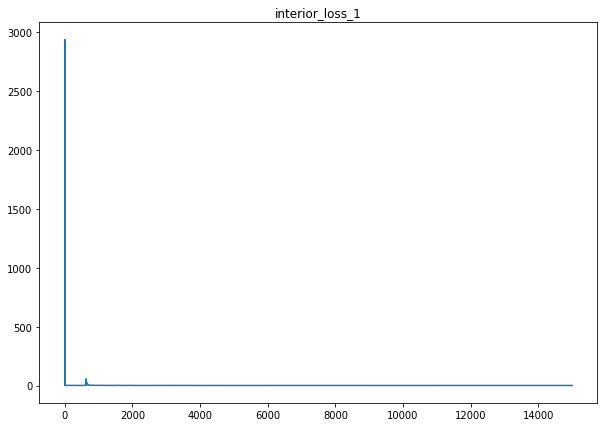

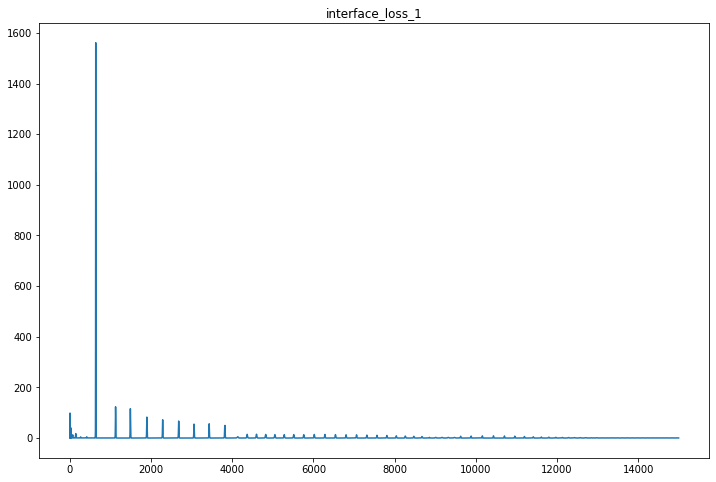

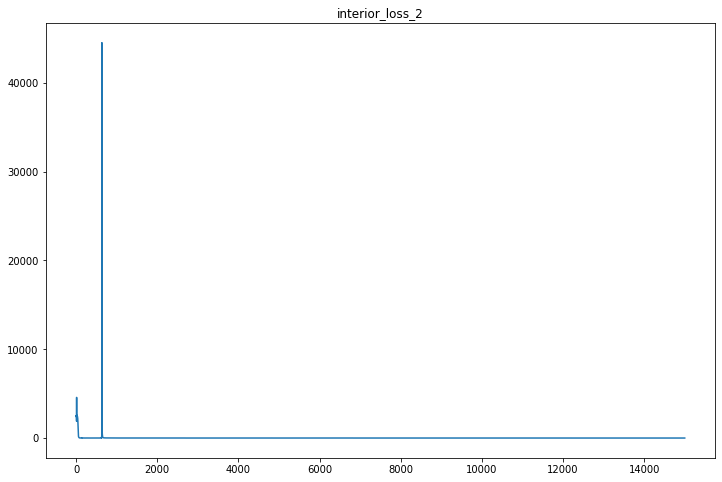

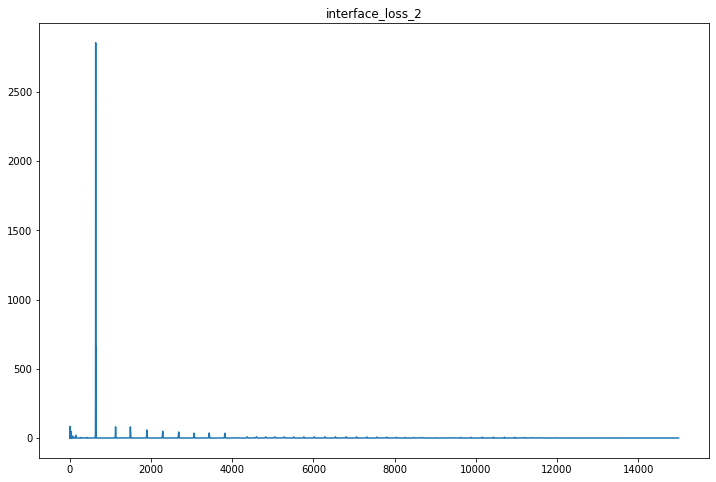

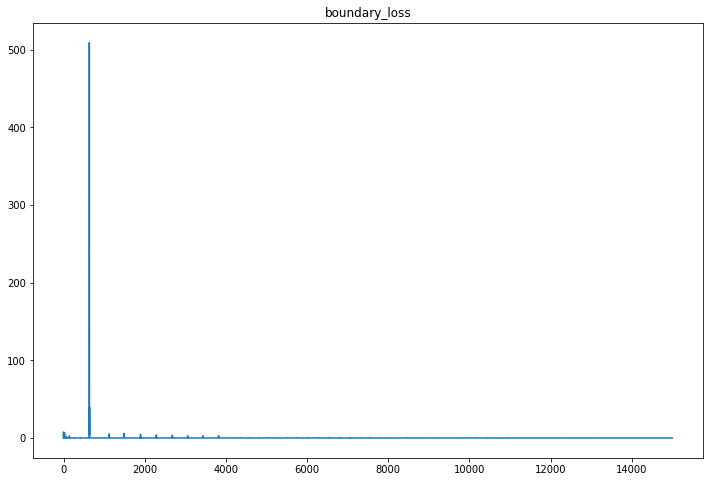

In [ ]:
fig = plt.figure(figsize=(10, 7))

plt.plot(loss_array[0, :])
plt.title('interior_loss_1')
plt.show()

fig = plt.figure(figsize=(12, 8))

plt.plot(loss_array[1, :])
plt.title('interface_loss_1')
plt.show()

fig = plt.figure(figsize=(12, 8))

plt.plot(loss_array[2, :])
plt.title('interior_loss_2')
plt.show()

fig = plt.figure(figsize=(12, 8))

plt.plot(loss_array[3, :])
plt.title('interface_loss_2')

plt.show()

fig = plt.figure(figsize=(12, 8))

plt.plot(loss_array[4, :])
plt.title('boundary_loss')

plt.show()

# Predict Output


In [ ]:
# Solution prediction
nn1_trained = nn_approximator_trained[0]
nn2_trained = nn_approximator_trained[1]

nn1_trained.beta.to("cpu")
print(nn1_trained.beta.is_cuda)
# nn1_trained.beta0.cpu()
# print(nn1_trained.beta0.is_cuda)
# nn2_trained.beta.cpu()
# nn2_trained.beta0.cpu()

u_pred1 = nn1_trained(torch.tensor(np.float32(input_data[0]))).detach().numpy()
u_pred2 = nn2_trained(torch.tensor(np.float32(input_data[1]))).detach().numpy()

u_pred_i1 = nn1_trained(torch.tensor(np.float32(input_data[2]))).detach().numpy()
u_pred_i2 = nn2_trained(torch.tensor(np.float32(input_data[2]))).detach().numpy()

u_pred_b = nn2_trained(torch.tensor(np.float32(input_data[3]))).detach().numpy()

u_pred = np.concatenate([u_pred1, u_pred2, (u_pred_i1 + u_pred_i2)/2, u_pred_b])

False


In [ ]:
# u_exact1 = data['u_domain'].flatten()[:,None]
# u_exact2 = data['u_coil'].flatten()[:,None]

# u_exacti = data['u_i'].flatten()[:,None]

# u_exact = np.concatenate([u_exact1, u_exact2, u_exacti, u_boundary])


In [ ]:
# u_exact1 = np.divide(u_exact1, u_exact.max())
# print(u_exact1.max(), u_exact1.min())

In [ ]:
# u_exact2 = np.divide(u_exact2, u_exact.max())
# print(u_exact2.max(), u_exact2.min())

In [ ]:
# u_exacti = np.divide(u_exacti, u_exact.max())
# print(u_exacti.max(), u_exacti.min())

In [ ]:
# u_boundary = np.divide(u_boundary, u_exact.max())
# print(u_boundary.max(), u_boundary.min())

In [ ]:
# u_exact = np.concatenate([u_exact1, u_exact2, u_exacti, u_boundary])


## Max values

u max: 2.2

u min: 0


In [ ]:
x_f1, x_f2, x_i, x_boundary, y_f1, y_f2, y_i, y_boundary, u_exact = [plotting_data[i] for i in (0, 1, 2, 3, 4, 5, 6, 7, 8)]

In [ ]:
x_tot = np.concatenate([x_f1, x_f2, x_i, x_boundary])
y_tot = np.concatenate([y_f1, y_f2, y_i, y_boundary])
print(x_tot.shape, y_tot.shape, u_pred.shape, u_exact.shape)

(2693, 1) (2693, 1) (2693, 1) (2693, 1)


# Plotting Contours


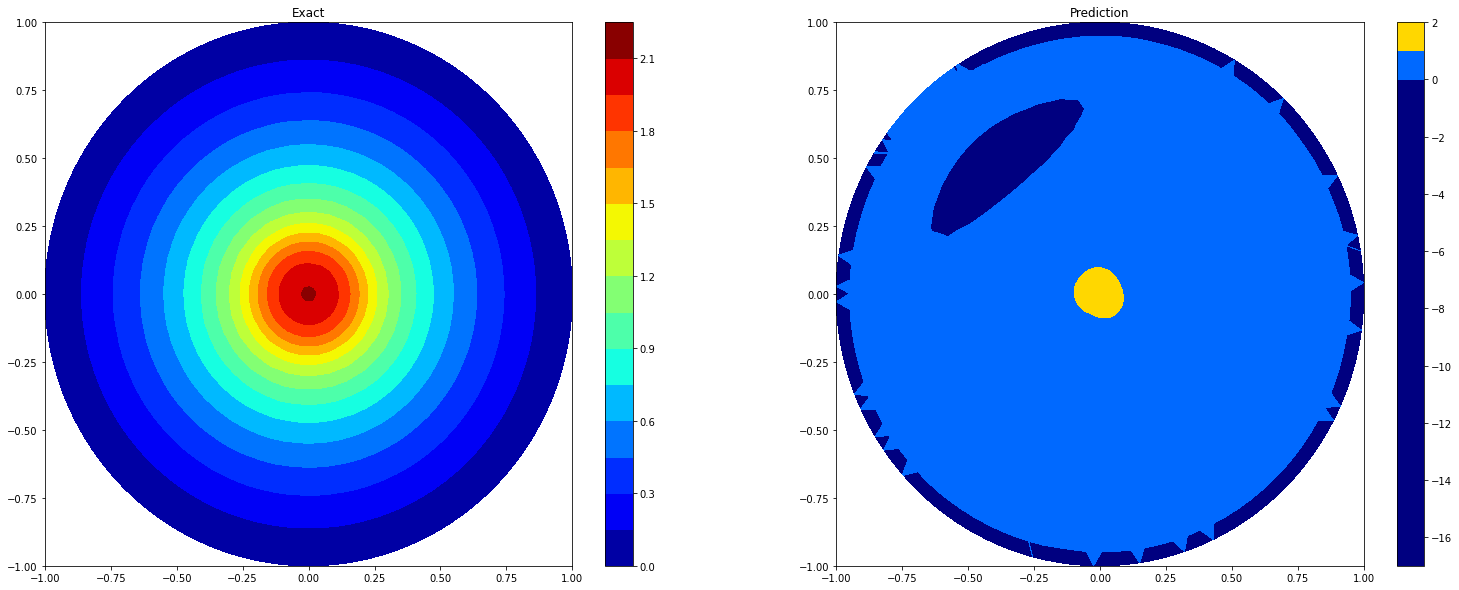

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import numpy as np


np.random.seed(19680801)
npts = 200
ngridx = 100
ngridy = 200
x = x_tot.squeeze()
y = y_tot.squeeze()
up = u_pred.squeeze()
uex = u_exact.squeeze()

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(26,10))
vmin=0
vmax=2.2

## True Exact
# ax2.tricontour(x, y, z, levels=20, linewidths=0.5, colors='k')
cntr1 = ax1.tricontourf(x, y, uex, levels=20, vmin=vmin, vmax=vmax, cmap="jet")

fig.colorbar(cntr1, ax=ax1)
# ax2.plot(x, y, 'ko', ms=3)
ax1.set(xlim=(-1, 1), ylim=(-1, 1))
ax1.set_title('Exact')


## Predictions
# ax2.tricontour(x, y, z, levels=20, linewidths=0.5, colors='k')
cntr2 = ax2.tricontourf(x, y, up, levels=20, vmin=vmin, vmax=vmax, cmap="jet")

fig.colorbar(cntr2, ax=ax2)
# ax2.plot(x, y, 'ko', ms=3)
ax2.set(xlim=(-1, 1), ylim=(-1, 1))
ax2.set_title('Prediction')

plt.subplots_adjust(hspace=0.5)
# plt.savefig('exact_pred_TL_20points.png', dpi=400)
plt.show()

## Rough

In [ ]:
# # numeric solution
# def logistic_eq_fn(x, y):
#     return R * x * (1 - x)

# numeric_solution = solve_ivp(
#     logistic_eq_fn, domain, [F0], t_eval=x_eval.squeeze().detach().numpy()
# )

# # plotting
# fig, ax = plt.subplots()

# f_final_training = f(nn_approximator_trained, x)
# f_final = f(nn_approximator_trained, x_eval)

# ax.scatter(x.detach().numpy(), f_final_training.detach().numpy(), label="Training points", color="red")
# ax.plot(x_eval.detach().numpy(), f_final.detach().numpy(), label="NN final solution")
# ax.plot(
#     x_eval.detach().numpy(),
#     numeric_solution.y.T,
#     label=f"Analytic solution",
#     color="green",
#     alpha=0.75,
# )
# ax.set(title="Logistic equation solved with NNs", xlabel="t", ylabel="f(t)")
# ax.legend()

# fig, ax = plt.subplots()
# ax.semilogy(loss_evolution)
# ax.set(title="Loss evolution", xlabel="# epochs", ylabel="Loss")
# ax.legend()

# plt.show()